<h1><center>Laboratorio 9: Optimización de modelos 💯</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Ignacio Meza, Gabriel Iturra
- Auxiliar: Sebastián Tinoco
- Ayudante: Arturo Lazcano, Angelo Muñoz

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Daniel Minaya
- Nombre de alumno 2:

## Temas a tratar

- Predicción de demanda usando `xgboost`
- Búsqueda del modelo óptimo de clasificación usando `optuna`
- Uso de pipelines.

## Reglas:

- **Grupos de 2 personas**
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer material del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Optimizar modelos usando `optuna`
- Recurrir a técnicas de *prunning*
- Forzar el aprendizaje de relaciones entre variables mediante *constraints*
- Fijar un pipeline con un modelo base que luego se irá optimizando.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

### **Link de repositorio de GitHub:** `https://github.com/DanielMinaya1/MDS7202`

# Importamos librerias útiles

In [1]:
!pip install -qq xgboost optuna

# 1. El emprendimiento de Fiu

Tras liderar de manera exitosa la implementación de un proyecto de ciencia de datos para caracterizar los datos generados en Santiago 2023, el misterioso corpóreo **Fiu** se anima y decide levantar su propio negocio de consultoría en machine learning. Tras varias e intensas negociaciones, Fiu logra encontrar su *primera chamba*: predecir la demanda (cantidad de venta) de una famosa productora de bebidas de calibre mundial. Como usted tuvo un rendimiento sobresaliente en el proyecto de caracterización de datos, Fiu lo contrata como *data scientist* de su emprendimiento.

Para este laboratorio deben trabajar con los datos `sales.csv` subidos a u-cursos, el cual contiene una muestra de ventas de la empresa para diferentes productos en un determinado tiempo.

Para comenzar, cargue el dataset señalado y visualice a través de un `.head` los atributos que posee el dataset.

<i><p align="center">Fiu siendo felicitado por su excelente desempeño en el proyecto de caracterización de datos</p></i>
<p align="center">
  <img src="https://media-front.elmostrador.cl/2023/09/A_UNO_1506411_2440e.jpg">
</p>

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

df = pd.read_csv('sales.csv')
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y')

## 1.1 Generando un Baseline (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/O-lan6TkadUAAAAC/what-i-wnna-do-after-a-baseline.gif">
</p>

Antes de entrenar un algoritmo, usted recuerda los apuntes de su magíster en ciencia de datos y recuerda que debe seguir una serie de *buenas prácticas* para entrenar correcta y debidamente su modelo. Después de un par de vueltas, llega a las siguientes tareas:

1. Separe los datos en conjuntos de train (70%), validation (20%) y test (10%). Fije una semilla para controlar la aleatoriedad.
2. Implemente un `FunctionTransformer` para extraer el día, mes y año de la variable `date`. Guarde estas variables en el formato categorical de pandas.
3. Implemente un `ColumnTransformer` para procesar de manera adecuada los datos numéricos y categóricos. Use `OneHotEncoder` para las variables categóricas.
4. Guarde los pasos anteriores en un `Pipeline`, dejando como último paso el regresor `DummyRegressor` para generar predicciones en base a promedios.
5. Entrene el pipeline anterior y reporte la métrica `mean_absolute_error` sobre los datos de validación. ¿Cómo se interpreta esta métrica para el contexto del negocio?
6. Finalmente, vuelva a entrenar el `Pipeline` pero esta vez usando `XGBRegressor` como modelo **utilizando los parámetros por default**. ¿Cómo cambia el MAE al implementar este algoritmo? ¿Es mejor o peor que el `DummyRegressor`?
7. Guarde ambos modelos en un archivo .pkl (uno cada uno)

### Librerías

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import pickle
from sklearn.base import BaseEstimator, TransformerMixin
import optuna
from optuna.samplers import TPESampler
import time
from optuna.integration import XGBoostPruningCallback
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances

# Semilla
seed = 42

### 1.1.0 Análisis exploratorio

In [4]:
df.head()

id       date    city       lat      long     pop    shop        brand  \
0   0 2012-01-31  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
1   1 2012-01-31  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
2   2 2012-01-31  Athens  37.97945  23.71622  672130  shop_1  kinder-cola   
3   3 2012-01-31  Athens  37.97945  23.71622  672130  shop_1   adult-cola   
4   4 2012-01-31  Athens  37.97945  23.71622  672130  shop_1   adult-cola   

  container capacity  price  quantity  
0     glass    500ml   0.96     13280  
1   plastic    1.5lt   2.86      6727  
2       can    330ml   0.87      9848  
3     glass    500ml   1.00     20050  
4       can    330ml   0.39     25696

In [5]:
df['date'].min(), df['date'].max()

(Timestamp('2012-01-31 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [6]:
df['city'].value_counts()

city
Athens          2482
Thessaloniki    1246
Patra           1245
Larisa          1242
Irakleion       1241
Name: count, dtype: int64

In [7]:
df['lat'].value_counts(), df['long'].value_counts()

(lat
 40.64361    1246
 38.24444    1245
 37.96245    1242
 37.97945    1241
 35.32787    1241
 39.63689    1241
 Name: count, dtype: int64,
 long
 21.73444    1246
 22.93086    1246
 22.41761    1242
 25.14341    1241
 23.68708    1241
 23.71622    1240
 Name: count, dtype: int64)

In [8]:
df['pop'].unique()

array([672130, 134219, 164250, 346502, 137540, 671022, 135432, 166301,
       347001, 139242, 668203, 136202, 167242, 349232, 140563, 667237,
       138560, 167001, 351650, 141732, 665102, 137302, 168254, 351702,
       142030, 665871, 138200, 168501, 353001, 144302, 664046, 137154,
       168034, 354290, 144651], dtype=int64)

In [9]:
df['shop'].value_counts()

shop
shop_4    1246
shop_6    1245
shop_5    1242
shop_1    1241
shop_2    1241
shop_3    1241
Name: count, dtype: int64

In [10]:
df['brand'].value_counts()

brand
kinder-cola     1495
adult-cola      1493
lemon-boost     1493
gazoza          1491
orange-power    1484
Name: count, dtype: int64

In [11]:
df['container'].value_counts()

container
glass      2486
plastic    2485
can        2485
Name: count, dtype: int64

In [12]:
df['capacity'].value_counts()

capacity
330ml    2486
500ml    2485
1.5lt    2485
Name: count, dtype: int64

In [13]:
df['price'].value_counts()

price
0.59    96
0.65    88
0.56    86
0.66    81
0.71    78
        ..
4.33     1
4.31     1
4.42     1
0.11     1
4.53     1
Name: count, Length: 402, dtype: int64

In [14]:
df['quantity'].value_counts()

quantity
22207    4
24057    3
31205    3
25620    3
15019    3
        ..
15475    1
62328    1
25512    1
17555    1
24615    1
Name: count, Length: 6906, dtype: int64

>Suponemos que el dataset contiene las ventas de bebidas por tiendas. Las columnas serían:
>* id: identificador de la fila,
>* date: fecha de compra, desde 2012 hasta 2018
>* city: ciudad de la tienda, se encuentran en Grecia,
>* lat, long: latitud y longitud de la tienda,
>* pop: población de la ciudad (varía con la fecha),
>* shop: tienda,
>* brand: marca de la bebida,
>* container: contenedor de la bebida,
>* price: precio de la bebida
>* quantity: cantidad comprada

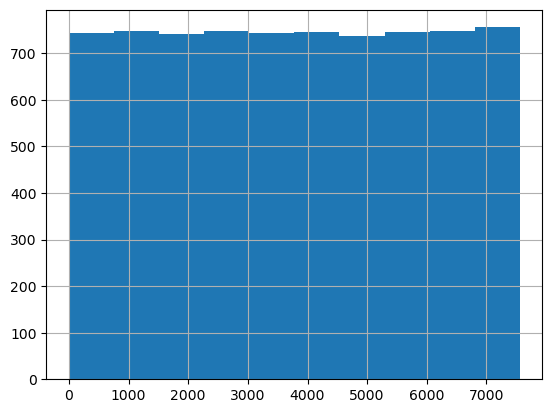

In [15]:
df['id'].hist()
plt.show()

In [16]:
df.drop_duplicates(subset=['shop', 'lat', 'long'])

id       date          city       lat      long     pop    shop  \
0        0 2012-01-31        Athens  37.97945  23.71622  672130  shop_1   
11      11 2012-01-31     Irakleion  35.32787  25.14341  134219  shop_2   
22      23 2012-01-31         Patra  38.24444  21.73444  164250  shop_6   
35      36 2012-01-31  Thessaloniki  40.64361  22.93086  346502  shop_4   
45      46 2012-01-31        Athens  37.96245  23.68708  672130  shop_3   
56      57 2012-01-31        Larisa  39.63689  22.41761  137540  shop_5   
6736  6840 2018-05-31        Athens  37.97945  21.73444  664046  shop_1   
6982  7086 2018-07-31        Larisa  37.96245  22.41761  144651  shop_5   

            brand container capacity  price  quantity  
0     kinder-cola     glass    500ml   0.96     13280  
11    kinder-cola     glass    500ml   1.51      8943  
22    kinder-cola     glass    500ml   1.11     17474  
35    kinder-cola   plastic    1.5lt   2.80     11306  
45    kinder-cola   plastic    1.5lt   3.21      5630  
56    kinder-cola     glass    500ml   1.38      7495  
6736  kinder-cola   plastic    1.5lt   3.30     13753  
6982  kinder-cola     glass    500ml   1.28     20185

In [17]:
df.drop_duplicates(subset=['shop', 'lat'])

id       date          city       lat      long     pop    shop  \
0        0 2012-01-31        Athens  37.97945  23.71622  672130  shop_1   
11      11 2012-01-31     Irakleion  35.32787  25.14341  134219  shop_2   
22      23 2012-01-31         Patra  38.24444  21.73444  164250  shop_6   
35      36 2012-01-31  Thessaloniki  40.64361  22.93086  346502  shop_4   
45      46 2012-01-31        Athens  37.96245  23.68708  672130  shop_3   
56      57 2012-01-31        Larisa  39.63689  22.41761  137540  shop_5   
6982  7086 2018-07-31        Larisa  37.96245  22.41761  144651  shop_5   

            brand container capacity  price  quantity  
0     kinder-cola     glass    500ml   0.96     13280  
11    kinder-cola     glass    500ml   1.51      8943  
22    kinder-cola     glass    500ml   1.11     17474  
35    kinder-cola   plastic    1.5lt   2.80     11306  
45    kinder-cola   plastic    1.5lt   3.21      5630  
56    kinder-cola     glass    500ml   1.38      7495  
6982  kinder-cola     glass    500ml   1.28     20185

In [18]:
df.drop_duplicates(subset=['shop', 'long'])

id       date          city       lat      long     pop    shop  \
0        0 2012-01-31        Athens  37.97945  23.71622  672130  shop_1   
11      11 2012-01-31     Irakleion  35.32787  25.14341  134219  shop_2   
22      23 2012-01-31         Patra  38.24444  21.73444  164250  shop_6   
35      36 2012-01-31  Thessaloniki  40.64361  22.93086  346502  shop_4   
45      46 2012-01-31        Athens  37.96245  23.68708  672130  shop_3   
56      57 2012-01-31        Larisa  39.63689  22.41761  137540  shop_5   
6736  6840 2018-05-31        Athens  37.97945  21.73444  664046  shop_1   

            brand container capacity  price  quantity  
0     kinder-cola     glass    500ml   0.96     13280  
11    kinder-cola     glass    500ml   1.51      8943  
22    kinder-cola     glass    500ml   1.11     17474  
35    kinder-cola   plastic    1.5lt   2.80     11306  
45    kinder-cola   plastic    1.5lt   3.21      5630  
56    kinder-cola     glass    500ml   1.38      7495  
6736  kinder-cola   plastic    1.5lt   3.30     13753

>Podemos ver que la columna id sigue casi una distribución uniforme, por lo que podemos prescindir de esta columna para los modelos. Además, las columnas lat y long si bien son numéricas, podemos tratarlas como variables categóricas debido a la baja cantidad de categorías únicas y además cada categoría creada tendría casi la misma cantidad de datos. Sin embargo, como (lat, long) corresponde a la posición de la tienda, entonces hay una alta correlación entre estas tres variables, por lo que deberíamos evaluar el desempeño de los modelos al incluir estas variables.
>
>Con respecto al tipo de variables, consideraremos solo pop, price y quantity como variables numéricas, y como pop y price representan valores positivos utilizaremos MinMaxScaler para escalarlos, mientras que price no será escalado ya que es nuestra variable objetivo.

### 1.1.1 Separación de datos

In [19]:
# Separamos features y labels
X, y = df.drop(columns=['quantity']), df['quantity']

# Separamos en train (70%), validation (20%) y split (10%)
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, 
                                                          test_size=0.3, 
                                                          random_state=seed, 
                                                          shuffle=True,
                                                         )
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, 
                                                test_size=0.33, 
                                                random_state=seed,
                                                shuffle=True,
                                               )

print("Train:", len(X_train))
print("Val:", len(X_val))
print("Test:", len(X_test))

Train: 5219
Val: 1498
Test: 739


### 1.1.2 FunctionTransformer para la columna Date

In [20]:
# Definimos función para extraer día, mes y año como categorías
def extract_date_info(df):
    df['day'] = df['date'].dt.day.astype('category')
    df['month'] = df['date'].dt.month.astype('category')
    df['year'] = df['date'].dt.year.astype('category')
    
    return df.drop(columns=['date'])

# Definimos el transformer para separar date
date_transformer = FunctionTransformer(extract_date_info)

# Ejemplo
date_transformer.fit_transform(X_train)

id       city       lat      long     pop    shop         brand  \
292    300      Patra  38.24444  21.73444  164250  shop_6    adult-cola   
3366  3416     Athens  37.97945  23.71622  667237  shop_1        gazoza   
3685  3741     Athens  37.96245  23.68708  667237  shop_3    adult-cola   
2404  2441     Athens  37.97945  23.71622  668203  shop_1        gazoza   
2855  2898  Irakleion  35.32787  25.14341  136202  shop_2  orange-power   
...    ...        ...       ...       ...     ...     ...           ...   
5191  5275     Athens  37.96245  23.68708  665102  shop_3    adult-cola   
5226  5311     Athens  37.97945  23.71622  665102  shop_1   kinder-cola   
5390  5478     Athens  37.97945  23.71622  665871  shop_1        gazoza   
860    873     Athens  37.96245  23.68708  672130  shop_3        gazoza   
7270  7374     Athens  37.96245  23.68708  664046  shop_3    adult-cola   

     container capacity  price day month  year  
292    plastic    1.5lt   2.54  30     4  2012  
3366   plastic    1.5lt   0.71  28     2  2015  
3685       can    330ml   0.66  30     6  2015  
2404       can    330ml   0.30  30     4  2014  
2855       can    330ml   0.56  30     9  2014  
...        ...      ...    ...  ..   ...   ...  
5191   plastic    1.5lt   3.59  30    11  2016  
5226   plastic    1.5lt   2.78  31    12  2016  
5390       can    330ml   0.36  31     1  2017  
860      glass    500ml   0.51  31    10  2012  
7270       can    330ml   0.81  31    10  2018  

[5219 rows x 13 columns]

### 1.1.3 ColumnTransformer para el dataset

In [21]:
# Definimos las columnas numéricas
numerical_features = [
    'pop',
    'price',
]

# Definimos las columnas categóricas
categorical_features = [
    'city',
    'lat',
    'long',
    'shop',
    'brand',
    'container',
    'capacity',
    'day', 
    'month', 
    'year',
] 

# Definimos el preprocesador para las columnas
preprocessor = ColumnTransformer(
    transformers = [
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ],
    # Eliminamos la columna id
    remainder = 'drop'
)

### 1.1.4 Generación de Pipelines

In [22]:
pipeline_dummy = Pipeline([
    ('date_transformer', date_transformer),
    ('preprocessor', preprocessor),
    ('regressor', DummyRegressor())
])

pipeline_xgb = Pipeline([
    ('date_transformer', date_transformer),
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor())
])

### 1.1.5 Entrenamiento

In [23]:
pipeline_dummy.fit(X_train, y_train)

Pipeline(steps=[('date_transformer',
                 FunctionTransformer(func=<function extract_date_info at 0x0000019FD2051000>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['pop', 'price']),
                                                 ('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['city', 'lat', 'long',
                                                   'shop', 'brand', 'container',
                                                   'capacity', 'day', 'month',
                                                   'year'])])),
                ('regressor', DummyRegressor())])

In [24]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('date_transformer',
                 FunctionTransformer(func=<function extract_date_info at 0x0000019FD2051000>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['pop', 'price']),
                                                 ('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['city', 'lat', 'long',
                                                   'shop', 'brand', 'container',
                                                   'capacity', 'day', 'month',
                                                   'year'])])),
                ('regressor',
                 XGBRegressor...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [25]:
# Predecimos
y_pred_dummy = pipeline_dummy.predict(X_val)
y_pred_xgb = pipeline_xgb.predict(X_val)

# Calculamos MAE en conjunto de validación
mae_dummy = mean_absolute_error(y_val, y_pred_dummy)
mae_xgb = mean_absolute_error(y_val, y_pred_xgb)

# Printeamos
print(f'MAE con Dummy Regressor: {mae_dummy}')
print(f'MAE con XGB Regressor: {mae_xgb}')

MAE con Dummy Regressor: 13308.134750658153
MAE con XGB Regressor: 2441.8524880504738


### 1.1.6 Análisis de resultados

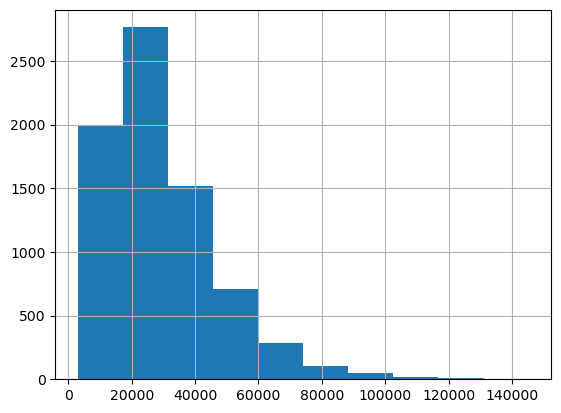

In [26]:
df['quantity'].hist()
plt.show()

>Para el DummyRegressor obtuvimos un MAE de 13,000, y como la variable objetivo quantity está en ese orden de magnitud, este error es demasiado grande, por lo que este modelo no es un buen regresor. Por otro lado, con el XGBRegressor obtuvimos un MAE de 2,400, que es un orden de magnitud menos que el obtenido en el modelo anterior, por lo cual vemos que XGBRegressor se desempeña mejor que DummyRegressor lo cual era de esperarse.
>
>Para interpretar la métrica Mean Absolute Error (MAE) lo que estamos haciendo es ver qué tan alejado están los puntos de la función de regresión, y luego promediamos esa distancia. La principal diferencia con la clásica métrica Mean Squared Error (MSE) es que está métrica penaliza todas las distancias por igual, mientras que MSE penaliza más los errores grandes, mientras que los errores pequeños son más despreciables.

### 1.1.7 Guardado de modelos

In [27]:
pickle.dump(pipeline_dummy, open('models/dummy_regressor_model.pkl', 'wb'))
pickle.dump(pipeline_xgb, open('models/dummy_regressor_model.pkl', 'wb'))

## 1.2 Forzando relaciones entre parámetros con XGBoost (1.0 puntos)

<p align="center">
  <img src="https://64.media.tumblr.com/14cc45f9610a6ee341a45fd0d68f4dde/20d11b36022bca7b-bf/s640x960/67ab1db12ff73a530f649ac455c000945d99c0d6.gif">
</p>

Un colega aficionado a la economía le *sopla* que la demanda guarda una relación inversa con el precio del producto. Motivado para impresionar al querido corpóreo, se propone hacer uso de esta información para mejorar su modelo.

Vuelva a entrenar el `Pipeline`, pero esta vez forzando una relación monótona negativa entre el precio y la cantidad. Luego, vuelva a reportar el `MAE` sobre el conjunto de validación. ¿Cómo cambia el error al incluir esta relación? ¿Tenía razón su amigo?

Nuevamente, guarde su modelo en un archivo .pkl

Nota: Para realizar esta parte, debe apoyarse en la siguiente <a href = https://xgboost.readthedocs.io/en/stable/tutorials/monotonic.html>documentación</a>.

Hint: Para implementar el constraint, se le sugiere hacerlo especificando el nombre de la variable. De ser así, probablemente le sea útil **mantener el formato de pandas** antes del step de entrenamiento.

### 1.2.1 FunctionTransformer para pasar a DataFrame

In [28]:
# Creamos una función que convierta el array en DataFrame
def to_dataframe(X, preprocessor, numerical_features, categorical_features):
    num_col_names = list(preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features))
    cat_col_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
    col_names = num_col_names + cat_col_names
    return pd.DataFrame(X, columns=col_names)

# Obtenemos el nombre de las columnas luego de preprocesar
num_col_names = list(preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features))
cat_col_names = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
col_names = num_col_names + cat_col_names

# Definimos el transformer
to_dataframe_transformer = FunctionTransformer(to_dataframe, kw_args={'preprocessor': preprocessor,
                                                                      'numerical_features': numerical_features,
                                                                      'categorical_features': categorical_features,
                                                                     })

### 1.2.2 Actualización de Pipeline

In [29]:
# Agregamos to_dataframe a la pipeline y agregamos la restricción de monotonía
pipeline_xgb_monotonic = Pipeline([
    ('date_transformer', date_transformer),
    ('preprocessor', preprocessor),
    ('to_dataframe', to_dataframe_transformer),
    ('regressor', XGBRegressor(monotone_constraints={"price": -1})),
])

### 1.2.3 Entrenamiento

In [30]:
pipeline_xgb_monotonic.fit(X_train, y_train)

Pipeline(steps=[('date_transformer',
                 FunctionTransformer(func=<function extract_date_info at 0x0000019FD2051000>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['pop', 'price']),
                                                 ('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['city', 'lat', 'long',
                                                   'shop', 'brand', 'container',
                                                   'capacity', 'day', 'month',
                                                   'year'])])),
                ('to_dataframe',
                 FunctionT...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints={'price': -1},
                              multi_strategy=None, n_estimators=None,
                              n_jobs=None, num_parallel_tree=None,
                              random_state=None, ...))])

In [31]:
# Predecimos
y_pred_xgb_monotonic = pipeline_xgb_monotonic.predict(X_val)

# Calculamos MAE en conjunto de validación
mae_xgb_monotonic = mean_absolute_error(y_val, y_pred_xgb_monotonic)

# Printeamos 
print(f'MAE con XGB Regressor: {mae_xgb}')
print(f'MAE con XGB Regressor + Monotonic Constraint: {mae_xgb_monotonic}')

MAE con XGB Regressor: 2441.8524880504738
MAE con XGB Regressor + Monotonic Constraint: 2477.7784169073575


### 1.2.4 Análisis de resultados

>Podemos ver que el MAE obtenido por el modelo después de agregar la restricción de monotonía no afectó el desempeño del modelo, de hecho, el error aumentó ligeramente, es decir, para este conjunto de datos en particular, no se aprecia una mejora significativa, pero como tampoco se empeora el modelo, entonces podemos decir que esta restricción realmente no cumplió con su objetivo para este dataset, lo cual no quiere decir que la restricción no se pueda cumplir para otro conjunto de datos, es decir, no podemos asegurar que nuestro amigo tuvo razón, pero tampoco podemos decir que esté equivocado.

### 1.2.5 Guardado del modelo

In [32]:
pickle.dump(pipeline_xgb_monotonic, open('models/xgb_regressor_monotonic_model.pkl', 'wb'))

## 1.3 Optimización de Hiperparámetros con Optuna (2.0 puntos)

<p align="center">
  <img src="https://media.tenor.com/fmNdyGN4z5kAAAAi/hacking-lucy.gif">
</p>

Luego de presentarle sus resultados, Fiu le pregunta si es posible mejorar *aun más* su modelo. En particular, le comenta de la optimización de hiperparámetros con metodologías bayesianas a través del paquete `optuna`. Como usted es un aficionado al entrenamiento de modelos de ML, se propone implementar la descabellada idea de su jefe.

A partir de la mejor configuración obtenida en la sección anterior, utilice `optuna` para optimizar sus hiperparámetros. En particular, se le pide:

- Fijar una semilla en las instancias necesarias para garantizar la reproducibilidad de resultados
- Utilice `TPESampler` como método de muestreo
- De `XGBRegressor`, optimice los siguientes hiperparámetros:
    - `learning_rate` buscando valores flotantes en el rango (0.001, 0.1)
    - `n_estimators` buscando valores enteros en el rango (50, 1000)
    - `max_depth` buscando valores enteros en el rango (3, 10)
    - `max_leaves` buscando valores enteros en el rango (0, 100)
    - `min_child_weight` buscando valores enteros en el rango (1, 5)
    - `reg_alpha` buscando valores flotantes en el rango (0, 1)
    - `reg_lambda` buscando valores flotantes en el rango (0, 1)
- De `OneHotEncoder`, optimice el hiperparámetro `min_frequency` buscando el mejor valor flotante en el rango (0.0, 1.0)
- Explique cada hiperparámetro y su rol en el modelo. ¿Hacen sentido los rangos de optimización indicados?
- Fije el tiempo de entrenamiento a 5 minutos
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- Guardar su modelo en un archivo .pkl

### 1.3.1 Elección de la mejor configuración

>En las secciones analizamos tres modelos diferentes: DummyRegressor, XGBRegressor y XGBRegresor con restricción de monotonía. Como el modelo que obtuvo el menor valor de MAE para el conjunto de validación fue XGBRegressor sin restricción de monotonía, entonces utilizaremos ese modelo para esta sección.

### 1.3.2 Parámetros del modelo

In [33]:
XGBRegressor().get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

### 1.3.3 Función objetivo

In [34]:
# Definimos la función objetivo para optuna
def objective_function(trial):
    # Definimos los hiperparámetros a optimizar para XGBRegressor
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }

    # Definimos los hiperparámetros a optimizar para OneHotEncoder
    ohe_params = {
        'min_frequency': trial.suggest_float('min_frequency', 0.0, 1.0),
    }

    # Definimos el preprocesador para las columnas
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', MinMaxScaler(), numerical_features),
            ('cat', OneHotEncoder(sparse_output=False, min_frequency=ohe_params['min_frequency']), categorical_features)
        ],
        remainder = 'drop'
    )

    # Definimos la pipeline con XGBRegressor
    pipeline = Pipeline([
        ('date_transformer', date_transformer),
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(seed=seed, **xgb_params)),
    ])
    
    # Entrenamos y predecimos
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)

    # Calculamos el MAE
    mae = mean_absolute_error(y_val, y_pred)

    return mae

### 1.3.4 Optimización

In [35]:
# Definimos el sampler
sampler = TPESampler(seed=seed)

# Definimos un study de optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize', sampler=sampler)

# Definimos el tiempo límite de ejecución (5 minutos)
timeout = 5 * 60

# Optimizamos
start_time = time.time()
study.optimize(objective_function, timeout=timeout, show_progress_bar=True)
end_time = time.time()

   0%|          | 00:00/05:00

### 1.3.5 Resultados

In [36]:
# Guardamos el mejor MAE
mae_xgb_optuna = study.best_value

# Entregamos los resultados
print(f"Number of trials: {len(study.trials)}")
print(f"Best trial MAE: {study.best_value:.4f}")
print(f"Best parameters: {study.best_params}")
print(f"Execution time: {end_time - start_time:.2f} seconds")

Number of trials: 205
Best trial MAE: 1932.1264
Best parameters: {'learning_rate': 0.07967157745047833, 'n_estimators': 966, 'max_depth': 8, 'max_leaves': 91, 'min_child_weight': 4, 'reg_alpha': 0.2597487635568112, 'reg_lambda': 0.4196469440202588, 'min_frequency': 0.058011986410824994}
Execution time: 300.91 seconds


### 1.3.6 Análisis de hiperparámetros y resultados

>Explicaremos cada hiperparámetro del modelo XGBRegressor:
>- <code>learning_rate</code>: controla la contribución de cada árbol a la actualización del modelo para evitar sobreajuste.
>- <code>n_estimators</code>: indica la cantidad de árboles a construir, mientras más árboles mejor será el rendimiento del modelo, pero también será más caro computacionalmente.
>- <code>max_depth</code>: controla la profundidad máxima que puede tener cada árbol, mientras mayor sea la profundidad más fácil será para los árboles capturar relaciones más complejas, sin embargo se corre el riesgo de sobreajuste.
>- <code>max_leaves</code>: indica el máximo número de hojas que puede tener cada árbol, mientras mayor sea la cantidad de hojas límite, hay mayor facilidad a sobreajustarse.
>- <code>min_child_weight</code>: indica el peso mínimo necesario para separar una hoja, mientras mayor sea este valor más difícil será para el modelo sobreajustarse a los datos específicos.
>- <code>reg_alpha</code>: coeficiente de regularización L1.
>- <code>reg_lambda</code>: coeficiente de regularización L2. Estos dos últimos coeficientes ayudan a evitar el sobreajuste del modelo, ya sea penalizando las features más importantes (para alpha) y penalizando los pesos más grandes (para lambda).
>- <code>min_frequency</code>: indica la frecuencia mínima para que una categoría sea considerada frecuente.
>
>Por como funciona cada hiperparámetro los rangos utilizados en la optimización son razonables.
>
>Por otro lado, con respecto a los resultados de la optimización. El modelo realizó aproximadamente 200 trials y el mejor fue el trial 173 con un MAE de 1900. Recordando que el modelo anterior con los parámetros por defecto obtuvo un MAE de 2400, entonces podemos decir que la optimización de los hiperparámetros mejoró el desempeño del modelo. Esto se debe a que precisamente estamos utilizando una combinación de hiperparámetros que permite que el modelo capture bien el comportamiento de los datos.

### 1.3.7 Guardado del mejor modelo

In [37]:
# Obtenemos el mejor intento y sus hiperparametros
best_trial = study.best_trial
best_hyperparameters = best_trial.params

# Definimos el preprocesador para las columnas
preprocessor = ColumnTransformer(
    transformers = [
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, min_frequency=best_hyperparameters['min_frequency']), categorical_features)
    ],
    remainder = 'drop'
)

# Definimos la pipeline con XGBRegressor
pipeline_xgb_optuna = Pipeline([
    ('date_transformer', date_transformer),
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(seed=seed, **best_hyperparameters)),
])

# Entrenamos
pipeline_xgb_optuna.fit(X_train, y_train)

# Guardamos
pickle.dump(pipeline_xgb_optuna, open('models/xgb_regressor_optuna_model.pkl', 'wb'))

C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [19:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_frequency" } are not used.

  warnings.warn(smsg, UserWarning)


## 1.4 Optimización de Hiperparámetros con Optuna y Prunners (1.7)

<p align="center">
  <img src="https://i.pinimg.com/originals/90/16/f9/9016f919c2259f3d0e8fe465049638a7.gif">
</p>

Después de optimizar el rendimiento de su modelo varias veces, Fiu le pregunta si no es posible optimizar el entrenamiento del modelo en sí mismo. Después de leer un par de post de personas de dudosa reputación en la *deepweb*, usted llega a la conclusión que puede cumplir este objetivo mediante la implementación de **Prunning**.

Vuelva a optimizar los mismos hiperparámetros que la sección pasada, pero esta vez utilizando **Prunning** en la optimización. En particular, usted debe:

- Responder: ¿Qué es prunning? ¿De qué forma debería impactar en el entrenamiento?
- Utilizar `optuna.integration.XGBoostPruningCallback` como método de **Prunning**
- Fijar nuevamente el tiempo de entrenamiento a 5 minutos
- Reportar el número de *trials*, el `MAE` y los mejores hiperparámetros encontrados. ¿Cómo cambian sus resultados con respecto a la sección anterior? ¿A qué se puede deber esto?
- Guardar su modelo en un archivo .pkl

Nota: Si quieren silenciar los prints obtenidos en el prunning, pueden hacerlo mediante el siguiente comando:

```
optuna.logging.set_verbosity(optuna.logging.WARNING)
```

De implementar la opción anterior, pueden especificar `show_progress_bar = True` en el método `optimize` para *más sabor*.

Hint: Si quieren especificar parámetros del método .fit() del modelo a través del pipeline, pueden hacerlo por medio de la siguiente sintaxis: `pipeline.fit(stepmodelo__parametro = valor)`

Hint2: Este <a href = https://stackoverflow.com/questions/40329576/sklearn-pass-fit-parameters-to-xgboost-in-pipeline>enlace</a> les puede ser de ayuda en su implementación

### 1.4.1 Prunning

>El pruning o poda es la interrupción prematura del entrenamiento de una configuración de hiperparámetros dada si se detecta que no está progresando adecuadamente. Este proceso se realiza mediante la monitorización de una métrica (<code>observation_key</code>) durante el entrenamiento y comparándola con un umbral. Si la métrica no mejora significativamente, el entrenamiento se detiene tempranamente, disminuyendo el tiempo que toma la optimización.
>
>Esto ayuda a evitar sobreajuste de los modelos, pues si la métrica no cambia significativamente, entonces el modelo ya aprendió lo necesario y seguir iterando lo único que lograra es que el modelo memorice la data de entrenamiento para seguir mejorando la métrica de evaluación. De este modo, conseguimos un modelo menos propenso a sobreajuste y se optimizan los hiperparámetros de manera más eficiente.

### 1.4.2 Función objetivo

In [38]:
# Definimos la función objetivo para optuna
def objective_function(trial):
    # Definimos los hiperparámetros a optimizar para XGBRegressor
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_leaves': trial.suggest_int('max_leaves', 0, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
    }

    # Definimos los hiperparámetros a optimizar para OneHotEncoder
    ohe_params = {
        'min_frequency': trial.suggest_float('min_frequency', 0.0, 1.0),
    }

    # Definimos el preprocesador para las columnas
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', MinMaxScaler(), numerical_features),
            ('cat', OneHotEncoder(sparse_output=False, min_frequency=ohe_params['min_frequency']), categorical_features)
        ],
        remainder = 'drop'
    )
    
    # Definimos el PrunningCallback
    pruning_callback = optuna.integration.XGBoostPruningCallback(
        trial, observation_key='validation_1-rmse'
    )

    # Definimos la pipeline con XGBRegressor
    pipeline = Pipeline([
        ('date_transformer', date_transformer),
        ('preprocessor', preprocessor),
    ])
    
    # Aplicamos las transformaciones
    X_train_transformed = pipeline.named_steps['date_transformer'].transform(X_train)
    X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train_transformed)

    X_val_transformed = pipeline.named_steps['date_transformer'].transform(X_val)
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val_transformed)

    # Entrenamos y predecimos con XGBRegressor
    xgb_regressor = XGBRegressor(seed=seed, **xgb_params, verbosity=0)
    xgb_regressor.set_params(callbacks=[pruning_callback])
    xgb_regressor.fit(X_train_transformed, y_train,
                      eval_set=[(X_train_transformed, y_train), (X_val_transformed, y_val)],
                     )
    y_pred = xgb_regressor.predict(X_val_transformed)

    # Calculamos el MAE
    mae = mean_absolute_error(y_val, y_pred)

    return mae

### 1.4.3 Optimización

In [39]:
# Definimos el sampler
sampler = TPESampler(seed=seed)

# Definimos un study de optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
prunning_study = optuna.create_study(direction='minimize', sampler=sampler)

# Definimos el tiempo límite de ejecución (5 minutos)
timeout = 5 * 60

# Optimizamos
start_time = time.time()
prunning_study.optimize(objective_function, 
                        timeout=timeout, 
                        show_progress_bar=True,
                       )
end_time = time.time()

   0%|          | 00:00/05:00

[0]	validation_0-rmse:17304.89294	validation_1-rmse:17229.33628
[1]	validation_0-rmse:16936.38712	validation_1-rmse:16850.89924
[2]	validation_0-rmse:16588.27450	validation_1-rmse:16494.55354
[3]	validation_0-rmse:16259.52939	validation_1-rmse:16160.16260
[4]	validation_0-rmse:15948.98756	validation_1-rmse:15845.93732
[5]	validation_0-rmse:15655.72846	validation_1-rmse:15550.45726
[6]	validation_0-rmse:15378.42702	validation_1-rmse:15269.51018
[7]	validation_0-rmse:15117.13223	validation_1-rmse:15009.12315
[8]	validation_0-rmse:14870.80250	validation_1-rmse:14764.60780
[9]	validation_0-rmse:14637.77262	validation_1-rmse:14534.71742
[10]	validation_0-rmse:14419.40103	validation_1-rmse:14321.36560
[11]	validation_0-rmse:14213.81762	validation_1-rmse:14117.98955
[12]	validation_0-rmse:14019.96216	validation_1-rmse:13932.14681
[13]	validation_0-rmse:13837.63071	validation_1-rmse:13762.14870
[14]	validation_0-rmse:13666.98716	validation_1-rmse:13598.80448
[15]	validation_0-rmse:13506.30297	

[126]	validation_0-rmse:10505.86227	validation_1-rmse:11662.73859
[127]	validation_0-rmse:10498.06854	validation_1-rmse:11665.13670
[128]	validation_0-rmse:10492.80192	validation_1-rmse:11666.13677
[129]	validation_0-rmse:10486.59426	validation_1-rmse:11667.57380
[130]	validation_0-rmse:10478.27627	validation_1-rmse:11670.91784
[131]	validation_0-rmse:10468.89268	validation_1-rmse:11672.73566
[132]	validation_0-rmse:10462.50066	validation_1-rmse:11675.65250
[133]	validation_0-rmse:10455.44526	validation_1-rmse:11683.44887
[134]	validation_0-rmse:10449.65996	validation_1-rmse:11685.23673
[135]	validation_0-rmse:10440.99699	validation_1-rmse:11686.18432
[136]	validation_0-rmse:10434.86207	validation_1-rmse:11687.22488
[137]	validation_0-rmse:10427.92575	validation_1-rmse:11694.49271
[138]	validation_0-rmse:10419.45692	validation_1-rmse:11695.19623
[139]	validation_0-rmse:10414.93759	validation_1-rmse:11695.67071
[140]	validation_0-rmse:10407.42950	validation_1-rmse:11698.95834
[141]	vali

[251]	validation_0-rmse:9849.62808	validation_1-rmse:12035.42092
[252]	validation_0-rmse:9842.67562	validation_1-rmse:12037.72065
[253]	validation_0-rmse:9839.79004	validation_1-rmse:12038.77103
[254]	validation_0-rmse:9835.66843	validation_1-rmse:12040.95178
[255]	validation_0-rmse:9833.37702	validation_1-rmse:12041.43291
[256]	validation_0-rmse:9831.07602	validation_1-rmse:12044.70983
[257]	validation_0-rmse:9826.31790	validation_1-rmse:12046.63865
[258]	validation_0-rmse:9822.98155	validation_1-rmse:12051.39979
[259]	validation_0-rmse:9819.17418	validation_1-rmse:12053.56090
[260]	validation_0-rmse:9816.67047	validation_1-rmse:12054.40519
[261]	validation_0-rmse:9809.46976	validation_1-rmse:12059.99937
[262]	validation_0-rmse:9804.48258	validation_1-rmse:12063.61669
[263]	validation_0-rmse:9802.25125	validation_1-rmse:12063.93171
[264]	validation_0-rmse:9798.10790	validation_1-rmse:12067.27146
[265]	validation_0-rmse:9793.09718	validation_1-rmse:12070.73728
[266]	validation_0-rmse:9

[378]	validation_0-rmse:9366.71955	validation_1-rmse:12293.79943
[379]	validation_0-rmse:9364.34947	validation_1-rmse:12295.29118
[380]	validation_0-rmse:9361.28840	validation_1-rmse:12295.94708
[381]	validation_0-rmse:9358.48087	validation_1-rmse:12296.86153
[382]	validation_0-rmse:9357.34181	validation_1-rmse:12297.14222
[383]	validation_0-rmse:9356.22365	validation_1-rmse:12297.22690
[384]	validation_0-rmse:9354.17571	validation_1-rmse:12298.76140
[385]	validation_0-rmse:9351.10080	validation_1-rmse:12301.40991
[386]	validation_0-rmse:9347.55489	validation_1-rmse:12305.68505
[387]	validation_0-rmse:9345.02044	validation_1-rmse:12307.99783
[388]	validation_0-rmse:9341.87959	validation_1-rmse:12309.71799
[389]	validation_0-rmse:9339.40747	validation_1-rmse:12314.03694
[390]	validation_0-rmse:9336.51801	validation_1-rmse:12315.25003
[391]	validation_0-rmse:9333.43774	validation_1-rmse:12315.66202
[392]	validation_0-rmse:9330.14781	validation_1-rmse:12316.48433
[393]	validation_0-rmse:9

[505]	validation_0-rmse:9066.41642	validation_1-rmse:12562.13023
[506]	validation_0-rmse:9065.02504	validation_1-rmse:12563.21444
[507]	validation_0-rmse:9062.22519	validation_1-rmse:12567.33869
[508]	validation_0-rmse:9057.89012	validation_1-rmse:12568.50460
[509]	validation_0-rmse:9055.33575	validation_1-rmse:12569.98232
[510]	validation_0-rmse:9053.47279	validation_1-rmse:12570.67119
[511]	validation_0-rmse:9051.58090	validation_1-rmse:12571.32093
[512]	validation_0-rmse:9049.83873	validation_1-rmse:12573.54267
[513]	validation_0-rmse:9048.12975	validation_1-rmse:12574.84026
[514]	validation_0-rmse:9046.37637	validation_1-rmse:12576.13622
[515]	validation_0-rmse:9042.39996	validation_1-rmse:12577.20274
[516]	validation_0-rmse:9040.65242	validation_1-rmse:12580.26302
[517]	validation_0-rmse:9038.81535	validation_1-rmse:12581.17176
[518]	validation_0-rmse:9036.39169	validation_1-rmse:12582.17412
[519]	validation_0-rmse:9031.63044	validation_1-rmse:12582.88057
[520]	validation_0-rmse:9

[632]	validation_0-rmse:8812.18367	validation_1-rmse:12753.11581
[633]	validation_0-rmse:8809.41094	validation_1-rmse:12753.18944
[634]	validation_0-rmse:8806.88655	validation_1-rmse:12753.59034
[635]	validation_0-rmse:8804.73625	validation_1-rmse:12754.63524
[636]	validation_0-rmse:8803.71218	validation_1-rmse:12756.51738
[637]	validation_0-rmse:8802.62546	validation_1-rmse:12758.17850
[638]	validation_0-rmse:8800.73748	validation_1-rmse:12759.03581
[639]	validation_0-rmse:8797.53968	validation_1-rmse:12761.08871
[640]	validation_0-rmse:8796.43855	validation_1-rmse:12763.34621
[641]	validation_0-rmse:8795.91028	validation_1-rmse:12764.07601
[642]	validation_0-rmse:8793.22025	validation_1-rmse:12766.14380
[643]	validation_0-rmse:8790.73855	validation_1-rmse:12766.91507
[644]	validation_0-rmse:8790.23139	validation_1-rmse:12767.80335
[645]	validation_0-rmse:8789.82908	validation_1-rmse:12768.61783
[646]	validation_0-rmse:8787.33316	validation_1-rmse:12770.62043
[647]	validation_0-rmse:8

[759]	validation_0-rmse:8603.51735	validation_1-rmse:12904.69217
[760]	validation_0-rmse:8603.00135	validation_1-rmse:12904.86851
[761]	validation_0-rmse:8602.54968	validation_1-rmse:12905.77447
[762]	validation_0-rmse:8601.89787	validation_1-rmse:12908.33761
[763]	validation_0-rmse:8597.89945	validation_1-rmse:12909.84614
[764]	validation_0-rmse:8597.30656	validation_1-rmse:12911.92120
[765]	validation_0-rmse:8596.75649	validation_1-rmse:12913.94054
[766]	validation_0-rmse:8595.77622	validation_1-rmse:12917.18867
[767]	validation_0-rmse:8594.86652	validation_1-rmse:12917.67485
[768]	validation_0-rmse:8594.34589	validation_1-rmse:12917.89411
[769]	validation_0-rmse:8592.79901	validation_1-rmse:12918.66041
[770]	validation_0-rmse:8592.05581	validation_1-rmse:12920.66875
[771]	validation_0-rmse:8591.37948	validation_1-rmse:12921.27458
[772]	validation_0-rmse:8590.79084	validation_1-rmse:12922.40260
[773]	validation_0-rmse:8590.08665	validation_1-rmse:12922.50951
[774]	validation_0-rmse:8

[886]	validation_0-rmse:8407.24993	validation_1-rmse:13039.50452
[887]	validation_0-rmse:8406.12456	validation_1-rmse:13040.27133
[888]	validation_0-rmse:8404.32238	validation_1-rmse:13040.88934
[889]	validation_0-rmse:8403.90841	validation_1-rmse:13042.57796
[890]	validation_0-rmse:8402.70894	validation_1-rmse:13043.34512
[891]	validation_0-rmse:8398.82437	validation_1-rmse:13045.90594
[892]	validation_0-rmse:8397.73518	validation_1-rmse:13047.73814
[893]	validation_0-rmse:8396.05742	validation_1-rmse:13048.36070
[894]	validation_0-rmse:8392.36781	validation_1-rmse:13049.55732
[895]	validation_0-rmse:8390.35828	validation_1-rmse:13050.12207
[896]	validation_0-rmse:8388.87472	validation_1-rmse:13051.81618
[897]	validation_0-rmse:8386.94330	validation_1-rmse:13052.34460
[898]	validation_0-rmse:8384.31381	validation_1-rmse:13055.55253
[899]	validation_0-rmse:8382.26404	validation_1-rmse:13057.55955
[900]	validation_0-rmse:8379.94109	validation_1-rmse:13059.62502
[901]	validation_0-rmse:8

[59]	validation_0-rmse:9601.13708	validation_1-rmse:9618.42832
[60]	validation_0-rmse:9581.21892	validation_1-rmse:9592.14800
[61]	validation_0-rmse:9555.40887	validation_1-rmse:9571.45406
[62]	validation_0-rmse:9511.16296	validation_1-rmse:9535.77504
[63]	validation_0-rmse:9494.33282	validation_1-rmse:9513.18140
[64]	validation_0-rmse:9456.24222	validation_1-rmse:9482.30264
[65]	validation_0-rmse:9437.76484	validation_1-rmse:9464.02448
[66]	validation_0-rmse:9403.54935	validation_1-rmse:9437.77815
[67]	validation_0-rmse:9368.85108	validation_1-rmse:9407.24515
[68]	validation_0-rmse:9350.32496	validation_1-rmse:9392.11563
[69]	validation_0-rmse:9336.91260	validation_1-rmse:9372.06944
[70]	validation_0-rmse:9303.99730	validation_1-rmse:9347.07446
[71]	validation_0-rmse:9276.05647	validation_1-rmse:9323.08127
[72]	validation_0-rmse:9257.69792	validation_1-rmse:9308.17131
[73]	validation_0-rmse:9245.92213	validation_1-rmse:9291.11687
[74]	validation_0-rmse:9227.78146	validation_1-rmse:927

[188]	validation_0-rmse:8274.82826	validation_1-rmse:8520.37804
[189]	validation_0-rmse:8272.79992	validation_1-rmse:8519.17558
[190]	validation_0-rmse:8267.45670	validation_1-rmse:8513.61784
[191]	validation_0-rmse:8264.27995	validation_1-rmse:8510.92276
[192]	validation_0-rmse:8261.56028	validation_1-rmse:8509.96642
[193]	validation_0-rmse:8254.40055	validation_1-rmse:8503.79145
[194]	validation_0-rmse:8250.84649	validation_1-rmse:8501.89001
[195]	validation_0-rmse:8244.82955	validation_1-rmse:8496.37880
[196]	validation_0-rmse:8243.36051	validation_1-rmse:8493.33120
[197]	validation_0-rmse:8239.82401	validation_1-rmse:8489.63826
[198]	validation_0-rmse:8236.91119	validation_1-rmse:8489.40702
[199]	validation_0-rmse:8234.16923	validation_1-rmse:8487.57529
[200]	validation_0-rmse:8231.25525	validation_1-rmse:8486.79892
[201]	validation_0-rmse:8225.79179	validation_1-rmse:8481.76558
[202]	validation_0-rmse:8218.74163	validation_1-rmse:8474.96972
[203]	validation_0-rmse:8216.76700	valid

[317]	validation_0-rmse:7899.87102	validation_1-rmse:8326.84384
[318]	validation_0-rmse:7898.14911	validation_1-rmse:8329.67618
[319]	validation_0-rmse:7896.31442	validation_1-rmse:8329.03231
[320]	validation_0-rmse:7895.00283	validation_1-rmse:8329.39070
[321]	validation_0-rmse:7890.87004	validation_1-rmse:8327.17626
[322]	validation_0-rmse:7889.29380	validation_1-rmse:8327.02851
[323]	validation_0-rmse:7887.80595	validation_1-rmse:8325.69656
[324]	validation_0-rmse:7887.01406	validation_1-rmse:8323.13449
[325]	validation_0-rmse:7885.30435	validation_1-rmse:8323.41058
[326]	validation_0-rmse:7883.86404	validation_1-rmse:8322.63425
[327]	validation_0-rmse:7880.33540	validation_1-rmse:8319.45514
[328]	validation_0-rmse:7878.28762	validation_1-rmse:8320.62991
[329]	validation_0-rmse:7876.06247	validation_1-rmse:8319.14115
[330]	validation_0-rmse:7873.21993	validation_1-rmse:8320.12788
[331]	validation_0-rmse:7872.55634	validation_1-rmse:8319.57291
[332]	validation_0-rmse:7870.73838	valid

[446]	validation_0-rmse:7698.35730	validation_1-rmse:8272.74415
[447]	validation_0-rmse:7697.57281	validation_1-rmse:8273.23589
[448]	validation_0-rmse:7695.95082	validation_1-rmse:8272.50509
[449]	validation_0-rmse:7694.83185	validation_1-rmse:8272.74326
[450]	validation_0-rmse:7693.21650	validation_1-rmse:8270.99401
[451]	validation_0-rmse:7691.75842	validation_1-rmse:8270.10365
[452]	validation_0-rmse:7690.36061	validation_1-rmse:8270.80698
[453]	validation_0-rmse:7688.31466	validation_1-rmse:8270.09994
[454]	validation_0-rmse:7687.65122	validation_1-rmse:8270.63133
[455]	validation_0-rmse:7686.12394	validation_1-rmse:8270.74496
[456]	validation_0-rmse:7684.42422	validation_1-rmse:8272.09182
[457]	validation_0-rmse:7683.94893	validation_1-rmse:8271.79835
[458]	validation_0-rmse:7683.13732	validation_1-rmse:8271.17582
[459]	validation_0-rmse:7682.38758	validation_1-rmse:8271.30520
[460]	validation_0-rmse:7681.38385	validation_1-rmse:8271.14459
[461]	validation_0-rmse:7679.93706	valid

[575]	validation_0-rmse:7570.20870	validation_1-rmse:8239.32827
[576]	validation_0-rmse:7569.05680	validation_1-rmse:8238.26155
[577]	validation_0-rmse:7568.39139	validation_1-rmse:8237.45297
[578]	validation_0-rmse:7568.13037	validation_1-rmse:8237.51910
[579]	validation_0-rmse:7567.27385	validation_1-rmse:8236.99408
[580]	validation_0-rmse:7566.07689	validation_1-rmse:8237.76898
[581]	validation_0-rmse:7565.82824	validation_1-rmse:8237.49089
[582]	validation_0-rmse:7565.05070	validation_1-rmse:8236.71109
[583]	validation_0-rmse:7563.49403	validation_1-rmse:8235.16503
[584]	validation_0-rmse:7561.61753	validation_1-rmse:8234.74550
[585]	validation_0-rmse:7559.95854	validation_1-rmse:8234.46468
[586]	validation_0-rmse:7557.24006	validation_1-rmse:8234.04519
[587]	validation_0-rmse:7556.27402	validation_1-rmse:8234.06158
[588]	validation_0-rmse:7555.56359	validation_1-rmse:8233.12795
[589]	validation_0-rmse:7554.66909	validation_1-rmse:8232.26161
[590]	validation_0-rmse:7553.26016	valid

[704]	validation_0-rmse:7457.76130	validation_1-rmse:8222.27863
[705]	validation_0-rmse:7457.37797	validation_1-rmse:8221.80489
[706]	validation_0-rmse:7456.96745	validation_1-rmse:8223.43667
[707]	validation_0-rmse:7456.25561	validation_1-rmse:8222.36253
[708]	validation_0-rmse:7455.45452	validation_1-rmse:8221.87943
[709]	validation_0-rmse:7455.23260	validation_1-rmse:8221.95149
[710]	validation_0-rmse:7454.93777	validation_1-rmse:8222.46801
[711]	validation_0-rmse:7454.51175	validation_1-rmse:8222.32673
[712]	validation_0-rmse:7452.83526	validation_1-rmse:8221.87677
[713]	validation_0-rmse:7451.49637	validation_1-rmse:8220.43090
[714]	validation_0-rmse:7450.30459	validation_1-rmse:8219.48056
[715]	validation_0-rmse:7449.91108	validation_1-rmse:8219.53775
[716]	validation_0-rmse:7448.91818	validation_1-rmse:8220.16004
[717]	validation_0-rmse:7447.99659	validation_1-rmse:8220.66917
[718]	validation_0-rmse:7447.30705	validation_1-rmse:8220.19052
[719]	validation_0-rmse:7446.21959	valid

[108]	validation_0-rmse:11104.55955	validation_1-rmse:11517.16152
[109]	validation_0-rmse:11099.35570	validation_1-rmse:11516.78045
[110]	validation_0-rmse:11093.52306	validation_1-rmse:11514.64750
[111]	validation_0-rmse:11087.55664	validation_1-rmse:11512.39369
[112]	validation_0-rmse:11082.63399	validation_1-rmse:11512.44182
[113]	validation_0-rmse:11078.11851	validation_1-rmse:11511.70476
[114]	validation_0-rmse:11072.13314	validation_1-rmse:11513.62903
[115]	validation_0-rmse:11066.27339	validation_1-rmse:11512.60260
[116]	validation_0-rmse:11062.87178	validation_1-rmse:11513.21290
[117]	validation_0-rmse:11058.65427	validation_1-rmse:11514.02195
[118]	validation_0-rmse:11053.04178	validation_1-rmse:11518.01635
[119]	validation_0-rmse:11048.77699	validation_1-rmse:11518.69142
[120]	validation_0-rmse:11043.36660	validation_1-rmse:11521.09130
[121]	validation_0-rmse:11037.77492	validation_1-rmse:11521.42987
[122]	validation_0-rmse:11033.85026	validation_1-rmse:11519.03597
[123]	vali

[233]	validation_0-rmse:10670.90515	validation_1-rmse:11653.48048
[234]	validation_0-rmse:10668.70894	validation_1-rmse:11654.25247
[235]	validation_0-rmse:10666.04608	validation_1-rmse:11656.15436
[236]	validation_0-rmse:10663.79619	validation_1-rmse:11658.48318
[237]	validation_0-rmse:10661.04455	validation_1-rmse:11658.85926
[238]	validation_0-rmse:10659.29728	validation_1-rmse:11659.18007
[239]	validation_0-rmse:10656.76691	validation_1-rmse:11661.68796
[240]	validation_0-rmse:10654.10220	validation_1-rmse:11662.32566
[241]	validation_0-rmse:10651.75714	validation_1-rmse:11661.92545
[242]	validation_0-rmse:10648.97478	validation_1-rmse:11664.38128
[243]	validation_0-rmse:10646.58055	validation_1-rmse:11668.41644
[244]	validation_0-rmse:10644.70265	validation_1-rmse:11671.35826
[245]	validation_0-rmse:10642.48687	validation_1-rmse:11671.99127
[246]	validation_0-rmse:10640.27370	validation_1-rmse:11676.03239
[247]	validation_0-rmse:10639.35515	validation_1-rmse:11676.50669
[248]	vali

[358]	validation_0-rmse:10412.78087	validation_1-rmse:11834.33384
[359]	validation_0-rmse:10409.96531	validation_1-rmse:11835.67960
[360]	validation_0-rmse:10408.48558	validation_1-rmse:11838.31267
[361]	validation_0-rmse:10406.95298	validation_1-rmse:11840.55980
[362]	validation_0-rmse:10406.21342	validation_1-rmse:11840.63299
[363]	validation_0-rmse:10404.23912	validation_1-rmse:11841.99066
[364]	validation_0-rmse:10403.34788	validation_1-rmse:11842.65959
[365]	validation_0-rmse:10402.66704	validation_1-rmse:11843.19740
[366]	validation_0-rmse:10400.28048	validation_1-rmse:11843.93267
[367]	validation_0-rmse:10398.79135	validation_1-rmse:11846.09263
[368]	validation_0-rmse:10397.96477	validation_1-rmse:11846.53066
[369]	validation_0-rmse:10396.56592	validation_1-rmse:11846.80144
[370]	validation_0-rmse:10394.35190	validation_1-rmse:11847.30653
[371]	validation_0-rmse:10392.64427	validation_1-rmse:11848.56347
[372]	validation_0-rmse:10390.66252	validation_1-rmse:11850.21650
[373]	vali

[483]	validation_0-rmse:10176.36971	validation_1-rmse:11977.96987
[484]	validation_0-rmse:10173.82662	validation_1-rmse:11980.09559
[485]	validation_0-rmse:10172.97796	validation_1-rmse:11980.58127
[486]	validation_0-rmse:10170.69508	validation_1-rmse:11981.83800
[487]	validation_0-rmse:10170.18501	validation_1-rmse:11982.68118
[488]	validation_0-rmse:10168.64528	validation_1-rmse:11984.36583
[489]	validation_0-rmse:10168.25290	validation_1-rmse:11984.45799
[490]	validation_0-rmse:10167.50264	validation_1-rmse:11985.37982
[491]	validation_0-rmse:10164.44712	validation_1-rmse:11985.79439
[492]	validation_0-rmse:10163.97037	validation_1-rmse:11985.89408
[493]	validation_0-rmse:10163.00636	validation_1-rmse:11987.39721
[494]	validation_0-rmse:10162.29275	validation_1-rmse:11988.46220
[495]	validation_0-rmse:10161.92308	validation_1-rmse:11988.62434
[496]	validation_0-rmse:10161.20533	validation_1-rmse:11990.24660
[497]	validation_0-rmse:10159.38677	validation_1-rmse:11992.47585
[498]	vali

[60]	validation_0-rmse:9424.44723	validation_1-rmse:9492.15833
[61]	validation_0-rmse:9369.52343	validation_1-rmse:9453.10694
[62]	validation_0-rmse:9340.42311	validation_1-rmse:9417.61712
[63]	validation_0-rmse:9309.72392	validation_1-rmse:9391.38174
[64]	validation_0-rmse:9269.87325	validation_1-rmse:9358.89288
[65]	validation_0-rmse:9246.49937	validation_1-rmse:9340.42405
[66]	validation_0-rmse:9211.83468	validation_1-rmse:9304.32588
[67]	validation_0-rmse:9172.69843	validation_1-rmse:9270.00883
[68]	validation_0-rmse:9148.23753	validation_1-rmse:9246.74991
[69]	validation_0-rmse:9122.13470	validation_1-rmse:9220.58991
[70]	validation_0-rmse:9083.02932	validation_1-rmse:9190.19024
[71]	validation_0-rmse:9059.58661	validation_1-rmse:9170.97957
[72]	validation_0-rmse:9026.27636	validation_1-rmse:9139.15447
[73]	validation_0-rmse:8999.53173	validation_1-rmse:9120.22788
[74]	validation_0-rmse:8972.55543	validation_1-rmse:9098.44898
[75]	validation_0-rmse:8951.55190	validation_1-rmse:908

[189]	validation_0-rmse:7896.32253	validation_1-rmse:8430.48681
[190]	validation_0-rmse:7892.61391	validation_1-rmse:8427.67529
[191]	validation_0-rmse:7889.03015	validation_1-rmse:8426.05650
[192]	validation_0-rmse:7881.65702	validation_1-rmse:8421.41826
[193]	validation_0-rmse:7879.94190	validation_1-rmse:8420.92057
[194]	validation_0-rmse:7875.80033	validation_1-rmse:8419.20242
[195]	validation_0-rmse:7869.02944	validation_1-rmse:8416.48633
[196]	validation_0-rmse:7865.66837	validation_1-rmse:8417.95367
[197]	validation_0-rmse:7862.40977	validation_1-rmse:8417.54701
[198]	validation_0-rmse:7855.84268	validation_1-rmse:8414.57985
[199]	validation_0-rmse:7852.13856	validation_1-rmse:8414.98372
[200]	validation_0-rmse:7849.97052	validation_1-rmse:8413.52520
[201]	validation_0-rmse:7846.15303	validation_1-rmse:8412.75777
[202]	validation_0-rmse:7840.67496	validation_1-rmse:8409.35414
[203]	validation_0-rmse:7837.60848	validation_1-rmse:8408.59021
[204]	validation_0-rmse:7834.07492	valid

[318]	validation_0-rmse:7518.81901	validation_1-rmse:8341.20553
[319]	validation_0-rmse:7517.83846	validation_1-rmse:8340.85494
[320]	validation_0-rmse:7516.77937	validation_1-rmse:8339.97158
[321]	validation_0-rmse:7514.49263	validation_1-rmse:8340.07095
[322]	validation_0-rmse:7510.43763	validation_1-rmse:8338.02490
[323]	validation_0-rmse:7508.15843	validation_1-rmse:8338.35589
[324]	validation_0-rmse:7506.07604	validation_1-rmse:8337.09031
[325]	validation_0-rmse:7503.97417	validation_1-rmse:8337.43213
[326]	validation_0-rmse:7501.89134	validation_1-rmse:8337.19355
[327]	validation_0-rmse:7499.77036	validation_1-rmse:8341.54449
[328]	validation_0-rmse:7498.80845	validation_1-rmse:8339.01629
[329]	validation_0-rmse:7495.69030	validation_1-rmse:8336.39606
[330]	validation_0-rmse:7494.60458	validation_1-rmse:8335.17650
[331]	validation_0-rmse:7491.22051	validation_1-rmse:8334.87002
[332]	validation_0-rmse:7489.62808	validation_1-rmse:8338.06127
[333]	validation_0-rmse:7487.56081	valid

[447]	validation_0-rmse:7294.65430	validation_1-rmse:8350.40276
[448]	validation_0-rmse:7293.25355	validation_1-rmse:8349.89710
[449]	validation_0-rmse:7291.40859	validation_1-rmse:8351.77558
[450]	validation_0-rmse:7290.64998	validation_1-rmse:8351.23336
[451]	validation_0-rmse:7290.16188	validation_1-rmse:8350.99862
[452]	validation_0-rmse:7288.98735	validation_1-rmse:8350.61156
[453]	validation_0-rmse:7287.79839	validation_1-rmse:8349.72147
[454]	validation_0-rmse:7286.71347	validation_1-rmse:8348.24875
[455]	validation_0-rmse:7285.31168	validation_1-rmse:8348.47941
[456]	validation_0-rmse:7284.81150	validation_1-rmse:8348.77243
[457]	validation_0-rmse:7283.43271	validation_1-rmse:8349.78110
[458]	validation_0-rmse:7281.50764	validation_1-rmse:8351.56161
[459]	validation_0-rmse:7279.98159	validation_1-rmse:8351.17186
[460]	validation_0-rmse:7279.28018	validation_1-rmse:8350.07463
[461]	validation_0-rmse:7278.12165	validation_1-rmse:8348.66566
[462]	validation_0-rmse:7276.88118	valid

[576]	validation_0-rmse:7134.26980	validation_1-rmse:8376.16797
[577]	validation_0-rmse:7132.89504	validation_1-rmse:8380.76848
[578]	validation_0-rmse:7131.01113	validation_1-rmse:8380.76608
[579]	validation_0-rmse:7128.75833	validation_1-rmse:8380.33531
[580]	validation_0-rmse:7126.89938	validation_1-rmse:8380.81752
[581]	validation_0-rmse:7125.83214	validation_1-rmse:8380.02578
[582]	validation_0-rmse:7123.90778	validation_1-rmse:8381.90716
[583]	validation_0-rmse:7122.56466	validation_1-rmse:8382.09577
[584]	validation_0-rmse:7121.30339	validation_1-rmse:8382.38080
[585]	validation_0-rmse:7120.25256	validation_1-rmse:8384.54047
[586]	validation_0-rmse:7118.66037	validation_1-rmse:8387.95938
[587]	validation_0-rmse:7117.41029	validation_1-rmse:8387.66063
[588]	validation_0-rmse:7115.12361	validation_1-rmse:8388.48766
[589]	validation_0-rmse:7112.35044	validation_1-rmse:8387.76024
[590]	validation_0-rmse:7111.36484	validation_1-rmse:8386.66091
[591]	validation_0-rmse:7110.32347	valid

[705]	validation_0-rmse:6968.39248	validation_1-rmse:8412.50956
[706]	validation_0-rmse:6967.29415	validation_1-rmse:8414.08468
[707]	validation_0-rmse:6965.86655	validation_1-rmse:8415.07813
[708]	validation_0-rmse:6964.24553	validation_1-rmse:8415.42450
[709]	validation_0-rmse:6962.95180	validation_1-rmse:8415.52139
[710]	validation_0-rmse:6962.42346	validation_1-rmse:8415.36566
[711]	validation_0-rmse:6961.22466	validation_1-rmse:8416.31227
[712]	validation_0-rmse:6960.78714	validation_1-rmse:8416.71305
[713]	validation_0-rmse:6959.47481	validation_1-rmse:8416.38763
[714]	validation_0-rmse:6958.39269	validation_1-rmse:8418.71467
[715]	validation_0-rmse:6956.86332	validation_1-rmse:8420.01044
[716]	validation_0-rmse:6955.71184	validation_1-rmse:8420.47703
[717]	validation_0-rmse:6955.02903	validation_1-rmse:8421.38205
[718]	validation_0-rmse:6954.68117	validation_1-rmse:8420.92735
[719]	validation_0-rmse:6953.45331	validation_1-rmse:8421.68403
[720]	validation_0-rmse:6952.08825	valid

[37]	validation_0-rmse:15273.29680	validation_1-rmse:15252.55815
[38]	validation_0-rmse:15222.05051	validation_1-rmse:15203.45654
[39]	validation_0-rmse:15171.41138	validation_1-rmse:15154.76078
[40]	validation_0-rmse:15120.94160	validation_1-rmse:15106.72460
[41]	validation_0-rmse:15071.12128	validation_1-rmse:15058.91581
[42]	validation_0-rmse:15021.94555	validation_1-rmse:15011.70762
[43]	validation_0-rmse:14973.30002	validation_1-rmse:14964.85168
[44]	validation_0-rmse:14925.43711	validation_1-rmse:14919.11721
[45]	validation_0-rmse:14877.82935	validation_1-rmse:14873.90115
[46]	validation_0-rmse:14830.73338	validation_1-rmse:14829.02846
[47]	validation_0-rmse:14784.29140	validation_1-rmse:14784.55558
[48]	validation_0-rmse:14738.20591	validation_1-rmse:14741.01350
[49]	validation_0-rmse:14692.80507	validation_1-rmse:14697.66812
[50]	validation_0-rmse:14647.75111	validation_1-rmse:14654.92341
[51]	validation_0-rmse:14603.29641	validation_1-rmse:14612.54202
[52]	validation_0-rmse:14

[163]	validation_0-rmse:11805.71176	validation_1-rmse:12150.31989
[164]	validation_0-rmse:11792.66582	validation_1-rmse:12141.45975
[165]	validation_0-rmse:11780.95720	validation_1-rmse:12132.72478
[166]	validation_0-rmse:11769.15712	validation_1-rmse:12124.61106
[167]	validation_0-rmse:11756.68547	validation_1-rmse:12115.60618
[168]	validation_0-rmse:11745.27200	validation_1-rmse:12106.93083
[169]	validation_0-rmse:11734.08210	validation_1-rmse:12098.82950
[170]	validation_0-rmse:11722.44545	validation_1-rmse:12091.06786
[171]	validation_0-rmse:11711.37876	validation_1-rmse:12083.71819
[172]	validation_0-rmse:11700.52392	validation_1-rmse:12075.54343
[173]	validation_0-rmse:11689.12128	validation_1-rmse:12068.12988
[174]	validation_0-rmse:11678.38520	validation_1-rmse:12060.04536
[175]	validation_0-rmse:11668.02381	validation_1-rmse:12052.71698
[176]	validation_0-rmse:11657.55573	validation_1-rmse:12045.03776
[177]	validation_0-rmse:11646.20718	validation_1-rmse:12037.64410
[178]	vali

[288]	validation_0-rmse:10938.94710	validation_1-rmse:11681.32669
[289]	validation_0-rmse:10934.97694	validation_1-rmse:11681.00326
[290]	validation_0-rmse:10931.04541	validation_1-rmse:11680.56568
[291]	validation_0-rmse:10927.23551	validation_1-rmse:11679.47839
[292]	validation_0-rmse:10923.44522	validation_1-rmse:11679.49169
[293]	validation_0-rmse:10919.94726	validation_1-rmse:11678.59342
[294]	validation_0-rmse:10916.44708	validation_1-rmse:11677.96959
[295]	validation_0-rmse:10912.95480	validation_1-rmse:11677.31811
[296]	validation_0-rmse:10909.67500	validation_1-rmse:11676.86794
[297]	validation_0-rmse:10906.32321	validation_1-rmse:11675.68481
[298]	validation_0-rmse:10902.87155	validation_1-rmse:11675.08073
[299]	validation_0-rmse:10899.54720	validation_1-rmse:11674.15726
[300]	validation_0-rmse:10896.41321	validation_1-rmse:11673.61229
[301]	validation_0-rmse:10893.08446	validation_1-rmse:11673.12789
[302]	validation_0-rmse:10889.65536	validation_1-rmse:11672.40560
[303]	vali

[413]	validation_0-rmse:10580.90792	validation_1-rmse:11662.95319
[414]	validation_0-rmse:10578.72177	validation_1-rmse:11662.83009
[415]	validation_0-rmse:10576.54001	validation_1-rmse:11662.69959
[416]	validation_0-rmse:10573.60055	validation_1-rmse:11662.69696
[417]	validation_0-rmse:10570.96688	validation_1-rmse:11663.38386
[418]	validation_0-rmse:10568.27924	validation_1-rmse:11664.14284
[419]	validation_0-rmse:10565.52711	validation_1-rmse:11663.79647
[420]	validation_0-rmse:10562.96512	validation_1-rmse:11664.80936
[421]	validation_0-rmse:10560.59861	validation_1-rmse:11665.04024
[422]	validation_0-rmse:10557.92489	validation_1-rmse:11665.34998
[423]	validation_0-rmse:10555.50814	validation_1-rmse:11665.70103
[424]	validation_0-rmse:10552.71763	validation_1-rmse:11666.91347
[425]	validation_0-rmse:10550.70228	validation_1-rmse:11667.36582
[426]	validation_0-rmse:10548.92846	validation_1-rmse:11667.31118
[427]	validation_0-rmse:10547.18800	validation_1-rmse:11667.29413
[428]	vali

[538]	validation_0-rmse:10330.15944	validation_1-rmse:11719.62252
[539]	validation_0-rmse:10328.20074	validation_1-rmse:11720.35269
[540]	validation_0-rmse:10326.42258	validation_1-rmse:11721.14050
[541]	validation_0-rmse:10324.67434	validation_1-rmse:11721.92719
[542]	validation_0-rmse:10323.36401	validation_1-rmse:11722.25732
[543]	validation_0-rmse:10320.81319	validation_1-rmse:11723.34894
[544]	validation_0-rmse:10318.91420	validation_1-rmse:11724.04963
[545]	validation_0-rmse:10317.56129	validation_1-rmse:11724.89825
[546]	validation_0-rmse:10316.20008	validation_1-rmse:11725.13362
[547]	validation_0-rmse:10314.48799	validation_1-rmse:11725.89883
[548]	validation_0-rmse:10313.19209	validation_1-rmse:11726.18280
[549]	validation_0-rmse:10310.44606	validation_1-rmse:11727.24025
[550]	validation_0-rmse:10309.21079	validation_1-rmse:11727.34464
[551]	validation_0-rmse:10307.71795	validation_1-rmse:11727.82081
[552]	validation_0-rmse:10306.03120	validation_1-rmse:11728.64246
[553]	vali

[663]	validation_0-rmse:10130.07070	validation_1-rmse:11774.90987
[664]	validation_0-rmse:10129.22838	validation_1-rmse:11775.10021
[665]	validation_0-rmse:10127.18613	validation_1-rmse:11775.95535
[666]	validation_0-rmse:10125.17075	validation_1-rmse:11776.83122
[667]	validation_0-rmse:10124.34703	validation_1-rmse:11776.96193
[668]	validation_0-rmse:10122.35816	validation_1-rmse:11777.76862
[669]	validation_0-rmse:10120.10520	validation_1-rmse:11778.92659
[670]	validation_0-rmse:10118.14276	validation_1-rmse:11779.74201
[671]	validation_0-rmse:10116.91437	validation_1-rmse:11780.31522
[672]	validation_0-rmse:10114.97901	validation_1-rmse:11781.26289
[673]	validation_0-rmse:10112.76005	validation_1-rmse:11782.44691
[674]	validation_0-rmse:10110.67485	validation_1-rmse:11783.09416
[675]	validation_0-rmse:10109.46357	validation_1-rmse:11783.66898
[676]	validation_0-rmse:10107.41384	validation_1-rmse:11784.57093
[677]	validation_0-rmse:10106.59491	validation_1-rmse:11784.74455
[678]	vali

[788]	validation_0-rmse:9960.53915	validation_1-rmse:11847.90511
[789]	validation_0-rmse:9959.66671	validation_1-rmse:11848.56359
[790]	validation_0-rmse:9958.54146	validation_1-rmse:11848.74976
[791]	validation_0-rmse:9957.45487	validation_1-rmse:11849.23763
[792]	validation_0-rmse:9956.01750	validation_1-rmse:11850.26791
[793]	validation_0-rmse:9954.82180	validation_1-rmse:11850.78699
[794]	validation_0-rmse:9953.39775	validation_1-rmse:11851.30960
[795]	validation_0-rmse:9952.59316	validation_1-rmse:11851.74254
[796]	validation_0-rmse:9951.19600	validation_1-rmse:11852.66081
[797]	validation_0-rmse:9950.37431	validation_1-rmse:11853.24719
[798]	validation_0-rmse:9949.31973	validation_1-rmse:11853.61192
[799]	validation_0-rmse:9948.18797	validation_1-rmse:11854.13208
[800]	validation_0-rmse:9946.44481	validation_1-rmse:11854.55702
[801]	validation_0-rmse:9945.63842	validation_1-rmse:11855.00783
[802]	validation_0-rmse:9943.92540	validation_1-rmse:11855.40804
[803]	validation_0-rmse:9

[915]	validation_0-rmse:9808.60689	validation_1-rmse:11925.17126
[916]	validation_0-rmse:9807.28588	validation_1-rmse:11925.94321
[917]	validation_0-rmse:9806.54477	validation_1-rmse:11926.25960
[918]	validation_0-rmse:9805.26877	validation_1-rmse:11927.43976
[919]	validation_0-rmse:9804.68883	validation_1-rmse:11927.74666
[920]	validation_0-rmse:9803.58301	validation_1-rmse:11928.52454
[921]	validation_0-rmse:9803.01883	validation_1-rmse:11928.86872
[922]	validation_0-rmse:9801.74382	validation_1-rmse:11929.64947
[923]	validation_0-rmse:9800.48932	validation_1-rmse:11930.83488
[924]	validation_0-rmse:9798.71869	validation_1-rmse:11931.21598
[925]	validation_0-rmse:9798.11600	validation_1-rmse:11931.46856
[926]	validation_0-rmse:9797.00945	validation_1-rmse:11932.83642
[927]	validation_0-rmse:9795.26023	validation_1-rmse:11933.16352
[928]	validation_0-rmse:9793.72494	validation_1-rmse:11933.92193
[929]	validation_0-rmse:9792.77858	validation_1-rmse:11934.63126
[930]	validation_0-rmse:9

[36]	validation_0-rmse:9364.11663	validation_1-rmse:9541.90800
[37]	validation_0-rmse:9303.23974	validation_1-rmse:9485.04798
[38]	validation_0-rmse:9250.13239	validation_1-rmse:9443.43278
[39]	validation_0-rmse:9185.85069	validation_1-rmse:9383.01660
[40]	validation_0-rmse:9148.50590	validation_1-rmse:9350.83510
[41]	validation_0-rmse:9109.27138	validation_1-rmse:9314.76543
[42]	validation_0-rmse:9056.55273	validation_1-rmse:9275.45376
[43]	validation_0-rmse:9010.47207	validation_1-rmse:9242.89773
[44]	validation_0-rmse:8964.66137	validation_1-rmse:9202.95272
[45]	validation_0-rmse:8929.59654	validation_1-rmse:9171.78248
[46]	validation_0-rmse:8898.21365	validation_1-rmse:9145.33108
[47]	validation_0-rmse:8865.91867	validation_1-rmse:9121.02492
[48]	validation_0-rmse:8834.04160	validation_1-rmse:9089.52849
[49]	validation_0-rmse:8810.12602	validation_1-rmse:9069.83300
[50]	validation_0-rmse:8774.30739	validation_1-rmse:9042.49491
[51]	validation_0-rmse:8755.54564	validation_1-rmse:902

[166]	validation_0-rmse:7627.68845	validation_1-rmse:8729.51478
[167]	validation_0-rmse:7623.51206	validation_1-rmse:8730.18008
[168]	validation_0-rmse:7620.29685	validation_1-rmse:8731.37927
[169]	validation_0-rmse:7616.65502	validation_1-rmse:8732.06351
[170]	validation_0-rmse:7613.09878	validation_1-rmse:8737.50841
[171]	validation_0-rmse:7609.81831	validation_1-rmse:8738.14632
[172]	validation_0-rmse:7606.09576	validation_1-rmse:8736.87971
[173]	validation_0-rmse:7602.61121	validation_1-rmse:8732.84783
[174]	validation_0-rmse:7599.35889	validation_1-rmse:8736.05884
[175]	validation_0-rmse:7595.02857	validation_1-rmse:8735.54107
[176]	validation_0-rmse:7592.34942	validation_1-rmse:8732.69972
[177]	validation_0-rmse:7589.42684	validation_1-rmse:8733.27711
[178]	validation_0-rmse:7584.35277	validation_1-rmse:8734.40934
[179]	validation_0-rmse:7582.63058	validation_1-rmse:8736.34309
[180]	validation_0-rmse:7578.72084	validation_1-rmse:8736.13510
[181]	validation_0-rmse:7575.20214	valid

[295]	validation_0-rmse:7237.50285	validation_1-rmse:8855.72695
[296]	validation_0-rmse:7236.62609	validation_1-rmse:8854.00294
[297]	validation_0-rmse:7234.91370	validation_1-rmse:8851.52935
[298]	validation_0-rmse:7231.66713	validation_1-rmse:8852.10358
[299]	validation_0-rmse:7229.69455	validation_1-rmse:8852.59105
[300]	validation_0-rmse:7228.90410	validation_1-rmse:8850.97074
[301]	validation_0-rmse:7225.25414	validation_1-rmse:8850.56535
[302]	validation_0-rmse:7223.35067	validation_1-rmse:8850.73105
[303]	validation_0-rmse:7218.66171	validation_1-rmse:8850.30022
[304]	validation_0-rmse:7217.84405	validation_1-rmse:8848.45411
[305]	validation_0-rmse:7215.46291	validation_1-rmse:8849.90838
[306]	validation_0-rmse:7211.38541	validation_1-rmse:8852.88786
[307]	validation_0-rmse:7210.37075	validation_1-rmse:8854.09964
[308]	validation_0-rmse:7208.91007	validation_1-rmse:8854.63539
[309]	validation_0-rmse:7203.26823	validation_1-rmse:8856.60923
[310]	validation_0-rmse:7202.41057	valid

[424]	validation_0-rmse:6886.35936	validation_1-rmse:8980.55445
[425]	validation_0-rmse:6884.48890	validation_1-rmse:8983.28414
[426]	validation_0-rmse:6883.12483	validation_1-rmse:8980.40867
[427]	validation_0-rmse:6882.53233	validation_1-rmse:8978.23273
[428]	validation_0-rmse:6881.66888	validation_1-rmse:8978.04551
[429]	validation_0-rmse:6878.30267	validation_1-rmse:8978.25332
[430]	validation_0-rmse:6877.18591	validation_1-rmse:8979.63394
[431]	validation_0-rmse:6874.23779	validation_1-rmse:8979.11538
[432]	validation_0-rmse:6871.26489	validation_1-rmse:8984.54746
[433]	validation_0-rmse:6866.34517	validation_1-rmse:8984.78030
[434]	validation_0-rmse:6862.32767	validation_1-rmse:8989.15033
[435]	validation_0-rmse:6861.00946	validation_1-rmse:8990.37933
[436]	validation_0-rmse:6860.19099	validation_1-rmse:8990.10374
[437]	validation_0-rmse:6858.37274	validation_1-rmse:8990.28351
[438]	validation_0-rmse:6856.98858	validation_1-rmse:8991.34104
[439]	validation_0-rmse:6855.97458	valid

[553]	validation_0-rmse:6618.77187	validation_1-rmse:9147.24147
[554]	validation_0-rmse:6616.28365	validation_1-rmse:9149.30286
[555]	validation_0-rmse:6612.87419	validation_1-rmse:9153.02087
[556]	validation_0-rmse:6610.99892	validation_1-rmse:9153.77076
[557]	validation_0-rmse:6605.93915	validation_1-rmse:9154.57536
[558]	validation_0-rmse:6603.32788	validation_1-rmse:9157.58043
[559]	validation_0-rmse:6602.07342	validation_1-rmse:9157.73972
[560]	validation_0-rmse:6599.94984	validation_1-rmse:9156.65652
[561]	validation_0-rmse:6598.21326	validation_1-rmse:9158.10795
[562]	validation_0-rmse:6594.91252	validation_1-rmse:9159.35591
[563]	validation_0-rmse:6593.13630	validation_1-rmse:9159.13397
[564]	validation_0-rmse:6592.49489	validation_1-rmse:9159.79733
[565]	validation_0-rmse:6590.87057	validation_1-rmse:9160.14525
[566]	validation_0-rmse:6588.99065	validation_1-rmse:9162.71825
[567]	validation_0-rmse:6585.89999	validation_1-rmse:9166.04173
[568]	validation_0-rmse:6584.26965	valid

[682]	validation_0-rmse:6349.86004	validation_1-rmse:9291.35044
[683]	validation_0-rmse:6348.71882	validation_1-rmse:9291.63929
[684]	validation_0-rmse:6347.63959	validation_1-rmse:9292.80106
[685]	validation_0-rmse:6345.85789	validation_1-rmse:9293.00695
[686]	validation_0-rmse:6344.39971	validation_1-rmse:9293.67415
[687]	validation_0-rmse:6341.98466	validation_1-rmse:9294.59079
[688]	validation_0-rmse:6341.57847	validation_1-rmse:9294.92933
[689]	validation_0-rmse:6339.30852	validation_1-rmse:9295.44337
[690]	validation_0-rmse:6338.14530	validation_1-rmse:9296.74151
[691]	validation_0-rmse:6337.76622	validation_1-rmse:9296.29203
[692]	validation_0-rmse:6336.71792	validation_1-rmse:9298.36857
[693]	validation_0-rmse:6334.70483	validation_1-rmse:9298.52854
[694]	validation_0-rmse:6331.56961	validation_1-rmse:9298.12894
[695]	validation_0-rmse:6329.88469	validation_1-rmse:9299.06692
[696]	validation_0-rmse:6324.79073	validation_1-rmse:9303.03599
[697]	validation_0-rmse:6323.96404	valid

[80]	validation_0-rmse:7127.36268	validation_1-rmse:7421.90165
[81]	validation_0-rmse:7095.10809	validation_1-rmse:7394.01742
[82]	validation_0-rmse:7038.38750	validation_1-rmse:7338.59041
[83]	validation_0-rmse:7009.45193	validation_1-rmse:7314.89440
[84]	validation_0-rmse:6982.26739	validation_1-rmse:7288.79479
[85]	validation_0-rmse:6955.83358	validation_1-rmse:7259.48537
[86]	validation_0-rmse:6915.16982	validation_1-rmse:7230.50256
[87]	validation_0-rmse:6883.37106	validation_1-rmse:7207.20431
[88]	validation_0-rmse:6855.78725	validation_1-rmse:7176.21096
[89]	validation_0-rmse:6828.30347	validation_1-rmse:7142.79349
[90]	validation_0-rmse:6802.69841	validation_1-rmse:7122.69042
[91]	validation_0-rmse:6773.99673	validation_1-rmse:7093.65862
[92]	validation_0-rmse:6744.85852	validation_1-rmse:7072.77255
[93]	validation_0-rmse:6714.40494	validation_1-rmse:7045.75107
[94]	validation_0-rmse:6678.74877	validation_1-rmse:7005.27097
[95]	validation_0-rmse:6651.94694	validation_1-rmse:697

[209]	validation_0-rmse:5164.38927	validation_1-rmse:5614.09649
[210]	validation_0-rmse:5156.77283	validation_1-rmse:5606.19624
[211]	validation_0-rmse:5149.94476	validation_1-rmse:5596.80841
[212]	validation_0-rmse:5139.87611	validation_1-rmse:5592.68391
[213]	validation_0-rmse:5131.52029	validation_1-rmse:5585.81284
[214]	validation_0-rmse:5122.32604	validation_1-rmse:5577.28689
[215]	validation_0-rmse:5112.39160	validation_1-rmse:5569.94135
[216]	validation_0-rmse:5105.23361	validation_1-rmse:5560.87670
[217]	validation_0-rmse:5098.60940	validation_1-rmse:5555.59226
[218]	validation_0-rmse:5092.79747	validation_1-rmse:5549.60440
[219]	validation_0-rmse:5086.03752	validation_1-rmse:5541.76334
[220]	validation_0-rmse:5080.44881	validation_1-rmse:5537.91828
[221]	validation_0-rmse:5075.90756	validation_1-rmse:5531.14392
[222]	validation_0-rmse:5071.51665	validation_1-rmse:5528.66661
[223]	validation_0-rmse:5064.79050	validation_1-rmse:5520.71893
[224]	validation_0-rmse:5059.39032	valid

[338]	validation_0-rmse:4531.35060	validation_1-rmse:5098.84169
[339]	validation_0-rmse:4527.69175	validation_1-rmse:5094.72706
[340]	validation_0-rmse:4524.28384	validation_1-rmse:5089.72251
[341]	validation_0-rmse:4521.95111	validation_1-rmse:5090.90188
[342]	validation_0-rmse:4517.35016	validation_1-rmse:5086.06722
[343]	validation_0-rmse:4514.02374	validation_1-rmse:5084.19652
[344]	validation_0-rmse:4511.51818	validation_1-rmse:5081.99383
[345]	validation_0-rmse:4507.59990	validation_1-rmse:5079.42740
[346]	validation_0-rmse:4504.02886	validation_1-rmse:5076.54229
[347]	validation_0-rmse:4500.02304	validation_1-rmse:5072.26641
[348]	validation_0-rmse:4495.66087	validation_1-rmse:5067.66006
[349]	validation_0-rmse:4492.65774	validation_1-rmse:5065.37351
[350]	validation_0-rmse:4489.43155	validation_1-rmse:5063.61944
[351]	validation_0-rmse:4486.62434	validation_1-rmse:5061.79544
[352]	validation_0-rmse:4481.50231	validation_1-rmse:5058.46884
[353]	validation_0-rmse:4478.99936	valid

[467]	validation_0-rmse:4184.69605	validation_1-rmse:4798.73585
[468]	validation_0-rmse:4182.17721	validation_1-rmse:4797.86601
[469]	validation_0-rmse:4180.19071	validation_1-rmse:4793.68435
[470]	validation_0-rmse:4178.72044	validation_1-rmse:4792.15498
[471]	validation_0-rmse:4176.70203	validation_1-rmse:4789.09875
[472]	validation_0-rmse:4173.68680	validation_1-rmse:4786.02027
[473]	validation_0-rmse:4171.83140	validation_1-rmse:4783.65928
[474]	validation_0-rmse:4168.82506	validation_1-rmse:4782.55294
[475]	validation_0-rmse:4167.80605	validation_1-rmse:4782.53939
[476]	validation_0-rmse:4166.41732	validation_1-rmse:4781.53549
[477]	validation_0-rmse:4164.34087	validation_1-rmse:4779.65938
[478]	validation_0-rmse:4162.19967	validation_1-rmse:4775.80567
[479]	validation_0-rmse:4160.18018	validation_1-rmse:4775.15156
[480]	validation_0-rmse:4158.28212	validation_1-rmse:4774.62560
[481]	validation_0-rmse:4155.78102	validation_1-rmse:4773.03740
[482]	validation_0-rmse:4153.66580	valid

[596]	validation_0-rmse:3962.74379	validation_1-rmse:4611.85468
[597]	validation_0-rmse:3961.87408	validation_1-rmse:4611.72094
[598]	validation_0-rmse:3960.72541	validation_1-rmse:4610.62882
[599]	validation_0-rmse:3958.35677	validation_1-rmse:4608.52655
[600]	validation_0-rmse:3956.80570	validation_1-rmse:4607.32210
[601]	validation_0-rmse:3955.67492	validation_1-rmse:4606.50924
[602]	validation_0-rmse:3954.85965	validation_1-rmse:4607.90159
[603]	validation_0-rmse:3953.14817	validation_1-rmse:4606.41827
[604]	validation_0-rmse:3951.82841	validation_1-rmse:4605.96095
[605]	validation_0-rmse:3950.46687	validation_1-rmse:4604.92367
[606]	validation_0-rmse:3949.71240	validation_1-rmse:4604.49382
[607]	validation_0-rmse:3948.97307	validation_1-rmse:4604.45833
[608]	validation_0-rmse:3948.26782	validation_1-rmse:4603.39474
[609]	validation_0-rmse:3946.97220	validation_1-rmse:4601.56721
[610]	validation_0-rmse:3945.82884	validation_1-rmse:4600.43128
[611]	validation_0-rmse:3944.58060	valid

[10]	validation_0-rmse:13587.03211	validation_1-rmse:13631.71863
[11]	validation_0-rmse:13350.81538	validation_1-rmse:13400.56511
[12]	validation_0-rmse:13131.46710	validation_1-rmse:13183.55278
[13]	validation_0-rmse:12901.79629	validation_1-rmse:12959.27497
[14]	validation_0-rmse:12700.30258	validation_1-rmse:12766.58350
[15]	validation_0-rmse:12488.72737	validation_1-rmse:12567.54551
[16]	validation_0-rmse:12300.48177	validation_1-rmse:12390.90960
[17]	validation_0-rmse:12126.52021	validation_1-rmse:12211.41229
[18]	validation_0-rmse:11953.06305	validation_1-rmse:12036.39223
[19]	validation_0-rmse:11790.98870	validation_1-rmse:11877.50858
[20]	validation_0-rmse:11633.86401	validation_1-rmse:11732.10794
[21]	validation_0-rmse:11482.80732	validation_1-rmse:11593.87677
[22]	validation_0-rmse:11321.81871	validation_1-rmse:11428.78070
[23]	validation_0-rmse:11179.77761	validation_1-rmse:11286.50092
[24]	validation_0-rmse:11031.12452	validation_1-rmse:11147.00544
[25]	validation_0-rmse:10

[139]	validation_0-rmse:5653.78315	validation_1-rmse:6131.68089
[140]	validation_0-rmse:5635.32811	validation_1-rmse:6114.95292
[141]	validation_0-rmse:5622.72937	validation_1-rmse:6096.09771
[142]	validation_0-rmse:5609.50752	validation_1-rmse:6085.27421
[143]	validation_0-rmse:5595.28568	validation_1-rmse:6075.72850
[144]	validation_0-rmse:5584.40916	validation_1-rmse:6064.12208
[145]	validation_0-rmse:5575.13228	validation_1-rmse:6052.72289
[146]	validation_0-rmse:5557.30488	validation_1-rmse:6034.93486
[147]	validation_0-rmse:5543.48760	validation_1-rmse:6025.38662
[148]	validation_0-rmse:5531.86415	validation_1-rmse:6014.55190
[149]	validation_0-rmse:5519.78926	validation_1-rmse:6006.19356
[150]	validation_0-rmse:5509.62902	validation_1-rmse:5996.65634
[151]	validation_0-rmse:5501.37042	validation_1-rmse:5988.97961
[152]	validation_0-rmse:5491.99532	validation_1-rmse:5983.59767
[153]	validation_0-rmse:5483.38127	validation_1-rmse:5975.73739
[154]	validation_0-rmse:5467.80185	valid

[268]	validation_0-rmse:4554.96181	validation_1-rmse:5138.59890
[269]	validation_0-rmse:4553.12243	validation_1-rmse:5137.46008
[270]	validation_0-rmse:4548.49647	validation_1-rmse:5133.87500
[271]	validation_0-rmse:4542.59992	validation_1-rmse:5130.72058
[272]	validation_0-rmse:4534.52328	validation_1-rmse:5123.46436
[273]	validation_0-rmse:4531.83047	validation_1-rmse:5121.96440
[274]	validation_0-rmse:4526.35504	validation_1-rmse:5119.24291
[275]	validation_0-rmse:4516.75541	validation_1-rmse:5111.43395
[276]	validation_0-rmse:4511.71756	validation_1-rmse:5107.04845
[277]	validation_0-rmse:4502.87413	validation_1-rmse:5096.98466
[278]	validation_0-rmse:4500.26224	validation_1-rmse:5096.09037
[279]	validation_0-rmse:4497.05590	validation_1-rmse:5093.62818
[280]	validation_0-rmse:4493.62597	validation_1-rmse:5090.98084
[281]	validation_0-rmse:4487.78709	validation_1-rmse:5086.69417
[282]	validation_0-rmse:4479.98595	validation_1-rmse:5078.78387
[283]	validation_0-rmse:4472.68899	valid

[397]	validation_0-rmse:4023.08445	validation_1-rmse:4656.98978
[398]	validation_0-rmse:4020.05392	validation_1-rmse:4655.40324
[399]	validation_0-rmse:4015.02255	validation_1-rmse:4650.99950
[0]	validation_0-rmse:16974.16022	validation_1-rmse:16932.66507
[1]	validation_0-rmse:16323.83754	validation_1-rmse:16298.58564
[2]	validation_0-rmse:15728.76089	validation_1-rmse:15703.86604
[3]	validation_0-rmse:15192.57368	validation_1-rmse:15181.92237
[4]	validation_0-rmse:14691.94931	validation_1-rmse:14699.35371
[5]	validation_0-rmse:14225.88611	validation_1-rmse:14250.87416
[6]	validation_0-rmse:13803.38718	validation_1-rmse:13838.86111
[7]	validation_0-rmse:13387.40968	validation_1-rmse:13461.15680
[8]	validation_0-rmse:13000.78758	validation_1-rmse:13099.59278
[9]	validation_0-rmse:12647.25529	validation_1-rmse:12744.50354
[10]	validation_0-rmse:12305.78351	validation_1-rmse:12439.93358
[11]	validation_0-rmse:11978.63509	validation_1-rmse:12150.09267
[12]	validation_0-rmse:11664.20475	val

[127]	validation_0-rmse:3966.42940	validation_1-rmse:4636.50308
[128]	validation_0-rmse:3957.07004	validation_1-rmse:4626.37394
[129]	validation_0-rmse:3947.75265	validation_1-rmse:4621.89817
[130]	validation_0-rmse:3934.69922	validation_1-rmse:4611.58614
[131]	validation_0-rmse:3923.89611	validation_1-rmse:4601.13216
[132]	validation_0-rmse:3912.48782	validation_1-rmse:4587.66450
[133]	validation_0-rmse:3903.48376	validation_1-rmse:4574.66626
[134]	validation_0-rmse:3895.10080	validation_1-rmse:4570.80602
[135]	validation_0-rmse:3884.24719	validation_1-rmse:4564.78457
[136]	validation_0-rmse:3876.88132	validation_1-rmse:4558.68845
[137]	validation_0-rmse:3860.91993	validation_1-rmse:4546.96708
[138]	validation_0-rmse:3853.09828	validation_1-rmse:4540.93172
[139]	validation_0-rmse:3844.59661	validation_1-rmse:4533.47971
[140]	validation_0-rmse:3826.18104	validation_1-rmse:4517.04354
[141]	validation_0-rmse:3803.08524	validation_1-rmse:4494.83210
[142]	validation_0-rmse:3795.85880	valid

[256]	validation_0-rmse:2980.67853	validation_1-rmse:3873.66556
[257]	validation_0-rmse:2977.14427	validation_1-rmse:3871.73512
[258]	validation_0-rmse:2973.90648	validation_1-rmse:3867.96753
[259]	validation_0-rmse:2970.90252	validation_1-rmse:3866.29470
[260]	validation_0-rmse:2964.37652	validation_1-rmse:3864.90387
[261]	validation_0-rmse:2960.18751	validation_1-rmse:3861.98229
[262]	validation_0-rmse:2957.52042	validation_1-rmse:3860.21833
[263]	validation_0-rmse:2952.42196	validation_1-rmse:3853.70392
[264]	validation_0-rmse:2949.58126	validation_1-rmse:3852.63603
[265]	validation_0-rmse:2944.93613	validation_1-rmse:3851.34732
[266]	validation_0-rmse:2941.63397	validation_1-rmse:3849.80722
[267]	validation_0-rmse:2936.52584	validation_1-rmse:3846.28881
[268]	validation_0-rmse:2929.61351	validation_1-rmse:3842.93158
[269]	validation_0-rmse:2926.02040	validation_1-rmse:3841.77320
[270]	validation_0-rmse:2924.24621	validation_1-rmse:3841.21429
[271]	validation_0-rmse:2918.84085	valid

[385]	validation_0-rmse:2598.09372	validation_1-rmse:3644.28021
[386]	validation_0-rmse:2594.69859	validation_1-rmse:3643.86296
[387]	validation_0-rmse:2593.80167	validation_1-rmse:3643.14151
[388]	validation_0-rmse:2591.39733	validation_1-rmse:3640.37609
[389]	validation_0-rmse:2588.91803	validation_1-rmse:3639.35786
[390]	validation_0-rmse:2587.77490	validation_1-rmse:3639.72241
[391]	validation_0-rmse:2586.12983	validation_1-rmse:3639.80041
[0]	validation_0-rmse:17000.12355	validation_1-rmse:16912.61694
[1]	validation_0-rmse:16373.28947	validation_1-rmse:16271.06489
[2]	validation_0-rmse:15803.02683	validation_1-rmse:15689.34404
[3]	validation_0-rmse:15289.92079	validation_1-rmse:15185.69658
[4]	validation_0-rmse:14833.75311	validation_1-rmse:14735.39301
[5]	validation_0-rmse:14411.61914	validation_1-rmse:14309.59904
[6]	validation_0-rmse:13996.54936	validation_1-rmse:13903.75312
[7]	validation_0-rmse:13641.37569	validation_1-rmse:13535.31369
[8]	validation_0-rmse:13333.84952	valida

[50]	validation_0-rmse:8289.06120	validation_1-rmse:8530.68612
[51]	validation_0-rmse:8267.98319	validation_1-rmse:8515.81481
[52]	validation_0-rmse:8240.85597	validation_1-rmse:8498.64889
[53]	validation_0-rmse:8218.37890	validation_1-rmse:8479.74662
[54]	validation_0-rmse:8198.36548	validation_1-rmse:8464.02002
[55]	validation_0-rmse:8177.80055	validation_1-rmse:8451.63236
[56]	validation_0-rmse:8164.83823	validation_1-rmse:8439.60281
[57]	validation_0-rmse:8144.40074	validation_1-rmse:8424.91640
[58]	validation_0-rmse:8130.63591	validation_1-rmse:8406.00889
[59]	validation_0-rmse:8111.02188	validation_1-rmse:8392.35280
[60]	validation_0-rmse:8094.12617	validation_1-rmse:8379.41908
[61]	validation_0-rmse:8079.50412	validation_1-rmse:8369.19865
[62]	validation_0-rmse:8062.49833	validation_1-rmse:8357.39094
[63]	validation_0-rmse:8049.84522	validation_1-rmse:8356.06024
[64]	validation_0-rmse:8020.26147	validation_1-rmse:8332.16336
[65]	validation_0-rmse:8007.09271	validation_1-rmse:832

[179]	validation_0-rmse:7136.30052	validation_1-rmse:8067.61333
[180]	validation_0-rmse:7128.29998	validation_1-rmse:8068.78325
[181]	validation_0-rmse:7123.56625	validation_1-rmse:8066.53718
[182]	validation_0-rmse:7120.76377	validation_1-rmse:8067.31982
[183]	validation_0-rmse:7115.15040	validation_1-rmse:8068.38958
[184]	validation_0-rmse:7113.49946	validation_1-rmse:8068.74366
[185]	validation_0-rmse:7110.09465	validation_1-rmse:8069.94714
[186]	validation_0-rmse:7105.70524	validation_1-rmse:8066.34433
[187]	validation_0-rmse:7101.42606	validation_1-rmse:8066.33790
[188]	validation_0-rmse:7097.72188	validation_1-rmse:8066.74978
[189]	validation_0-rmse:7095.79476	validation_1-rmse:8064.95529
[190]	validation_0-rmse:7089.79285	validation_1-rmse:8062.08722
[191]	validation_0-rmse:7085.93787	validation_1-rmse:8063.52915
[192]	validation_0-rmse:7081.54761	validation_1-rmse:8064.03719
[193]	validation_0-rmse:7078.70003	validation_1-rmse:8063.92707
[194]	validation_0-rmse:7074.19381	valid

[308]	validation_0-rmse:6739.68748	validation_1-rmse:8172.97413
[309]	validation_0-rmse:6737.30790	validation_1-rmse:8172.99217
[310]	validation_0-rmse:6732.37949	validation_1-rmse:8179.86880
[311]	validation_0-rmse:6731.42381	validation_1-rmse:8179.22888
[312]	validation_0-rmse:6727.11239	validation_1-rmse:8179.07431
[313]	validation_0-rmse:6725.49863	validation_1-rmse:8179.24169
[314]	validation_0-rmse:6722.93487	validation_1-rmse:8178.82673
[315]	validation_0-rmse:6721.54768	validation_1-rmse:8178.23120
[316]	validation_0-rmse:6719.46271	validation_1-rmse:8178.40690
[317]	validation_0-rmse:6716.23884	validation_1-rmse:8177.05420
[318]	validation_0-rmse:6714.69852	validation_1-rmse:8179.18696
[319]	validation_0-rmse:6711.59099	validation_1-rmse:8177.74037
[320]	validation_0-rmse:6708.57027	validation_1-rmse:8178.50534
[321]	validation_0-rmse:6705.73735	validation_1-rmse:8178.95529
[322]	validation_0-rmse:6703.77599	validation_1-rmse:8180.29010
[323]	validation_0-rmse:6701.25849	valid

[0]	validation_0-rmse:16763.72785	validation_1-rmse:16709.17011
[1]	validation_0-rmse:15940.11998	validation_1-rmse:15908.15651
[2]	validation_0-rmse:15218.30464	validation_1-rmse:15187.41840
[3]	validation_0-rmse:14580.56355	validation_1-rmse:14560.19408
[4]	validation_0-rmse:13988.85267	validation_1-rmse:13976.24710
[5]	validation_0-rmse:13476.57257	validation_1-rmse:13464.88928
[6]	validation_0-rmse:12990.48811	validation_1-rmse:12983.25684
[7]	validation_0-rmse:12539.40018	validation_1-rmse:12566.46121
[8]	validation_0-rmse:12140.89422	validation_1-rmse:12169.02704
[9]	validation_0-rmse:11764.01845	validation_1-rmse:11804.16835
[10]	validation_0-rmse:11443.16915	validation_1-rmse:11503.14641
[11]	validation_0-rmse:11125.14818	validation_1-rmse:11181.34374
[12]	validation_0-rmse:10842.18757	validation_1-rmse:10919.58601
[13]	validation_0-rmse:10592.16111	validation_1-rmse:10673.89084
[14]	validation_0-rmse:10366.04647	validation_1-rmse:10458.89243
[15]	validation_0-rmse:10160.79780	

[17]	validation_0-rmse:10981.06655	validation_1-rmse:11014.32898
[18]	validation_0-rmse:10826.16256	validation_1-rmse:10866.74997
[19]	validation_0-rmse:10705.25019	validation_1-rmse:10750.29920
[20]	validation_0-rmse:10546.09708	validation_1-rmse:10617.14598
[21]	validation_0-rmse:10419.68914	validation_1-rmse:10498.29276
[22]	validation_0-rmse:10301.36135	validation_1-rmse:10387.24917
[23]	validation_0-rmse:10185.54474	validation_1-rmse:10282.17772
[24]	validation_0-rmse:10094.96655	validation_1-rmse:10198.81653
[25]	validation_0-rmse:9981.48594	validation_1-rmse:10102.94500
[26]	validation_0-rmse:9880.77092	validation_1-rmse:10023.48803
[27]	validation_0-rmse:9794.41514	validation_1-rmse:9955.55334
[28]	validation_0-rmse:9718.88368	validation_1-rmse:9892.35210
[29]	validation_0-rmse:9646.03557	validation_1-rmse:9841.15138
[30]	validation_0-rmse:9583.48136	validation_1-rmse:9790.77486
[31]	validation_0-rmse:9536.69109	validation_1-rmse:9742.15601
[32]	validation_0-rmse:9475.00092	val

[103]	validation_0-rmse:5781.78841	validation_1-rmse:6146.87117
[104]	validation_0-rmse:5764.70152	validation_1-rmse:6134.59433
[105]	validation_0-rmse:5748.52596	validation_1-rmse:6118.92585
[106]	validation_0-rmse:5724.22801	validation_1-rmse:6093.91838
[107]	validation_0-rmse:5705.51045	validation_1-rmse:6075.25871
[108]	validation_0-rmse:5686.56222	validation_1-rmse:6059.37874
[109]	validation_0-rmse:5667.66742	validation_1-rmse:6036.72089
[110]	validation_0-rmse:5646.76235	validation_1-rmse:6018.41906
[111]	validation_0-rmse:5629.77898	validation_1-rmse:6007.08625
[112]	validation_0-rmse:5616.75229	validation_1-rmse:5990.00181
[113]	validation_0-rmse:5599.87544	validation_1-rmse:5976.58712
[114]	validation_0-rmse:5584.00465	validation_1-rmse:5964.37298
[115]	validation_0-rmse:5568.57194	validation_1-rmse:5948.95946
[116]	validation_0-rmse:5550.53032	validation_1-rmse:5930.29236
[117]	validation_0-rmse:5535.22908	validation_1-rmse:5921.03169
[118]	validation_0-rmse:5522.37803	valid

[232]	validation_0-rmse:4439.97507	validation_1-rmse:4961.03528
[233]	validation_0-rmse:4436.53517	validation_1-rmse:4957.98241
[234]	validation_0-rmse:4431.30684	validation_1-rmse:4952.72273
[235]	validation_0-rmse:4426.81186	validation_1-rmse:4950.82335
[236]	validation_0-rmse:4421.13756	validation_1-rmse:4942.95630
[237]	validation_0-rmse:4415.92789	validation_1-rmse:4936.90895
[238]	validation_0-rmse:4410.38876	validation_1-rmse:4931.31412
[239]	validation_0-rmse:4397.79436	validation_1-rmse:4918.96179
[240]	validation_0-rmse:4385.14085	validation_1-rmse:4911.10381
[241]	validation_0-rmse:4374.08959	validation_1-rmse:4904.22185
[242]	validation_0-rmse:4370.93455	validation_1-rmse:4901.20887
[243]	validation_0-rmse:4362.75624	validation_1-rmse:4890.00076
[244]	validation_0-rmse:4359.13772	validation_1-rmse:4886.46561
[245]	validation_0-rmse:4353.48453	validation_1-rmse:4881.10780
[246]	validation_0-rmse:4349.07013	validation_1-rmse:4877.59930
[247]	validation_0-rmse:4343.32236	valid

[361]	validation_0-rmse:3832.07532	validation_1-rmse:4421.97027
[362]	validation_0-rmse:3826.42317	validation_1-rmse:4415.86048
[363]	validation_0-rmse:3822.84424	validation_1-rmse:4412.35031
[364]	validation_0-rmse:3819.54995	validation_1-rmse:4410.74924
[365]	validation_0-rmse:3817.52256	validation_1-rmse:4409.12090
[366]	validation_0-rmse:3814.70357	validation_1-rmse:4407.74267
[367]	validation_0-rmse:3809.54224	validation_1-rmse:4401.85242
[368]	validation_0-rmse:3807.53851	validation_1-rmse:4401.10038
[0]	validation_0-rmse:16996.59852	validation_1-rmse:16928.48771
[1]	validation_0-rmse:16376.47257	validation_1-rmse:16318.81858
[2]	validation_0-rmse:15828.08392	validation_1-rmse:15756.02340
[3]	validation_0-rmse:15300.18801	validation_1-rmse:15287.44840
[4]	validation_0-rmse:14847.45723	validation_1-rmse:14833.53893
[5]	validation_0-rmse:14420.73678	validation_1-rmse:14401.52889
[6]	validation_0-rmse:14019.49840	validation_1-rmse:14036.66245
[7]	validation_0-rmse:13685.25597	valida

[122]	validation_0-rmse:4985.66995	validation_1-rmse:5447.29950
[123]	validation_0-rmse:4975.78687	validation_1-rmse:5439.29017
[124]	validation_0-rmse:4965.75469	validation_1-rmse:5431.18963
[125]	validation_0-rmse:4953.73539	validation_1-rmse:5421.92161
[126]	validation_0-rmse:4940.67030	validation_1-rmse:5406.80862
[127]	validation_0-rmse:4930.04158	validation_1-rmse:5391.05913
[128]	validation_0-rmse:4917.41468	validation_1-rmse:5377.78964
[129]	validation_0-rmse:4905.83055	validation_1-rmse:5368.88214
[130]	validation_0-rmse:4896.75006	validation_1-rmse:5362.76477
[131]	validation_0-rmse:4888.80628	validation_1-rmse:5355.14795
[132]	validation_0-rmse:4877.60565	validation_1-rmse:5346.78322
[133]	validation_0-rmse:4861.23365	validation_1-rmse:5337.40001
[134]	validation_0-rmse:4851.23146	validation_1-rmse:5328.69380
[135]	validation_0-rmse:4839.65630	validation_1-rmse:5313.37020
[136]	validation_0-rmse:4829.83324	validation_1-rmse:5305.83898
[137]	validation_0-rmse:4821.94212	valid

[251]	validation_0-rmse:3970.83489	validation_1-rmse:4500.07638
[252]	validation_0-rmse:3964.22984	validation_1-rmse:4495.33398
[253]	validation_0-rmse:3960.90886	validation_1-rmse:4493.55377
[254]	validation_0-rmse:3957.18679	validation_1-rmse:4488.64553
[255]	validation_0-rmse:3954.52935	validation_1-rmse:4486.90542
[256]	validation_0-rmse:3946.08166	validation_1-rmse:4476.44529
[257]	validation_0-rmse:3940.14364	validation_1-rmse:4473.29359
[258]	validation_0-rmse:3936.78665	validation_1-rmse:4471.65939
[259]	validation_0-rmse:3934.53865	validation_1-rmse:4469.10240
[260]	validation_0-rmse:3927.25125	validation_1-rmse:4462.94467
[261]	validation_0-rmse:3924.21036	validation_1-rmse:4460.86066
[262]	validation_0-rmse:3920.95392	validation_1-rmse:4457.80377
[263]	validation_0-rmse:3911.69282	validation_1-rmse:4450.04767
[264]	validation_0-rmse:3908.77919	validation_1-rmse:4448.34224
[265]	validation_0-rmse:3905.80737	validation_1-rmse:4446.01713
[266]	validation_0-rmse:3903.59013	valid

[10]	validation_0-rmse:11945.29747	validation_1-rmse:11948.46559
[11]	validation_0-rmse:11671.90958	validation_1-rmse:11677.26818
[12]	validation_0-rmse:11419.76774	validation_1-rmse:11420.23710
[13]	validation_0-rmse:11168.18036	validation_1-rmse:11178.68976
[14]	validation_0-rmse:10950.57937	validation_1-rmse:10979.95412
[15]	validation_0-rmse:10754.54864	validation_1-rmse:10781.73998
[16]	validation_0-rmse:10574.39791	validation_1-rmse:10604.66960
[17]	validation_0-rmse:10403.81539	validation_1-rmse:10433.08933
[18]	validation_0-rmse:10231.27146	validation_1-rmse:10280.70571
[19]	validation_0-rmse:10092.61437	validation_1-rmse:10149.15277
[20]	validation_0-rmse:9956.35313	validation_1-rmse:10028.37855
[21]	validation_0-rmse:9839.56413	validation_1-rmse:9898.75211
[22]	validation_0-rmse:9721.09304	validation_1-rmse:9800.69062
[23]	validation_0-rmse:9605.52773	validation_1-rmse:9693.68716
[24]	validation_0-rmse:9508.56810	validation_1-rmse:9614.54427
[25]	validation_0-rmse:9403.08633	

[71]	validation_0-rmse:4023.64173	validation_1-rmse:4890.64448
[72]	validation_0-rmse:4000.29524	validation_1-rmse:4879.20059
[73]	validation_0-rmse:3975.01667	validation_1-rmse:4862.53166
[74]	validation_0-rmse:3947.84071	validation_1-rmse:4839.00235
[75]	validation_0-rmse:3923.88665	validation_1-rmse:4818.17917
[76]	validation_0-rmse:3909.69402	validation_1-rmse:4805.46482
[77]	validation_0-rmse:3884.94021	validation_1-rmse:4784.65675
[78]	validation_0-rmse:3863.83749	validation_1-rmse:4764.11564
[79]	validation_0-rmse:3841.32694	validation_1-rmse:4749.07287
[80]	validation_0-rmse:3827.18639	validation_1-rmse:4737.08911
[81]	validation_0-rmse:3801.24965	validation_1-rmse:4720.36785
[82]	validation_0-rmse:3758.53016	validation_1-rmse:4671.84469
[83]	validation_0-rmse:3740.07410	validation_1-rmse:4662.40159
[84]	validation_0-rmse:3718.42432	validation_1-rmse:4637.60462
[85]	validation_0-rmse:3698.36095	validation_1-rmse:4626.04735
[86]	validation_0-rmse:3681.54734	validation_1-rmse:460

[200]	validation_0-rmse:2537.81026	validation_1-rmse:3788.25788
[201]	validation_0-rmse:2535.05155	validation_1-rmse:3787.10957
[202]	validation_0-rmse:2528.32433	validation_1-rmse:3784.83463
[203]	validation_0-rmse:2525.42200	validation_1-rmse:3783.20308
[204]	validation_0-rmse:2518.95060	validation_1-rmse:3779.71142
[205]	validation_0-rmse:2515.51329	validation_1-rmse:3780.27815
[206]	validation_0-rmse:2511.09854	validation_1-rmse:3778.41767
[207]	validation_0-rmse:2505.82271	validation_1-rmse:3776.21548
[208]	validation_0-rmse:2501.83518	validation_1-rmse:3774.04066
[209]	validation_0-rmse:2496.85223	validation_1-rmse:3770.92427
[210]	validation_0-rmse:2493.10528	validation_1-rmse:3769.32984
[211]	validation_0-rmse:2489.84273	validation_1-rmse:3768.30079
[212]	validation_0-rmse:2485.74324	validation_1-rmse:3767.54866
[213]	validation_0-rmse:2481.95542	validation_1-rmse:3765.85843
[214]	validation_0-rmse:2473.27319	validation_1-rmse:3758.45322
[215]	validation_0-rmse:2467.45352	valid

[329]	validation_0-rmse:2131.52043	validation_1-rmse:3614.45599
[330]	validation_0-rmse:2129.59995	validation_1-rmse:3614.00655
[331]	validation_0-rmse:2125.85256	validation_1-rmse:3612.34438
[332]	validation_0-rmse:2123.98824	validation_1-rmse:3610.98500
[333]	validation_0-rmse:2122.01784	validation_1-rmse:3610.50170
[334]	validation_0-rmse:2118.62297	validation_1-rmse:3610.34110
[335]	validation_0-rmse:2115.64961	validation_1-rmse:3607.47865
[336]	validation_0-rmse:2113.65256	validation_1-rmse:3607.72740
[337]	validation_0-rmse:2111.78726	validation_1-rmse:3606.55787
[338]	validation_0-rmse:2109.01362	validation_1-rmse:3604.26598
[0]	validation_0-rmse:16650.93733	validation_1-rmse:16590.97677
[1]	validation_0-rmse:15716.13949	validation_1-rmse:15687.79655
[2]	validation_0-rmse:14906.49779	validation_1-rmse:14895.55131
[3]	validation_0-rmse:14174.82692	validation_1-rmse:14206.70262
[4]	validation_0-rmse:13527.03227	validation_1-rmse:13579.57210
[5]	validation_0-rmse:12904.09884	valida

[120]	validation_0-rmse:3152.26633	validation_1-rmse:4205.49193
[121]	validation_0-rmse:3135.61155	validation_1-rmse:4191.26166
[122]	validation_0-rmse:3127.55193	validation_1-rmse:4181.55483
[123]	validation_0-rmse:3117.33954	validation_1-rmse:4175.47972
[124]	validation_0-rmse:3100.68288	validation_1-rmse:4162.75209
[125]	validation_0-rmse:3089.43220	validation_1-rmse:4157.95559
[126]	validation_0-rmse:3081.69459	validation_1-rmse:4151.20875
[127]	validation_0-rmse:3065.53755	validation_1-rmse:4138.59611
[128]	validation_0-rmse:3055.12964	validation_1-rmse:4129.00226
[129]	validation_0-rmse:3043.79269	validation_1-rmse:4118.96820
[130]	validation_0-rmse:3032.38928	validation_1-rmse:4108.15521
[131]	validation_0-rmse:3016.12939	validation_1-rmse:4094.65200
[132]	validation_0-rmse:3005.35398	validation_1-rmse:4084.49017
[133]	validation_0-rmse:2996.81541	validation_1-rmse:4078.28740
[134]	validation_0-rmse:2986.82006	validation_1-rmse:4073.70344
[135]	validation_0-rmse:2975.67307	valid

[249]	validation_0-rmse:2327.83715	validation_1-rmse:3635.18097
[250]	validation_0-rmse:2324.97889	validation_1-rmse:3635.05786
[251]	validation_0-rmse:2322.50583	validation_1-rmse:3633.34727
[252]	validation_0-rmse:2320.91218	validation_1-rmse:3631.79078
[253]	validation_0-rmse:2316.83798	validation_1-rmse:3632.84959
[254]	validation_0-rmse:2315.50130	validation_1-rmse:3631.62013
[255]	validation_0-rmse:2311.36279	validation_1-rmse:3632.63576
[256]	validation_0-rmse:2310.17496	validation_1-rmse:3632.20661
[257]	validation_0-rmse:2305.44689	validation_1-rmse:3629.52720
[258]	validation_0-rmse:2302.77970	validation_1-rmse:3630.07018
[259]	validation_0-rmse:2297.70435	validation_1-rmse:3625.78813
[260]	validation_0-rmse:2295.12196	validation_1-rmse:3623.76324
[261]	validation_0-rmse:2290.20999	validation_1-rmse:3620.53658
[262]	validation_0-rmse:2287.40562	validation_1-rmse:3620.41072
[263]	validation_0-rmse:2285.08907	validation_1-rmse:3617.31592
[264]	validation_0-rmse:2282.66598	valid

[82]	validation_0-rmse:3268.01079	validation_1-rmse:4215.43280
[83]	validation_0-rmse:3254.82101	validation_1-rmse:4210.26298
[84]	validation_0-rmse:3229.56659	validation_1-rmse:4191.73002
[85]	validation_0-rmse:3212.81316	validation_1-rmse:4186.83346
[86]	validation_0-rmse:3192.86394	validation_1-rmse:4167.79763
[87]	validation_0-rmse:3176.81518	validation_1-rmse:4150.85608
[88]	validation_0-rmse:3156.54832	validation_1-rmse:4143.85389
[89]	validation_0-rmse:3143.48302	validation_1-rmse:4139.22659
[90]	validation_0-rmse:3126.19821	validation_1-rmse:4119.42666
[91]	validation_0-rmse:3105.98837	validation_1-rmse:4105.43347
[92]	validation_0-rmse:3077.24943	validation_1-rmse:4081.47769
[93]	validation_0-rmse:3067.18735	validation_1-rmse:4079.31790
[94]	validation_0-rmse:3049.30611	validation_1-rmse:4062.79959
[95]	validation_0-rmse:3038.36239	validation_1-rmse:4060.10921
[96]	validation_0-rmse:3026.66175	validation_1-rmse:4056.97911
[97]	validation_0-rmse:3005.58812	validation_1-rmse:403

[211]	validation_0-rmse:2129.72236	validation_1-rmse:3529.78209
[212]	validation_0-rmse:2124.11184	validation_1-rmse:3526.68196
[213]	validation_0-rmse:2120.07228	validation_1-rmse:3524.45671
[214]	validation_0-rmse:2115.73622	validation_1-rmse:3520.64444
[215]	validation_0-rmse:2112.47470	validation_1-rmse:3519.20085
[216]	validation_0-rmse:2106.68361	validation_1-rmse:3515.67977
[217]	validation_0-rmse:2104.73819	validation_1-rmse:3515.81912
[218]	validation_0-rmse:2100.54649	validation_1-rmse:3514.98143
[219]	validation_0-rmse:2097.18875	validation_1-rmse:3514.37548
[220]	validation_0-rmse:2089.80831	validation_1-rmse:3508.39738
[221]	validation_0-rmse:2085.10238	validation_1-rmse:3503.61356
[222]	validation_0-rmse:2082.76358	validation_1-rmse:3502.14876
[223]	validation_0-rmse:2077.48748	validation_1-rmse:3500.21883
[224]	validation_0-rmse:2073.50600	validation_1-rmse:3498.61801
[225]	validation_0-rmse:2069.73296	validation_1-rmse:3495.92550
[226]	validation_0-rmse:2066.14119	valid

[340]	validation_0-rmse:1714.07480	validation_1-rmse:3394.18657
[341]	validation_0-rmse:1711.41105	validation_1-rmse:3391.55054
[342]	validation_0-rmse:1708.98930	validation_1-rmse:3390.90192
[343]	validation_0-rmse:1707.19443	validation_1-rmse:3391.02462
[344]	validation_0-rmse:1704.70550	validation_1-rmse:3390.26544
[345]	validation_0-rmse:1702.93741	validation_1-rmse:3389.48960
[346]	validation_0-rmse:1701.56307	validation_1-rmse:3388.98522
[347]	validation_0-rmse:1700.51067	validation_1-rmse:3388.61388
[348]	validation_0-rmse:1696.94514	validation_1-rmse:3387.96660
[349]	validation_0-rmse:1696.36203	validation_1-rmse:3388.20497
[350]	validation_0-rmse:1692.99885	validation_1-rmse:3388.24344
[351]	validation_0-rmse:1691.00960	validation_1-rmse:3388.74462
[352]	validation_0-rmse:1689.10689	validation_1-rmse:3388.39883
[353]	validation_0-rmse:1688.06726	validation_1-rmse:3388.80347
[354]	validation_0-rmse:1684.37932	validation_1-rmse:3387.16933
[355]	validation_0-rmse:1680.79846	valid

[6]	validation_0-rmse:12045.28442	validation_1-rmse:12115.51350
[7]	validation_0-rmse:11568.22646	validation_1-rmse:11657.35911
[8]	validation_0-rmse:11130.55640	validation_1-rmse:11235.77479
[9]	validation_0-rmse:10735.98585	validation_1-rmse:10878.84165
[10]	validation_0-rmse:10370.36443	validation_1-rmse:10532.17268
[11]	validation_0-rmse:10055.94918	validation_1-rmse:10231.07297
[12]	validation_0-rmse:9771.34467	validation_1-rmse:9977.01867
[13]	validation_0-rmse:9524.85288	validation_1-rmse:9750.77508
[14]	validation_0-rmse:9301.84011	validation_1-rmse:9551.40429
[15]	validation_0-rmse:9092.14317	validation_1-rmse:9352.29478
[16]	validation_0-rmse:8904.44742	validation_1-rmse:9199.51262
[17]	validation_0-rmse:8739.89475	validation_1-rmse:9049.06014
[18]	validation_0-rmse:8609.32306	validation_1-rmse:8942.32202
[19]	validation_0-rmse:8482.22003	validation_1-rmse:8829.60103
[20]	validation_0-rmse:8366.15468	validation_1-rmse:8726.48097
[21]	validation_0-rmse:8260.36953	validation_1-

[14]	validation_0-rmse:9473.84167	validation_1-rmse:9816.97528
[15]	validation_0-rmse:9188.16779	validation_1-rmse:9544.06807
[16]	validation_0-rmse:8913.29679	validation_1-rmse:9286.73837
[17]	validation_0-rmse:8678.64976	validation_1-rmse:9047.83612
[18]	validation_0-rmse:8447.09625	validation_1-rmse:8835.15095
[19]	validation_0-rmse:8245.71807	validation_1-rmse:8639.99012
[20]	validation_0-rmse:8021.09148	validation_1-rmse:8438.05686
[21]	validation_0-rmse:7814.28503	validation_1-rmse:8232.59501
[22]	validation_0-rmse:7606.29912	validation_1-rmse:8057.97262
[23]	validation_0-rmse:7425.92977	validation_1-rmse:7883.47240
[24]	validation_0-rmse:7260.15776	validation_1-rmse:7720.77600
[25]	validation_0-rmse:7093.77627	validation_1-rmse:7572.49286
[26]	validation_0-rmse:6940.80847	validation_1-rmse:7449.34900
[27]	validation_0-rmse:6809.25269	validation_1-rmse:7315.61372
[28]	validation_0-rmse:6691.04909	validation_1-rmse:7204.39317
[29]	validation_0-rmse:6565.21847	validation_1-rmse:709

[144]	validation_0-rmse:2968.25429	validation_1-rmse:3982.45414
[145]	validation_0-rmse:2958.89432	validation_1-rmse:3980.61471
[146]	validation_0-rmse:2940.40752	validation_1-rmse:3966.07963
[147]	validation_0-rmse:2934.33547	validation_1-rmse:3964.46676
[148]	validation_0-rmse:2917.10824	validation_1-rmse:3952.03288
[149]	validation_0-rmse:2908.56278	validation_1-rmse:3948.25505
[150]	validation_0-rmse:2903.67227	validation_1-rmse:3948.05057
[151]	validation_0-rmse:2898.54487	validation_1-rmse:3943.73231
[152]	validation_0-rmse:2888.18004	validation_1-rmse:3935.13037
[153]	validation_0-rmse:2880.91084	validation_1-rmse:3930.40339
[154]	validation_0-rmse:2875.93869	validation_1-rmse:3922.83769
[155]	validation_0-rmse:2870.20678	validation_1-rmse:3916.95372
[156]	validation_0-rmse:2858.55724	validation_1-rmse:3912.25956
[157]	validation_0-rmse:2851.72410	validation_1-rmse:3906.49823
[158]	validation_0-rmse:2841.99635	validation_1-rmse:3899.30652
[159]	validation_0-rmse:2836.89255	valid

[273]	validation_0-rmse:2269.79856	validation_1-rmse:3607.92402
[274]	validation_0-rmse:2265.40852	validation_1-rmse:3607.33296
[275]	validation_0-rmse:2262.96787	validation_1-rmse:3607.42913
[276]	validation_0-rmse:2258.54197	validation_1-rmse:3606.89720
[277]	validation_0-rmse:2252.40901	validation_1-rmse:3604.53693
[278]	validation_0-rmse:2248.51838	validation_1-rmse:3601.28685
[279]	validation_0-rmse:2244.37137	validation_1-rmse:3597.22441
[280]	validation_0-rmse:2241.25577	validation_1-rmse:3596.44484
[281]	validation_0-rmse:2238.37031	validation_1-rmse:3595.53655
[282]	validation_0-rmse:2233.60082	validation_1-rmse:3590.40672
[283]	validation_0-rmse:2230.00591	validation_1-rmse:3589.42236
[284]	validation_0-rmse:2227.36930	validation_1-rmse:3586.38759
[285]	validation_0-rmse:2224.52658	validation_1-rmse:3585.76244
[286]	validation_0-rmse:2219.97570	validation_1-rmse:3583.47221
[287]	validation_0-rmse:2217.98854	validation_1-rmse:3583.59662
[288]	validation_0-rmse:2216.32382	valid

[402]	validation_0-rmse:1922.55947	validation_1-rmse:3484.32326
[403]	validation_0-rmse:1917.58715	validation_1-rmse:3481.11398
[404]	validation_0-rmse:1916.36579	validation_1-rmse:3481.35147
[405]	validation_0-rmse:1914.96667	validation_1-rmse:3480.83258
[406]	validation_0-rmse:1912.86353	validation_1-rmse:3478.81017
[407]	validation_0-rmse:1911.78769	validation_1-rmse:3479.13465
[408]	validation_0-rmse:1910.67769	validation_1-rmse:3478.64497
[409]	validation_0-rmse:1908.30438	validation_1-rmse:3477.43504
[410]	validation_0-rmse:1907.12410	validation_1-rmse:3476.24564
[411]	validation_0-rmse:1904.48513	validation_1-rmse:3474.37765
[412]	validation_0-rmse:1901.84988	validation_1-rmse:3472.94273
[413]	validation_0-rmse:1898.29201	validation_1-rmse:3474.27944
[414]	validation_0-rmse:1897.17922	validation_1-rmse:3472.74702
[415]	validation_0-rmse:1895.72400	validation_1-rmse:3472.50695
[416]	validation_0-rmse:1894.05334	validation_1-rmse:3472.02787
[417]	validation_0-rmse:1893.45798	valid

[79]	validation_0-rmse:3181.15447	validation_1-rmse:4207.92708
[80]	validation_0-rmse:3160.19266	validation_1-rmse:4193.27487
[81]	validation_0-rmse:3137.54970	validation_1-rmse:4174.79412
[82]	validation_0-rmse:3123.13591	validation_1-rmse:4163.76809
[83]	validation_0-rmse:3103.45278	validation_1-rmse:4155.82225
[84]	validation_0-rmse:3066.84137	validation_1-rmse:4131.46139
[85]	validation_0-rmse:3053.34447	validation_1-rmse:4122.25237
[86]	validation_0-rmse:3039.10232	validation_1-rmse:4113.82965
[87]	validation_0-rmse:3006.35207	validation_1-rmse:4085.68805
[88]	validation_0-rmse:2992.24510	validation_1-rmse:4075.96903
[89]	validation_0-rmse:2981.26043	validation_1-rmse:4073.65228
[90]	validation_0-rmse:2966.31604	validation_1-rmse:4062.20112
[91]	validation_0-rmse:2950.67722	validation_1-rmse:4053.38684
[92]	validation_0-rmse:2932.46010	validation_1-rmse:4045.71437
[93]	validation_0-rmse:2912.62293	validation_1-rmse:4034.28545
[94]	validation_0-rmse:2900.41098	validation_1-rmse:402

[208]	validation_0-rmse:1968.20542	validation_1-rmse:3471.19493
[209]	validation_0-rmse:1962.29761	validation_1-rmse:3470.42091
[210]	validation_0-rmse:1959.33171	validation_1-rmse:3469.51822
[211]	validation_0-rmse:1955.31126	validation_1-rmse:3469.08963
[212]	validation_0-rmse:1950.70734	validation_1-rmse:3469.23133
[213]	validation_0-rmse:1948.07716	validation_1-rmse:3469.60900
[214]	validation_0-rmse:1945.58431	validation_1-rmse:3468.85699
[215]	validation_0-rmse:1940.46050	validation_1-rmse:3466.71947
[216]	validation_0-rmse:1935.19258	validation_1-rmse:3462.75050
[217]	validation_0-rmse:1932.87039	validation_1-rmse:3464.32054
[218]	validation_0-rmse:1929.01963	validation_1-rmse:3462.96619
[219]	validation_0-rmse:1923.53627	validation_1-rmse:3460.78707
[220]	validation_0-rmse:1920.95210	validation_1-rmse:3460.43250
[221]	validation_0-rmse:1917.89361	validation_1-rmse:3459.42513
[222]	validation_0-rmse:1915.68001	validation_1-rmse:3456.88447
[223]	validation_0-rmse:1912.42921	valid

[337]	validation_0-rmse:1533.75361	validation_1-rmse:3327.41377
[338]	validation_0-rmse:1532.21610	validation_1-rmse:3325.21314
[339]	validation_0-rmse:1530.97624	validation_1-rmse:3325.27630
[340]	validation_0-rmse:1529.87789	validation_1-rmse:3324.94234
[341]	validation_0-rmse:1529.10276	validation_1-rmse:3325.52291
[342]	validation_0-rmse:1525.36826	validation_1-rmse:3325.11001
[343]	validation_0-rmse:1524.14588	validation_1-rmse:3324.00987
[344]	validation_0-rmse:1523.40208	validation_1-rmse:3323.78136
[345]	validation_0-rmse:1520.51678	validation_1-rmse:3323.13434
[346]	validation_0-rmse:1519.83021	validation_1-rmse:3323.29577
[347]	validation_0-rmse:1518.98400	validation_1-rmse:3323.23687
[348]	validation_0-rmse:1514.62333	validation_1-rmse:3320.16005
[349]	validation_0-rmse:1511.59674	validation_1-rmse:3318.35745
[350]	validation_0-rmse:1508.78386	validation_1-rmse:3317.44786
[351]	validation_0-rmse:1506.10310	validation_1-rmse:3316.24715
[352]	validation_0-rmse:1503.83556	valid

[466]	validation_0-rmse:1277.30502	validation_1-rmse:3233.82541
[467]	validation_0-rmse:1275.53931	validation_1-rmse:3233.75703
[468]	validation_0-rmse:1274.10865	validation_1-rmse:3233.05890
[469]	validation_0-rmse:1272.45743	validation_1-rmse:3233.51381
[470]	validation_0-rmse:1270.91419	validation_1-rmse:3232.65327
[471]	validation_0-rmse:1269.10918	validation_1-rmse:3232.68898
[472]	validation_0-rmse:1265.85508	validation_1-rmse:3230.97844
[473]	validation_0-rmse:1263.74746	validation_1-rmse:3230.41602
[474]	validation_0-rmse:1261.38992	validation_1-rmse:3227.87991
[475]	validation_0-rmse:1258.99704	validation_1-rmse:3228.33328
[476]	validation_0-rmse:1256.28556	validation_1-rmse:3228.02601
[477]	validation_0-rmse:1254.62641	validation_1-rmse:3227.47173
[478]	validation_0-rmse:1252.92863	validation_1-rmse:3227.25025
[0]	validation_0-rmse:16640.36812	validation_1-rmse:16579.39223
[1]	validation_0-rmse:15707.66579	validation_1-rmse:15663.16966
[2]	validation_0-rmse:14873.59620	valida

[53]	validation_0-rmse:3686.97521	validation_1-rmse:4608.42463
[54]	validation_0-rmse:3649.72485	validation_1-rmse:4575.48485
[55]	validation_0-rmse:3608.12539	validation_1-rmse:4537.74228
[56]	validation_0-rmse:3576.20325	validation_1-rmse:4522.09551
[57]	validation_0-rmse:3539.48106	validation_1-rmse:4498.54059
[58]	validation_0-rmse:3498.27077	validation_1-rmse:4477.02830
[59]	validation_0-rmse:3471.91881	validation_1-rmse:4457.37062
[60]	validation_0-rmse:3433.82708	validation_1-rmse:4431.33317
[61]	validation_0-rmse:3406.88795	validation_1-rmse:4415.86158
[62]	validation_0-rmse:3378.65370	validation_1-rmse:4400.97512
[63]	validation_0-rmse:3344.60367	validation_1-rmse:4374.54067
[64]	validation_0-rmse:3314.23246	validation_1-rmse:4351.48816
[65]	validation_0-rmse:3285.00013	validation_1-rmse:4331.60580
[66]	validation_0-rmse:3260.17897	validation_1-rmse:4306.46357
[67]	validation_0-rmse:3231.96168	validation_1-rmse:4296.10461
[68]	validation_0-rmse:3204.00325	validation_1-rmse:427

[182]	validation_0-rmse:1872.64979	validation_1-rmse:3460.42120
[183]	validation_0-rmse:1870.42287	validation_1-rmse:3460.04907
[184]	validation_0-rmse:1865.17569	validation_1-rmse:3458.23357
[185]	validation_0-rmse:1858.94698	validation_1-rmse:3457.21024
[186]	validation_0-rmse:1853.87188	validation_1-rmse:3454.37492
[187]	validation_0-rmse:1849.57233	validation_1-rmse:3454.05792
[188]	validation_0-rmse:1844.61777	validation_1-rmse:3452.49976
[189]	validation_0-rmse:1840.58269	validation_1-rmse:3452.84062
[190]	validation_0-rmse:1837.23333	validation_1-rmse:3451.84322
[191]	validation_0-rmse:1832.88645	validation_1-rmse:3450.09454
[192]	validation_0-rmse:1828.29515	validation_1-rmse:3447.56772
[193]	validation_0-rmse:1824.96459	validation_1-rmse:3446.47185
[194]	validation_0-rmse:1815.55692	validation_1-rmse:3443.46462
[195]	validation_0-rmse:1808.01459	validation_1-rmse:3439.02852
[196]	validation_0-rmse:1804.04769	validation_1-rmse:3438.76177
[197]	validation_0-rmse:1797.76144	valid

[311]	validation_0-rmse:1381.68872	validation_1-rmse:3276.81755
[312]	validation_0-rmse:1377.86540	validation_1-rmse:3275.68858
[313]	validation_0-rmse:1373.43750	validation_1-rmse:3274.53060
[314]	validation_0-rmse:1370.95438	validation_1-rmse:3273.71240
[315]	validation_0-rmse:1368.22492	validation_1-rmse:3272.69945
[316]	validation_0-rmse:1366.34779	validation_1-rmse:3271.97497
[317]	validation_0-rmse:1364.25042	validation_1-rmse:3271.60580
[318]	validation_0-rmse:1363.21327	validation_1-rmse:3271.22438
[319]	validation_0-rmse:1361.28078	validation_1-rmse:3271.85957
[320]	validation_0-rmse:1356.94756	validation_1-rmse:3268.85385
[321]	validation_0-rmse:1355.39703	validation_1-rmse:3267.94661
[322]	validation_0-rmse:1353.69427	validation_1-rmse:3268.38009
[323]	validation_0-rmse:1350.95691	validation_1-rmse:3267.26329
[324]	validation_0-rmse:1349.31968	validation_1-rmse:3266.65800
[325]	validation_0-rmse:1344.58978	validation_1-rmse:3264.82791
[326]	validation_0-rmse:1343.61684	valid

[440]	validation_0-rmse:1079.92461	validation_1-rmse:3174.29915
[441]	validation_0-rmse:1078.61915	validation_1-rmse:3173.83820
[442]	validation_0-rmse:1075.98314	validation_1-rmse:3173.29155
[443]	validation_0-rmse:1074.67756	validation_1-rmse:3173.65139
[444]	validation_0-rmse:1071.52381	validation_1-rmse:3172.15910
[445]	validation_0-rmse:1069.24824	validation_1-rmse:3172.20140
[446]	validation_0-rmse:1066.94386	validation_1-rmse:3173.02527
[447]	validation_0-rmse:1065.98108	validation_1-rmse:3172.53340
[448]	validation_0-rmse:1064.09113	validation_1-rmse:3172.88686
[449]	validation_0-rmse:1063.04445	validation_1-rmse:3171.48384
[450]	validation_0-rmse:1061.78761	validation_1-rmse:3170.99903
[451]	validation_0-rmse:1061.16228	validation_1-rmse:3170.99511
[452]	validation_0-rmse:1059.66432	validation_1-rmse:3170.93457
[453]	validation_0-rmse:1057.37415	validation_1-rmse:3170.71076
[454]	validation_0-rmse:1056.24083	validation_1-rmse:3169.95436
[455]	validation_0-rmse:1055.21464	valid

[570]	validation_0-rmse:874.95883	validation_1-rmse:3118.43421
[571]	validation_0-rmse:873.24904	validation_1-rmse:3118.53734
[572]	validation_0-rmse:872.20885	validation_1-rmse:3118.63903
[573]	validation_0-rmse:871.12685	validation_1-rmse:3118.67201
[574]	validation_0-rmse:869.12172	validation_1-rmse:3118.37875
[575]	validation_0-rmse:867.78423	validation_1-rmse:3118.65929
[576]	validation_0-rmse:866.45101	validation_1-rmse:3118.68773
[577]	validation_0-rmse:865.09749	validation_1-rmse:3118.79801
[578]	validation_0-rmse:863.70532	validation_1-rmse:3118.70865
[579]	validation_0-rmse:861.90309	validation_1-rmse:3117.84131
[580]	validation_0-rmse:860.51113	validation_1-rmse:3117.65295
[581]	validation_0-rmse:859.08444	validation_1-rmse:3117.15553
[582]	validation_0-rmse:857.96130	validation_1-rmse:3117.20835
[583]	validation_0-rmse:856.76844	validation_1-rmse:3117.47067
[584]	validation_0-rmse:856.11079	validation_1-rmse:3117.26630
[585]	validation_0-rmse:854.78187	validation_1-rmse:311

[62]	validation_0-rmse:3670.26930	validation_1-rmse:4641.24729
[63]	validation_0-rmse:3635.19139	validation_1-rmse:4616.39368
[64]	validation_0-rmse:3605.98895	validation_1-rmse:4582.71639
[65]	validation_0-rmse:3576.71444	validation_1-rmse:4560.35173
[66]	validation_0-rmse:3544.81864	validation_1-rmse:4543.07907
[67]	validation_0-rmse:3527.05055	validation_1-rmse:4525.83757
[68]	validation_0-rmse:3490.91256	validation_1-rmse:4510.58721
[69]	validation_0-rmse:3462.40713	validation_1-rmse:4483.34133
[70]	validation_0-rmse:3424.46372	validation_1-rmse:4455.72212
[71]	validation_0-rmse:3396.97494	validation_1-rmse:4438.99023
[72]	validation_0-rmse:3367.58232	validation_1-rmse:4430.21560
[73]	validation_0-rmse:3344.20231	validation_1-rmse:4413.39772
[74]	validation_0-rmse:3316.67713	validation_1-rmse:4393.37925
[75]	validation_0-rmse:3294.00156	validation_1-rmse:4381.51585
[76]	validation_0-rmse:3273.91490	validation_1-rmse:4363.08176
[77]	validation_0-rmse:3248.48860	validation_1-rmse:435

[191]	validation_0-rmse:1983.80793	validation_1-rmse:3599.53537
[192]	validation_0-rmse:1979.67499	validation_1-rmse:3598.43161
[193]	validation_0-rmse:1974.87601	validation_1-rmse:3595.89733
[194]	validation_0-rmse:1969.52452	validation_1-rmse:3595.19743
[195]	validation_0-rmse:1963.19554	validation_1-rmse:3592.85471
[196]	validation_0-rmse:1960.13930	validation_1-rmse:3591.11614
[197]	validation_0-rmse:1956.02018	validation_1-rmse:3589.55301
[198]	validation_0-rmse:1952.04841	validation_1-rmse:3587.08831
[199]	validation_0-rmse:1948.66661	validation_1-rmse:3584.56587
[200]	validation_0-rmse:1941.04869	validation_1-rmse:3580.94303
[201]	validation_0-rmse:1937.45647	validation_1-rmse:3579.97178
[202]	validation_0-rmse:1934.27099	validation_1-rmse:3578.28895
[203]	validation_0-rmse:1926.92570	validation_1-rmse:3574.19735
[204]	validation_0-rmse:1922.96879	validation_1-rmse:3571.84564
[205]	validation_0-rmse:1915.88083	validation_1-rmse:3570.58786
[206]	validation_0-rmse:1911.21831	valid

[320]	validation_0-rmse:1487.01460	validation_1-rmse:3411.67979
[321]	validation_0-rmse:1484.69853	validation_1-rmse:3411.24331
[322]	validation_0-rmse:1483.45915	validation_1-rmse:3410.83910
[323]	validation_0-rmse:1481.11322	validation_1-rmse:3410.67782
[324]	validation_0-rmse:1477.89487	validation_1-rmse:3410.97738
[325]	validation_0-rmse:1472.37368	validation_1-rmse:3408.91891
[326]	validation_0-rmse:1468.23733	validation_1-rmse:3408.07075
[327]	validation_0-rmse:1466.54114	validation_1-rmse:3406.68962
[328]	validation_0-rmse:1461.56664	validation_1-rmse:3405.32852
[329]	validation_0-rmse:1459.33185	validation_1-rmse:3404.46409
[330]	validation_0-rmse:1458.07636	validation_1-rmse:3405.38329
[331]	validation_0-rmse:1456.10071	validation_1-rmse:3404.85743
[332]	validation_0-rmse:1452.60960	validation_1-rmse:3404.26005
[333]	validation_0-rmse:1449.74134	validation_1-rmse:3403.38145
[334]	validation_0-rmse:1447.10581	validation_1-rmse:3403.47945
[335]	validation_0-rmse:1444.28159	valid

[449]	validation_0-rmse:1181.30494	validation_1-rmse:3344.47486
[450]	validation_0-rmse:1178.22839	validation_1-rmse:3342.81640
[451]	validation_0-rmse:1175.19625	validation_1-rmse:3341.39593
[452]	validation_0-rmse:1171.25013	validation_1-rmse:3339.68005
[453]	validation_0-rmse:1167.89566	validation_1-rmse:3338.72361
[454]	validation_0-rmse:1166.82723	validation_1-rmse:3339.12733
[455]	validation_0-rmse:1165.96237	validation_1-rmse:3338.65875
[456]	validation_0-rmse:1162.42044	validation_1-rmse:3337.24938
[457]	validation_0-rmse:1159.06782	validation_1-rmse:3335.51270
[458]	validation_0-rmse:1157.53154	validation_1-rmse:3335.46616
[459]	validation_0-rmse:1155.62655	validation_1-rmse:3334.79647
[460]	validation_0-rmse:1154.48809	validation_1-rmse:3335.71627
[461]	validation_0-rmse:1152.22849	validation_1-rmse:3335.30955
[462]	validation_0-rmse:1150.39145	validation_1-rmse:3335.07775
[463]	validation_0-rmse:1148.99741	validation_1-rmse:3334.59855
[464]	validation_0-rmse:1147.23504	valid

[0]	validation_0-rmse:16739.24109	validation_1-rmse:16695.35282
[1]	validation_0-rmse:15874.24680	validation_1-rmse:15879.45246
[2]	validation_0-rmse:15075.76863	validation_1-rmse:15099.06251
[3]	validation_0-rmse:14353.54452	validation_1-rmse:14395.64691
[4]	validation_0-rmse:13687.77163	validation_1-rmse:13772.39723
[5]	validation_0-rmse:13064.34058	validation_1-rmse:13196.91079
[6]	validation_0-rmse:12499.72553	validation_1-rmse:12644.47329
[7]	validation_0-rmse:11979.33117	validation_1-rmse:12163.44452
[8]	validation_0-rmse:11486.43343	validation_1-rmse:11709.58863
[9]	validation_0-rmse:11028.63713	validation_1-rmse:11289.77361
[10]	validation_0-rmse:10603.31758	validation_1-rmse:10918.40807
[11]	validation_0-rmse:10187.32685	validation_1-rmse:10546.34986
[12]	validation_0-rmse:9794.63966	validation_1-rmse:10198.43984
[13]	validation_0-rmse:9434.65591	validation_1-rmse:9846.56254
[14]	validation_0-rmse:9106.65643	validation_1-rmse:9531.17839
[15]	validation_0-rmse:8794.70061	valida

[130]	validation_0-rmse:2200.88696	validation_1-rmse:3665.98178
[131]	validation_0-rmse:2193.97716	validation_1-rmse:3660.79431
[132]	validation_0-rmse:2183.70580	validation_1-rmse:3653.32267
[133]	validation_0-rmse:2178.48775	validation_1-rmse:3651.37516
[134]	validation_0-rmse:2171.19616	validation_1-rmse:3647.80598
[135]	validation_0-rmse:2159.87732	validation_1-rmse:3641.74153
[136]	validation_0-rmse:2148.26820	validation_1-rmse:3633.81348
[137]	validation_0-rmse:2139.45257	validation_1-rmse:3631.43954
[138]	validation_0-rmse:2132.59889	validation_1-rmse:3627.92479
[139]	validation_0-rmse:2126.92140	validation_1-rmse:3626.11552
[140]	validation_0-rmse:2119.97814	validation_1-rmse:3620.26394
[141]	validation_0-rmse:2111.07519	validation_1-rmse:3612.75376
[142]	validation_0-rmse:2104.01468	validation_1-rmse:3611.08418
[143]	validation_0-rmse:2093.11154	validation_1-rmse:3604.31620
[144]	validation_0-rmse:2085.48316	validation_1-rmse:3600.27072
[145]	validation_0-rmse:2079.62315	valid

[259]	validation_0-rmse:1514.03580	validation_1-rmse:3402.21818
[260]	validation_0-rmse:1509.99525	validation_1-rmse:3401.88530
[261]	validation_0-rmse:1506.92333	validation_1-rmse:3400.83971
[262]	validation_0-rmse:1504.63247	validation_1-rmse:3399.88849
[263]	validation_0-rmse:1501.68071	validation_1-rmse:3399.29220
[264]	validation_0-rmse:1497.65711	validation_1-rmse:3398.50966
[265]	validation_0-rmse:1495.36375	validation_1-rmse:3398.41621
[266]	validation_0-rmse:1491.43377	validation_1-rmse:3397.22260
[267]	validation_0-rmse:1488.52077	validation_1-rmse:3397.58964
[268]	validation_0-rmse:1487.35294	validation_1-rmse:3397.25140
[269]	validation_0-rmse:1483.87457	validation_1-rmse:3395.25976
[270]	validation_0-rmse:1481.55072	validation_1-rmse:3395.11255
[271]	validation_0-rmse:1477.59031	validation_1-rmse:3392.77702
[272]	validation_0-rmse:1474.86611	validation_1-rmse:3393.24004
[273]	validation_0-rmse:1471.79930	validation_1-rmse:3392.53713
[274]	validation_0-rmse:1467.83010	valid

[388]	validation_0-rmse:1144.74720	validation_1-rmse:3308.19142
[389]	validation_0-rmse:1143.98522	validation_1-rmse:3308.15439
[390]	validation_0-rmse:1142.98057	validation_1-rmse:3307.98536
[391]	validation_0-rmse:1140.74188	validation_1-rmse:3308.31398
[392]	validation_0-rmse:1138.69421	validation_1-rmse:3308.02960
[393]	validation_0-rmse:1137.37991	validation_1-rmse:3307.74632
[394]	validation_0-rmse:1134.98738	validation_1-rmse:3306.94202
[395]	validation_0-rmse:1133.40431	validation_1-rmse:3306.63943
[396]	validation_0-rmse:1130.47062	validation_1-rmse:3304.64855
[397]	validation_0-rmse:1127.11409	validation_1-rmse:3303.99354
[398]	validation_0-rmse:1125.41647	validation_1-rmse:3304.31675
[399]	validation_0-rmse:1123.24209	validation_1-rmse:3303.66020
[400]	validation_0-rmse:1121.47729	validation_1-rmse:3303.26200
[401]	validation_0-rmse:1118.93454	validation_1-rmse:3303.03776
[402]	validation_0-rmse:1117.16449	validation_1-rmse:3303.27298
[403]	validation_0-rmse:1113.60711	valid

[517]	validation_0-rmse:896.61411	validation_1-rmse:3262.48714
[518]	validation_0-rmse:895.37931	validation_1-rmse:3262.68445
[519]	validation_0-rmse:894.22797	validation_1-rmse:3262.49019
[520]	validation_0-rmse:893.80605	validation_1-rmse:3262.45093
[521]	validation_0-rmse:892.24779	validation_1-rmse:3262.56226
[522]	validation_0-rmse:890.67349	validation_1-rmse:3262.34416
[523]	validation_0-rmse:888.44677	validation_1-rmse:3261.59180
[524]	validation_0-rmse:887.67829	validation_1-rmse:3260.80075
[525]	validation_0-rmse:886.18153	validation_1-rmse:3261.00725
[526]	validation_0-rmse:884.64949	validation_1-rmse:3260.84166
[527]	validation_0-rmse:883.35243	validation_1-rmse:3260.57727
[528]	validation_0-rmse:881.11630	validation_1-rmse:3260.67039
[529]	validation_0-rmse:880.83256	validation_1-rmse:3260.63370
[530]	validation_0-rmse:879.94493	validation_1-rmse:3260.70369
[531]	validation_0-rmse:879.54990	validation_1-rmse:3260.77635
[532]	validation_0-rmse:877.25064	validation_1-rmse:326

[50]	validation_0-rmse:3909.29388	validation_1-rmse:4792.59071
[51]	validation_0-rmse:3859.50349	validation_1-rmse:4749.40818
[52]	validation_0-rmse:3808.72873	validation_1-rmse:4707.40660
[53]	validation_0-rmse:3764.52540	validation_1-rmse:4670.81907
[54]	validation_0-rmse:3716.65526	validation_1-rmse:4639.99763
[55]	validation_0-rmse:3670.18876	validation_1-rmse:4607.42795
[56]	validation_0-rmse:3626.78871	validation_1-rmse:4578.67467
[57]	validation_0-rmse:3588.76033	validation_1-rmse:4548.01029
[58]	validation_0-rmse:3535.49522	validation_1-rmse:4508.07211
[59]	validation_0-rmse:3492.77160	validation_1-rmse:4474.21054
[60]	validation_0-rmse:3459.46216	validation_1-rmse:4444.51713
[61]	validation_0-rmse:3427.22820	validation_1-rmse:4424.19706
[62]	validation_0-rmse:3386.47120	validation_1-rmse:4394.26602
[63]	validation_0-rmse:3360.08563	validation_1-rmse:4374.23779
[64]	validation_0-rmse:3331.94193	validation_1-rmse:4352.94292
[65]	validation_0-rmse:3303.54935	validation_1-rmse:434

[179]	validation_0-rmse:1822.02586	validation_1-rmse:3495.51915
[180]	validation_0-rmse:1816.54734	validation_1-rmse:3491.72898
[181]	validation_0-rmse:1810.50688	validation_1-rmse:3488.41815
[182]	validation_0-rmse:1805.92231	validation_1-rmse:3486.09723
[183]	validation_0-rmse:1802.45274	validation_1-rmse:3486.44167
[184]	validation_0-rmse:1795.86680	validation_1-rmse:3484.62227
[185]	validation_0-rmse:1792.63147	validation_1-rmse:3483.50007
[186]	validation_0-rmse:1783.52345	validation_1-rmse:3479.19928
[187]	validation_0-rmse:1778.96967	validation_1-rmse:3478.13593
[188]	validation_0-rmse:1774.80331	validation_1-rmse:3477.47334
[189]	validation_0-rmse:1771.14742	validation_1-rmse:3475.81136
[190]	validation_0-rmse:1765.58307	validation_1-rmse:3471.65477
[191]	validation_0-rmse:1760.50205	validation_1-rmse:3468.38608
[192]	validation_0-rmse:1754.64935	validation_1-rmse:3466.83439
[193]	validation_0-rmse:1750.56537	validation_1-rmse:3466.02736
[194]	validation_0-rmse:1745.87122	valid

[308]	validation_0-rmse:1312.61266	validation_1-rmse:3355.65232
[309]	validation_0-rmse:1309.01585	validation_1-rmse:3355.67887
[310]	validation_0-rmse:1306.44692	validation_1-rmse:3354.68815
[311]	validation_0-rmse:1303.19889	validation_1-rmse:3354.20784
[312]	validation_0-rmse:1301.89354	validation_1-rmse:3354.27244
[313]	validation_0-rmse:1299.85710	validation_1-rmse:3354.90713
[314]	validation_0-rmse:1297.97422	validation_1-rmse:3353.84537
[315]	validation_0-rmse:1294.15538	validation_1-rmse:3351.66465
[316]	validation_0-rmse:1292.94780	validation_1-rmse:3351.42418
[317]	validation_0-rmse:1290.01066	validation_1-rmse:3350.15834
[318]	validation_0-rmse:1287.16679	validation_1-rmse:3348.85808
[319]	validation_0-rmse:1282.25310	validation_1-rmse:3343.20177
[320]	validation_0-rmse:1279.19190	validation_1-rmse:3343.24199
[321]	validation_0-rmse:1275.91547	validation_1-rmse:3341.19145
[322]	validation_0-rmse:1272.81549	validation_1-rmse:3340.71507
[323]	validation_0-rmse:1270.47257	valid

[437]	validation_0-rmse:1002.80518	validation_1-rmse:3276.78208
[438]	validation_0-rmse:999.84544	validation_1-rmse:3275.39132
[439]	validation_0-rmse:996.45734	validation_1-rmse:3273.43763
[440]	validation_0-rmse:995.37797	validation_1-rmse:3272.94995
[441]	validation_0-rmse:993.34384	validation_1-rmse:3272.76504
[442]	validation_0-rmse:991.74665	validation_1-rmse:3272.43084
[443]	validation_0-rmse:989.43270	validation_1-rmse:3272.09926
[444]	validation_0-rmse:988.47801	validation_1-rmse:3271.57684
[445]	validation_0-rmse:984.46999	validation_1-rmse:3269.11700
[446]	validation_0-rmse:983.91086	validation_1-rmse:3268.90300
[447]	validation_0-rmse:982.26672	validation_1-rmse:3268.27256
[448]	validation_0-rmse:980.37834	validation_1-rmse:3268.27196
[449]	validation_0-rmse:979.91368	validation_1-rmse:3268.15425
[450]	validation_0-rmse:978.44931	validation_1-rmse:3268.14450
[451]	validation_0-rmse:977.17151	validation_1-rmse:3266.32810
[452]	validation_0-rmse:975.68779	validation_1-rmse:32

[568]	validation_0-rmse:795.14115	validation_1-rmse:3224.43236
[569]	validation_0-rmse:793.70134	validation_1-rmse:3223.26689
[570]	validation_0-rmse:792.32771	validation_1-rmse:3222.85285
[571]	validation_0-rmse:790.71010	validation_1-rmse:3222.69016
[572]	validation_0-rmse:790.01883	validation_1-rmse:3222.27054
[573]	validation_0-rmse:788.68030	validation_1-rmse:3222.01935
[574]	validation_0-rmse:787.56259	validation_1-rmse:3221.50873
[575]	validation_0-rmse:786.60200	validation_1-rmse:3221.38650
[576]	validation_0-rmse:786.17924	validation_1-rmse:3221.36400
[577]	validation_0-rmse:785.07090	validation_1-rmse:3221.29487
[578]	validation_0-rmse:782.33094	validation_1-rmse:3220.22586
[579]	validation_0-rmse:780.46902	validation_1-rmse:3220.15923
[580]	validation_0-rmse:778.37855	validation_1-rmse:3219.81966
[581]	validation_0-rmse:776.34015	validation_1-rmse:3218.44588
[582]	validation_0-rmse:775.52411	validation_1-rmse:3218.46041
[583]	validation_0-rmse:773.77744	validation_1-rmse:321

[699]	validation_0-rmse:625.36373	validation_1-rmse:3185.35192
[700]	validation_0-rmse:623.71973	validation_1-rmse:3184.68242
[701]	validation_0-rmse:622.39759	validation_1-rmse:3184.17225
[702]	validation_0-rmse:621.19502	validation_1-rmse:3184.06450
[703]	validation_0-rmse:619.65548	validation_1-rmse:3183.73419
[704]	validation_0-rmse:618.35151	validation_1-rmse:3183.44764
[705]	validation_0-rmse:616.56954	validation_1-rmse:3182.82030
[706]	validation_0-rmse:615.18432	validation_1-rmse:3182.87497
[707]	validation_0-rmse:613.62398	validation_1-rmse:3182.45906
[708]	validation_0-rmse:612.76382	validation_1-rmse:3182.15298
[709]	validation_0-rmse:611.94644	validation_1-rmse:3181.49847
[710]	validation_0-rmse:611.08943	validation_1-rmse:3181.81209
[711]	validation_0-rmse:610.24761	validation_1-rmse:3180.99728
[712]	validation_0-rmse:609.49522	validation_1-rmse:3180.83343
[713]	validation_0-rmse:608.81656	validation_1-rmse:3180.29296
[714]	validation_0-rmse:608.12579	validation_1-rmse:318

[830]	validation_0-rmse:523.02072	validation_1-rmse:3165.94540
[831]	validation_0-rmse:522.61841	validation_1-rmse:3165.64813
[832]	validation_0-rmse:522.28106	validation_1-rmse:3165.81189
[833]	validation_0-rmse:521.35241	validation_1-rmse:3165.53951
[834]	validation_0-rmse:520.40331	validation_1-rmse:3165.38762
[835]	validation_0-rmse:519.50058	validation_1-rmse:3165.12686
[836]	validation_0-rmse:519.01251	validation_1-rmse:3165.13034
[837]	validation_0-rmse:518.12318	validation_1-rmse:3164.85941
[0]	validation_0-rmse:16692.67453	validation_1-rmse:16651.65870
[1]	validation_0-rmse:15787.92413	validation_1-rmse:15793.64195
[2]	validation_0-rmse:14965.44901	validation_1-rmse:14989.21419
[3]	validation_0-rmse:14216.45483	validation_1-rmse:14252.30898
[4]	validation_0-rmse:13535.45037	validation_1-rmse:13613.71383
[5]	validation_0-rmse:12908.45182	validation_1-rmse:13011.41427
[6]	validation_0-rmse:12313.10284	validation_1-rmse:12475.53477
[7]	validation_0-rmse:11788.41154	validation_1-r

[122]	validation_0-rmse:2195.26262	validation_1-rmse:3654.50921
[123]	validation_0-rmse:2177.64938	validation_1-rmse:3643.01684
[124]	validation_0-rmse:2166.06098	validation_1-rmse:3634.92592
[125]	validation_0-rmse:2158.69583	validation_1-rmse:3633.75406
[126]	validation_0-rmse:2149.90199	validation_1-rmse:3629.19668
[127]	validation_0-rmse:2137.57457	validation_1-rmse:3620.81844
[128]	validation_0-rmse:2131.27231	validation_1-rmse:3618.67606
[129]	validation_0-rmse:2121.82397	validation_1-rmse:3614.46365
[130]	validation_0-rmse:2114.15606	validation_1-rmse:3612.04188
[131]	validation_0-rmse:2102.84032	validation_1-rmse:3605.34917
[132]	validation_0-rmse:2091.85402	validation_1-rmse:3597.01765
[133]	validation_0-rmse:2084.65974	validation_1-rmse:3594.42666
[134]	validation_0-rmse:2075.85321	validation_1-rmse:3590.11769
[135]	validation_0-rmse:2066.37303	validation_1-rmse:3586.06001
[136]	validation_0-rmse:2058.24953	validation_1-rmse:3580.19027
[137]	validation_0-rmse:2051.66386	valid

[251]	validation_0-rmse:1461.16422	validation_1-rmse:3351.67597
[252]	validation_0-rmse:1458.09784	validation_1-rmse:3351.23008
[253]	validation_0-rmse:1453.81602	validation_1-rmse:3351.02655
[254]	validation_0-rmse:1450.82405	validation_1-rmse:3350.55570
[255]	validation_0-rmse:1448.52558	validation_1-rmse:3350.22405
[256]	validation_0-rmse:1446.58045	validation_1-rmse:3351.18114
[257]	validation_0-rmse:1443.66760	validation_1-rmse:3351.44933
[258]	validation_0-rmse:1437.86780	validation_1-rmse:3349.91982
[259]	validation_0-rmse:1434.04269	validation_1-rmse:3348.10288
[260]	validation_0-rmse:1428.84678	validation_1-rmse:3346.87554
[261]	validation_0-rmse:1421.66838	validation_1-rmse:3344.22840
[262]	validation_0-rmse:1418.97547	validation_1-rmse:3343.18360
[263]	validation_0-rmse:1417.01283	validation_1-rmse:3342.63282
[264]	validation_0-rmse:1409.58116	validation_1-rmse:3340.93363
[265]	validation_0-rmse:1406.96128	validation_1-rmse:3340.31255
[266]	validation_0-rmse:1404.04146	valid

[380]	validation_0-rmse:1083.66861	validation_1-rmse:3267.50890
[381]	validation_0-rmse:1081.60570	validation_1-rmse:3266.14704
[382]	validation_0-rmse:1078.99916	validation_1-rmse:3265.75623
[383]	validation_0-rmse:1075.75413	validation_1-rmse:3265.11957
[384]	validation_0-rmse:1074.21102	validation_1-rmse:3264.89377
[385]	validation_0-rmse:1071.83951	validation_1-rmse:3263.77693
[386]	validation_0-rmse:1069.51479	validation_1-rmse:3264.17977
[387]	validation_0-rmse:1066.56493	validation_1-rmse:3264.48005
[388]	validation_0-rmse:1064.05599	validation_1-rmse:3263.85316
[389]	validation_0-rmse:1061.14649	validation_1-rmse:3262.06628
[390]	validation_0-rmse:1059.56049	validation_1-rmse:3261.00295
[391]	validation_0-rmse:1057.91922	validation_1-rmse:3261.16959
[392]	validation_0-rmse:1055.86451	validation_1-rmse:3260.36767
[393]	validation_0-rmse:1055.11739	validation_1-rmse:3260.32641
[394]	validation_0-rmse:1052.63525	validation_1-rmse:3260.44605
[395]	validation_0-rmse:1050.48014	valid

[510]	validation_0-rmse:851.32383	validation_1-rmse:3220.39523
[511]	validation_0-rmse:848.86593	validation_1-rmse:3219.96233
[512]	validation_0-rmse:847.74792	validation_1-rmse:3219.71864
[513]	validation_0-rmse:844.72510	validation_1-rmse:3217.39350
[514]	validation_0-rmse:842.69118	validation_1-rmse:3217.87766
[515]	validation_0-rmse:839.60744	validation_1-rmse:3216.76268
[516]	validation_0-rmse:837.58851	validation_1-rmse:3216.67797
[517]	validation_0-rmse:836.97088	validation_1-rmse:3216.07195
[518]	validation_0-rmse:835.01179	validation_1-rmse:3216.12101
[519]	validation_0-rmse:832.58419	validation_1-rmse:3215.57080
[520]	validation_0-rmse:830.73211	validation_1-rmse:3215.98398
[521]	validation_0-rmse:829.20643	validation_1-rmse:3215.80786
[522]	validation_0-rmse:828.50676	validation_1-rmse:3215.55576
[523]	validation_0-rmse:825.96308	validation_1-rmse:3214.31561
[524]	validation_0-rmse:824.41952	validation_1-rmse:3214.21427
[525]	validation_0-rmse:822.10231	validation_1-rmse:321

[641]	validation_0-rmse:664.45863	validation_1-rmse:3183.92876
[642]	validation_0-rmse:663.55412	validation_1-rmse:3183.94575
[643]	validation_0-rmse:662.68443	validation_1-rmse:3184.07065
[644]	validation_0-rmse:661.74431	validation_1-rmse:3183.67363
[645]	validation_0-rmse:661.12497	validation_1-rmse:3183.48895
[646]	validation_0-rmse:660.25886	validation_1-rmse:3183.30054
[647]	validation_0-rmse:659.49606	validation_1-rmse:3182.85450
[648]	validation_0-rmse:658.70662	validation_1-rmse:3182.73722
[649]	validation_0-rmse:657.81030	validation_1-rmse:3182.87911
[650]	validation_0-rmse:657.11571	validation_1-rmse:3182.86180
[651]	validation_0-rmse:656.56043	validation_1-rmse:3182.73429
[652]	validation_0-rmse:656.10105	validation_1-rmse:3182.69177
[653]	validation_0-rmse:655.19928	validation_1-rmse:3182.34013
[654]	validation_0-rmse:654.83757	validation_1-rmse:3182.33978
[655]	validation_0-rmse:654.06850	validation_1-rmse:3182.49251
[656]	validation_0-rmse:653.65136	validation_1-rmse:318

[772]	validation_0-rmse:546.97630	validation_1-rmse:3168.42634
[773]	validation_0-rmse:546.37683	validation_1-rmse:3168.36627
[774]	validation_0-rmse:545.02193	validation_1-rmse:3168.44912
[775]	validation_0-rmse:544.74577	validation_1-rmse:3168.52635
[776]	validation_0-rmse:543.41855	validation_1-rmse:3168.10458
[777]	validation_0-rmse:543.07800	validation_1-rmse:3167.99038
[778]	validation_0-rmse:542.15860	validation_1-rmse:3168.12724
[779]	validation_0-rmse:541.53256	validation_1-rmse:3168.02528
[780]	validation_0-rmse:541.06184	validation_1-rmse:3167.98372
[781]	validation_0-rmse:540.29136	validation_1-rmse:3168.09220
[782]	validation_0-rmse:539.60371	validation_1-rmse:3167.68739
[783]	validation_0-rmse:539.24170	validation_1-rmse:3167.62626
[784]	validation_0-rmse:538.81923	validation_1-rmse:3167.60399
[785]	validation_0-rmse:538.05555	validation_1-rmse:3167.13854
[786]	validation_0-rmse:536.88194	validation_1-rmse:3167.15810
[787]	validation_0-rmse:535.48020	validation_1-rmse:316

[903]	validation_0-rmse:447.36978	validation_1-rmse:3149.71311
[904]	validation_0-rmse:446.60949	validation_1-rmse:3149.95831
[905]	validation_0-rmse:446.25469	validation_1-rmse:3150.04978
[906]	validation_0-rmse:445.76731	validation_1-rmse:3149.93490
[907]	validation_0-rmse:445.31300	validation_1-rmse:3149.80863
[908]	validation_0-rmse:445.16185	validation_1-rmse:3149.68159
[909]	validation_0-rmse:444.59488	validation_1-rmse:3149.50706
[910]	validation_0-rmse:443.71408	validation_1-rmse:3148.91476
[911]	validation_0-rmse:443.13380	validation_1-rmse:3148.82058
[912]	validation_0-rmse:442.85175	validation_1-rmse:3148.91003
[913]	validation_0-rmse:442.52867	validation_1-rmse:3149.03911
[914]	validation_0-rmse:441.22158	validation_1-rmse:3148.53493
[915]	validation_0-rmse:440.48082	validation_1-rmse:3147.45493
[916]	validation_0-rmse:439.73419	validation_1-rmse:3147.27618
[917]	validation_0-rmse:438.66732	validation_1-rmse:3146.87337
[918]	validation_0-rmse:437.79459	validation_1-rmse:314

[54]	validation_0-rmse:3606.24456	validation_1-rmse:4630.74011
[55]	validation_0-rmse:3571.39397	validation_1-rmse:4608.15551
[56]	validation_0-rmse:3528.25857	validation_1-rmse:4567.29846
[57]	validation_0-rmse:3479.68565	validation_1-rmse:4533.14944
[58]	validation_0-rmse:3434.66447	validation_1-rmse:4499.80154
[59]	validation_0-rmse:3396.83428	validation_1-rmse:4469.88794
[60]	validation_0-rmse:3366.15098	validation_1-rmse:4447.75412
[61]	validation_0-rmse:3325.22612	validation_1-rmse:4415.47174
[62]	validation_0-rmse:3294.61240	validation_1-rmse:4394.55326
[63]	validation_0-rmse:3263.39722	validation_1-rmse:4371.53319
[64]	validation_0-rmse:3235.34128	validation_1-rmse:4351.95304
[65]	validation_0-rmse:3189.17883	validation_1-rmse:4322.42354
[66]	validation_0-rmse:3163.27944	validation_1-rmse:4302.95669
[67]	validation_0-rmse:3132.54414	validation_1-rmse:4291.11708
[68]	validation_0-rmse:3106.36970	validation_1-rmse:4278.36811
[69]	validation_0-rmse:3078.67257	validation_1-rmse:425

[183]	validation_0-rmse:1731.39007	validation_1-rmse:3493.08465
[184]	validation_0-rmse:1727.10210	validation_1-rmse:3491.39309
[185]	validation_0-rmse:1724.26011	validation_1-rmse:3490.58349
[186]	validation_0-rmse:1720.19602	validation_1-rmse:3490.45187
[187]	validation_0-rmse:1715.45342	validation_1-rmse:3488.87466
[188]	validation_0-rmse:1711.11162	validation_1-rmse:3488.59149
[189]	validation_0-rmse:1708.00420	validation_1-rmse:3487.01742
[190]	validation_0-rmse:1704.09717	validation_1-rmse:3486.21200
[191]	validation_0-rmse:1698.63239	validation_1-rmse:3482.61988
[192]	validation_0-rmse:1695.79793	validation_1-rmse:3480.59422
[193]	validation_0-rmse:1689.68657	validation_1-rmse:3478.48245
[194]	validation_0-rmse:1687.06909	validation_1-rmse:3477.40131
[195]	validation_0-rmse:1675.85464	validation_1-rmse:3472.29869
[196]	validation_0-rmse:1670.30077	validation_1-rmse:3468.70033
[197]	validation_0-rmse:1666.72127	validation_1-rmse:3468.11519
[198]	validation_0-rmse:1663.23515	valid

[312]	validation_0-rmse:1270.26689	validation_1-rmse:3360.90638
[313]	validation_0-rmse:1267.57958	validation_1-rmse:3359.70872
[314]	validation_0-rmse:1265.08319	validation_1-rmse:3359.16408
[315]	validation_0-rmse:1263.27837	validation_1-rmse:3358.89839
[316]	validation_0-rmse:1261.88862	validation_1-rmse:3358.75125
[317]	validation_0-rmse:1259.27299	validation_1-rmse:3358.82818
[318]	validation_0-rmse:1256.68654	validation_1-rmse:3358.96281
[319]	validation_0-rmse:1253.11266	validation_1-rmse:3357.75222
[320]	validation_0-rmse:1249.29510	validation_1-rmse:3357.58406
[321]	validation_0-rmse:1247.23912	validation_1-rmse:3357.61030
[322]	validation_0-rmse:1244.89677	validation_1-rmse:3355.12026
[323]	validation_0-rmse:1242.19771	validation_1-rmse:3353.19160
[324]	validation_0-rmse:1240.84749	validation_1-rmse:3354.29003
[325]	validation_0-rmse:1239.82051	validation_1-rmse:3353.06099
[326]	validation_0-rmse:1238.75594	validation_1-rmse:3352.84022
[327]	validation_0-rmse:1234.73353	valid

[441]	validation_0-rmse:985.97898	validation_1-rmse:3286.42740
[442]	validation_0-rmse:985.41174	validation_1-rmse:3285.43793
[443]	validation_0-rmse:982.43228	validation_1-rmse:3285.18929
[444]	validation_0-rmse:979.50526	validation_1-rmse:3285.08761
[445]	validation_0-rmse:977.98968	validation_1-rmse:3285.27901
[446]	validation_0-rmse:976.71590	validation_1-rmse:3285.55733
[447]	validation_0-rmse:974.78585	validation_1-rmse:3284.72950
[448]	validation_0-rmse:974.20425	validation_1-rmse:3284.76165
[449]	validation_0-rmse:972.52776	validation_1-rmse:3284.14042
[450]	validation_0-rmse:971.17986	validation_1-rmse:3283.95690
[451]	validation_0-rmse:969.92619	validation_1-rmse:3284.20032
[452]	validation_0-rmse:968.49299	validation_1-rmse:3284.29411
[453]	validation_0-rmse:966.83677	validation_1-rmse:3284.34025
[454]	validation_0-rmse:965.74921	validation_1-rmse:3284.31660
[455]	validation_0-rmse:964.42511	validation_1-rmse:3284.21084
[456]	validation_0-rmse:961.43842	validation_1-rmse:328

[572]	validation_0-rmse:777.06496	validation_1-rmse:3246.51082
[573]	validation_0-rmse:776.88742	validation_1-rmse:3246.32460
[574]	validation_0-rmse:775.39168	validation_1-rmse:3246.09286
[575]	validation_0-rmse:774.25436	validation_1-rmse:3245.75182
[576]	validation_0-rmse:773.75247	validation_1-rmse:3245.72162
[577]	validation_0-rmse:771.33851	validation_1-rmse:3244.03142
[578]	validation_0-rmse:769.13693	validation_1-rmse:3242.57532
[579]	validation_0-rmse:768.17721	validation_1-rmse:3242.17205
[580]	validation_0-rmse:766.67721	validation_1-rmse:3241.72258
[581]	validation_0-rmse:765.17508	validation_1-rmse:3241.34700
[582]	validation_0-rmse:763.08352	validation_1-rmse:3241.56515
[583]	validation_0-rmse:762.18991	validation_1-rmse:3241.74688
[584]	validation_0-rmse:761.12595	validation_1-rmse:3241.50510
[585]	validation_0-rmse:759.89262	validation_1-rmse:3241.44506
[586]	validation_0-rmse:759.09605	validation_1-rmse:3241.38718
[587]	validation_0-rmse:758.51239	validation_1-rmse:324

[703]	validation_0-rmse:618.19858	validation_1-rmse:3222.15239
[704]	validation_0-rmse:616.76685	validation_1-rmse:3221.44837
[705]	validation_0-rmse:615.54781	validation_1-rmse:3221.13458
[706]	validation_0-rmse:615.10330	validation_1-rmse:3221.44234
[707]	validation_0-rmse:613.30924	validation_1-rmse:3221.25968
[708]	validation_0-rmse:612.40047	validation_1-rmse:3220.44183
[709]	validation_0-rmse:611.97618	validation_1-rmse:3220.38529
[710]	validation_0-rmse:610.33854	validation_1-rmse:3220.12430
[711]	validation_0-rmse:609.45930	validation_1-rmse:3220.18585
[712]	validation_0-rmse:608.13947	validation_1-rmse:3219.77283
[713]	validation_0-rmse:607.18685	validation_1-rmse:3219.77682
[714]	validation_0-rmse:606.12383	validation_1-rmse:3219.56947
[715]	validation_0-rmse:605.37723	validation_1-rmse:3219.42460
[716]	validation_0-rmse:604.12122	validation_1-rmse:3218.78029
[717]	validation_0-rmse:603.21696	validation_1-rmse:3218.39951
[718]	validation_0-rmse:603.00452	validation_1-rmse:321

[1]	validation_0-rmse:15843.86069	validation_1-rmse:15793.60289
[2]	validation_0-rmse:15066.66813	validation_1-rmse:15029.18660
[3]	validation_0-rmse:14368.45276	validation_1-rmse:14347.80899
[4]	validation_0-rmse:13744.90396	validation_1-rmse:13744.24957
[5]	validation_0-rmse:13200.84951	validation_1-rmse:13210.02521
[6]	validation_0-rmse:12709.30142	validation_1-rmse:12738.92776
[7]	validation_0-rmse:12264.19871	validation_1-rmse:12300.78780
[8]	validation_0-rmse:11878.34942	validation_1-rmse:11948.60609
[9]	validation_0-rmse:11517.95431	validation_1-rmse:11626.93929
[10]	validation_0-rmse:11198.46131	validation_1-rmse:11337.32695
[11]	validation_0-rmse:10923.57874	validation_1-rmse:11097.39351
[12]	validation_0-rmse:10667.70237	validation_1-rmse:10870.01247
[13]	validation_0-rmse:10452.70427	validation_1-rmse:10689.18998
[14]	validation_0-rmse:10257.51045	validation_1-rmse:10519.21037
[15]	validation_0-rmse:10079.70244	validation_1-rmse:10377.44400
[16]	validation_0-rmse:9928.81906	

[95]	validation_0-rmse:2539.16148	validation_1-rmse:3918.92684
[96]	validation_0-rmse:2527.72949	validation_1-rmse:3911.02536
[97]	validation_0-rmse:2508.49071	validation_1-rmse:3895.02292
[98]	validation_0-rmse:2496.82281	validation_1-rmse:3890.88330
[99]	validation_0-rmse:2477.35840	validation_1-rmse:3877.70334
[100]	validation_0-rmse:2466.60407	validation_1-rmse:3873.85287
[101]	validation_0-rmse:2451.01566	validation_1-rmse:3863.49516
[102]	validation_0-rmse:2427.87289	validation_1-rmse:3846.68032
[103]	validation_0-rmse:2415.79840	validation_1-rmse:3841.51639
[104]	validation_0-rmse:2403.55134	validation_1-rmse:3831.53770
[105]	validation_0-rmse:2392.90583	validation_1-rmse:3826.20482
[106]	validation_0-rmse:2376.06698	validation_1-rmse:3817.85605
[107]	validation_0-rmse:2364.50243	validation_1-rmse:3810.92516
[108]	validation_0-rmse:2342.27387	validation_1-rmse:3796.75133
[109]	validation_0-rmse:2332.00170	validation_1-rmse:3788.72000
[110]	validation_0-rmse:2320.42511	validation

[224]	validation_0-rmse:1540.45126	validation_1-rmse:3428.20153
[225]	validation_0-rmse:1537.97811	validation_1-rmse:3426.34457
[226]	validation_0-rmse:1533.67055	validation_1-rmse:3425.43952
[227]	validation_0-rmse:1531.53340	validation_1-rmse:3424.89777
[228]	validation_0-rmse:1527.74707	validation_1-rmse:3424.08398
[229]	validation_0-rmse:1524.23902	validation_1-rmse:3422.59624
[230]	validation_0-rmse:1520.17881	validation_1-rmse:3420.69064
[231]	validation_0-rmse:1517.30430	validation_1-rmse:3419.14899
[232]	validation_0-rmse:1513.93025	validation_1-rmse:3420.70018
[233]	validation_0-rmse:1508.28657	validation_1-rmse:3419.15442
[234]	validation_0-rmse:1503.19233	validation_1-rmse:3418.53776
[235]	validation_0-rmse:1498.36889	validation_1-rmse:3416.77289
[236]	validation_0-rmse:1495.11964	validation_1-rmse:3414.92429
[237]	validation_0-rmse:1491.71344	validation_1-rmse:3415.51239
[238]	validation_0-rmse:1487.52439	validation_1-rmse:3414.07968
[239]	validation_0-rmse:1483.96580	valid

[353]	validation_0-rmse:1157.91493	validation_1-rmse:3334.52492
[354]	validation_0-rmse:1154.79723	validation_1-rmse:3333.64674
[355]	validation_0-rmse:1152.83781	validation_1-rmse:3333.16040
[356]	validation_0-rmse:1149.52177	validation_1-rmse:3333.70971
[357]	validation_0-rmse:1146.63355	validation_1-rmse:3333.54319
[358]	validation_0-rmse:1143.25801	validation_1-rmse:3333.13922
[359]	validation_0-rmse:1141.77587	validation_1-rmse:3332.56071
[360]	validation_0-rmse:1138.69233	validation_1-rmse:3331.50247
[361]	validation_0-rmse:1135.04458	validation_1-rmse:3331.20241
[362]	validation_0-rmse:1131.71643	validation_1-rmse:3329.89868
[363]	validation_0-rmse:1129.76770	validation_1-rmse:3329.36807
[364]	validation_0-rmse:1126.51488	validation_1-rmse:3328.02842
[365]	validation_0-rmse:1123.54594	validation_1-rmse:3327.67830
[366]	validation_0-rmse:1121.01138	validation_1-rmse:3327.51398
[367]	validation_0-rmse:1117.95720	validation_1-rmse:3327.58138
[368]	validation_0-rmse:1113.85985	valid

[482]	validation_0-rmse:896.67190	validation_1-rmse:3300.96433
[483]	validation_0-rmse:895.96263	validation_1-rmse:3300.90195
[484]	validation_0-rmse:895.43456	validation_1-rmse:3300.66956
[485]	validation_0-rmse:894.55763	validation_1-rmse:3300.31414
[486]	validation_0-rmse:893.44198	validation_1-rmse:3300.44119
[487]	validation_0-rmse:892.98618	validation_1-rmse:3300.48859
[488]	validation_0-rmse:891.70908	validation_1-rmse:3299.86985
[489]	validation_0-rmse:891.08269	validation_1-rmse:3299.63263
[490]	validation_0-rmse:889.86156	validation_1-rmse:3299.37898
[491]	validation_0-rmse:888.97865	validation_1-rmse:3299.81143
[492]	validation_0-rmse:888.38556	validation_1-rmse:3299.81021
[493]	validation_0-rmse:886.91505	validation_1-rmse:3298.97847
[494]	validation_0-rmse:884.70602	validation_1-rmse:3298.12216
[495]	validation_0-rmse:882.40332	validation_1-rmse:3298.16953
[496]	validation_0-rmse:881.17014	validation_1-rmse:3298.23001
[497]	validation_0-rmse:880.91444	validation_1-rmse:329

[613]	validation_0-rmse:723.99272	validation_1-rmse:3270.31450
[614]	validation_0-rmse:722.25207	validation_1-rmse:3270.23958
[615]	validation_0-rmse:720.56185	validation_1-rmse:3270.07401
[616]	validation_0-rmse:719.52694	validation_1-rmse:3270.19419
[617]	validation_0-rmse:718.08641	validation_1-rmse:3270.49758
[618]	validation_0-rmse:716.29063	validation_1-rmse:3270.53016
[619]	validation_0-rmse:714.73958	validation_1-rmse:3269.66283
[620]	validation_0-rmse:712.12272	validation_1-rmse:3267.60268
[621]	validation_0-rmse:711.14784	validation_1-rmse:3267.47529
[622]	validation_0-rmse:710.14764	validation_1-rmse:3267.41832
[623]	validation_0-rmse:708.84921	validation_1-rmse:3267.11789
[624]	validation_0-rmse:706.67376	validation_1-rmse:3266.54718
[625]	validation_0-rmse:705.85037	validation_1-rmse:3266.35980
[626]	validation_0-rmse:703.77774	validation_1-rmse:3266.00261
[627]	validation_0-rmse:702.64548	validation_1-rmse:3265.55220
[628]	validation_0-rmse:701.72477	validation_1-rmse:326

[744]	validation_0-rmse:579.52835	validation_1-rmse:3236.21869
[745]	validation_0-rmse:578.73886	validation_1-rmse:3236.15017
[746]	validation_0-rmse:577.93538	validation_1-rmse:3236.05408
[747]	validation_0-rmse:576.83182	validation_1-rmse:3236.14865
[748]	validation_0-rmse:575.62999	validation_1-rmse:3236.09484
[749]	validation_0-rmse:574.77971	validation_1-rmse:3235.87222
[750]	validation_0-rmse:572.82520	validation_1-rmse:3235.70495
[751]	validation_0-rmse:571.00671	validation_1-rmse:3235.53011
[752]	validation_0-rmse:569.61622	validation_1-rmse:3235.39406
[753]	validation_0-rmse:568.43250	validation_1-rmse:3235.33354
[754]	validation_0-rmse:567.12036	validation_1-rmse:3235.59303
[755]	validation_0-rmse:565.50183	validation_1-rmse:3235.54431
[756]	validation_0-rmse:564.79663	validation_1-rmse:3235.54002
[757]	validation_0-rmse:564.19720	validation_1-rmse:3235.58207
[758]	validation_0-rmse:563.08308	validation_1-rmse:3235.48358
[759]	validation_0-rmse:561.90308	validation_1-rmse:323

[95]	validation_0-rmse:2526.23986	validation_1-rmse:3936.88587
[96]	validation_0-rmse:2515.45398	validation_1-rmse:3930.95464
[97]	validation_0-rmse:2505.03369	validation_1-rmse:3924.62325
[98]	validation_0-rmse:2478.60667	validation_1-rmse:3907.93885
[99]	validation_0-rmse:2458.84794	validation_1-rmse:3895.62320
[100]	validation_0-rmse:2439.88448	validation_1-rmse:3881.33385
[101]	validation_0-rmse:2426.08758	validation_1-rmse:3873.81449
[102]	validation_0-rmse:2411.63362	validation_1-rmse:3867.26126
[103]	validation_0-rmse:2398.90487	validation_1-rmse:3862.44530
[104]	validation_0-rmse:2378.49226	validation_1-rmse:3847.87881
[105]	validation_0-rmse:2363.38089	validation_1-rmse:3844.61913
[106]	validation_0-rmse:2354.50902	validation_1-rmse:3838.69941
[107]	validation_0-rmse:2335.07358	validation_1-rmse:3826.83733
[108]	validation_0-rmse:2323.75728	validation_1-rmse:3822.52328
[109]	validation_0-rmse:2314.29787	validation_1-rmse:3817.51195
[110]	validation_0-rmse:2296.59678	validation

[224]	validation_0-rmse:1501.35779	validation_1-rmse:3399.77042
[225]	validation_0-rmse:1498.36413	validation_1-rmse:3399.35996
[226]	validation_0-rmse:1495.38565	validation_1-rmse:3400.44286
[227]	validation_0-rmse:1491.54953	validation_1-rmse:3399.33373
[228]	validation_0-rmse:1487.72359	validation_1-rmse:3397.48841
[229]	validation_0-rmse:1483.45855	validation_1-rmse:3396.59735
[230]	validation_0-rmse:1478.90057	validation_1-rmse:3394.55687
[231]	validation_0-rmse:1475.45807	validation_1-rmse:3394.29363
[232]	validation_0-rmse:1472.59039	validation_1-rmse:3393.57690
[233]	validation_0-rmse:1469.89114	validation_1-rmse:3393.58787
[234]	validation_0-rmse:1466.77531	validation_1-rmse:3393.95822
[235]	validation_0-rmse:1463.24023	validation_1-rmse:3392.76926
[236]	validation_0-rmse:1457.61310	validation_1-rmse:3390.05624
[237]	validation_0-rmse:1454.07521	validation_1-rmse:3390.65116
[238]	validation_0-rmse:1449.04429	validation_1-rmse:3388.12706
[239]	validation_0-rmse:1445.72382	valid

[353]	validation_0-rmse:1110.01377	validation_1-rmse:3323.56034
[354]	validation_0-rmse:1107.68937	validation_1-rmse:3323.67720
[355]	validation_0-rmse:1105.02056	validation_1-rmse:3322.27920
[356]	validation_0-rmse:1102.53567	validation_1-rmse:3321.51231
[357]	validation_0-rmse:1100.32156	validation_1-rmse:3321.94982
[358]	validation_0-rmse:1098.06249	validation_1-rmse:3321.80406
[359]	validation_0-rmse:1094.40272	validation_1-rmse:3321.56704
[360]	validation_0-rmse:1092.34612	validation_1-rmse:3321.49143
[361]	validation_0-rmse:1088.82412	validation_1-rmse:3321.20422
[362]	validation_0-rmse:1088.01993	validation_1-rmse:3321.19053
[363]	validation_0-rmse:1085.45695	validation_1-rmse:3320.54198
[364]	validation_0-rmse:1083.64481	validation_1-rmse:3320.39717
[365]	validation_0-rmse:1080.74360	validation_1-rmse:3320.00259
[366]	validation_0-rmse:1077.36277	validation_1-rmse:3318.04473
[367]	validation_0-rmse:1074.81530	validation_1-rmse:3318.33912
[368]	validation_0-rmse:1072.29975	valid

[483]	validation_0-rmse:860.99780	validation_1-rmse:3284.87654
[484]	validation_0-rmse:858.28267	validation_1-rmse:3285.11242
[485]	validation_0-rmse:856.34532	validation_1-rmse:3284.58534
[486]	validation_0-rmse:853.95598	validation_1-rmse:3284.00545
[487]	validation_0-rmse:852.76769	validation_1-rmse:3283.44262
[488]	validation_0-rmse:850.84155	validation_1-rmse:3282.94424
[489]	validation_0-rmse:849.17657	validation_1-rmse:3282.57939
[490]	validation_0-rmse:847.28884	validation_1-rmse:3282.51659
[491]	validation_0-rmse:845.50605	validation_1-rmse:3282.15522
[492]	validation_0-rmse:843.30479	validation_1-rmse:3281.24495
[493]	validation_0-rmse:841.46540	validation_1-rmse:3280.75132
[494]	validation_0-rmse:840.09806	validation_1-rmse:3280.93111
[495]	validation_0-rmse:838.37407	validation_1-rmse:3281.29148
[496]	validation_0-rmse:836.65729	validation_1-rmse:3281.27037
[497]	validation_0-rmse:833.91598	validation_1-rmse:3279.30803
[498]	validation_0-rmse:832.60580	validation_1-rmse:327

[614]	validation_0-rmse:668.18586	validation_1-rmse:3243.18430
[615]	validation_0-rmse:667.38188	validation_1-rmse:3243.05470
[616]	validation_0-rmse:665.84984	validation_1-rmse:3242.65332
[617]	validation_0-rmse:664.85208	validation_1-rmse:3242.49308
[618]	validation_0-rmse:664.39742	validation_1-rmse:3242.13988
[619]	validation_0-rmse:663.71339	validation_1-rmse:3241.97306
[620]	validation_0-rmse:661.95894	validation_1-rmse:3242.00294
[621]	validation_0-rmse:660.71208	validation_1-rmse:3242.05967
[622]	validation_0-rmse:658.83350	validation_1-rmse:3241.41962
[623]	validation_0-rmse:657.14775	validation_1-rmse:3241.64708
[624]	validation_0-rmse:655.80093	validation_1-rmse:3241.75579
[625]	validation_0-rmse:654.83320	validation_1-rmse:3241.68844
[626]	validation_0-rmse:654.15624	validation_1-rmse:3241.57895
[627]	validation_0-rmse:653.56588	validation_1-rmse:3241.64014
[628]	validation_0-rmse:652.73957	validation_1-rmse:3241.17331
[629]	validation_0-rmse:650.70199	validation_1-rmse:324

[745]	validation_0-rmse:521.30671	validation_1-rmse:3210.37689
[746]	validation_0-rmse:520.07844	validation_1-rmse:3210.62606
[747]	validation_0-rmse:519.04286	validation_1-rmse:3210.74784
[748]	validation_0-rmse:517.40156	validation_1-rmse:3209.47045
[749]	validation_0-rmse:516.02326	validation_1-rmse:3208.09706
[750]	validation_0-rmse:514.70972	validation_1-rmse:3208.24460
[751]	validation_0-rmse:513.81152	validation_1-rmse:3208.42909
[0]	validation_0-rmse:16789.16180	validation_1-rmse:16747.07012
[0]	validation_0-rmse:16739.70884	validation_1-rmse:16674.61219
[1]	validation_0-rmse:15866.24187	validation_1-rmse:15812.73685
[2]	validation_0-rmse:15074.27817	validation_1-rmse:15043.92299
[3]	validation_0-rmse:14366.05304	validation_1-rmse:14345.34422
[4]	validation_0-rmse:13726.40110	validation_1-rmse:13735.96891
[5]	validation_0-rmse:13138.93454	validation_1-rmse:13165.54476
[6]	validation_0-rmse:12608.29915	validation_1-rmse:12662.58528
[7]	validation_0-rmse:12127.20360	validation_1-

[67]	validation_0-rmse:3108.21194	validation_1-rmse:4274.10430
[68]	validation_0-rmse:3080.81786	validation_1-rmse:4250.11650
[69]	validation_0-rmse:3055.85803	validation_1-rmse:4235.91823
[70]	validation_0-rmse:3027.63402	validation_1-rmse:4219.79191
[71]	validation_0-rmse:2994.52462	validation_1-rmse:4195.74761
[72]	validation_0-rmse:2971.78031	validation_1-rmse:4174.97291
[73]	validation_0-rmse:2940.30805	validation_1-rmse:4155.99306
[74]	validation_0-rmse:2905.92149	validation_1-rmse:4134.83658
[75]	validation_0-rmse:2885.84997	validation_1-rmse:4121.33107
[76]	validation_0-rmse:2863.88577	validation_1-rmse:4108.39568
[77]	validation_0-rmse:2845.66522	validation_1-rmse:4098.58009
[78]	validation_0-rmse:2821.58609	validation_1-rmse:4084.45483
[79]	validation_0-rmse:2803.32516	validation_1-rmse:4066.49817
[80]	validation_0-rmse:2768.80363	validation_1-rmse:4047.71167
[81]	validation_0-rmse:2747.22631	validation_1-rmse:4037.87225
[82]	validation_0-rmse:2729.34025	validation_1-rmse:402

[196]	validation_0-rmse:1564.26604	validation_1-rmse:3363.57774
[197]	validation_0-rmse:1558.16140	validation_1-rmse:3362.65546
[198]	validation_0-rmse:1549.97020	validation_1-rmse:3358.34575
[199]	validation_0-rmse:1547.00884	validation_1-rmse:3357.11435
[200]	validation_0-rmse:1542.23666	validation_1-rmse:3355.98271
[201]	validation_0-rmse:1539.08472	validation_1-rmse:3355.91751
[202]	validation_0-rmse:1531.78227	validation_1-rmse:3351.08721
[203]	validation_0-rmse:1525.93834	validation_1-rmse:3350.05828
[204]	validation_0-rmse:1519.08888	validation_1-rmse:3346.05678
[205]	validation_0-rmse:1514.21418	validation_1-rmse:3345.65397
[206]	validation_0-rmse:1509.86025	validation_1-rmse:3344.28965
[207]	validation_0-rmse:1504.85114	validation_1-rmse:3343.91193
[208]	validation_0-rmse:1500.73068	validation_1-rmse:3343.38215
[209]	validation_0-rmse:1496.11535	validation_1-rmse:3343.81771
[210]	validation_0-rmse:1492.18091	validation_1-rmse:3342.07215
[211]	validation_0-rmse:1487.47657	valid

[325]	validation_0-rmse:1084.15538	validation_1-rmse:3230.75551
[326]	validation_0-rmse:1081.26405	validation_1-rmse:3229.65046
[327]	validation_0-rmse:1077.10384	validation_1-rmse:3229.57804
[328]	validation_0-rmse:1074.74404	validation_1-rmse:3228.90025
[329]	validation_0-rmse:1073.27726	validation_1-rmse:3229.24802
[330]	validation_0-rmse:1071.53535	validation_1-rmse:3228.89598
[331]	validation_0-rmse:1069.10435	validation_1-rmse:3227.57590
[332]	validation_0-rmse:1066.08615	validation_1-rmse:3226.44853
[333]	validation_0-rmse:1063.54075	validation_1-rmse:3227.40395
[334]	validation_0-rmse:1061.24464	validation_1-rmse:3227.01028
[335]	validation_0-rmse:1057.92090	validation_1-rmse:3227.38192
[336]	validation_0-rmse:1056.20549	validation_1-rmse:3227.23459
[337]	validation_0-rmse:1053.96167	validation_1-rmse:3226.25971
[338]	validation_0-rmse:1053.37698	validation_1-rmse:3226.45231
[339]	validation_0-rmse:1050.65950	validation_1-rmse:3226.28810
[340]	validation_0-rmse:1047.72229	valid

[455]	validation_0-rmse:810.90350	validation_1-rmse:3190.06629
[456]	validation_0-rmse:809.20023	validation_1-rmse:3190.22367
[457]	validation_0-rmse:806.35349	validation_1-rmse:3189.21076
[458]	validation_0-rmse:804.00738	validation_1-rmse:3188.29720
[459]	validation_0-rmse:801.91309	validation_1-rmse:3188.21132
[460]	validation_0-rmse:799.29539	validation_1-rmse:3187.19889
[461]	validation_0-rmse:797.28348	validation_1-rmse:3186.88112
[462]	validation_0-rmse:795.72977	validation_1-rmse:3186.73306
[463]	validation_0-rmse:794.07956	validation_1-rmse:3186.48706
[464]	validation_0-rmse:792.43416	validation_1-rmse:3186.24231
[465]	validation_0-rmse:790.77520	validation_1-rmse:3185.96971
[466]	validation_0-rmse:787.81444	validation_1-rmse:3185.38329
[467]	validation_0-rmse:785.95718	validation_1-rmse:3185.73332
[468]	validation_0-rmse:784.34597	validation_1-rmse:3185.65245
[469]	validation_0-rmse:782.99056	validation_1-rmse:3185.27812
[470]	validation_0-rmse:782.06425	validation_1-rmse:318

[586]	validation_0-rmse:620.07899	validation_1-rmse:3162.20222
[587]	validation_0-rmse:617.89569	validation_1-rmse:3161.45833
[588]	validation_0-rmse:616.49812	validation_1-rmse:3161.38193
[589]	validation_0-rmse:614.54985	validation_1-rmse:3161.02917
[590]	validation_0-rmse:613.49600	validation_1-rmse:3160.90153
[591]	validation_0-rmse:611.88868	validation_1-rmse:3160.44324
[592]	validation_0-rmse:609.71331	validation_1-rmse:3159.61185
[593]	validation_0-rmse:608.08021	validation_1-rmse:3158.37639
[594]	validation_0-rmse:607.01398	validation_1-rmse:3158.43262
[595]	validation_0-rmse:606.73442	validation_1-rmse:3158.37571
[596]	validation_0-rmse:605.67414	validation_1-rmse:3158.51612
[597]	validation_0-rmse:605.34815	validation_1-rmse:3158.49514
[598]	validation_0-rmse:603.98399	validation_1-rmse:3158.28786
[599]	validation_0-rmse:603.48124	validation_1-rmse:3158.17343
[600]	validation_0-rmse:602.05338	validation_1-rmse:3157.84436
[601]	validation_0-rmse:599.95424	validation_1-rmse:315

[717]	validation_0-rmse:484.95839	validation_1-rmse:3140.40064
[718]	validation_0-rmse:484.79790	validation_1-rmse:3140.36375
[719]	validation_0-rmse:483.98835	validation_1-rmse:3140.09840
[720]	validation_0-rmse:483.33804	validation_1-rmse:3140.09139
[721]	validation_0-rmse:482.73842	validation_1-rmse:3140.26713
[722]	validation_0-rmse:482.42867	validation_1-rmse:3140.23736
[723]	validation_0-rmse:482.28338	validation_1-rmse:3140.24289
[724]	validation_0-rmse:480.53307	validation_1-rmse:3140.27804
[725]	validation_0-rmse:479.51447	validation_1-rmse:3140.18353
[726]	validation_0-rmse:479.23327	validation_1-rmse:3139.99009
[727]	validation_0-rmse:477.78025	validation_1-rmse:3139.48989
[728]	validation_0-rmse:476.36422	validation_1-rmse:3139.11206
[729]	validation_0-rmse:475.64188	validation_1-rmse:3139.22379
[730]	validation_0-rmse:474.77559	validation_1-rmse:3139.41881
[731]	validation_0-rmse:473.42480	validation_1-rmse:3139.46556
[732]	validation_0-rmse:472.51447	validation_1-rmse:313

[88]	validation_0-rmse:2751.81972	validation_1-rmse:4019.32315
[89]	validation_0-rmse:2732.20745	validation_1-rmse:4004.22717
[90]	validation_0-rmse:2720.17058	validation_1-rmse:3994.32480
[91]	validation_0-rmse:2696.93784	validation_1-rmse:3975.26212
[92]	validation_0-rmse:2683.25468	validation_1-rmse:3969.61310
[93]	validation_0-rmse:2669.55452	validation_1-rmse:3965.68118
[94]	validation_0-rmse:2654.50746	validation_1-rmse:3955.35782
[95]	validation_0-rmse:2643.34125	validation_1-rmse:3944.19910
[96]	validation_0-rmse:2630.45557	validation_1-rmse:3937.63753
[97]	validation_0-rmse:2607.46745	validation_1-rmse:3917.04604
[98]	validation_0-rmse:2596.49662	validation_1-rmse:3909.29402
[99]	validation_0-rmse:2583.67310	validation_1-rmse:3905.37099
[100]	validation_0-rmse:2562.43115	validation_1-rmse:3885.17098
[101]	validation_0-rmse:2550.16804	validation_1-rmse:3879.77193
[102]	validation_0-rmse:2540.82777	validation_1-rmse:3875.33595
[103]	validation_0-rmse:2526.94088	validation_1-rmse

[217]	validation_0-rmse:1683.71369	validation_1-rmse:3446.90221
[218]	validation_0-rmse:1675.77908	validation_1-rmse:3444.04301
[219]	validation_0-rmse:1672.80620	validation_1-rmse:3443.02796
[220]	validation_0-rmse:1666.03247	validation_1-rmse:3444.03954
[221]	validation_0-rmse:1662.78982	validation_1-rmse:3444.00365
[222]	validation_0-rmse:1659.72300	validation_1-rmse:3443.17321
[223]	validation_0-rmse:1655.39866	validation_1-rmse:3441.47989
[224]	validation_0-rmse:1651.02066	validation_1-rmse:3442.40206
[225]	validation_0-rmse:1642.79622	validation_1-rmse:3436.94573
[226]	validation_0-rmse:1640.54066	validation_1-rmse:3436.90687
[227]	validation_0-rmse:1637.85305	validation_1-rmse:3436.44335
[228]	validation_0-rmse:1633.71469	validation_1-rmse:3433.08017
[229]	validation_0-rmse:1629.91475	validation_1-rmse:3432.96763
[230]	validation_0-rmse:1622.70573	validation_1-rmse:3428.68519
[231]	validation_0-rmse:1618.12387	validation_1-rmse:3426.57713
[232]	validation_0-rmse:1615.48183	valid

[346]	validation_0-rmse:1256.20886	validation_1-rmse:3348.36059
[347]	validation_0-rmse:1254.43937	validation_1-rmse:3347.64798
[348]	validation_0-rmse:1251.10432	validation_1-rmse:3345.26845
[349]	validation_0-rmse:1248.40634	validation_1-rmse:3344.69299
[350]	validation_0-rmse:1246.61451	validation_1-rmse:3344.45498
[351]	validation_0-rmse:1242.41695	validation_1-rmse:3344.39755
[352]	validation_0-rmse:1240.22753	validation_1-rmse:3343.87588
[353]	validation_0-rmse:1238.14661	validation_1-rmse:3343.25077
[354]	validation_0-rmse:1236.20574	validation_1-rmse:3343.61583
[355]	validation_0-rmse:1234.07606	validation_1-rmse:3343.64763
[356]	validation_0-rmse:1228.52126	validation_1-rmse:3342.54594
[357]	validation_0-rmse:1223.58297	validation_1-rmse:3339.13650
[358]	validation_0-rmse:1221.72036	validation_1-rmse:3339.42077
[359]	validation_0-rmse:1219.98792	validation_1-rmse:3340.60764
[360]	validation_0-rmse:1218.82683	validation_1-rmse:3340.35724
[361]	validation_0-rmse:1216.79385	valid

[475]	validation_0-rmse:968.62620	validation_1-rmse:3272.57725
[476]	validation_0-rmse:967.06302	validation_1-rmse:3272.21677
[477]	validation_0-rmse:964.55774	validation_1-rmse:3272.39150
[478]	validation_0-rmse:964.01587	validation_1-rmse:3272.74771
[479]	validation_0-rmse:963.05604	validation_1-rmse:3272.44904
[480]	validation_0-rmse:961.75692	validation_1-rmse:3272.61803
[481]	validation_0-rmse:959.07814	validation_1-rmse:3272.41653
[482]	validation_0-rmse:957.00765	validation_1-rmse:3271.77034
[483]	validation_0-rmse:955.23844	validation_1-rmse:3271.43865
[484]	validation_0-rmse:953.23024	validation_1-rmse:3269.98385
[485]	validation_0-rmse:951.45703	validation_1-rmse:3270.02010
[486]	validation_0-rmse:949.82957	validation_1-rmse:3269.85186
[487]	validation_0-rmse:947.60231	validation_1-rmse:3269.11440
[488]	validation_0-rmse:944.74420	validation_1-rmse:3268.33964
[489]	validation_0-rmse:942.40660	validation_1-rmse:3267.63067
[490]	validation_0-rmse:940.74435	validation_1-rmse:326

[606]	validation_0-rmse:774.50604	validation_1-rmse:3235.23071
[607]	validation_0-rmse:773.45133	validation_1-rmse:3235.47808
[608]	validation_0-rmse:772.65166	validation_1-rmse:3235.30985
[609]	validation_0-rmse:771.72603	validation_1-rmse:3235.21905
[610]	validation_0-rmse:771.01713	validation_1-rmse:3234.71011
[611]	validation_0-rmse:769.76383	validation_1-rmse:3234.39745
[612]	validation_0-rmse:768.92053	validation_1-rmse:3234.48731
[613]	validation_0-rmse:767.92297	validation_1-rmse:3234.44968
[614]	validation_0-rmse:767.28219	validation_1-rmse:3234.15413
[615]	validation_0-rmse:766.32755	validation_1-rmse:3233.86942
[616]	validation_0-rmse:765.28402	validation_1-rmse:3233.61779
[617]	validation_0-rmse:764.61161	validation_1-rmse:3233.29054
[618]	validation_0-rmse:763.42478	validation_1-rmse:3233.21722
[619]	validation_0-rmse:762.42273	validation_1-rmse:3232.72277
[620]	validation_0-rmse:761.14128	validation_1-rmse:3232.94172
[621]	validation_0-rmse:760.02045	validation_1-rmse:323

[737]	validation_0-rmse:634.24750	validation_1-rmse:3200.45348
[738]	validation_0-rmse:633.37672	validation_1-rmse:3200.35454
[739]	validation_0-rmse:632.27192	validation_1-rmse:3200.00710
[740]	validation_0-rmse:631.46279	validation_1-rmse:3199.88605
[741]	validation_0-rmse:630.35444	validation_1-rmse:3200.21387
[742]	validation_0-rmse:628.66309	validation_1-rmse:3199.40225
[743]	validation_0-rmse:627.00122	validation_1-rmse:3199.30746
[744]	validation_0-rmse:625.61942	validation_1-rmse:3199.43691
[745]	validation_0-rmse:624.83705	validation_1-rmse:3199.32132
[746]	validation_0-rmse:623.74458	validation_1-rmse:3199.30275
[747]	validation_0-rmse:622.86396	validation_1-rmse:3198.88457
[748]	validation_0-rmse:621.60102	validation_1-rmse:3198.84929
[749]	validation_0-rmse:620.17650	validation_1-rmse:3198.88844
[750]	validation_0-rmse:618.71605	validation_1-rmse:3197.94970
[751]	validation_0-rmse:617.43624	validation_1-rmse:3197.38428
[752]	validation_0-rmse:616.12175	validation_1-rmse:319

[96]	validation_0-rmse:2899.94901	validation_1-rmse:4127.96792
[97]	validation_0-rmse:2885.00555	validation_1-rmse:4119.08276
[98]	validation_0-rmse:2860.69190	validation_1-rmse:4101.22042
[99]	validation_0-rmse:2845.67669	validation_1-rmse:4092.60122
[100]	validation_0-rmse:2831.96378	validation_1-rmse:4084.07003
[101]	validation_0-rmse:2813.99869	validation_1-rmse:4068.15846
[102]	validation_0-rmse:2800.81978	validation_1-rmse:4060.93232
[103]	validation_0-rmse:2783.04833	validation_1-rmse:4050.48216
[104]	validation_0-rmse:2770.60529	validation_1-rmse:4046.24157
[105]	validation_0-rmse:2742.49844	validation_1-rmse:4030.09706
[106]	validation_0-rmse:2731.06684	validation_1-rmse:4018.73349
[107]	validation_0-rmse:2715.54696	validation_1-rmse:4007.97298
[108]	validation_0-rmse:2701.84720	validation_1-rmse:4001.20895
[109]	validation_0-rmse:2689.42910	validation_1-rmse:3992.86346
[110]	validation_0-rmse:2680.10206	validation_1-rmse:3987.41489
[111]	validation_0-rmse:2659.64546	validatio

[225]	validation_0-rmse:1853.57627	validation_1-rmse:3510.34048
[226]	validation_0-rmse:1851.10241	validation_1-rmse:3509.27858
[227]	validation_0-rmse:1846.02632	validation_1-rmse:3507.02224
[228]	validation_0-rmse:1842.97939	validation_1-rmse:3505.79193
[229]	validation_0-rmse:1839.07897	validation_1-rmse:3504.14749
[230]	validation_0-rmse:1835.76801	validation_1-rmse:3503.09976
[231]	validation_0-rmse:1830.99294	validation_1-rmse:3502.06416
[232]	validation_0-rmse:1826.38542	validation_1-rmse:3500.78292
[233]	validation_0-rmse:1822.12101	validation_1-rmse:3499.84921
[234]	validation_0-rmse:1817.64264	validation_1-rmse:3499.49456
[235]	validation_0-rmse:1814.88618	validation_1-rmse:3498.24144
[236]	validation_0-rmse:1811.92776	validation_1-rmse:3497.66518
[237]	validation_0-rmse:1808.50640	validation_1-rmse:3496.31111
[238]	validation_0-rmse:1803.36458	validation_1-rmse:3493.03760
[239]	validation_0-rmse:1799.55357	validation_1-rmse:3493.52400
[240]	validation_0-rmse:1796.06295	valid

[354]	validation_0-rmse:1440.58476	validation_1-rmse:3381.83182
[355]	validation_0-rmse:1438.74513	validation_1-rmse:3381.21995
[356]	validation_0-rmse:1435.73214	validation_1-rmse:3380.20453
[357]	validation_0-rmse:1434.14755	validation_1-rmse:3380.43656
[358]	validation_0-rmse:1432.34820	validation_1-rmse:3380.03476
[359]	validation_0-rmse:1431.76211	validation_1-rmse:3379.94417
[360]	validation_0-rmse:1429.74752	validation_1-rmse:3378.96383
[361]	validation_0-rmse:1427.86466	validation_1-rmse:3378.02152
[362]	validation_0-rmse:1425.78881	validation_1-rmse:3377.60913
[363]	validation_0-rmse:1423.68885	validation_1-rmse:3377.84528
[364]	validation_0-rmse:1421.74559	validation_1-rmse:3377.76538
[365]	validation_0-rmse:1419.98070	validation_1-rmse:3378.15351
[366]	validation_0-rmse:1417.43644	validation_1-rmse:3377.13908
[367]	validation_0-rmse:1412.80467	validation_1-rmse:3374.83092
[368]	validation_0-rmse:1411.84782	validation_1-rmse:3373.90737
[369]	validation_0-rmse:1408.35842	valid

[50]	validation_0-rmse:3936.94798	validation_1-rmse:4790.87288
[51]	validation_0-rmse:3888.74608	validation_1-rmse:4756.56786
[52]	validation_0-rmse:3847.92265	validation_1-rmse:4716.70878
[53]	validation_0-rmse:3804.33784	validation_1-rmse:4680.35377
[54]	validation_0-rmse:3755.39082	validation_1-rmse:4643.83085
[55]	validation_0-rmse:3720.31812	validation_1-rmse:4618.57676
[56]	validation_0-rmse:3685.60533	validation_1-rmse:4593.52845
[57]	validation_0-rmse:3655.70837	validation_1-rmse:4570.37630
[58]	validation_0-rmse:3621.87343	validation_1-rmse:4544.85298
[59]	validation_0-rmse:3590.86716	validation_1-rmse:4515.56030
[60]	validation_0-rmse:3558.92464	validation_1-rmse:4489.23453
[61]	validation_0-rmse:3523.75183	validation_1-rmse:4466.14457
[62]	validation_0-rmse:3498.08770	validation_1-rmse:4441.07215
[63]	validation_0-rmse:3465.07484	validation_1-rmse:4417.08382
[64]	validation_0-rmse:3436.89934	validation_1-rmse:4399.59340
[65]	validation_0-rmse:3412.98464	validation_1-rmse:438

[179]	validation_0-rmse:1960.87468	validation_1-rmse:3389.24841
[180]	validation_0-rmse:1955.68497	validation_1-rmse:3387.85777
[181]	validation_0-rmse:1951.21886	validation_1-rmse:3386.05443
[182]	validation_0-rmse:1947.07810	validation_1-rmse:3384.80699
[183]	validation_0-rmse:1942.42023	validation_1-rmse:3382.79652
[184]	validation_0-rmse:1933.81377	validation_1-rmse:3378.55096
[185]	validation_0-rmse:1931.04534	validation_1-rmse:3377.05746
[186]	validation_0-rmse:1926.51836	validation_1-rmse:3375.23478
[187]	validation_0-rmse:1920.42936	validation_1-rmse:3372.52163
[188]	validation_0-rmse:1916.88260	validation_1-rmse:3371.26360
[189]	validation_0-rmse:1910.35094	validation_1-rmse:3368.06944
[190]	validation_0-rmse:1902.61267	validation_1-rmse:3363.52852
[191]	validation_0-rmse:1899.13565	validation_1-rmse:3362.61574
[192]	validation_0-rmse:1893.35393	validation_1-rmse:3356.59879
[193]	validation_0-rmse:1890.49139	validation_1-rmse:3356.85797
[194]	validation_0-rmse:1886.77234	valid

[308]	validation_0-rmse:1470.77215	validation_1-rmse:3210.92854
[309]	validation_0-rmse:1469.49466	validation_1-rmse:3211.07558
[310]	validation_0-rmse:1467.62613	validation_1-rmse:3210.52570
[311]	validation_0-rmse:1464.87012	validation_1-rmse:3209.72331
[312]	validation_0-rmse:1462.45268	validation_1-rmse:3209.89349
[313]	validation_0-rmse:1460.18964	validation_1-rmse:3209.93580
[314]	validation_0-rmse:1458.75784	validation_1-rmse:3209.40226
[315]	validation_0-rmse:1457.67126	validation_1-rmse:3209.63158
[316]	validation_0-rmse:1455.56534	validation_1-rmse:3210.09034
[317]	validation_0-rmse:1452.85684	validation_1-rmse:3209.86334
[318]	validation_0-rmse:1450.30792	validation_1-rmse:3209.84659
[319]	validation_0-rmse:1446.93908	validation_1-rmse:3209.75037
[320]	validation_0-rmse:1445.94120	validation_1-rmse:3209.88339
[321]	validation_0-rmse:1441.51131	validation_1-rmse:3209.11401
[322]	validation_0-rmse:1438.80868	validation_1-rmse:3208.24929
[323]	validation_0-rmse:1436.91806	valid

[437]	validation_0-rmse:1177.98092	validation_1-rmse:3139.00345
[438]	validation_0-rmse:1174.94334	validation_1-rmse:3138.76892
[439]	validation_0-rmse:1173.02611	validation_1-rmse:3138.07835
[440]	validation_0-rmse:1171.27647	validation_1-rmse:3138.98230
[441]	validation_0-rmse:1169.74167	validation_1-rmse:3138.36462
[442]	validation_0-rmse:1168.41633	validation_1-rmse:3138.47850
[443]	validation_0-rmse:1166.87786	validation_1-rmse:3137.91514
[444]	validation_0-rmse:1164.98167	validation_1-rmse:3137.79098
[445]	validation_0-rmse:1163.05288	validation_1-rmse:3137.09560
[446]	validation_0-rmse:1161.83437	validation_1-rmse:3137.36747
[447]	validation_0-rmse:1159.48227	validation_1-rmse:3135.89529
[448]	validation_0-rmse:1157.75231	validation_1-rmse:3135.39519
[449]	validation_0-rmse:1156.46775	validation_1-rmse:3135.07350
[450]	validation_0-rmse:1154.54177	validation_1-rmse:3135.75041
[451]	validation_0-rmse:1153.10864	validation_1-rmse:3135.49730
[452]	validation_0-rmse:1151.39883	valid

[566]	validation_0-rmse:962.58444	validation_1-rmse:3086.15070
[567]	validation_0-rmse:962.16106	validation_1-rmse:3086.73478
[568]	validation_0-rmse:961.84290	validation_1-rmse:3086.78592
[569]	validation_0-rmse:960.88654	validation_1-rmse:3086.18576
[570]	validation_0-rmse:959.61951	validation_1-rmse:3086.45440
[571]	validation_0-rmse:958.48898	validation_1-rmse:3086.53043
[572]	validation_0-rmse:955.53742	validation_1-rmse:3084.56692
[573]	validation_0-rmse:953.76504	validation_1-rmse:3083.54339
[574]	validation_0-rmse:952.00157	validation_1-rmse:3083.77872
[575]	validation_0-rmse:950.80053	validation_1-rmse:3083.79107
[576]	validation_0-rmse:949.71692	validation_1-rmse:3082.89158
[577]	validation_0-rmse:948.68267	validation_1-rmse:3082.82934
[578]	validation_0-rmse:947.75983	validation_1-rmse:3083.28608
[579]	validation_0-rmse:946.40717	validation_1-rmse:3082.98375
[580]	validation_0-rmse:945.25680	validation_1-rmse:3082.82265
[581]	validation_0-rmse:944.05368	validation_1-rmse:308

[697]	validation_0-rmse:793.33475	validation_1-rmse:3054.90832
[698]	validation_0-rmse:792.62536	validation_1-rmse:3054.73694
[0]	validation_0-rmse:16724.28252	validation_1-rmse:16676.48379
[1]	validation_0-rmse:15849.42303	validation_1-rmse:15847.79693
[2]	validation_0-rmse:15063.92080	validation_1-rmse:15067.27242
[3]	validation_0-rmse:14341.30824	validation_1-rmse:14374.06009
[4]	validation_0-rmse:13676.17780	validation_1-rmse:13750.58293
[5]	validation_0-rmse:13075.56289	validation_1-rmse:13151.16925
[6]	validation_0-rmse:12505.38219	validation_1-rmse:12617.47130
[7]	validation_0-rmse:11995.24910	validation_1-rmse:12152.03912
[8]	validation_0-rmse:11508.83210	validation_1-rmse:11702.66489
[9]	validation_0-rmse:11067.84549	validation_1-rmse:11265.15850
[10]	validation_0-rmse:10641.30117	validation_1-rmse:10872.09498
[11]	validation_0-rmse:10260.59818	validation_1-rmse:10526.27340
[0]	validation_0-rmse:16576.06868	validation_1-rmse:16534.15910
[1]	validation_0-rmse:15584.91292	valida

[116]	validation_0-rmse:2235.86176	validation_1-rmse:3620.09367
[117]	validation_0-rmse:2226.95462	validation_1-rmse:3611.93018
[118]	validation_0-rmse:2211.49277	validation_1-rmse:3603.57649
[119]	validation_0-rmse:2201.91662	validation_1-rmse:3598.60011
[120]	validation_0-rmse:2195.32778	validation_1-rmse:3594.86366
[121]	validation_0-rmse:2180.75193	validation_1-rmse:3588.85558
[122]	validation_0-rmse:2170.36477	validation_1-rmse:3582.65544
[123]	validation_0-rmse:2164.42314	validation_1-rmse:3582.31115
[124]	validation_0-rmse:2151.92045	validation_1-rmse:3575.55290
[125]	validation_0-rmse:2141.71726	validation_1-rmse:3570.67155
[126]	validation_0-rmse:2135.02462	validation_1-rmse:3567.48533
[127]	validation_0-rmse:2126.78210	validation_1-rmse:3562.98776
[128]	validation_0-rmse:2110.50774	validation_1-rmse:3550.31847
[129]	validation_0-rmse:2103.36933	validation_1-rmse:3547.42676
[130]	validation_0-rmse:2097.17449	validation_1-rmse:3545.39165
[131]	validation_0-rmse:2083.26651	valid

[245]	validation_0-rmse:1502.01730	validation_1-rmse:3320.48600
[246]	validation_0-rmse:1497.13590	validation_1-rmse:3317.77813
[247]	validation_0-rmse:1493.33668	validation_1-rmse:3316.58041
[248]	validation_0-rmse:1485.92613	validation_1-rmse:3311.24303
[249]	validation_0-rmse:1480.96714	validation_1-rmse:3308.89939
[250]	validation_0-rmse:1476.45098	validation_1-rmse:3305.23297
[251]	validation_0-rmse:1473.45884	validation_1-rmse:3306.58954
[252]	validation_0-rmse:1468.58215	validation_1-rmse:3304.37694
[253]	validation_0-rmse:1464.95853	validation_1-rmse:3303.82221
[254]	validation_0-rmse:1461.17415	validation_1-rmse:3302.13134
[255]	validation_0-rmse:1458.22958	validation_1-rmse:3301.10919
[256]	validation_0-rmse:1456.43596	validation_1-rmse:3300.52316
[257]	validation_0-rmse:1453.50940	validation_1-rmse:3300.70693
[258]	validation_0-rmse:1450.37954	validation_1-rmse:3299.75754
[259]	validation_0-rmse:1446.51342	validation_1-rmse:3298.66607
[260]	validation_0-rmse:1443.43244	valid

[374]	validation_0-rmse:1116.60185	validation_1-rmse:3232.51175
[375]	validation_0-rmse:1114.25809	validation_1-rmse:3232.01324
[376]	validation_0-rmse:1112.22458	validation_1-rmse:3232.09633
[377]	validation_0-rmse:1109.85969	validation_1-rmse:3230.17787
[378]	validation_0-rmse:1107.60325	validation_1-rmse:3230.44241
[379]	validation_0-rmse:1105.14265	validation_1-rmse:3229.75017
[380]	validation_0-rmse:1102.97375	validation_1-rmse:3230.65515
[381]	validation_0-rmse:1099.44345	validation_1-rmse:3229.80951
[382]	validation_0-rmse:1097.33673	validation_1-rmse:3229.51960
[383]	validation_0-rmse:1095.81656	validation_1-rmse:3229.38160
[384]	validation_0-rmse:1094.06928	validation_1-rmse:3229.19309
[385]	validation_0-rmse:1092.47031	validation_1-rmse:3228.69082
[386]	validation_0-rmse:1090.54140	validation_1-rmse:3228.50101
[387]	validation_0-rmse:1089.55550	validation_1-rmse:3228.31231
[388]	validation_0-rmse:1087.92477	validation_1-rmse:3228.16385
[389]	validation_0-rmse:1087.20409	valid

[503]	validation_0-rmse:902.28785	validation_1-rmse:3180.49674
[504]	validation_0-rmse:901.62461	validation_1-rmse:3180.70356
[505]	validation_0-rmse:899.34969	validation_1-rmse:3180.26297
[506]	validation_0-rmse:897.78641	validation_1-rmse:3180.39912
[507]	validation_0-rmse:896.22654	validation_1-rmse:3180.70929
[508]	validation_0-rmse:894.39005	validation_1-rmse:3179.57021
[509]	validation_0-rmse:893.09680	validation_1-rmse:3179.48117
[510]	validation_0-rmse:891.20332	validation_1-rmse:3179.63928
[511]	validation_0-rmse:889.61829	validation_1-rmse:3179.38583
[512]	validation_0-rmse:888.29550	validation_1-rmse:3178.04123
[513]	validation_0-rmse:886.73392	validation_1-rmse:3177.62614
[514]	validation_0-rmse:885.93879	validation_1-rmse:3177.50947
[515]	validation_0-rmse:884.23538	validation_1-rmse:3176.77635
[516]	validation_0-rmse:882.29249	validation_1-rmse:3175.72756
[517]	validation_0-rmse:880.56809	validation_1-rmse:3175.35586
[518]	validation_0-rmse:879.26406	validation_1-rmse:317

[634]	validation_0-rmse:726.82482	validation_1-rmse:3147.96481
[635]	validation_0-rmse:725.78390	validation_1-rmse:3147.52685
[636]	validation_0-rmse:723.75085	validation_1-rmse:3147.09281
[637]	validation_0-rmse:722.80083	validation_1-rmse:3147.15509
[638]	validation_0-rmse:722.10968	validation_1-rmse:3147.23251
[639]	validation_0-rmse:720.64689	validation_1-rmse:3146.31897
[640]	validation_0-rmse:720.41634	validation_1-rmse:3146.35249
[641]	validation_0-rmse:719.13174	validation_1-rmse:3146.01110
[642]	validation_0-rmse:718.21893	validation_1-rmse:3146.10343
[643]	validation_0-rmse:717.05643	validation_1-rmse:3145.89490
[644]	validation_0-rmse:715.12300	validation_1-rmse:3145.11572
[645]	validation_0-rmse:714.24370	validation_1-rmse:3144.85994
[646]	validation_0-rmse:712.46979	validation_1-rmse:3144.66703
[647]	validation_0-rmse:711.06577	validation_1-rmse:3144.50075
[648]	validation_0-rmse:709.98463	validation_1-rmse:3144.41088
[649]	validation_0-rmse:708.64501	validation_1-rmse:314

[17]	validation_0-rmse:7467.33524	validation_1-rmse:7957.79940
[18]	validation_0-rmse:7236.84958	validation_1-rmse:7750.30282
[19]	validation_0-rmse:6959.94161	validation_1-rmse:7481.46516
[20]	validation_0-rmse:6747.42357	validation_1-rmse:7279.46426
[21]	validation_0-rmse:6534.30135	validation_1-rmse:7071.12015
[22]	validation_0-rmse:6328.53930	validation_1-rmse:6889.31332
[23]	validation_0-rmse:6134.82206	validation_1-rmse:6708.58131
[24]	validation_0-rmse:5985.26849	validation_1-rmse:6572.50957
[25]	validation_0-rmse:5807.17522	validation_1-rmse:6410.92936
[26]	validation_0-rmse:5666.15636	validation_1-rmse:6287.60597
[27]	validation_0-rmse:5531.74253	validation_1-rmse:6162.24686
[28]	validation_0-rmse:5385.03376	validation_1-rmse:6042.58596
[29]	validation_0-rmse:5234.64005	validation_1-rmse:5898.91323
[30]	validation_0-rmse:5135.82564	validation_1-rmse:5814.59534
[31]	validation_0-rmse:5017.51943	validation_1-rmse:5711.77014
[32]	validation_0-rmse:4904.38216	validation_1-rmse:560

[147]	validation_0-rmse:1953.85569	validation_1-rmse:3421.50979
[148]	validation_0-rmse:1946.80102	validation_1-rmse:3417.68446
[149]	validation_0-rmse:1938.14094	validation_1-rmse:3411.63143
[150]	validation_0-rmse:1932.03627	validation_1-rmse:3410.62626
[151]	validation_0-rmse:1926.34339	validation_1-rmse:3407.97351
[152]	validation_0-rmse:1921.90777	validation_1-rmse:3407.02235
[153]	validation_0-rmse:1916.60817	validation_1-rmse:3404.37452
[154]	validation_0-rmse:1910.89609	validation_1-rmse:3404.85837
[155]	validation_0-rmse:1906.88737	validation_1-rmse:3403.59063
[156]	validation_0-rmse:1899.20637	validation_1-rmse:3401.23213
[157]	validation_0-rmse:1893.44538	validation_1-rmse:3397.57142
[158]	validation_0-rmse:1885.80503	validation_1-rmse:3393.76479
[159]	validation_0-rmse:1877.86745	validation_1-rmse:3387.23560
[160]	validation_0-rmse:1873.22339	validation_1-rmse:3387.27045
[161]	validation_0-rmse:1869.09589	validation_1-rmse:3385.12365
[162]	validation_0-rmse:1865.36453	valid

[276]	validation_0-rmse:1388.17329	validation_1-rmse:3256.44268
[277]	validation_0-rmse:1385.00289	validation_1-rmse:3255.21731
[278]	validation_0-rmse:1381.68956	validation_1-rmse:3254.66704
[279]	validation_0-rmse:1377.73023	validation_1-rmse:3252.07624
[280]	validation_0-rmse:1375.80237	validation_1-rmse:3251.60777
[281]	validation_0-rmse:1372.55898	validation_1-rmse:3250.98859
[282]	validation_0-rmse:1370.43411	validation_1-rmse:3251.03262
[283]	validation_0-rmse:1367.64593	validation_1-rmse:3251.29867
[284]	validation_0-rmse:1366.52430	validation_1-rmse:3251.15494
[285]	validation_0-rmse:1363.90971	validation_1-rmse:3251.48985
[286]	validation_0-rmse:1358.35813	validation_1-rmse:3249.05758
[287]	validation_0-rmse:1355.13390	validation_1-rmse:3248.27187
[288]	validation_0-rmse:1354.31244	validation_1-rmse:3248.34918
[289]	validation_0-rmse:1351.11558	validation_1-rmse:3247.01647
[290]	validation_0-rmse:1347.20257	validation_1-rmse:3247.03517
[291]	validation_0-rmse:1345.62590	valid

[405]	validation_0-rmse:1065.41160	validation_1-rmse:3173.01617
[406]	validation_0-rmse:1062.38600	validation_1-rmse:3170.27945
[407]	validation_0-rmse:1060.32218	validation_1-rmse:3170.04995
[408]	validation_0-rmse:1058.47670	validation_1-rmse:3167.69385
[409]	validation_0-rmse:1056.29603	validation_1-rmse:3165.87594
[410]	validation_0-rmse:1054.39205	validation_1-rmse:3166.22279
[411]	validation_0-rmse:1051.33006	validation_1-rmse:3165.61168
[412]	validation_0-rmse:1049.88672	validation_1-rmse:3166.31336
[413]	validation_0-rmse:1048.46249	validation_1-rmse:3165.86763
[414]	validation_0-rmse:1046.97521	validation_1-rmse:3166.05140
[415]	validation_0-rmse:1043.79565	validation_1-rmse:3164.70367
[416]	validation_0-rmse:1041.34027	validation_1-rmse:3163.61690
[417]	validation_0-rmse:1039.17033	validation_1-rmse:3162.39058
[418]	validation_0-rmse:1036.61738	validation_1-rmse:3162.23942
[419]	validation_0-rmse:1035.28247	validation_1-rmse:3161.99528
[420]	validation_0-rmse:1032.63418	valid

[535]	validation_0-rmse:847.35253	validation_1-rmse:3124.58766
[536]	validation_0-rmse:846.26099	validation_1-rmse:3124.49516
[537]	validation_0-rmse:845.25941	validation_1-rmse:3124.68330
[538]	validation_0-rmse:844.03600	validation_1-rmse:3124.17828
[539]	validation_0-rmse:841.61868	validation_1-rmse:3123.66250
[540]	validation_0-rmse:839.52549	validation_1-rmse:3121.80141
[541]	validation_0-rmse:838.31100	validation_1-rmse:3121.53779
[542]	validation_0-rmse:837.02889	validation_1-rmse:3121.08850
[543]	validation_0-rmse:834.28087	validation_1-rmse:3121.10593
[544]	validation_0-rmse:832.01450	validation_1-rmse:3121.74400
[545]	validation_0-rmse:828.99407	validation_1-rmse:3121.11521
[546]	validation_0-rmse:827.21965	validation_1-rmse:3121.13985
[547]	validation_0-rmse:826.10312	validation_1-rmse:3120.46516
[548]	validation_0-rmse:824.41269	validation_1-rmse:3120.80331
[549]	validation_0-rmse:823.34501	validation_1-rmse:3120.96251
[550]	validation_0-rmse:822.63755	validation_1-rmse:312

[666]	validation_0-rmse:686.47483	validation_1-rmse:3087.13110
[667]	validation_0-rmse:684.28423	validation_1-rmse:3086.86718
[668]	validation_0-rmse:682.73006	validation_1-rmse:3086.63577
[669]	validation_0-rmse:681.88930	validation_1-rmse:3086.55544
[670]	validation_0-rmse:680.28502	validation_1-rmse:3086.42513
[671]	validation_0-rmse:678.54107	validation_1-rmse:3086.24173
[672]	validation_0-rmse:677.02957	validation_1-rmse:3086.22423
[673]	validation_0-rmse:675.47938	validation_1-rmse:3085.95152
[674]	validation_0-rmse:673.38192	validation_1-rmse:3084.93296
[675]	validation_0-rmse:671.44287	validation_1-rmse:3084.31344
[676]	validation_0-rmse:669.40967	validation_1-rmse:3083.62337
[677]	validation_0-rmse:667.69650	validation_1-rmse:3082.74318
[678]	validation_0-rmse:666.72765	validation_1-rmse:3082.63485
[679]	validation_0-rmse:665.43496	validation_1-rmse:3081.29847
[680]	validation_0-rmse:664.08927	validation_1-rmse:3080.62954
[681]	validation_0-rmse:662.84279	validation_1-rmse:308

[54]	validation_0-rmse:3480.42993	validation_1-rmse:4400.20912
[55]	validation_0-rmse:3439.46819	validation_1-rmse:4375.52170
[56]	validation_0-rmse:3400.58426	validation_1-rmse:4346.42009
[57]	validation_0-rmse:3366.65198	validation_1-rmse:4324.60381
[58]	validation_0-rmse:3339.07592	validation_1-rmse:4302.92639
[59]	validation_0-rmse:3304.73552	validation_1-rmse:4284.21823
[60]	validation_0-rmse:3267.35672	validation_1-rmse:4267.65591
[61]	validation_0-rmse:3243.89662	validation_1-rmse:4237.87827
[62]	validation_0-rmse:3195.12840	validation_1-rmse:4199.86325
[63]	validation_0-rmse:3172.93531	validation_1-rmse:4179.33554
[64]	validation_0-rmse:3143.36717	validation_1-rmse:4165.25083
[65]	validation_0-rmse:3113.24631	validation_1-rmse:4138.08998
[66]	validation_0-rmse:3088.36736	validation_1-rmse:4122.81580
[67]	validation_0-rmse:3066.04364	validation_1-rmse:4105.31906
[68]	validation_0-rmse:3022.20513	validation_1-rmse:4075.01259
[69]	validation_0-rmse:3000.91314	validation_1-rmse:406

[183]	validation_0-rmse:1750.30444	validation_1-rmse:3321.47798
[184]	validation_0-rmse:1746.50039	validation_1-rmse:3320.55777
[185]	validation_0-rmse:1743.19265	validation_1-rmse:3320.39382
[186]	validation_0-rmse:1737.96981	validation_1-rmse:3318.58311
[187]	validation_0-rmse:1733.58467	validation_1-rmse:3317.76416
[188]	validation_0-rmse:1731.31408	validation_1-rmse:3318.42743
[189]	validation_0-rmse:1725.51072	validation_1-rmse:3315.35676
[190]	validation_0-rmse:1718.52981	validation_1-rmse:3310.86152
[191]	validation_0-rmse:1714.52717	validation_1-rmse:3309.55049
[192]	validation_0-rmse:1711.99627	validation_1-rmse:3308.24987
[193]	validation_0-rmse:1705.95161	validation_1-rmse:3306.98128
[194]	validation_0-rmse:1698.65253	validation_1-rmse:3301.20986
[195]	validation_0-rmse:1697.03821	validation_1-rmse:3301.12641
[196]	validation_0-rmse:1689.92064	validation_1-rmse:3298.58633
[197]	validation_0-rmse:1688.75372	validation_1-rmse:3298.56715
[198]	validation_0-rmse:1683.30862	valid

[312]	validation_0-rmse:1282.09557	validation_1-rmse:3178.58014
[313]	validation_0-rmse:1278.91400	validation_1-rmse:3178.33453
[314]	validation_0-rmse:1274.81284	validation_1-rmse:3177.97804
[315]	validation_0-rmse:1271.81370	validation_1-rmse:3176.58658
[316]	validation_0-rmse:1268.11062	validation_1-rmse:3173.22125
[317]	validation_0-rmse:1265.09980	validation_1-rmse:3172.67337
[318]	validation_0-rmse:1262.43353	validation_1-rmse:3172.56488
[319]	validation_0-rmse:1259.81547	validation_1-rmse:3171.29990
[320]	validation_0-rmse:1255.13526	validation_1-rmse:3167.88936
[321]	validation_0-rmse:1250.85538	validation_1-rmse:3167.25479
[322]	validation_0-rmse:1247.75351	validation_1-rmse:3166.48326
[323]	validation_0-rmse:1245.49232	validation_1-rmse:3165.33930
[324]	validation_0-rmse:1243.73495	validation_1-rmse:3165.34073
[325]	validation_0-rmse:1240.99695	validation_1-rmse:3164.62749
[326]	validation_0-rmse:1235.50880	validation_1-rmse:3161.88604
[327]	validation_0-rmse:1232.92993	valid

[441]	validation_0-rmse:960.40109	validation_1-rmse:3065.59687
[442]	validation_0-rmse:958.76365	validation_1-rmse:3064.89345
[443]	validation_0-rmse:956.76567	validation_1-rmse:3064.94973
[444]	validation_0-rmse:955.38950	validation_1-rmse:3064.80291
[445]	validation_0-rmse:953.56018	validation_1-rmse:3064.50403
[446]	validation_0-rmse:952.40278	validation_1-rmse:3064.56029
[447]	validation_0-rmse:950.56118	validation_1-rmse:3064.13853
[448]	validation_0-rmse:948.54555	validation_1-rmse:3062.34176
[449]	validation_0-rmse:946.71617	validation_1-rmse:3062.29206
[450]	validation_0-rmse:944.65905	validation_1-rmse:3061.99828
[451]	validation_0-rmse:944.06421	validation_1-rmse:3062.40344
[452]	validation_0-rmse:942.32905	validation_1-rmse:3062.18309
[453]	validation_0-rmse:941.00176	validation_1-rmse:3061.29004
[454]	validation_0-rmse:939.58938	validation_1-rmse:3061.26002
[455]	validation_0-rmse:937.25614	validation_1-rmse:3060.69089
[456]	validation_0-rmse:935.47799	validation_1-rmse:306

[572]	validation_0-rmse:762.85518	validation_1-rmse:3038.32719
[573]	validation_0-rmse:761.85346	validation_1-rmse:3038.62989
[574]	validation_0-rmse:760.66952	validation_1-rmse:3038.09120
[575]	validation_0-rmse:758.67066	validation_1-rmse:3037.81307
[576]	validation_0-rmse:757.80235	validation_1-rmse:3037.45939
[577]	validation_0-rmse:756.68101	validation_1-rmse:3036.77334
[578]	validation_0-rmse:755.24203	validation_1-rmse:3036.64515
[579]	validation_0-rmse:753.67604	validation_1-rmse:3036.52290
[580]	validation_0-rmse:752.55778	validation_1-rmse:3036.41200
[581]	validation_0-rmse:750.78150	validation_1-rmse:3035.91565
[582]	validation_0-rmse:750.09020	validation_1-rmse:3035.77746
[583]	validation_0-rmse:749.58056	validation_1-rmse:3036.15068
[584]	validation_0-rmse:747.48752	validation_1-rmse:3035.40319
[585]	validation_0-rmse:747.07771	validation_1-rmse:3035.38549
[586]	validation_0-rmse:745.46617	validation_1-rmse:3035.36732
[587]	validation_0-rmse:744.39013	validation_1-rmse:303

[703]	validation_0-rmse:612.98755	validation_1-rmse:3011.81404
[704]	validation_0-rmse:612.03824	validation_1-rmse:3011.62636
[705]	validation_0-rmse:611.30740	validation_1-rmse:3011.68349
[706]	validation_0-rmse:610.43616	validation_1-rmse:3011.91554
[707]	validation_0-rmse:609.23584	validation_1-rmse:3011.84558
[708]	validation_0-rmse:608.01986	validation_1-rmse:3011.82181
[709]	validation_0-rmse:607.30364	validation_1-rmse:3011.98613
[710]	validation_0-rmse:606.31089	validation_1-rmse:3012.00278
[711]	validation_0-rmse:605.47039	validation_1-rmse:3011.88334
[712]	validation_0-rmse:604.79600	validation_1-rmse:3011.46015
[713]	validation_0-rmse:604.08964	validation_1-rmse:3011.19758
[714]	validation_0-rmse:603.53027	validation_1-rmse:3010.73315
[715]	validation_0-rmse:602.54901	validation_1-rmse:3010.92217
[716]	validation_0-rmse:602.29063	validation_1-rmse:3010.95730
[717]	validation_0-rmse:601.55865	validation_1-rmse:3010.83593
[718]	validation_0-rmse:600.44862	validation_1-rmse:301

[88]	validation_0-rmse:2515.53113	validation_1-rmse:3790.68767
[89]	validation_0-rmse:2501.96290	validation_1-rmse:3782.53478
[90]	validation_0-rmse:2483.63418	validation_1-rmse:3769.39138
[91]	validation_0-rmse:2468.85217	validation_1-rmse:3763.08132
[92]	validation_0-rmse:2452.74249	validation_1-rmse:3753.87612
[93]	validation_0-rmse:2440.25118	validation_1-rmse:3742.80418
[94]	validation_0-rmse:2432.52151	validation_1-rmse:3739.12609
[95]	validation_0-rmse:2407.24932	validation_1-rmse:3720.64607
[96]	validation_0-rmse:2395.55103	validation_1-rmse:3714.88460
[97]	validation_0-rmse:2375.51864	validation_1-rmse:3702.92737
[98]	validation_0-rmse:2359.18586	validation_1-rmse:3692.60104
[99]	validation_0-rmse:2348.89687	validation_1-rmse:3683.18814
[100]	validation_0-rmse:2337.15641	validation_1-rmse:3679.43998
[101]	validation_0-rmse:2325.63433	validation_1-rmse:3672.08904
[102]	validation_0-rmse:2315.86435	validation_1-rmse:3669.69631
[103]	validation_0-rmse:2300.84619	validation_1-rmse

[217]	validation_0-rmse:1546.71931	validation_1-rmse:3332.90804
[218]	validation_0-rmse:1541.70094	validation_1-rmse:3331.32253
[219]	validation_0-rmse:1539.84549	validation_1-rmse:3331.17015
[220]	validation_0-rmse:1536.06271	validation_1-rmse:3331.18154
[221]	validation_0-rmse:1531.70416	validation_1-rmse:3328.92818
[222]	validation_0-rmse:1529.57000	validation_1-rmse:3328.12196
[223]	validation_0-rmse:1524.46757	validation_1-rmse:3325.94150
[224]	validation_0-rmse:1520.67091	validation_1-rmse:3324.23931
[225]	validation_0-rmse:1516.16603	validation_1-rmse:3322.65519
[226]	validation_0-rmse:1514.32450	validation_1-rmse:3321.63189
[227]	validation_0-rmse:1509.21987	validation_1-rmse:3320.71273
[228]	validation_0-rmse:1505.42585	validation_1-rmse:3322.65713
[229]	validation_0-rmse:1500.71114	validation_1-rmse:3321.84510
[230]	validation_0-rmse:1496.23664	validation_1-rmse:3319.72581
[231]	validation_0-rmse:1492.45390	validation_1-rmse:3320.32058
[232]	validation_0-rmse:1488.27100	valid

[346]	validation_0-rmse:1112.68004	validation_1-rmse:3218.33467
[347]	validation_0-rmse:1108.96110	validation_1-rmse:3216.24950
[348]	validation_0-rmse:1105.50930	validation_1-rmse:3215.43390
[349]	validation_0-rmse:1104.79884	validation_1-rmse:3215.28954
[350]	validation_0-rmse:1104.48269	validation_1-rmse:3215.27269
[351]	validation_0-rmse:1102.53748	validation_1-rmse:3214.80160
[352]	validation_0-rmse:1100.35532	validation_1-rmse:3214.67534
[353]	validation_0-rmse:1096.68602	validation_1-rmse:3211.89828
[354]	validation_0-rmse:1093.58935	validation_1-rmse:3211.22345
[355]	validation_0-rmse:1091.53671	validation_1-rmse:3210.16902
[356]	validation_0-rmse:1089.55876	validation_1-rmse:3209.33303
[357]	validation_0-rmse:1087.40071	validation_1-rmse:3208.85438
[358]	validation_0-rmse:1087.01916	validation_1-rmse:3208.93674
[359]	validation_0-rmse:1086.19469	validation_1-rmse:3209.05475
[360]	validation_0-rmse:1084.56438	validation_1-rmse:3208.97792
[361]	validation_0-rmse:1081.38181	valid

[476]	validation_0-rmse:845.62148	validation_1-rmse:3168.32001
[477]	validation_0-rmse:845.32248	validation_1-rmse:3167.72084
[478]	validation_0-rmse:844.12112	validation_1-rmse:3167.35270
[479]	validation_0-rmse:843.77952	validation_1-rmse:3167.25368
[480]	validation_0-rmse:841.95638	validation_1-rmse:3166.40608
[481]	validation_0-rmse:840.65591	validation_1-rmse:3166.59949
[482]	validation_0-rmse:838.59486	validation_1-rmse:3164.86867
[483]	validation_0-rmse:836.95251	validation_1-rmse:3164.10269
[484]	validation_0-rmse:834.82799	validation_1-rmse:3162.77804
[485]	validation_0-rmse:833.23348	validation_1-rmse:3161.43398
[486]	validation_0-rmse:831.16807	validation_1-rmse:3162.01270
[487]	validation_0-rmse:828.96262	validation_1-rmse:3162.25735
[488]	validation_0-rmse:827.48247	validation_1-rmse:3162.01200
[489]	validation_0-rmse:826.28792	validation_1-rmse:3161.91986
[490]	validation_0-rmse:825.54741	validation_1-rmse:3162.03568
[491]	validation_0-rmse:824.18518	validation_1-rmse:316

[607]	validation_0-rmse:678.35766	validation_1-rmse:3125.85459
[608]	validation_0-rmse:677.49804	validation_1-rmse:3125.28496
[609]	validation_0-rmse:675.80866	validation_1-rmse:3124.46601
[610]	validation_0-rmse:674.35315	validation_1-rmse:3124.13833
[611]	validation_0-rmse:672.36758	validation_1-rmse:3124.42168
[612]	validation_0-rmse:670.25063	validation_1-rmse:3124.45943
[613]	validation_0-rmse:668.50951	validation_1-rmse:3124.82905
[614]	validation_0-rmse:666.97491	validation_1-rmse:3124.66172
[615]	validation_0-rmse:665.72595	validation_1-rmse:3124.63387
[616]	validation_0-rmse:664.63602	validation_1-rmse:3124.47232
[617]	validation_0-rmse:663.07645	validation_1-rmse:3124.40479
[618]	validation_0-rmse:662.17575	validation_1-rmse:3124.15659
[619]	validation_0-rmse:660.40656	validation_1-rmse:3123.90321
[620]	validation_0-rmse:659.39949	validation_1-rmse:3123.50071
[621]	validation_0-rmse:657.87779	validation_1-rmse:3123.64374
[622]	validation_0-rmse:656.60292	validation_1-rmse:312

[33]	validation_0-rmse:4934.83393	validation_1-rmse:5669.33745
[34]	validation_0-rmse:4845.96977	validation_1-rmse:5593.71741
[35]	validation_0-rmse:4736.34273	validation_1-rmse:5499.81056
[36]	validation_0-rmse:4667.12798	validation_1-rmse:5440.40158
[37]	validation_0-rmse:4585.68550	validation_1-rmse:5367.11051
[38]	validation_0-rmse:4519.82142	validation_1-rmse:5305.25351
[39]	validation_0-rmse:4447.88064	validation_1-rmse:5251.12797
[40]	validation_0-rmse:4367.69460	validation_1-rmse:5178.52866
[41]	validation_0-rmse:4297.41551	validation_1-rmse:5118.24875
[42]	validation_0-rmse:4233.52170	validation_1-rmse:5057.01368
[43]	validation_0-rmse:4186.83508	validation_1-rmse:5017.72518
[44]	validation_0-rmse:4085.44203	validation_1-rmse:4930.90340
[45]	validation_0-rmse:4022.58034	validation_1-rmse:4877.39041
[46]	validation_0-rmse:3935.95245	validation_1-rmse:4797.95622
[47]	validation_0-rmse:3887.57354	validation_1-rmse:4760.17960
[48]	validation_0-rmse:3848.27675	validation_1-rmse:472

[163]	validation_0-rmse:1949.10143	validation_1-rmse:3495.66098
[164]	validation_0-rmse:1941.73490	validation_1-rmse:3490.54981
[165]	validation_0-rmse:1936.06874	validation_1-rmse:3488.87834
[166]	validation_0-rmse:1931.78236	validation_1-rmse:3487.17605
[167]	validation_0-rmse:1925.33468	validation_1-rmse:3484.04259
[168]	validation_0-rmse:1917.46064	validation_1-rmse:3477.56953
[169]	validation_0-rmse:1913.50803	validation_1-rmse:3473.73359
[170]	validation_0-rmse:1908.69716	validation_1-rmse:3471.31321
[171]	validation_0-rmse:1901.33887	validation_1-rmse:3467.66038
[172]	validation_0-rmse:1893.77177	validation_1-rmse:3464.09241
[173]	validation_0-rmse:1888.54380	validation_1-rmse:3461.23631
[174]	validation_0-rmse:1882.26936	validation_1-rmse:3458.20933
[175]	validation_0-rmse:1879.25743	validation_1-rmse:3457.50594
[176]	validation_0-rmse:1873.90661	validation_1-rmse:3454.31481
[177]	validation_0-rmse:1869.85490	validation_1-rmse:3452.36013
[178]	validation_0-rmse:1866.79314	valid

[292]	validation_0-rmse:1431.05266	validation_1-rmse:3310.73504
[293]	validation_0-rmse:1427.66915	validation_1-rmse:3307.88829
[294]	validation_0-rmse:1424.88077	validation_1-rmse:3306.35250
[295]	validation_0-rmse:1422.10601	validation_1-rmse:3306.40716
[296]	validation_0-rmse:1419.88180	validation_1-rmse:3306.40257
[297]	validation_0-rmse:1415.50796	validation_1-rmse:3305.19216
[298]	validation_0-rmse:1413.14597	validation_1-rmse:3304.65482
[299]	validation_0-rmse:1411.68000	validation_1-rmse:3303.32368
[300]	validation_0-rmse:1406.95355	validation_1-rmse:3297.12829
[301]	validation_0-rmse:1405.21300	validation_1-rmse:3296.90211
[302]	validation_0-rmse:1404.06910	validation_1-rmse:3296.18312
[303]	validation_0-rmse:1401.78148	validation_1-rmse:3296.25814
[304]	validation_0-rmse:1397.92424	validation_1-rmse:3295.36050
[305]	validation_0-rmse:1394.97290	validation_1-rmse:3295.13088
[306]	validation_0-rmse:1391.18046	validation_1-rmse:3296.73266
[307]	validation_0-rmse:1389.72956	valid

[421]	validation_0-rmse:1066.96016	validation_1-rmse:3194.87974
[422]	validation_0-rmse:1065.53323	validation_1-rmse:3194.71387
[423]	validation_0-rmse:1063.66360	validation_1-rmse:3194.90329
[424]	validation_0-rmse:1057.71063	validation_1-rmse:3193.50931
[425]	validation_0-rmse:1054.93819	validation_1-rmse:3193.67955
[426]	validation_0-rmse:1052.90308	validation_1-rmse:3193.06656
[427]	validation_0-rmse:1052.11063	validation_1-rmse:3193.16096
[428]	validation_0-rmse:1050.99661	validation_1-rmse:3193.25587
[429]	validation_0-rmse:1048.97735	validation_1-rmse:3193.25672
[430]	validation_0-rmse:1047.66801	validation_1-rmse:3193.77713
[431]	validation_0-rmse:1045.10528	validation_1-rmse:3193.33970
[432]	validation_0-rmse:1042.80287	validation_1-rmse:3193.17924
[433]	validation_0-rmse:1041.78724	validation_1-rmse:3192.41081
[434]	validation_0-rmse:1040.98213	validation_1-rmse:3192.30915
[435]	validation_0-rmse:1040.21806	validation_1-rmse:3192.02885
[436]	validation_0-rmse:1039.60100	valid

[551]	validation_0-rmse:852.49848	validation_1-rmse:3144.76310
[552]	validation_0-rmse:850.70794	validation_1-rmse:3144.73678
[553]	validation_0-rmse:847.62462	validation_1-rmse:3143.31835
[554]	validation_0-rmse:846.17580	validation_1-rmse:3143.68675
[555]	validation_0-rmse:844.55455	validation_1-rmse:3142.87429
[556]	validation_0-rmse:842.51335	validation_1-rmse:3143.41806
[557]	validation_0-rmse:841.40401	validation_1-rmse:3143.32600
[558]	validation_0-rmse:838.63300	validation_1-rmse:3143.11098
[559]	validation_0-rmse:836.10950	validation_1-rmse:3142.03417
[560]	validation_0-rmse:833.75317	validation_1-rmse:3141.48735
[561]	validation_0-rmse:831.35550	validation_1-rmse:3141.42144
[562]	validation_0-rmse:828.16901	validation_1-rmse:3138.62530
[563]	validation_0-rmse:825.67344	validation_1-rmse:3136.81054
[564]	validation_0-rmse:825.17644	validation_1-rmse:3136.73444
[565]	validation_0-rmse:824.84635	validation_1-rmse:3136.60971
[566]	validation_0-rmse:823.38434	validation_1-rmse:313

[14]	validation_0-rmse:8344.49807	validation_1-rmse:8782.83157
[15]	validation_0-rmse:8056.22608	validation_1-rmse:8507.39284
[16]	validation_0-rmse:7785.28132	validation_1-rmse:8256.84410
[17]	validation_0-rmse:7536.05785	validation_1-rmse:8027.56023
[18]	validation_0-rmse:7297.94935	validation_1-rmse:7805.98534
[19]	validation_0-rmse:7031.51344	validation_1-rmse:7565.32548
[20]	validation_0-rmse:6808.04065	validation_1-rmse:7355.36147
[21]	validation_0-rmse:6616.15124	validation_1-rmse:7181.26645
[22]	validation_0-rmse:6417.43449	validation_1-rmse:7008.46567
[23]	validation_0-rmse:6234.59371	validation_1-rmse:6853.66127
[24]	validation_0-rmse:6087.41364	validation_1-rmse:6713.39707
[25]	validation_0-rmse:5903.42917	validation_1-rmse:6544.22936
[26]	validation_0-rmse:5756.91616	validation_1-rmse:6410.15922
[27]	validation_0-rmse:5610.46038	validation_1-rmse:6264.65512
[28]	validation_0-rmse:5473.75889	validation_1-rmse:6150.88719
[29]	validation_0-rmse:5361.62556	validation_1-rmse:604

[144]	validation_0-rmse:2060.01440	validation_1-rmse:3548.03215
[145]	validation_0-rmse:2054.78294	validation_1-rmse:3546.58766
[146]	validation_0-rmse:2046.84671	validation_1-rmse:3545.16827
[147]	validation_0-rmse:2043.26301	validation_1-rmse:3544.62982
[148]	validation_0-rmse:2038.39484	validation_1-rmse:3542.61739
[149]	validation_0-rmse:2030.37851	validation_1-rmse:3539.94449
[150]	validation_0-rmse:2020.57109	validation_1-rmse:3532.18209
[151]	validation_0-rmse:2012.96676	validation_1-rmse:3528.22863
[152]	validation_0-rmse:2007.70095	validation_1-rmse:3524.22250
[153]	validation_0-rmse:2002.24452	validation_1-rmse:3522.70088
[154]	validation_0-rmse:1992.04923	validation_1-rmse:3517.48977
[155]	validation_0-rmse:1987.13337	validation_1-rmse:3517.82505
[156]	validation_0-rmse:1979.22922	validation_1-rmse:3512.91938
[157]	validation_0-rmse:1967.93215	validation_1-rmse:3503.19575
[158]	validation_0-rmse:1962.56643	validation_1-rmse:3500.96295
[159]	validation_0-rmse:1957.10040	valid

[273]	validation_0-rmse:1460.26989	validation_1-rmse:3329.10160
[274]	validation_0-rmse:1457.54772	validation_1-rmse:3329.39122
[275]	validation_0-rmse:1454.76138	validation_1-rmse:3328.51247
[276]	validation_0-rmse:1452.05028	validation_1-rmse:3329.08414
[277]	validation_0-rmse:1449.60885	validation_1-rmse:3327.24008
[278]	validation_0-rmse:1445.74872	validation_1-rmse:3326.28820
[279]	validation_0-rmse:1441.72437	validation_1-rmse:3326.40767
[280]	validation_0-rmse:1439.79223	validation_1-rmse:3326.46766
[281]	validation_0-rmse:1438.63796	validation_1-rmse:3326.81276
[282]	validation_0-rmse:1436.00580	validation_1-rmse:3327.19292
[283]	validation_0-rmse:1434.10071	validation_1-rmse:3326.84852
[284]	validation_0-rmse:1430.85947	validation_1-rmse:3327.18045
[285]	validation_0-rmse:1427.47464	validation_1-rmse:3326.52536
[286]	validation_0-rmse:1426.45767	validation_1-rmse:3326.74825
[287]	validation_0-rmse:1420.52538	validation_1-rmse:3326.58166
[288]	validation_0-rmse:1418.06200	valid

[402]	validation_0-rmse:1134.01046	validation_1-rmse:3256.77851
[403]	validation_0-rmse:1132.64556	validation_1-rmse:3255.14526
[404]	validation_0-rmse:1130.39023	validation_1-rmse:3255.18675
[405]	validation_0-rmse:1128.16923	validation_1-rmse:3254.66381
[406]	validation_0-rmse:1125.37913	validation_1-rmse:3252.98175
[407]	validation_0-rmse:1124.08933	validation_1-rmse:3252.45054
[408]	validation_0-rmse:1122.42625	validation_1-rmse:3252.09848
[409]	validation_0-rmse:1120.20663	validation_1-rmse:3251.18657
[410]	validation_0-rmse:1116.30153	validation_1-rmse:3250.05779
[411]	validation_0-rmse:1114.51033	validation_1-rmse:3248.58927
[412]	validation_0-rmse:1111.72520	validation_1-rmse:3248.58894
[413]	validation_0-rmse:1109.02253	validation_1-rmse:3248.34914
[414]	validation_0-rmse:1106.73764	validation_1-rmse:3247.83454
[415]	validation_0-rmse:1103.91004	validation_1-rmse:3247.09935
[416]	validation_0-rmse:1102.53042	validation_1-rmse:3246.76368
[417]	validation_0-rmse:1099.29725	valid

[531]	validation_0-rmse:902.78887	validation_1-rmse:3201.71178
[532]	validation_0-rmse:901.08673	validation_1-rmse:3201.34170
[533]	validation_0-rmse:899.69915	validation_1-rmse:3200.76764
[534]	validation_0-rmse:898.10982	validation_1-rmse:3200.36271
[535]	validation_0-rmse:897.13358	validation_1-rmse:3199.99458
[536]	validation_0-rmse:895.61114	validation_1-rmse:3199.37893
[537]	validation_0-rmse:894.12173	validation_1-rmse:3199.87658
[538]	validation_0-rmse:892.29628	validation_1-rmse:3198.18229
[539]	validation_0-rmse:891.11303	validation_1-rmse:3198.09554
[540]	validation_0-rmse:889.39914	validation_1-rmse:3197.56868
[541]	validation_0-rmse:888.18219	validation_1-rmse:3197.50969
[542]	validation_0-rmse:886.80451	validation_1-rmse:3197.19320
[543]	validation_0-rmse:885.00401	validation_1-rmse:3195.22708
[544]	validation_0-rmse:883.20666	validation_1-rmse:3193.92197
[545]	validation_0-rmse:881.38711	validation_1-rmse:3192.74216
[546]	validation_0-rmse:880.11673	validation_1-rmse:319

[662]	validation_0-rmse:726.68807	validation_1-rmse:3156.33653
[663]	validation_0-rmse:724.84869	validation_1-rmse:3156.46843
[664]	validation_0-rmse:724.57648	validation_1-rmse:3156.22667
[665]	validation_0-rmse:723.06294	validation_1-rmse:3155.83086
[666]	validation_0-rmse:722.18579	validation_1-rmse:3155.30564
[667]	validation_0-rmse:721.41812	validation_1-rmse:3155.38118
[668]	validation_0-rmse:720.40800	validation_1-rmse:3155.31420
[669]	validation_0-rmse:719.77005	validation_1-rmse:3155.47603
[670]	validation_0-rmse:718.26566	validation_1-rmse:3153.90750
[671]	validation_0-rmse:717.33050	validation_1-rmse:3153.67773
[672]	validation_0-rmse:716.45694	validation_1-rmse:3153.66697
[673]	validation_0-rmse:715.33528	validation_1-rmse:3154.13909
[674]	validation_0-rmse:714.11016	validation_1-rmse:3153.99796
[675]	validation_0-rmse:712.58376	validation_1-rmse:3153.53689
[676]	validation_0-rmse:711.27611	validation_1-rmse:3153.65387
[677]	validation_0-rmse:710.11165	validation_1-rmse:315

[43]	validation_0-rmse:3803.70594	validation_1-rmse:4739.28135
[44]	validation_0-rmse:3747.69499	validation_1-rmse:4695.65443
[45]	validation_0-rmse:3684.13988	validation_1-rmse:4650.79360
[46]	validation_0-rmse:3627.82297	validation_1-rmse:4606.49019
[47]	validation_0-rmse:3584.15472	validation_1-rmse:4569.45997
[48]	validation_0-rmse:3546.86232	validation_1-rmse:4538.05646
[49]	validation_0-rmse:3487.39678	validation_1-rmse:4494.29043
[50]	validation_0-rmse:3446.85873	validation_1-rmse:4471.23692
[51]	validation_0-rmse:3409.19465	validation_1-rmse:4441.02861
[52]	validation_0-rmse:3360.23134	validation_1-rmse:4408.54605
[53]	validation_0-rmse:3326.50253	validation_1-rmse:4384.86768
[54]	validation_0-rmse:3288.36836	validation_1-rmse:4363.06551
[55]	validation_0-rmse:3244.10807	validation_1-rmse:4330.57286
[56]	validation_0-rmse:3211.96224	validation_1-rmse:4305.97533
[57]	validation_0-rmse:3181.57658	validation_1-rmse:4289.30344
[58]	validation_0-rmse:3144.86610	validation_1-rmse:426

[172]	validation_0-rmse:1677.86067	validation_1-rmse:3436.92305
[173]	validation_0-rmse:1675.31293	validation_1-rmse:3436.85076
[174]	validation_0-rmse:1668.20890	validation_1-rmse:3431.42762
[175]	validation_0-rmse:1662.00715	validation_1-rmse:3428.85951
[176]	validation_0-rmse:1657.72255	validation_1-rmse:3427.66772
[177]	validation_0-rmse:1650.30447	validation_1-rmse:3422.47279
[178]	validation_0-rmse:1643.91750	validation_1-rmse:3421.15892
[179]	validation_0-rmse:1638.47853	validation_1-rmse:3418.02019
[180]	validation_0-rmse:1632.51992	validation_1-rmse:3417.79402
[181]	validation_0-rmse:1626.25876	validation_1-rmse:3413.89561
[182]	validation_0-rmse:1621.17962	validation_1-rmse:3412.95307
[183]	validation_0-rmse:1618.62050	validation_1-rmse:3412.36092
[184]	validation_0-rmse:1611.11115	validation_1-rmse:3410.25988
[185]	validation_0-rmse:1602.36925	validation_1-rmse:3404.37330
[186]	validation_0-rmse:1598.86813	validation_1-rmse:3404.03002
[187]	validation_0-rmse:1595.90492	valid

[301]	validation_0-rmse:1169.54949	validation_1-rmse:3294.60345
[302]	validation_0-rmse:1167.14379	validation_1-rmse:3294.45045
[303]	validation_0-rmse:1163.88894	validation_1-rmse:3293.95163
[304]	validation_0-rmse:1161.76774	validation_1-rmse:3293.18376
[305]	validation_0-rmse:1159.11150	validation_1-rmse:3293.36783
[306]	validation_0-rmse:1156.74891	validation_1-rmse:3294.56177
[307]	validation_0-rmse:1155.86783	validation_1-rmse:3294.74017
[308]	validation_0-rmse:1151.52207	validation_1-rmse:3294.27790
[309]	validation_0-rmse:1148.47789	validation_1-rmse:3293.08089
[310]	validation_0-rmse:1145.02311	validation_1-rmse:3288.86218
[311]	validation_0-rmse:1143.04774	validation_1-rmse:3287.76990
[312]	validation_0-rmse:1142.07051	validation_1-rmse:3287.65983
[313]	validation_0-rmse:1139.22400	validation_1-rmse:3286.97684
[314]	validation_0-rmse:1135.36513	validation_1-rmse:3286.67017
[315]	validation_0-rmse:1130.91567	validation_1-rmse:3284.81070
[316]	validation_0-rmse:1126.34203	valid

[430]	validation_0-rmse:873.23389	validation_1-rmse:3233.32379
[431]	validation_0-rmse:871.46084	validation_1-rmse:3233.03641
[432]	validation_0-rmse:869.29443	validation_1-rmse:3232.38660
[433]	validation_0-rmse:867.97081	validation_1-rmse:3231.93470
[434]	validation_0-rmse:865.76964	validation_1-rmse:3231.93341
[435]	validation_0-rmse:864.04286	validation_1-rmse:3231.51626
[436]	validation_0-rmse:861.30435	validation_1-rmse:3229.97793
[437]	validation_0-rmse:859.06063	validation_1-rmse:3229.65880
[438]	validation_0-rmse:856.50573	validation_1-rmse:3229.74764
[439]	validation_0-rmse:855.32584	validation_1-rmse:3229.40346
[440]	validation_0-rmse:853.70011	validation_1-rmse:3229.32144
[441]	validation_0-rmse:851.36021	validation_1-rmse:3228.06011
[442]	validation_0-rmse:849.01008	validation_1-rmse:3226.32225
[443]	validation_0-rmse:846.60088	validation_1-rmse:3226.31432
[444]	validation_0-rmse:845.14237	validation_1-rmse:3225.88930
[445]	validation_0-rmse:842.33195	validation_1-rmse:322

[561]	validation_0-rmse:667.94244	validation_1-rmse:3190.85822
[562]	validation_0-rmse:666.71388	validation_1-rmse:3190.30906
[563]	validation_0-rmse:666.21458	validation_1-rmse:3190.14877
[564]	validation_0-rmse:665.27023	validation_1-rmse:3190.01649
[565]	validation_0-rmse:663.63197	validation_1-rmse:3190.08177
[566]	validation_0-rmse:662.63164	validation_1-rmse:3189.70715
[567]	validation_0-rmse:661.11212	validation_1-rmse:3189.44682
[568]	validation_0-rmse:659.85242	validation_1-rmse:3189.57545
[569]	validation_0-rmse:659.47506	validation_1-rmse:3189.45803
[570]	validation_0-rmse:658.68609	validation_1-rmse:3189.39064
[571]	validation_0-rmse:657.17552	validation_1-rmse:3189.29215
[572]	validation_0-rmse:656.58207	validation_1-rmse:3189.33376
[573]	validation_0-rmse:655.82692	validation_1-rmse:3189.31964
[574]	validation_0-rmse:655.36477	validation_1-rmse:3189.62321
[575]	validation_0-rmse:653.29174	validation_1-rmse:3189.05460
[576]	validation_0-rmse:651.93986	validation_1-rmse:318

[692]	validation_0-rmse:521.53523	validation_1-rmse:3163.77037
[693]	validation_0-rmse:520.34166	validation_1-rmse:3163.77634
[0]	validation_0-rmse:16638.00383	validation_1-rmse:16602.43010
[1]	validation_0-rmse:15698.91118	validation_1-rmse:15708.54194
[2]	validation_0-rmse:14854.71941	validation_1-rmse:14888.34340
[3]	validation_0-rmse:14102.53626	validation_1-rmse:14160.63854
[4]	validation_0-rmse:13428.20334	validation_1-rmse:13519.44306
[5]	validation_0-rmse:12823.81827	validation_1-rmse:12942.61325
[6]	validation_0-rmse:12288.08148	validation_1-rmse:12450.80426
[7]	validation_0-rmse:11796.63970	validation_1-rmse:11978.11633
[8]	validation_0-rmse:11349.50263	validation_1-rmse:11564.59592
[9]	validation_0-rmse:10958.35566	validation_1-rmse:11201.78029
[0]	validation_0-rmse:16576.73541	validation_1-rmse:16538.92609
[1]	validation_0-rmse:15580.21533	validation_1-rmse:15594.65853
[2]	validation_0-rmse:14682.41673	validation_1-rmse:14707.40823
[3]	validation_0-rmse:13884.82552	validati

[118]	validation_0-rmse:2107.49070	validation_1-rmse:3740.89583
[119]	validation_0-rmse:2102.14414	validation_1-rmse:3739.60768
[120]	validation_0-rmse:2087.25719	validation_1-rmse:3727.03141
[121]	validation_0-rmse:2076.46368	validation_1-rmse:3718.72059
[122]	validation_0-rmse:2069.08633	validation_1-rmse:3717.38863
[123]	validation_0-rmse:2059.66354	validation_1-rmse:3710.57942
[124]	validation_0-rmse:2042.96949	validation_1-rmse:3701.45829
[125]	validation_0-rmse:2033.21004	validation_1-rmse:3696.23908
[126]	validation_0-rmse:2022.85336	validation_1-rmse:3689.79081
[127]	validation_0-rmse:2016.85544	validation_1-rmse:3687.10816
[128]	validation_0-rmse:2007.02730	validation_1-rmse:3681.65526
[129]	validation_0-rmse:1999.98852	validation_1-rmse:3675.55311
[130]	validation_0-rmse:1986.67254	validation_1-rmse:3669.24024
[131]	validation_0-rmse:1980.18482	validation_1-rmse:3666.74551
[132]	validation_0-rmse:1970.57620	validation_1-rmse:3659.16538
[133]	validation_0-rmse:1962.28337	valid

[65]	validation_0-rmse:3033.79704	validation_1-rmse:4264.35121
[66]	validation_0-rmse:3007.86574	validation_1-rmse:4245.45696
[67]	validation_0-rmse:2983.78343	validation_1-rmse:4224.53209
[68]	validation_0-rmse:2958.46233	validation_1-rmse:4212.70916
[69]	validation_0-rmse:2930.14205	validation_1-rmse:4199.76244
[70]	validation_0-rmse:2908.30718	validation_1-rmse:4182.70454
[71]	validation_0-rmse:2880.36155	validation_1-rmse:4161.91006
[72]	validation_0-rmse:2859.02958	validation_1-rmse:4157.07444
[73]	validation_0-rmse:2832.73890	validation_1-rmse:4138.39731
[74]	validation_0-rmse:2810.97240	validation_1-rmse:4124.39165
[75]	validation_0-rmse:2787.12940	validation_1-rmse:4115.23264
[76]	validation_0-rmse:2755.97755	validation_1-rmse:4094.88905
[77]	validation_0-rmse:2737.96920	validation_1-rmse:4082.25132
[78]	validation_0-rmse:2715.00743	validation_1-rmse:4066.41775
[79]	validation_0-rmse:2691.53237	validation_1-rmse:4049.15338
[80]	validation_0-rmse:2673.77820	validation_1-rmse:403

[194]	validation_0-rmse:1558.77402	validation_1-rmse:3461.00770
[195]	validation_0-rmse:1555.71404	validation_1-rmse:3460.98155
[196]	validation_0-rmse:1547.67367	validation_1-rmse:3457.50697
[197]	validation_0-rmse:1542.23220	validation_1-rmse:3454.89168
[198]	validation_0-rmse:1536.85641	validation_1-rmse:3451.26665
[199]	validation_0-rmse:1532.95433	validation_1-rmse:3450.51941
[200]	validation_0-rmse:1527.81890	validation_1-rmse:3447.14375
[201]	validation_0-rmse:1523.20257	validation_1-rmse:3445.92047
[202]	validation_0-rmse:1517.64186	validation_1-rmse:3445.42261
[203]	validation_0-rmse:1512.98307	validation_1-rmse:3441.94369
[204]	validation_0-rmse:1510.34089	validation_1-rmse:3441.91887
[205]	validation_0-rmse:1502.28566	validation_1-rmse:3440.72251
[206]	validation_0-rmse:1498.05537	validation_1-rmse:3438.66470
[207]	validation_0-rmse:1495.13649	validation_1-rmse:3437.87135
[208]	validation_0-rmse:1490.34464	validation_1-rmse:3435.98913
[209]	validation_0-rmse:1485.41342	valid

[323]	validation_0-rmse:1097.81361	validation_1-rmse:3334.26898
[324]	validation_0-rmse:1094.34090	validation_1-rmse:3333.34150
[325]	validation_0-rmse:1091.08814	validation_1-rmse:3332.96868
[326]	validation_0-rmse:1088.16312	validation_1-rmse:3333.32780
[327]	validation_0-rmse:1086.01444	validation_1-rmse:3332.85608
[328]	validation_0-rmse:1083.70564	validation_1-rmse:3332.34861
[329]	validation_0-rmse:1081.43462	validation_1-rmse:3332.48136
[330]	validation_0-rmse:1078.38329	validation_1-rmse:3331.66070
[331]	validation_0-rmse:1074.58656	validation_1-rmse:3331.75834
[332]	validation_0-rmse:1072.22743	validation_1-rmse:3331.25016
[333]	validation_0-rmse:1069.64718	validation_1-rmse:3330.90385
[334]	validation_0-rmse:1067.15143	validation_1-rmse:3331.29931
[335]	validation_0-rmse:1065.81979	validation_1-rmse:3331.25113
[336]	validation_0-rmse:1063.93316	validation_1-rmse:3331.25056
[337]	validation_0-rmse:1062.83801	validation_1-rmse:3331.65038
[338]	validation_0-rmse:1060.00289	valid

[79]	validation_0-rmse:2664.53415	validation_1-rmse:3945.93750
[80]	validation_0-rmse:2649.31807	validation_1-rmse:3937.24357
[81]	validation_0-rmse:2614.34061	validation_1-rmse:3916.42540
[82]	validation_0-rmse:2603.08484	validation_1-rmse:3913.58039
[83]	validation_0-rmse:2589.67022	validation_1-rmse:3903.21226
[84]	validation_0-rmse:2575.65520	validation_1-rmse:3896.07791
[85]	validation_0-rmse:2551.85517	validation_1-rmse:3875.13036
[86]	validation_0-rmse:2532.35823	validation_1-rmse:3860.56690
[87]	validation_0-rmse:2512.20337	validation_1-rmse:3848.16630
[88]	validation_0-rmse:2486.19176	validation_1-rmse:3828.05120
[89]	validation_0-rmse:2474.46331	validation_1-rmse:3820.73783
[90]	validation_0-rmse:2457.82186	validation_1-rmse:3812.29830
[91]	validation_0-rmse:2440.20328	validation_1-rmse:3801.20704
[92]	validation_0-rmse:2427.65403	validation_1-rmse:3795.59121
[93]	validation_0-rmse:2406.80233	validation_1-rmse:3784.45269
[94]	validation_0-rmse:2392.05669	validation_1-rmse:377

[208]	validation_0-rmse:1577.79357	validation_1-rmse:3386.77013
[209]	validation_0-rmse:1574.09902	validation_1-rmse:3386.65972
[210]	validation_0-rmse:1570.07049	validation_1-rmse:3383.64750
[211]	validation_0-rmse:1566.27604	validation_1-rmse:3384.14242
[212]	validation_0-rmse:1559.50666	validation_1-rmse:3380.54126
[213]	validation_0-rmse:1556.12702	validation_1-rmse:3379.72184
[214]	validation_0-rmse:1552.35615	validation_1-rmse:3380.17286
[215]	validation_0-rmse:1545.96921	validation_1-rmse:3377.42194
[216]	validation_0-rmse:1541.31147	validation_1-rmse:3376.69566
[217]	validation_0-rmse:1537.79141	validation_1-rmse:3375.82449
[218]	validation_0-rmse:1532.77781	validation_1-rmse:3375.04227
[219]	validation_0-rmse:1529.36591	validation_1-rmse:3375.23229
[220]	validation_0-rmse:1527.21106	validation_1-rmse:3375.43428
[221]	validation_0-rmse:1522.47290	validation_1-rmse:3372.77184
[222]	validation_0-rmse:1517.46601	validation_1-rmse:3373.69323
[223]	validation_0-rmse:1511.19807	valid

[337]	validation_0-rmse:1132.90307	validation_1-rmse:3282.00418
[338]	validation_0-rmse:1130.16365	validation_1-rmse:3281.68593
[339]	validation_0-rmse:1127.83354	validation_1-rmse:3281.06570
[340]	validation_0-rmse:1124.66030	validation_1-rmse:3280.07216
[341]	validation_0-rmse:1123.86963	validation_1-rmse:3279.64448
[342]	validation_0-rmse:1123.12512	validation_1-rmse:3279.66537
[343]	validation_0-rmse:1119.90189	validation_1-rmse:3280.55441
[344]	validation_0-rmse:1116.25862	validation_1-rmse:3278.84423
[345]	validation_0-rmse:1114.25791	validation_1-rmse:3280.67629
[346]	validation_0-rmse:1111.75711	validation_1-rmse:3280.93261
[347]	validation_0-rmse:1109.97054	validation_1-rmse:3280.40134
[348]	validation_0-rmse:1107.53925	validation_1-rmse:3280.17174
[349]	validation_0-rmse:1105.61670	validation_1-rmse:3280.18370
[350]	validation_0-rmse:1104.47839	validation_1-rmse:3280.83838
[351]	validation_0-rmse:1101.65767	validation_1-rmse:3279.83466
[352]	validation_0-rmse:1098.25288	valid

[467]	validation_0-rmse:865.93639	validation_1-rmse:3231.84480
[468]	validation_0-rmse:863.62172	validation_1-rmse:3230.69506
[469]	validation_0-rmse:860.85586	validation_1-rmse:3229.52441
[470]	validation_0-rmse:858.38095	validation_1-rmse:3229.39053
[471]	validation_0-rmse:857.00002	validation_1-rmse:3229.04333
[472]	validation_0-rmse:854.53955	validation_1-rmse:3227.39515
[473]	validation_0-rmse:852.95480	validation_1-rmse:3227.60058
[474]	validation_0-rmse:851.06312	validation_1-rmse:3226.87534
[475]	validation_0-rmse:849.82722	validation_1-rmse:3226.91934
[476]	validation_0-rmse:848.95775	validation_1-rmse:3225.43694
[477]	validation_0-rmse:847.96439	validation_1-rmse:3225.28981
[478]	validation_0-rmse:847.25602	validation_1-rmse:3224.71891
[479]	validation_0-rmse:845.78079	validation_1-rmse:3224.54605
[480]	validation_0-rmse:843.98688	validation_1-rmse:3223.75243
[481]	validation_0-rmse:842.30389	validation_1-rmse:3223.28625
[482]	validation_0-rmse:839.92311	validation_1-rmse:322

[598]	validation_0-rmse:672.51186	validation_1-rmse:3194.11031
[599]	validation_0-rmse:671.14801	validation_1-rmse:3193.63506
[600]	validation_0-rmse:669.89186	validation_1-rmse:3193.52412
[601]	validation_0-rmse:668.21373	validation_1-rmse:3193.42416
[602]	validation_0-rmse:667.49481	validation_1-rmse:3193.08318
[603]	validation_0-rmse:665.57645	validation_1-rmse:3192.12946
[604]	validation_0-rmse:663.81330	validation_1-rmse:3191.99218
[605]	validation_0-rmse:661.90191	validation_1-rmse:3192.03279
[606]	validation_0-rmse:661.53634	validation_1-rmse:3192.02735
[607]	validation_0-rmse:660.02710	validation_1-rmse:3191.62768
[608]	validation_0-rmse:658.86398	validation_1-rmse:3192.01219
[609]	validation_0-rmse:657.13507	validation_1-rmse:3191.47830
[610]	validation_0-rmse:655.54886	validation_1-rmse:3191.24729
[611]	validation_0-rmse:653.64457	validation_1-rmse:3191.14382
[612]	validation_0-rmse:652.17841	validation_1-rmse:3191.13150
[613]	validation_0-rmse:651.51412	validation_1-rmse:319

[729]	validation_0-rmse:528.23944	validation_1-rmse:3163.43695
[730]	validation_0-rmse:527.16139	validation_1-rmse:3162.79217
[731]	validation_0-rmse:526.17602	validation_1-rmse:3162.63524
[732]	validation_0-rmse:525.10301	validation_1-rmse:3162.17314
[733]	validation_0-rmse:523.99628	validation_1-rmse:3162.23553
[734]	validation_0-rmse:522.24314	validation_1-rmse:3162.35461
[735]	validation_0-rmse:521.05380	validation_1-rmse:3161.97428
[736]	validation_0-rmse:520.09518	validation_1-rmse:3161.90767
[737]	validation_0-rmse:519.33769	validation_1-rmse:3161.68288
[738]	validation_0-rmse:518.52808	validation_1-rmse:3161.66571
[739]	validation_0-rmse:516.96967	validation_1-rmse:3161.54561
[740]	validation_0-rmse:516.07523	validation_1-rmse:3161.56763
[741]	validation_0-rmse:514.68722	validation_1-rmse:3161.74450
[742]	validation_0-rmse:513.50120	validation_1-rmse:3161.67506
[743]	validation_0-rmse:512.41577	validation_1-rmse:3161.64604
[744]	validation_0-rmse:511.16616	validation_1-rmse:316

[3]	validation_0-rmse:13667.81407	validation_1-rmse:13751.52990
[4]	validation_0-rmse:12955.34171	validation_1-rmse:13083.02461
[5]	validation_0-rmse:12294.02756	validation_1-rmse:12458.37700
[6]	validation_0-rmse:11708.81307	validation_1-rmse:11921.62275
[7]	validation_0-rmse:11200.51333	validation_1-rmse:11461.55772
[8]	validation_0-rmse:10749.12061	validation_1-rmse:11037.83504
[9]	validation_0-rmse:10340.64926	validation_1-rmse:10667.04341
[10]	validation_0-rmse:9984.92278	validation_1-rmse:10354.93780
[11]	validation_0-rmse:9659.25457	validation_1-rmse:10071.09221
[12]	validation_0-rmse:9364.78327	validation_1-rmse:9810.56493
[13]	validation_0-rmse:9124.55197	validation_1-rmse:9607.01457
[14]	validation_0-rmse:8899.83286	validation_1-rmse:9423.54280
[15]	validation_0-rmse:8705.17315	validation_1-rmse:9265.17775
[0]	validation_0-rmse:16675.08665	validation_1-rmse:16633.25300
[1]	validation_0-rmse:15760.31451	validation_1-rmse:15765.13540
[2]	validation_0-rmse:14920.30088	validation

[117]	validation_0-rmse:2321.18484	validation_1-rmse:3716.53958
[118]	validation_0-rmse:2311.34414	validation_1-rmse:3711.89446
[119]	validation_0-rmse:2303.55801	validation_1-rmse:3709.28648
[120]	validation_0-rmse:2285.30310	validation_1-rmse:3700.09624
[121]	validation_0-rmse:2277.14456	validation_1-rmse:3696.14577
[122]	validation_0-rmse:2267.60129	validation_1-rmse:3688.87837
[123]	validation_0-rmse:2252.18738	validation_1-rmse:3679.04604
[124]	validation_0-rmse:2243.88117	validation_1-rmse:3678.62011
[125]	validation_0-rmse:2233.36006	validation_1-rmse:3673.59554
[126]	validation_0-rmse:2226.51834	validation_1-rmse:3669.75815
[127]	validation_0-rmse:2216.29994	validation_1-rmse:3663.19884
[128]	validation_0-rmse:2206.69959	validation_1-rmse:3656.90787
[129]	validation_0-rmse:2194.50918	validation_1-rmse:3650.74523
[130]	validation_0-rmse:2182.04952	validation_1-rmse:3643.44071
[131]	validation_0-rmse:2168.97238	validation_1-rmse:3632.84509
[132]	validation_0-rmse:2161.21034	valid

[246]	validation_0-rmse:1547.03135	validation_1-rmse:3388.77884
[247]	validation_0-rmse:1542.73382	validation_1-rmse:3388.35627
[248]	validation_0-rmse:1541.12078	validation_1-rmse:3388.69404
[249]	validation_0-rmse:1536.26354	validation_1-rmse:3385.59648
[250]	validation_0-rmse:1530.85470	validation_1-rmse:3383.88333
[251]	validation_0-rmse:1527.30984	validation_1-rmse:3383.74648
[252]	validation_0-rmse:1522.69145	validation_1-rmse:3381.40956
[253]	validation_0-rmse:1518.33254	validation_1-rmse:3379.25995
[254]	validation_0-rmse:1515.12558	validation_1-rmse:3380.11279
[255]	validation_0-rmse:1511.63170	validation_1-rmse:3380.92137
[256]	validation_0-rmse:1509.01749	validation_1-rmse:3380.53371
[257]	validation_0-rmse:1506.64692	validation_1-rmse:3380.03543
[258]	validation_0-rmse:1503.53464	validation_1-rmse:3380.17581
[259]	validation_0-rmse:1501.84573	validation_1-rmse:3380.33993
[260]	validation_0-rmse:1494.33979	validation_1-rmse:3377.27246
[261]	validation_0-rmse:1489.46220	valid

[375]	validation_0-rmse:1154.42620	validation_1-rmse:3294.14728
[376]	validation_0-rmse:1151.42693	validation_1-rmse:3294.34624
[377]	validation_0-rmse:1150.54662	validation_1-rmse:3294.08961
[378]	validation_0-rmse:1149.83342	validation_1-rmse:3293.95552
[379]	validation_0-rmse:1147.32927	validation_1-rmse:3293.65371
[380]	validation_0-rmse:1146.69899	validation_1-rmse:3293.68158
[381]	validation_0-rmse:1144.99345	validation_1-rmse:3294.13929
[382]	validation_0-rmse:1143.70466	validation_1-rmse:3293.75049
[383]	validation_0-rmse:1140.87724	validation_1-rmse:3294.34628
[384]	validation_0-rmse:1139.23301	validation_1-rmse:3294.62888
[385]	validation_0-rmse:1136.20554	validation_1-rmse:3293.59408
[386]	validation_0-rmse:1133.28876	validation_1-rmse:3293.20150
[387]	validation_0-rmse:1129.92062	validation_1-rmse:3291.55527
[388]	validation_0-rmse:1127.72839	validation_1-rmse:3291.99065
[389]	validation_0-rmse:1127.04904	validation_1-rmse:3291.68718
[390]	validation_0-rmse:1125.07201	valid

[41]	validation_0-rmse:4095.80189	validation_1-rmse:4967.71132
[42]	validation_0-rmse:4039.85498	validation_1-rmse:4920.35629
[43]	validation_0-rmse:3988.63050	validation_1-rmse:4878.67447
[44]	validation_0-rmse:3904.07871	validation_1-rmse:4804.27750
[45]	validation_0-rmse:3842.41890	validation_1-rmse:4745.58953
[46]	validation_0-rmse:3780.58914	validation_1-rmse:4698.33344
[47]	validation_0-rmse:3733.82430	validation_1-rmse:4656.56371
[48]	validation_0-rmse:3684.38655	validation_1-rmse:4611.07152
[49]	validation_0-rmse:3638.28045	validation_1-rmse:4571.83004
[50]	validation_0-rmse:3602.39277	validation_1-rmse:4553.87921
[51]	validation_0-rmse:3562.66932	validation_1-rmse:4521.90375
[52]	validation_0-rmse:3518.69537	validation_1-rmse:4496.70053
[53]	validation_0-rmse:3477.41854	validation_1-rmse:4463.23021
[54]	validation_0-rmse:3439.53775	validation_1-rmse:4441.54206
[55]	validation_0-rmse:3397.95480	validation_1-rmse:4410.70543
[56]	validation_0-rmse:3359.13972	validation_1-rmse:438

[170]	validation_0-rmse:1800.80842	validation_1-rmse:3473.69368
[171]	validation_0-rmse:1795.99406	validation_1-rmse:3473.99268
[172]	validation_0-rmse:1791.20313	validation_1-rmse:3474.08333
[173]	validation_0-rmse:1783.41552	validation_1-rmse:3471.10853
[174]	validation_0-rmse:1778.22757	validation_1-rmse:3470.13113
[175]	validation_0-rmse:1771.72275	validation_1-rmse:3466.47622
[176]	validation_0-rmse:1767.11212	validation_1-rmse:3466.37206
[177]	validation_0-rmse:1762.77397	validation_1-rmse:3464.82392
[178]	validation_0-rmse:1757.84246	validation_1-rmse:3463.65592
[179]	validation_0-rmse:1753.45118	validation_1-rmse:3463.79053
[180]	validation_0-rmse:1748.45915	validation_1-rmse:3462.34976
[181]	validation_0-rmse:1745.27364	validation_1-rmse:3460.90344
[182]	validation_0-rmse:1740.96737	validation_1-rmse:3459.62181
[183]	validation_0-rmse:1736.74784	validation_1-rmse:3457.78389
[184]	validation_0-rmse:1730.91012	validation_1-rmse:3453.59729
[185]	validation_0-rmse:1725.86986	valid

[299]	validation_0-rmse:1268.43851	validation_1-rmse:3333.49951
[300]	validation_0-rmse:1265.47833	validation_1-rmse:3331.76446
[301]	validation_0-rmse:1263.64056	validation_1-rmse:3332.08621
[302]	validation_0-rmse:1262.31327	validation_1-rmse:3331.68534
[303]	validation_0-rmse:1261.35662	validation_1-rmse:3331.74575
[304]	validation_0-rmse:1257.18376	validation_1-rmse:3330.13715
[305]	validation_0-rmse:1253.04926	validation_1-rmse:3328.87626
[306]	validation_0-rmse:1250.07787	validation_1-rmse:3327.29883
[307]	validation_0-rmse:1247.94723	validation_1-rmse:3326.88780
[308]	validation_0-rmse:1245.51533	validation_1-rmse:3326.98021
[309]	validation_0-rmse:1242.88909	validation_1-rmse:3327.87381
[310]	validation_0-rmse:1239.41727	validation_1-rmse:3326.13259
[311]	validation_0-rmse:1236.88134	validation_1-rmse:3325.36935
[312]	validation_0-rmse:1232.70008	validation_1-rmse:3324.99679
[313]	validation_0-rmse:1229.79268	validation_1-rmse:3324.58651
[314]	validation_0-rmse:1226.87357	valid

[428]	validation_0-rmse:950.57704	validation_1-rmse:3264.75003
[429]	validation_0-rmse:949.15971	validation_1-rmse:3264.22289
[430]	validation_0-rmse:947.06170	validation_1-rmse:3263.86299
[431]	validation_0-rmse:945.81026	validation_1-rmse:3263.93695
[432]	validation_0-rmse:944.90573	validation_1-rmse:3263.85669
[433]	validation_0-rmse:944.11032	validation_1-rmse:3263.72361
[434]	validation_0-rmse:942.03059	validation_1-rmse:3263.94613
[435]	validation_0-rmse:939.51643	validation_1-rmse:3263.29875
[436]	validation_0-rmse:937.13931	validation_1-rmse:3263.44725
[437]	validation_0-rmse:935.39507	validation_1-rmse:3263.05056
[438]	validation_0-rmse:934.29292	validation_1-rmse:3262.99632
[439]	validation_0-rmse:932.35364	validation_1-rmse:3262.44137
[440]	validation_0-rmse:930.33992	validation_1-rmse:3261.62974
[441]	validation_0-rmse:928.13354	validation_1-rmse:3261.30975
[442]	validation_0-rmse:926.35609	validation_1-rmse:3261.46909
[443]	validation_0-rmse:924.72999	validation_1-rmse:326

[559]	validation_0-rmse:722.33162	validation_1-rmse:3211.49899
[560]	validation_0-rmse:721.50123	validation_1-rmse:3211.16098
[561]	validation_0-rmse:720.34060	validation_1-rmse:3210.54654
[562]	validation_0-rmse:719.35078	validation_1-rmse:3210.44118
[563]	validation_0-rmse:718.38764	validation_1-rmse:3210.40832
[564]	validation_0-rmse:717.38027	validation_1-rmse:3209.67263
[565]	validation_0-rmse:716.40102	validation_1-rmse:3209.39591
[566]	validation_0-rmse:714.53747	validation_1-rmse:3209.35019
[567]	validation_0-rmse:713.48652	validation_1-rmse:3209.40950
[568]	validation_0-rmse:712.74199	validation_1-rmse:3209.19054
[569]	validation_0-rmse:711.63204	validation_1-rmse:3209.01939
[570]	validation_0-rmse:710.60792	validation_1-rmse:3208.91526
[571]	validation_0-rmse:709.55779	validation_1-rmse:3209.00691
[572]	validation_0-rmse:708.75604	validation_1-rmse:3208.90144
[573]	validation_0-rmse:707.25404	validation_1-rmse:3208.80692
[574]	validation_0-rmse:706.18518	validation_1-rmse:320

[104]	validation_0-rmse:2396.69065	validation_1-rmse:3761.32408
[105]	validation_0-rmse:2385.02203	validation_1-rmse:3754.54941
[106]	validation_0-rmse:2369.96178	validation_1-rmse:3744.57612
[107]	validation_0-rmse:2358.36006	validation_1-rmse:3740.34043
[108]	validation_0-rmse:2348.42013	validation_1-rmse:3736.77099
[109]	validation_0-rmse:2338.29746	validation_1-rmse:3730.65829
[110]	validation_0-rmse:2329.24099	validation_1-rmse:3728.88435
[111]	validation_0-rmse:2322.67440	validation_1-rmse:3724.58783
[112]	validation_0-rmse:2308.30652	validation_1-rmse:3713.61567
[113]	validation_0-rmse:2301.22441	validation_1-rmse:3710.59289
[114]	validation_0-rmse:2293.91361	validation_1-rmse:3708.78709
[115]	validation_0-rmse:2280.58488	validation_1-rmse:3700.19252
[116]	validation_0-rmse:2267.08544	validation_1-rmse:3691.37476
[117]	validation_0-rmse:2256.08845	validation_1-rmse:3683.27248
[118]	validation_0-rmse:2249.87107	validation_1-rmse:3680.43816
[119]	validation_0-rmse:2241.87923	valid

[233]	validation_0-rmse:1543.70007	validation_1-rmse:3382.27524
[234]	validation_0-rmse:1540.22370	validation_1-rmse:3379.40812
[235]	validation_0-rmse:1536.12253	validation_1-rmse:3378.95300
[236]	validation_0-rmse:1532.37754	validation_1-rmse:3377.66293
[237]	validation_0-rmse:1529.65276	validation_1-rmse:3376.69338
[238]	validation_0-rmse:1527.95585	validation_1-rmse:3376.59673
[239]	validation_0-rmse:1524.75791	validation_1-rmse:3375.21134
[240]	validation_0-rmse:1522.40105	validation_1-rmse:3374.15076
[241]	validation_0-rmse:1517.01471	validation_1-rmse:3372.50924
[242]	validation_0-rmse:1509.47024	validation_1-rmse:3369.80627
[243]	validation_0-rmse:1506.22406	validation_1-rmse:3368.36661
[244]	validation_0-rmse:1503.21920	validation_1-rmse:3366.76040
[245]	validation_0-rmse:1498.23994	validation_1-rmse:3364.69872
[246]	validation_0-rmse:1492.74865	validation_1-rmse:3361.38699
[247]	validation_0-rmse:1489.52483	validation_1-rmse:3360.72749
[248]	validation_0-rmse:1486.72014	valid

[362]	validation_0-rmse:1155.08418	validation_1-rmse:3290.22310
[363]	validation_0-rmse:1152.64413	validation_1-rmse:3288.88844
[364]	validation_0-rmse:1151.04372	validation_1-rmse:3288.59992
[365]	validation_0-rmse:1150.55128	validation_1-rmse:3288.53698
[366]	validation_0-rmse:1149.53354	validation_1-rmse:3288.55427
[367]	validation_0-rmse:1147.46539	validation_1-rmse:3288.57687
[368]	validation_0-rmse:1144.53560	validation_1-rmse:3287.99313
[369]	validation_0-rmse:1142.56635	validation_1-rmse:3287.21422
[370]	validation_0-rmse:1139.64931	validation_1-rmse:3286.63241
[371]	validation_0-rmse:1137.21924	validation_1-rmse:3284.87877
[372]	validation_0-rmse:1134.51225	validation_1-rmse:3285.55557
[373]	validation_0-rmse:1132.52434	validation_1-rmse:3284.82138
[374]	validation_0-rmse:1131.30393	validation_1-rmse:3285.00077
[375]	validation_0-rmse:1128.89448	validation_1-rmse:3284.97126
[376]	validation_0-rmse:1128.02378	validation_1-rmse:3285.77921
[377]	validation_0-rmse:1125.45230	valid

[491]	validation_0-rmse:910.29470	validation_1-rmse:3228.86194
[492]	validation_0-rmse:910.11192	validation_1-rmse:3228.80994
[493]	validation_0-rmse:908.31020	validation_1-rmse:3229.19909
[494]	validation_0-rmse:905.68196	validation_1-rmse:3226.27296
[495]	validation_0-rmse:904.23316	validation_1-rmse:3226.57475
[496]	validation_0-rmse:901.67741	validation_1-rmse:3226.15711
[497]	validation_0-rmse:899.49964	validation_1-rmse:3227.15434
[498]	validation_0-rmse:897.40916	validation_1-rmse:3226.55709
[499]	validation_0-rmse:895.81777	validation_1-rmse:3225.79598
[500]	validation_0-rmse:894.16897	validation_1-rmse:3226.15822
[501]	validation_0-rmse:892.50336	validation_1-rmse:3226.15556
[502]	validation_0-rmse:891.17499	validation_1-rmse:3225.27726
[503]	validation_0-rmse:889.43907	validation_1-rmse:3223.82114
[504]	validation_0-rmse:887.94489	validation_1-rmse:3223.64785
[505]	validation_0-rmse:886.91890	validation_1-rmse:3222.56123
[506]	validation_0-rmse:883.77254	validation_1-rmse:322

[622]	validation_0-rmse:714.99084	validation_1-rmse:3182.95912
[623]	validation_0-rmse:713.55072	validation_1-rmse:3182.46447
[624]	validation_0-rmse:712.05622	validation_1-rmse:3182.35517
[625]	validation_0-rmse:710.64531	validation_1-rmse:3181.94018
[626]	validation_0-rmse:709.11451	validation_1-rmse:3181.71561
[627]	validation_0-rmse:707.93564	validation_1-rmse:3181.88645
[628]	validation_0-rmse:706.42119	validation_1-rmse:3181.87910
[629]	validation_0-rmse:705.24868	validation_1-rmse:3181.64355
[630]	validation_0-rmse:703.60225	validation_1-rmse:3181.01385
[631]	validation_0-rmse:703.08178	validation_1-rmse:3180.71053
[632]	validation_0-rmse:701.93302	validation_1-rmse:3180.18026
[633]	validation_0-rmse:699.78652	validation_1-rmse:3179.46412
[634]	validation_0-rmse:698.31829	validation_1-rmse:3179.19906
[635]	validation_0-rmse:697.78414	validation_1-rmse:3178.89056
[636]	validation_0-rmse:696.00370	validation_1-rmse:3178.98446
[637]	validation_0-rmse:695.68001	validation_1-rmse:317

[753]	validation_0-rmse:580.23236	validation_1-rmse:3158.49277
[754]	validation_0-rmse:578.98559	validation_1-rmse:3158.07861
[755]	validation_0-rmse:577.88377	validation_1-rmse:3157.59400
[756]	validation_0-rmse:576.55036	validation_1-rmse:3157.95757
[757]	validation_0-rmse:575.10413	validation_1-rmse:3157.08693
[758]	validation_0-rmse:573.58896	validation_1-rmse:3156.14244
[759]	validation_0-rmse:572.52762	validation_1-rmse:3155.63301
[760]	validation_0-rmse:572.10365	validation_1-rmse:3155.47979
[761]	validation_0-rmse:571.93761	validation_1-rmse:3155.53894
[762]	validation_0-rmse:571.09555	validation_1-rmse:3155.44273
[763]	validation_0-rmse:570.23275	validation_1-rmse:3155.18546
[764]	validation_0-rmse:569.79193	validation_1-rmse:3155.08655
[765]	validation_0-rmse:569.60070	validation_1-rmse:3155.08928
[766]	validation_0-rmse:568.57977	validation_1-rmse:3155.14023
[767]	validation_0-rmse:568.37722	validation_1-rmse:3155.28709
[768]	validation_0-rmse:567.97084	validation_1-rmse:315

[21]	validation_0-rmse:6770.44295	validation_1-rmse:7378.28567
[22]	validation_0-rmse:6553.36700	validation_1-rmse:7180.46371
[23]	validation_0-rmse:6361.05636	validation_1-rmse:6995.83988
[24]	validation_0-rmse:6162.19930	validation_1-rmse:6817.43558
[25]	validation_0-rmse:5995.91059	validation_1-rmse:6662.33920
[26]	validation_0-rmse:5822.38477	validation_1-rmse:6506.42387
[27]	validation_0-rmse:5688.86909	validation_1-rmse:6382.69725
[28]	validation_0-rmse:5545.00674	validation_1-rmse:6257.47820
[29]	validation_0-rmse:5415.67454	validation_1-rmse:6150.59314
[30]	validation_0-rmse:5278.40165	validation_1-rmse:6020.44233
[31]	validation_0-rmse:5158.70297	validation_1-rmse:5921.97660
[32]	validation_0-rmse:5040.20316	validation_1-rmse:5835.35617
[33]	validation_0-rmse:4914.93308	validation_1-rmse:5726.65062
[34]	validation_0-rmse:4823.66560	validation_1-rmse:5654.16904
[35]	validation_0-rmse:4724.61039	validation_1-rmse:5585.19595
[36]	validation_0-rmse:4604.35300	validation_1-rmse:547

[3]	validation_0-rmse:13735.95051	validation_1-rmse:13785.08135
[4]	validation_0-rmse:12974.22268	validation_1-rmse:13098.88415
[5]	validation_0-rmse:12306.67640	validation_1-rmse:12457.30560
[6]	validation_0-rmse:11667.37095	validation_1-rmse:11870.99660
[7]	validation_0-rmse:11091.46153	validation_1-rmse:11335.93635
[8]	validation_0-rmse:10535.87062	validation_1-rmse:10833.76523
[9]	validation_0-rmse:10054.23972	validation_1-rmse:10360.72233
[10]	validation_0-rmse:9591.36053	validation_1-rmse:9978.59400
[11]	validation_0-rmse:9194.20703	validation_1-rmse:9624.99654
[12]	validation_0-rmse:8805.76839	validation_1-rmse:9249.05783
[13]	validation_0-rmse:8428.59925	validation_1-rmse:8920.55408
[14]	validation_0-rmse:8092.59245	validation_1-rmse:8587.94157
[15]	validation_0-rmse:7790.97245	validation_1-rmse:8299.91925
[16]	validation_0-rmse:7510.70580	validation_1-rmse:8051.93533
[17]	validation_0-rmse:7215.95101	validation_1-rmse:7780.30745
[18]	validation_0-rmse:6966.43832	validation_1-r

[133]	validation_0-rmse:1990.99151	validation_1-rmse:3553.05463
[134]	validation_0-rmse:1984.95641	validation_1-rmse:3550.71846
[135]	validation_0-rmse:1977.33131	validation_1-rmse:3547.21747
[136]	validation_0-rmse:1972.61055	validation_1-rmse:3546.60137
[137]	validation_0-rmse:1966.33353	validation_1-rmse:3545.41720
[138]	validation_0-rmse:1957.77128	validation_1-rmse:3541.87511
[139]	validation_0-rmse:1949.65314	validation_1-rmse:3538.68367
[140]	validation_0-rmse:1941.16823	validation_1-rmse:3536.27834
[141]	validation_0-rmse:1934.99830	validation_1-rmse:3533.40088
[142]	validation_0-rmse:1928.38199	validation_1-rmse:3529.83741
[143]	validation_0-rmse:1922.93647	validation_1-rmse:3527.77480
[144]	validation_0-rmse:1919.23135	validation_1-rmse:3527.29055
[145]	validation_0-rmse:1910.93352	validation_1-rmse:3522.16430
[146]	validation_0-rmse:1902.78773	validation_1-rmse:3517.47382
[147]	validation_0-rmse:1897.86930	validation_1-rmse:3516.36259
[148]	validation_0-rmse:1894.16669	valid

[262]	validation_0-rmse:1355.55573	validation_1-rmse:3348.69342
[263]	validation_0-rmse:1351.10271	validation_1-rmse:3347.45134
[264]	validation_0-rmse:1347.85821	validation_1-rmse:3346.10316
[265]	validation_0-rmse:1344.47926	validation_1-rmse:3344.47249
[266]	validation_0-rmse:1341.20095	validation_1-rmse:3343.47803
[267]	validation_0-rmse:1338.81085	validation_1-rmse:3343.03639
[268]	validation_0-rmse:1334.32549	validation_1-rmse:3343.78007
[269]	validation_0-rmse:1330.79132	validation_1-rmse:3343.51477
[270]	validation_0-rmse:1326.91117	validation_1-rmse:3341.48228
[271]	validation_0-rmse:1323.89644	validation_1-rmse:3339.85774
[272]	validation_0-rmse:1320.77938	validation_1-rmse:3338.58811
[273]	validation_0-rmse:1314.58813	validation_1-rmse:3336.75206
[274]	validation_0-rmse:1312.39136	validation_1-rmse:3336.48515
[275]	validation_0-rmse:1307.11138	validation_1-rmse:3333.03135
[276]	validation_0-rmse:1304.45494	validation_1-rmse:3331.09971
[277]	validation_0-rmse:1300.97572	valid

[391]	validation_0-rmse:994.64347	validation_1-rmse:3261.99648
[392]	validation_0-rmse:993.02828	validation_1-rmse:3261.79954
[393]	validation_0-rmse:991.81443	validation_1-rmse:3260.66810
[394]	validation_0-rmse:989.08539	validation_1-rmse:3260.50237
[395]	validation_0-rmse:987.32880	validation_1-rmse:3260.44372
[396]	validation_0-rmse:984.98078	validation_1-rmse:3258.39086
[397]	validation_0-rmse:983.59182	validation_1-rmse:3258.04918
[398]	validation_0-rmse:981.28784	validation_1-rmse:3257.38905
[399]	validation_0-rmse:980.56848	validation_1-rmse:3256.86736
[400]	validation_0-rmse:977.80625	validation_1-rmse:3256.66417
[401]	validation_0-rmse:975.30273	validation_1-rmse:3255.06441
[402]	validation_0-rmse:972.24993	validation_1-rmse:3254.42674
[403]	validation_0-rmse:970.53808	validation_1-rmse:3253.73637
[404]	validation_0-rmse:968.55069	validation_1-rmse:3252.57606
[405]	validation_0-rmse:965.88270	validation_1-rmse:3252.13261
[406]	validation_0-rmse:964.13789	validation_1-rmse:325

[522]	validation_0-rmse:765.82414	validation_1-rmse:3211.95300
[523]	validation_0-rmse:764.64487	validation_1-rmse:3212.18207
[524]	validation_0-rmse:764.08733	validation_1-rmse:3212.00203
[525]	validation_0-rmse:762.85716	validation_1-rmse:3211.87564
[526]	validation_0-rmse:761.02198	validation_1-rmse:3211.54633
[527]	validation_0-rmse:759.53327	validation_1-rmse:3211.45210
[528]	validation_0-rmse:757.95369	validation_1-rmse:3211.20576
[529]	validation_0-rmse:756.00361	validation_1-rmse:3210.70348
[530]	validation_0-rmse:754.81919	validation_1-rmse:3209.77665
[531]	validation_0-rmse:754.33632	validation_1-rmse:3209.77406
[532]	validation_0-rmse:753.89484	validation_1-rmse:3209.88774
[533]	validation_0-rmse:752.55983	validation_1-rmse:3209.45170
[534]	validation_0-rmse:751.29850	validation_1-rmse:3208.63906
[535]	validation_0-rmse:749.41216	validation_1-rmse:3208.69742
[536]	validation_0-rmse:748.97974	validation_1-rmse:3208.76409
[537]	validation_0-rmse:748.10123	validation_1-rmse:320

[101]	validation_0-rmse:2535.73667	validation_1-rmse:3798.09743
[102]	validation_0-rmse:2519.51139	validation_1-rmse:3790.96250
[103]	validation_0-rmse:2508.86157	validation_1-rmse:3780.93701
[104]	validation_0-rmse:2490.01295	validation_1-rmse:3767.60097
[105]	validation_0-rmse:2479.59239	validation_1-rmse:3763.99019
[106]	validation_0-rmse:2465.34067	validation_1-rmse:3756.48681
[107]	validation_0-rmse:2456.99786	validation_1-rmse:3752.89058
[108]	validation_0-rmse:2445.16400	validation_1-rmse:3743.65303
[109]	validation_0-rmse:2436.87991	validation_1-rmse:3739.02457
[110]	validation_0-rmse:2421.40542	validation_1-rmse:3727.82922
[111]	validation_0-rmse:2410.63489	validation_1-rmse:3720.30802
[112]	validation_0-rmse:2400.51736	validation_1-rmse:3720.14214
[113]	validation_0-rmse:2385.01021	validation_1-rmse:3710.93409
[114]	validation_0-rmse:2372.96662	validation_1-rmse:3704.75914
[115]	validation_0-rmse:2364.37384	validation_1-rmse:3699.87314
[116]	validation_0-rmse:2347.60174	valid

[230]	validation_0-rmse:1629.41353	validation_1-rmse:3375.52470
[231]	validation_0-rmse:1624.01765	validation_1-rmse:3373.71100
[232]	validation_0-rmse:1617.79110	validation_1-rmse:3369.82432
[233]	validation_0-rmse:1613.81937	validation_1-rmse:3366.60889
[234]	validation_0-rmse:1608.63538	validation_1-rmse:3363.85340
[235]	validation_0-rmse:1604.76103	validation_1-rmse:3361.34315
[236]	validation_0-rmse:1600.97062	validation_1-rmse:3357.65060
[237]	validation_0-rmse:1598.65424	validation_1-rmse:3357.61998
[238]	validation_0-rmse:1592.61709	validation_1-rmse:3355.19633
[239]	validation_0-rmse:1588.45424	validation_1-rmse:3353.40678
[240]	validation_0-rmse:1585.68467	validation_1-rmse:3352.94545
[241]	validation_0-rmse:1580.67571	validation_1-rmse:3351.02731
[242]	validation_0-rmse:1576.68487	validation_1-rmse:3351.47274
[243]	validation_0-rmse:1573.57265	validation_1-rmse:3350.97437
[244]	validation_0-rmse:1569.26213	validation_1-rmse:3348.72161
[245]	validation_0-rmse:1565.63305	valid

[359]	validation_0-rmse:1214.30625	validation_1-rmse:3269.57578
[360]	validation_0-rmse:1211.81879	validation_1-rmse:3268.54752
[361]	validation_0-rmse:1210.24631	validation_1-rmse:3268.72886
[362]	validation_0-rmse:1206.67537	validation_1-rmse:3268.26844
[363]	validation_0-rmse:1204.22492	validation_1-rmse:3267.11729
[364]	validation_0-rmse:1201.08889	validation_1-rmse:3264.01914
[365]	validation_0-rmse:1200.13237	validation_1-rmse:3264.23450
[366]	validation_0-rmse:1198.05679	validation_1-rmse:3263.66665
[367]	validation_0-rmse:1196.22069	validation_1-rmse:3263.51767
[368]	validation_0-rmse:1194.29582	validation_1-rmse:3264.02438
[369]	validation_0-rmse:1192.11795	validation_1-rmse:3263.40044
[370]	validation_0-rmse:1189.72087	validation_1-rmse:3260.42974
[371]	validation_0-rmse:1187.39617	validation_1-rmse:3259.85561
[372]	validation_0-rmse:1184.62161	validation_1-rmse:3259.67966
[373]	validation_0-rmse:1182.46831	validation_1-rmse:3260.09034
[374]	validation_0-rmse:1180.30948	valid

[488]	validation_0-rmse:949.54887	validation_1-rmse:3204.59708
[489]	validation_0-rmse:948.15518	validation_1-rmse:3204.22924
[490]	validation_0-rmse:947.59328	validation_1-rmse:3203.52726
[491]	validation_0-rmse:944.81872	validation_1-rmse:3201.83908
[492]	validation_0-rmse:944.28003	validation_1-rmse:3201.47958
[493]	validation_0-rmse:941.94838	validation_1-rmse:3202.44996
[494]	validation_0-rmse:940.39933	validation_1-rmse:3202.73989
[495]	validation_0-rmse:939.99433	validation_1-rmse:3202.46816
[496]	validation_0-rmse:939.63727	validation_1-rmse:3202.29870
[497]	validation_0-rmse:938.10165	validation_1-rmse:3201.65608
[498]	validation_0-rmse:936.86317	validation_1-rmse:3201.33905
[499]	validation_0-rmse:936.44872	validation_1-rmse:3201.09258
[500]	validation_0-rmse:935.28925	validation_1-rmse:3200.40777
[501]	validation_0-rmse:934.66997	validation_1-rmse:3200.06817
[502]	validation_0-rmse:932.78486	validation_1-rmse:3198.99225
[503]	validation_0-rmse:930.17857	validation_1-rmse:319

[619]	validation_0-rmse:764.43398	validation_1-rmse:3151.76449
[620]	validation_0-rmse:763.68455	validation_1-rmse:3151.76533
[621]	validation_0-rmse:763.05227	validation_1-rmse:3151.47257
[622]	validation_0-rmse:761.98298	validation_1-rmse:3151.18049
[623]	validation_0-rmse:760.40151	validation_1-rmse:3149.97785
[624]	validation_0-rmse:759.72626	validation_1-rmse:3149.59981
[625]	validation_0-rmse:759.33976	validation_1-rmse:3149.51047
[626]	validation_0-rmse:758.37902	validation_1-rmse:3149.38657
[627]	validation_0-rmse:757.39464	validation_1-rmse:3148.94888
[628]	validation_0-rmse:755.77061	validation_1-rmse:3148.97095
[629]	validation_0-rmse:754.54112	validation_1-rmse:3149.22515
[630]	validation_0-rmse:752.94990	validation_1-rmse:3149.16463
[631]	validation_0-rmse:751.80205	validation_1-rmse:3148.27977
[632]	validation_0-rmse:750.31563	validation_1-rmse:3148.40211
[633]	validation_0-rmse:747.93249	validation_1-rmse:3146.86266
[634]	validation_0-rmse:747.70283	validation_1-rmse:314

[76]	validation_0-rmse:2777.90241	validation_1-rmse:3958.33017
[77]	validation_0-rmse:2757.90398	validation_1-rmse:3951.70255
[78]	validation_0-rmse:2721.19160	validation_1-rmse:3916.91464
[79]	validation_0-rmse:2701.03944	validation_1-rmse:3911.28828
[80]	validation_0-rmse:2678.80363	validation_1-rmse:3896.78088
[81]	validation_0-rmse:2659.62928	validation_1-rmse:3887.38179
[82]	validation_0-rmse:2643.63084	validation_1-rmse:3878.32162
[83]	validation_0-rmse:2627.40826	validation_1-rmse:3873.85305
[84]	validation_0-rmse:2610.72265	validation_1-rmse:3862.11123
[85]	validation_0-rmse:2590.87654	validation_1-rmse:3848.75737
[86]	validation_0-rmse:2568.12717	validation_1-rmse:3831.80509
[87]	validation_0-rmse:2550.00348	validation_1-rmse:3823.88719
[88]	validation_0-rmse:2531.74692	validation_1-rmse:3811.87847
[89]	validation_0-rmse:2510.86362	validation_1-rmse:3800.49382
[90]	validation_0-rmse:2491.82830	validation_1-rmse:3791.58969
[91]	validation_0-rmse:2460.98904	validation_1-rmse:376

[205]	validation_0-rmse:1562.85101	validation_1-rmse:3319.50504
[206]	validation_0-rmse:1556.51993	validation_1-rmse:3316.60212
[207]	validation_0-rmse:1552.05057	validation_1-rmse:3315.65431
[208]	validation_0-rmse:1545.64021	validation_1-rmse:3311.38187
[209]	validation_0-rmse:1542.28644	validation_1-rmse:3309.44592
[210]	validation_0-rmse:1537.49122	validation_1-rmse:3308.19595
[211]	validation_0-rmse:1532.83336	validation_1-rmse:3307.08684
[212]	validation_0-rmse:1527.73414	validation_1-rmse:3304.09064
[213]	validation_0-rmse:1521.14477	validation_1-rmse:3301.31579
[214]	validation_0-rmse:1517.04972	validation_1-rmse:3299.39933
[215]	validation_0-rmse:1512.62056	validation_1-rmse:3298.03324
[216]	validation_0-rmse:1503.08057	validation_1-rmse:3295.68408
[217]	validation_0-rmse:1499.39035	validation_1-rmse:3296.03452
[218]	validation_0-rmse:1495.62412	validation_1-rmse:3293.86936
[219]	validation_0-rmse:1491.77067	validation_1-rmse:3292.23516
[220]	validation_0-rmse:1486.53150	valid

[334]	validation_0-rmse:1129.94165	validation_1-rmse:3204.50568
[335]	validation_0-rmse:1127.30608	validation_1-rmse:3203.43336
[336]	validation_0-rmse:1124.62380	validation_1-rmse:3202.43484
[337]	validation_0-rmse:1123.13352	validation_1-rmse:3202.38159
[338]	validation_0-rmse:1121.40105	validation_1-rmse:3202.03437
[339]	validation_0-rmse:1120.49765	validation_1-rmse:3202.15333
[340]	validation_0-rmse:1118.43527	validation_1-rmse:3202.37162
[341]	validation_0-rmse:1117.04281	validation_1-rmse:3202.31891
[342]	validation_0-rmse:1114.23358	validation_1-rmse:3201.20207
[343]	validation_0-rmse:1112.22831	validation_1-rmse:3200.56272
[344]	validation_0-rmse:1109.93668	validation_1-rmse:3200.20103
[345]	validation_0-rmse:1109.06277	validation_1-rmse:3200.99990
[346]	validation_0-rmse:1107.39018	validation_1-rmse:3200.68233
[347]	validation_0-rmse:1106.51718	validation_1-rmse:3201.22012
[348]	validation_0-rmse:1104.21847	validation_1-rmse:3200.47600
[349]	validation_0-rmse:1101.95017	valid

[464]	validation_0-rmse:861.24097	validation_1-rmse:3136.94041
[465]	validation_0-rmse:858.63209	validation_1-rmse:3136.43592
[466]	validation_0-rmse:856.55012	validation_1-rmse:3136.42881
[467]	validation_0-rmse:854.44876	validation_1-rmse:3136.95403
[468]	validation_0-rmse:853.19890	validation_1-rmse:3136.22695
[469]	validation_0-rmse:852.05707	validation_1-rmse:3136.45892
[470]	validation_0-rmse:850.79511	validation_1-rmse:3135.10276
[471]	validation_0-rmse:849.48375	validation_1-rmse:3135.13144
[472]	validation_0-rmse:847.05271	validation_1-rmse:3132.78725
[473]	validation_0-rmse:845.25694	validation_1-rmse:3133.02784
[474]	validation_0-rmse:844.17604	validation_1-rmse:3133.52352
[475]	validation_0-rmse:842.90365	validation_1-rmse:3133.50465
[476]	validation_0-rmse:840.75900	validation_1-rmse:3132.35969
[477]	validation_0-rmse:837.03156	validation_1-rmse:3129.90745
[478]	validation_0-rmse:835.73359	validation_1-rmse:3129.74608
[479]	validation_0-rmse:832.27946	validation_1-rmse:312

[595]	validation_0-rmse:669.20685	validation_1-rmse:3084.95487
[596]	validation_0-rmse:667.82913	validation_1-rmse:3085.39730
[597]	validation_0-rmse:665.45128	validation_1-rmse:3084.69543
[598]	validation_0-rmse:664.73371	validation_1-rmse:3084.46365
[599]	validation_0-rmse:663.77841	validation_1-rmse:3084.18561
[600]	validation_0-rmse:662.21227	validation_1-rmse:3084.08608
[601]	validation_0-rmse:660.56220	validation_1-rmse:3083.96012
[602]	validation_0-rmse:659.79080	validation_1-rmse:3083.92130
[603]	validation_0-rmse:658.51617	validation_1-rmse:3083.77869
[604]	validation_0-rmse:657.76687	validation_1-rmse:3083.79655
[605]	validation_0-rmse:657.06146	validation_1-rmse:3083.87320
[606]	validation_0-rmse:655.45675	validation_1-rmse:3083.53128
[607]	validation_0-rmse:654.82124	validation_1-rmse:3084.21917
[608]	validation_0-rmse:653.97935	validation_1-rmse:3083.74176
[609]	validation_0-rmse:651.38541	validation_1-rmse:3082.53430
[610]	validation_0-rmse:650.24670	validation_1-rmse:308

[28]	validation_0-rmse:5309.39188	validation_1-rmse:6060.40892
[29]	validation_0-rmse:5165.07773	validation_1-rmse:5930.56890
[30]	validation_0-rmse:5042.50197	validation_1-rmse:5821.27757
[31]	validation_0-rmse:4941.00786	validation_1-rmse:5724.85584
[32]	validation_0-rmse:4828.27789	validation_1-rmse:5629.37704
[33]	validation_0-rmse:4713.64235	validation_1-rmse:5531.14845
[34]	validation_0-rmse:4597.79002	validation_1-rmse:5432.04377
[35]	validation_0-rmse:4511.43784	validation_1-rmse:5367.21601
[36]	validation_0-rmse:4420.53219	validation_1-rmse:5282.10504
[37]	validation_0-rmse:4323.20484	validation_1-rmse:5191.99220
[38]	validation_0-rmse:4240.52052	validation_1-rmse:5120.69639
[39]	validation_0-rmse:4174.45016	validation_1-rmse:5072.06629
[40]	validation_0-rmse:4105.41291	validation_1-rmse:5011.15602
[41]	validation_0-rmse:4045.16530	validation_1-rmse:4961.61276
[42]	validation_0-rmse:3979.85210	validation_1-rmse:4905.41512
[43]	validation_0-rmse:3918.87998	validation_1-rmse:485

[158]	validation_0-rmse:1819.67755	validation_1-rmse:3494.52040
[159]	validation_0-rmse:1813.34539	validation_1-rmse:3492.59902
[160]	validation_0-rmse:1806.79803	validation_1-rmse:3487.91016
[161]	validation_0-rmse:1799.87166	validation_1-rmse:3486.62775
[162]	validation_0-rmse:1795.49367	validation_1-rmse:3483.97763
[163]	validation_0-rmse:1788.96230	validation_1-rmse:3481.54745
[164]	validation_0-rmse:1784.14990	validation_1-rmse:3482.34087
[165]	validation_0-rmse:1775.78245	validation_1-rmse:3479.35087
[166]	validation_0-rmse:1772.44807	validation_1-rmse:3478.87933
[167]	validation_0-rmse:1766.47279	validation_1-rmse:3474.17459
[168]	validation_0-rmse:1762.37443	validation_1-rmse:3475.21527
[169]	validation_0-rmse:1754.89319	validation_1-rmse:3471.53148
[170]	validation_0-rmse:1749.24005	validation_1-rmse:3468.84423
[171]	validation_0-rmse:1745.36463	validation_1-rmse:3468.46673
[172]	validation_0-rmse:1739.27746	validation_1-rmse:3466.57155
[173]	validation_0-rmse:1733.68244	valid

[287]	validation_0-rmse:1298.74968	validation_1-rmse:3320.12608
[288]	validation_0-rmse:1296.45079	validation_1-rmse:3321.23699
[289]	validation_0-rmse:1292.84345	validation_1-rmse:3320.73249
[290]	validation_0-rmse:1289.85399	validation_1-rmse:3320.16772
[291]	validation_0-rmse:1285.74540	validation_1-rmse:3319.37977
[292]	validation_0-rmse:1281.46983	validation_1-rmse:3318.40049
[293]	validation_0-rmse:1279.32716	validation_1-rmse:3316.96286
[294]	validation_0-rmse:1276.47315	validation_1-rmse:3316.72399
[295]	validation_0-rmse:1273.17944	validation_1-rmse:3315.80307
[296]	validation_0-rmse:1270.66055	validation_1-rmse:3314.33230
[297]	validation_0-rmse:1268.21710	validation_1-rmse:3312.89166
[298]	validation_0-rmse:1263.96035	validation_1-rmse:3310.56119
[299]	validation_0-rmse:1261.54131	validation_1-rmse:3309.61418
[300]	validation_0-rmse:1258.33354	validation_1-rmse:3308.44368
[301]	validation_0-rmse:1256.63297	validation_1-rmse:3309.62761
[302]	validation_0-rmse:1253.80077	valid

[416]	validation_0-rmse:961.94792	validation_1-rmse:3237.85872
[417]	validation_0-rmse:960.05497	validation_1-rmse:3237.45250
[418]	validation_0-rmse:957.99215	validation_1-rmse:3238.24519
[419]	validation_0-rmse:955.05836	validation_1-rmse:3237.72388
[420]	validation_0-rmse:951.99757	validation_1-rmse:3236.83783
[421]	validation_0-rmse:949.97856	validation_1-rmse:3237.38999
[422]	validation_0-rmse:948.33534	validation_1-rmse:3237.83731
[423]	validation_0-rmse:946.53983	validation_1-rmse:3237.87983
[424]	validation_0-rmse:943.62764	validation_1-rmse:3238.13921
[425]	validation_0-rmse:941.67908	validation_1-rmse:3238.07005
[426]	validation_0-rmse:939.78305	validation_1-rmse:3236.71335
[427]	validation_0-rmse:939.05855	validation_1-rmse:3236.85044
[428]	validation_0-rmse:937.33846	validation_1-rmse:3236.53535
[429]	validation_0-rmse:935.29839	validation_1-rmse:3236.17629
[430]	validation_0-rmse:932.63988	validation_1-rmse:3236.42133
[431]	validation_0-rmse:931.22536	validation_1-rmse:323

[547]	validation_0-rmse:733.71617	validation_1-rmse:3187.58281
[548]	validation_0-rmse:732.21374	validation_1-rmse:3187.85285
[549]	validation_0-rmse:731.29117	validation_1-rmse:3187.66860
[550]	validation_0-rmse:729.37718	validation_1-rmse:3185.94087
[551]	validation_0-rmse:727.78297	validation_1-rmse:3185.45695
[552]	validation_0-rmse:725.21039	validation_1-rmse:3184.30470
[553]	validation_0-rmse:724.30954	validation_1-rmse:3184.25176
[554]	validation_0-rmse:723.40913	validation_1-rmse:3184.06640
[555]	validation_0-rmse:722.42151	validation_1-rmse:3183.86730
[556]	validation_0-rmse:720.68828	validation_1-rmse:3183.31672
[557]	validation_0-rmse:718.71495	validation_1-rmse:3182.95389
[558]	validation_0-rmse:715.91586	validation_1-rmse:3181.85495
[559]	validation_0-rmse:714.06989	validation_1-rmse:3182.25989
[560]	validation_0-rmse:713.35589	validation_1-rmse:3182.00685
[561]	validation_0-rmse:712.54995	validation_1-rmse:3181.78577
[562]	validation_0-rmse:710.86316	validation_1-rmse:318

[58]	validation_0-rmse:3255.08090	validation_1-rmse:4283.50615
[59]	validation_0-rmse:3224.57648	validation_1-rmse:4265.35062
[60]	validation_0-rmse:3184.25133	validation_1-rmse:4241.00515
[61]	validation_0-rmse:3154.94331	validation_1-rmse:4216.87334
[62]	validation_0-rmse:3116.47720	validation_1-rmse:4191.87452
[63]	validation_0-rmse:3090.81170	validation_1-rmse:4173.91994
[64]	validation_0-rmse:3065.19783	validation_1-rmse:4148.36028
[65]	validation_0-rmse:3038.98031	validation_1-rmse:4136.08922
[66]	validation_0-rmse:3008.78430	validation_1-rmse:4114.63890
[67]	validation_0-rmse:2986.67517	validation_1-rmse:4096.63731
[68]	validation_0-rmse:2965.69094	validation_1-rmse:4087.24277
[69]	validation_0-rmse:2928.83336	validation_1-rmse:4060.24884
[70]	validation_0-rmse:2909.64439	validation_1-rmse:4053.81932
[71]	validation_0-rmse:2888.10960	validation_1-rmse:4038.33956
[72]	validation_0-rmse:2870.10743	validation_1-rmse:4024.91052
[73]	validation_0-rmse:2833.54522	validation_1-rmse:400

[187]	validation_0-rmse:1681.93023	validation_1-rmse:3391.48172
[188]	validation_0-rmse:1676.57561	validation_1-rmse:3390.15133
[189]	validation_0-rmse:1672.18804	validation_1-rmse:3389.03206
[190]	validation_0-rmse:1668.73039	validation_1-rmse:3388.39911
[191]	validation_0-rmse:1667.06918	validation_1-rmse:3388.07651
[192]	validation_0-rmse:1663.46159	validation_1-rmse:3387.74157
[193]	validation_0-rmse:1660.04044	validation_1-rmse:3386.14613
[194]	validation_0-rmse:1653.49080	validation_1-rmse:3385.25302
[195]	validation_0-rmse:1646.72320	validation_1-rmse:3384.29363
[196]	validation_0-rmse:1642.86062	validation_1-rmse:3383.86916
[197]	validation_0-rmse:1635.01703	validation_1-rmse:3379.31790
[198]	validation_0-rmse:1630.34318	validation_1-rmse:3377.34535
[199]	validation_0-rmse:1624.73013	validation_1-rmse:3375.84099
[200]	validation_0-rmse:1620.90980	validation_1-rmse:3375.05433
[201]	validation_0-rmse:1617.60998	validation_1-rmse:3375.27024
[202]	validation_0-rmse:1611.08702	valid

[316]	validation_0-rmse:1211.33573	validation_1-rmse:3255.28968
[317]	validation_0-rmse:1208.25581	validation_1-rmse:3255.21113
[318]	validation_0-rmse:1206.65073	validation_1-rmse:3255.23696
[319]	validation_0-rmse:1204.42786	validation_1-rmse:3255.38029
[320]	validation_0-rmse:1201.36126	validation_1-rmse:3252.55043
[321]	validation_0-rmse:1198.60747	validation_1-rmse:3250.44111
[322]	validation_0-rmse:1196.08873	validation_1-rmse:3250.19441
[323]	validation_0-rmse:1194.31314	validation_1-rmse:3249.62689
[324]	validation_0-rmse:1192.72922	validation_1-rmse:3249.09297
[325]	validation_0-rmse:1189.62488	validation_1-rmse:3247.99989
[326]	validation_0-rmse:1186.68682	validation_1-rmse:3247.07320
[327]	validation_0-rmse:1183.44210	validation_1-rmse:3246.28948
[328]	validation_0-rmse:1181.02504	validation_1-rmse:3245.58723
[329]	validation_0-rmse:1178.07293	validation_1-rmse:3244.67876
[330]	validation_0-rmse:1175.49016	validation_1-rmse:3243.93905
[331]	validation_0-rmse:1172.78635	valid

[445]	validation_0-rmse:928.38832	validation_1-rmse:3181.12337
[446]	validation_0-rmse:927.01165	validation_1-rmse:3180.68277
[447]	validation_0-rmse:925.55931	validation_1-rmse:3179.91172
[448]	validation_0-rmse:922.73369	validation_1-rmse:3179.27929
[449]	validation_0-rmse:919.21576	validation_1-rmse:3178.29049
[450]	validation_0-rmse:916.04360	validation_1-rmse:3175.43855
[451]	validation_0-rmse:915.08390	validation_1-rmse:3175.41623
[452]	validation_0-rmse:911.76276	validation_1-rmse:3175.18560
[453]	validation_0-rmse:910.80260	validation_1-rmse:3175.19973
[454]	validation_0-rmse:907.12199	validation_1-rmse:3174.20433
[455]	validation_0-rmse:905.51121	validation_1-rmse:3173.89875
[456]	validation_0-rmse:903.23236	validation_1-rmse:3173.40198
[457]	validation_0-rmse:901.92138	validation_1-rmse:3173.47073
[458]	validation_0-rmse:898.84189	validation_1-rmse:3171.34113
[459]	validation_0-rmse:897.55964	validation_1-rmse:3171.05671
[460]	validation_0-rmse:896.28196	validation_1-rmse:316

[576]	validation_0-rmse:730.81717	validation_1-rmse:3135.87963
[577]	validation_0-rmse:730.44528	validation_1-rmse:3135.84650
[578]	validation_0-rmse:729.72755	validation_1-rmse:3135.53291
[579]	validation_0-rmse:727.93667	validation_1-rmse:3134.82701
[580]	validation_0-rmse:726.83598	validation_1-rmse:3134.87921
[581]	validation_0-rmse:725.12626	validation_1-rmse:3135.13205
[582]	validation_0-rmse:723.64517	validation_1-rmse:3134.88210
[583]	validation_0-rmse:722.44277	validation_1-rmse:3134.80167
[584]	validation_0-rmse:719.93445	validation_1-rmse:3133.48465
[585]	validation_0-rmse:718.03097	validation_1-rmse:3133.06649
[586]	validation_0-rmse:717.71958	validation_1-rmse:3133.04667
[587]	validation_0-rmse:716.89760	validation_1-rmse:3132.78613
[588]	validation_0-rmse:715.66318	validation_1-rmse:3132.41663
[589]	validation_0-rmse:714.74370	validation_1-rmse:3132.15512
[590]	validation_0-rmse:713.90905	validation_1-rmse:3132.34663
[591]	validation_0-rmse:711.51790	validation_1-rmse:313

[707]	validation_0-rmse:572.16858	validation_1-rmse:3095.07251
[708]	validation_0-rmse:571.03806	validation_1-rmse:3094.89374
[709]	validation_0-rmse:570.20687	validation_1-rmse:3094.34565
[710]	validation_0-rmse:568.86260	validation_1-rmse:3093.98025
[711]	validation_0-rmse:567.73385	validation_1-rmse:3093.28001
[712]	validation_0-rmse:566.71528	validation_1-rmse:3093.07315
[713]	validation_0-rmse:566.00103	validation_1-rmse:3093.27772
[714]	validation_0-rmse:564.64003	validation_1-rmse:3092.97960
[715]	validation_0-rmse:563.58294	validation_1-rmse:3092.67599
[716]	validation_0-rmse:562.44773	validation_1-rmse:3092.22965
[717]	validation_0-rmse:561.50084	validation_1-rmse:3092.43403
[718]	validation_0-rmse:560.53738	validation_1-rmse:3092.24692
[719]	validation_0-rmse:559.57759	validation_1-rmse:3092.03806
[720]	validation_0-rmse:558.78320	validation_1-rmse:3091.70941
[721]	validation_0-rmse:557.95840	validation_1-rmse:3091.94238
[0]	validation_0-rmse:16517.00526	validation_1-rmse:164

[115]	validation_0-rmse:2007.87408	validation_1-rmse:3580.72491
[116]	validation_0-rmse:1998.10884	validation_1-rmse:3579.39956
[117]	validation_0-rmse:1986.14385	validation_1-rmse:3567.44929
[118]	validation_0-rmse:1980.23394	validation_1-rmse:3564.55634
[119]	validation_0-rmse:1967.95040	validation_1-rmse:3557.77565
[120]	validation_0-rmse:1961.66680	validation_1-rmse:3553.24283
[121]	validation_0-rmse:1951.02221	validation_1-rmse:3545.79959
[122]	validation_0-rmse:1942.86150	validation_1-rmse:3543.25275
[123]	validation_0-rmse:1936.43688	validation_1-rmse:3543.91039
[124]	validation_0-rmse:1924.14279	validation_1-rmse:3537.77624
[125]	validation_0-rmse:1914.96043	validation_1-rmse:3533.64019
[126]	validation_0-rmse:1904.22889	validation_1-rmse:3523.83726
[127]	validation_0-rmse:1898.20176	validation_1-rmse:3521.87926
[128]	validation_0-rmse:1887.56526	validation_1-rmse:3515.16726
[129]	validation_0-rmse:1880.97538	validation_1-rmse:3512.61437
[130]	validation_0-rmse:1874.63977	valid

[244]	validation_0-rmse:1267.02399	validation_1-rmse:3303.63956
[245]	validation_0-rmse:1262.27616	validation_1-rmse:3302.88745
[246]	validation_0-rmse:1259.02599	validation_1-rmse:3302.07377
[247]	validation_0-rmse:1256.44554	validation_1-rmse:3301.00725
[248]	validation_0-rmse:1253.67060	validation_1-rmse:3299.43948
[249]	validation_0-rmse:1251.82450	validation_1-rmse:3299.65299
[250]	validation_0-rmse:1249.60776	validation_1-rmse:3297.85874
[251]	validation_0-rmse:1245.89193	validation_1-rmse:3295.77539
[252]	validation_0-rmse:1241.82356	validation_1-rmse:3296.24365
[253]	validation_0-rmse:1239.07551	validation_1-rmse:3296.20328
[254]	validation_0-rmse:1236.71149	validation_1-rmse:3295.09677
[255]	validation_0-rmse:1231.12867	validation_1-rmse:3290.81591
[256]	validation_0-rmse:1228.94763	validation_1-rmse:3290.93820
[257]	validation_0-rmse:1227.09911	validation_1-rmse:3289.76485
[258]	validation_0-rmse:1220.76320	validation_1-rmse:3286.52185
[259]	validation_0-rmse:1216.57097	valid

[373]	validation_0-rmse:896.39897	validation_1-rmse:3191.54424
[374]	validation_0-rmse:893.67378	validation_1-rmse:3190.82736
[375]	validation_0-rmse:888.78814	validation_1-rmse:3189.50243
[376]	validation_0-rmse:885.45578	validation_1-rmse:3188.77735
[377]	validation_0-rmse:883.93059	validation_1-rmse:3188.48451
[378]	validation_0-rmse:882.23891	validation_1-rmse:3187.35854
[379]	validation_0-rmse:879.75129	validation_1-rmse:3187.16673
[380]	validation_0-rmse:878.40828	validation_1-rmse:3186.91081
[381]	validation_0-rmse:876.02894	validation_1-rmse:3186.39534
[382]	validation_0-rmse:874.06858	validation_1-rmse:3185.94863
[383]	validation_0-rmse:872.39145	validation_1-rmse:3185.70006
[384]	validation_0-rmse:870.91641	validation_1-rmse:3185.21048
[385]	validation_0-rmse:869.02696	validation_1-rmse:3184.74679
[386]	validation_0-rmse:867.91437	validation_1-rmse:3184.46213
[387]	validation_0-rmse:866.64861	validation_1-rmse:3184.58331
[388]	validation_0-rmse:865.16346	validation_1-rmse:318

[504]	validation_0-rmse:661.44302	validation_1-rmse:3137.95121
[505]	validation_0-rmse:660.74353	validation_1-rmse:3137.93929
[506]	validation_0-rmse:659.34974	validation_1-rmse:3137.86200
[507]	validation_0-rmse:658.29027	validation_1-rmse:3137.63672
[508]	validation_0-rmse:656.81879	validation_1-rmse:3136.71599
[509]	validation_0-rmse:655.42709	validation_1-rmse:3136.70062
[510]	validation_0-rmse:654.19290	validation_1-rmse:3137.46673
[511]	validation_0-rmse:653.52385	validation_1-rmse:3137.22251
[512]	validation_0-rmse:652.23458	validation_1-rmse:3136.38387
[513]	validation_0-rmse:651.57542	validation_1-rmse:3136.45113
[514]	validation_0-rmse:651.14960	validation_1-rmse:3136.35238
[515]	validation_0-rmse:650.54918	validation_1-rmse:3136.16798
[516]	validation_0-rmse:648.73601	validation_1-rmse:3135.52573
[517]	validation_0-rmse:647.21898	validation_1-rmse:3135.53627
[518]	validation_0-rmse:645.59619	validation_1-rmse:3135.77345
[519]	validation_0-rmse:645.35158	validation_1-rmse:313

[635]	validation_0-rmse:512.76158	validation_1-rmse:3103.01167
[636]	validation_0-rmse:511.34617	validation_1-rmse:3102.63107
[637]	validation_0-rmse:510.10148	validation_1-rmse:3102.57609
[638]	validation_0-rmse:509.22825	validation_1-rmse:3102.61298
[639]	validation_0-rmse:508.66704	validation_1-rmse:3102.41620
[640]	validation_0-rmse:507.76378	validation_1-rmse:3102.13409
[641]	validation_0-rmse:506.90699	validation_1-rmse:3101.88879
[642]	validation_0-rmse:505.46465	validation_1-rmse:3101.71788
[643]	validation_0-rmse:505.00755	validation_1-rmse:3101.56781
[644]	validation_0-rmse:504.23466	validation_1-rmse:3101.41766
[645]	validation_0-rmse:503.34613	validation_1-rmse:3101.39238
[646]	validation_0-rmse:502.37124	validation_1-rmse:3101.74242
[647]	validation_0-rmse:500.71246	validation_1-rmse:3101.66559
[648]	validation_0-rmse:500.23748	validation_1-rmse:3101.70503
[649]	validation_0-rmse:499.42183	validation_1-rmse:3101.60488
[650]	validation_0-rmse:498.89575	validation_1-rmse:310

[766]	validation_0-rmse:408.36018	validation_1-rmse:3086.80069
[767]	validation_0-rmse:407.44457	validation_1-rmse:3086.72020
[768]	validation_0-rmse:406.69785	validation_1-rmse:3086.33335
[769]	validation_0-rmse:406.27582	validation_1-rmse:3086.10049
[770]	validation_0-rmse:405.72921	validation_1-rmse:3085.95465
[771]	validation_0-rmse:404.90631	validation_1-rmse:3085.65571
[772]	validation_0-rmse:404.42613	validation_1-rmse:3085.58882
[773]	validation_0-rmse:403.96899	validation_1-rmse:3085.49238
[774]	validation_0-rmse:403.42324	validation_1-rmse:3085.48387
[775]	validation_0-rmse:402.33000	validation_1-rmse:3085.12540
[776]	validation_0-rmse:401.68123	validation_1-rmse:3085.13649
[777]	validation_0-rmse:400.95379	validation_1-rmse:3084.97200
[778]	validation_0-rmse:400.55348	validation_1-rmse:3084.93368
[779]	validation_0-rmse:399.95038	validation_1-rmse:3084.83456
[780]	validation_0-rmse:399.55604	validation_1-rmse:3084.84707
[781]	validation_0-rmse:399.07772	validation_1-rmse:308

[65]	validation_0-rmse:2899.05093	validation_1-rmse:4035.74184
[66]	validation_0-rmse:2857.37342	validation_1-rmse:4002.11731
[67]	validation_0-rmse:2830.65258	validation_1-rmse:3989.97764
[68]	validation_0-rmse:2813.30894	validation_1-rmse:3972.35464
[69]	validation_0-rmse:2782.79901	validation_1-rmse:3955.13779
[70]	validation_0-rmse:2766.65170	validation_1-rmse:3942.56309
[71]	validation_0-rmse:2726.80950	validation_1-rmse:3910.06290
[72]	validation_0-rmse:2706.97635	validation_1-rmse:3899.52535
[73]	validation_0-rmse:2679.49497	validation_1-rmse:3876.64964
[74]	validation_0-rmse:2662.57477	validation_1-rmse:3867.61400
[75]	validation_0-rmse:2641.97354	validation_1-rmse:3855.77687
[76]	validation_0-rmse:2626.74192	validation_1-rmse:3847.35667
[77]	validation_0-rmse:2597.44611	validation_1-rmse:3823.34178
[78]	validation_0-rmse:2576.34270	validation_1-rmse:3807.13488
[79]	validation_0-rmse:2553.53172	validation_1-rmse:3797.78618
[80]	validation_0-rmse:2527.90845	validation_1-rmse:377

[194]	validation_0-rmse:1477.73879	validation_1-rmse:3249.89265
[195]	validation_0-rmse:1473.71434	validation_1-rmse:3248.89852
[196]	validation_0-rmse:1469.09288	validation_1-rmse:3247.05909
[197]	validation_0-rmse:1463.19668	validation_1-rmse:3246.08388
[198]	validation_0-rmse:1459.16713	validation_1-rmse:3244.92216
[199]	validation_0-rmse:1455.11832	validation_1-rmse:3244.87625
[200]	validation_0-rmse:1449.19698	validation_1-rmse:3240.70280
[201]	validation_0-rmse:1446.12694	validation_1-rmse:3240.08525
[202]	validation_0-rmse:1440.38011	validation_1-rmse:3238.41249
[203]	validation_0-rmse:1436.89901	validation_1-rmse:3237.97621
[204]	validation_0-rmse:1430.02627	validation_1-rmse:3234.78192
[205]	validation_0-rmse:1424.52935	validation_1-rmse:3232.98144
[206]	validation_0-rmse:1419.18023	validation_1-rmse:3232.15122
[207]	validation_0-rmse:1416.10736	validation_1-rmse:3231.66278
[208]	validation_0-rmse:1410.84823	validation_1-rmse:3228.30647
[209]	validation_0-rmse:1407.98285	valid

[323]	validation_0-rmse:1042.35689	validation_1-rmse:3131.26722
[324]	validation_0-rmse:1039.17420	validation_1-rmse:3130.74119
[325]	validation_0-rmse:1036.75920	validation_1-rmse:3129.80913
[326]	validation_0-rmse:1034.03267	validation_1-rmse:3129.14921
[327]	validation_0-rmse:1032.18495	validation_1-rmse:3129.07075
[328]	validation_0-rmse:1030.93360	validation_1-rmse:3128.96131
[329]	validation_0-rmse:1026.98187	validation_1-rmse:3127.38886
[330]	validation_0-rmse:1025.37275	validation_1-rmse:3126.60118
[331]	validation_0-rmse:1020.28778	validation_1-rmse:3122.85489
[332]	validation_0-rmse:1017.14038	validation_1-rmse:3121.40266
[333]	validation_0-rmse:1012.18933	validation_1-rmse:3117.86705
[334]	validation_0-rmse:1009.97133	validation_1-rmse:3117.99507
[335]	validation_0-rmse:1007.10720	validation_1-rmse:3118.32668
[336]	validation_0-rmse:1004.14945	validation_1-rmse:3117.64666
[337]	validation_0-rmse:1003.06395	validation_1-rmse:3117.28972
[338]	validation_0-rmse:1001.07455	valid

[453]	validation_0-rmse:772.18636	validation_1-rmse:3075.45904
[454]	validation_0-rmse:770.15625	validation_1-rmse:3075.06271
[455]	validation_0-rmse:767.73676	validation_1-rmse:3075.10912
[456]	validation_0-rmse:766.81515	validation_1-rmse:3075.10498
[457]	validation_0-rmse:765.48682	validation_1-rmse:3074.37283
[458]	validation_0-rmse:764.02409	validation_1-rmse:3073.52842
[459]	validation_0-rmse:762.69782	validation_1-rmse:3072.87357
[460]	validation_0-rmse:761.31112	validation_1-rmse:3072.48738
[461]	validation_0-rmse:760.19590	validation_1-rmse:3072.08373
[462]	validation_0-rmse:758.50601	validation_1-rmse:3071.35968
[463]	validation_0-rmse:756.98672	validation_1-rmse:3071.67725
[464]	validation_0-rmse:755.74914	validation_1-rmse:3071.64801
[465]	validation_0-rmse:754.73112	validation_1-rmse:3071.29999
[466]	validation_0-rmse:753.28355	validation_1-rmse:3071.11697
[467]	validation_0-rmse:750.63100	validation_1-rmse:3070.25852
[468]	validation_0-rmse:748.46901	validation_1-rmse:306

[584]	validation_0-rmse:586.97847	validation_1-rmse:3041.69199
[585]	validation_0-rmse:585.81313	validation_1-rmse:3041.69918
[586]	validation_0-rmse:584.69857	validation_1-rmse:3041.53740
[587]	validation_0-rmse:583.13627	validation_1-rmse:3041.43046
[588]	validation_0-rmse:582.39946	validation_1-rmse:3042.00289
[589]	validation_0-rmse:580.68836	validation_1-rmse:3041.90127
[590]	validation_0-rmse:580.00506	validation_1-rmse:3041.64628
[591]	validation_0-rmse:579.38143	validation_1-rmse:3041.59931
[592]	validation_0-rmse:578.38733	validation_1-rmse:3040.91585
[593]	validation_0-rmse:577.38966	validation_1-rmse:3041.14354
[594]	validation_0-rmse:576.47766	validation_1-rmse:3040.99642
[595]	validation_0-rmse:575.49233	validation_1-rmse:3040.55078
[596]	validation_0-rmse:573.77854	validation_1-rmse:3039.97214
[597]	validation_0-rmse:572.60459	validation_1-rmse:3039.51852
[598]	validation_0-rmse:571.90135	validation_1-rmse:3039.52672
[599]	validation_0-rmse:570.86962	validation_1-rmse:303

[715]	validation_0-rmse:463.88113	validation_1-rmse:3024.66210
[716]	validation_0-rmse:462.70110	validation_1-rmse:3024.28486
[717]	validation_0-rmse:461.65725	validation_1-rmse:3024.30884
[718]	validation_0-rmse:461.29780	validation_1-rmse:3023.96589
[719]	validation_0-rmse:460.91852	validation_1-rmse:3024.17005
[720]	validation_0-rmse:460.49118	validation_1-rmse:3024.06279
[721]	validation_0-rmse:460.02407	validation_1-rmse:3023.92248
[0]	validation_0-rmse:16472.37321	validation_1-rmse:16437.99174
[1]	validation_0-rmse:15390.15863	validation_1-rmse:15425.83676
[2]	validation_0-rmse:14409.14917	validation_1-rmse:14485.83276
[3]	validation_0-rmse:13543.92641	validation_1-rmse:13637.92973
[4]	validation_0-rmse:12749.35542	validation_1-rmse:12880.29522
[5]	validation_0-rmse:12012.20786	validation_1-rmse:12210.34143
[6]	validation_0-rmse:11351.43898	validation_1-rmse:11597.90513
[7]	validation_0-rmse:10738.31092	validation_1-rmse:11061.21320
[8]	validation_0-rmse:10176.17569	validation_1-

[123]	validation_0-rmse:1756.89498	validation_1-rmse:3485.18554
[124]	validation_0-rmse:1747.70350	validation_1-rmse:3484.49379
[125]	validation_0-rmse:1740.87127	validation_1-rmse:3482.64493
[126]	validation_0-rmse:1731.08820	validation_1-rmse:3479.53264
[127]	validation_0-rmse:1720.87206	validation_1-rmse:3474.24836
[128]	validation_0-rmse:1712.46480	validation_1-rmse:3470.83976
[129]	validation_0-rmse:1706.22620	validation_1-rmse:3467.73631
[130]	validation_0-rmse:1699.13155	validation_1-rmse:3465.66567
[131]	validation_0-rmse:1686.50066	validation_1-rmse:3460.98634
[132]	validation_0-rmse:1675.64423	validation_1-rmse:3456.39993
[133]	validation_0-rmse:1670.16372	validation_1-rmse:3457.44807
[134]	validation_0-rmse:1660.33085	validation_1-rmse:3454.64544
[135]	validation_0-rmse:1654.33738	validation_1-rmse:3450.58559
[136]	validation_0-rmse:1649.73019	validation_1-rmse:3451.67583
[137]	validation_0-rmse:1636.60305	validation_1-rmse:3446.08042
[138]	validation_0-rmse:1630.52917	valid

[252]	validation_0-rmse:1073.83844	validation_1-rmse:3286.56948
[253]	validation_0-rmse:1069.72705	validation_1-rmse:3284.18715
[254]	validation_0-rmse:1067.01843	validation_1-rmse:3282.94448
[255]	validation_0-rmse:1063.14778	validation_1-rmse:3281.89775
[256]	validation_0-rmse:1062.37296	validation_1-rmse:3281.68284
[257]	validation_0-rmse:1059.16966	validation_1-rmse:3280.49060
[258]	validation_0-rmse:1054.33855	validation_1-rmse:3279.76670
[259]	validation_0-rmse:1053.66108	validation_1-rmse:3279.55279
[260]	validation_0-rmse:1050.62313	validation_1-rmse:3279.68056
[261]	validation_0-rmse:1046.62065	validation_1-rmse:3278.61475
[262]	validation_0-rmse:1043.06383	validation_1-rmse:3277.26424
[263]	validation_0-rmse:1040.69281	validation_1-rmse:3278.34152
[264]	validation_0-rmse:1036.00884	validation_1-rmse:3277.29874
[265]	validation_0-rmse:1032.61947	validation_1-rmse:3275.87343
[266]	validation_0-rmse:1029.38862	validation_1-rmse:3276.15055
[267]	validation_0-rmse:1022.79621	valid

[382]	validation_0-rmse:747.12219	validation_1-rmse:3211.88882
[383]	validation_0-rmse:744.42579	validation_1-rmse:3212.08426
[384]	validation_0-rmse:742.55933	validation_1-rmse:3211.68481
[385]	validation_0-rmse:740.20001	validation_1-rmse:3211.13817
[386]	validation_0-rmse:737.56808	validation_1-rmse:3211.41353
[387]	validation_0-rmse:735.33665	validation_1-rmse:3212.17304
[388]	validation_0-rmse:734.57838	validation_1-rmse:3211.83075
[389]	validation_0-rmse:732.53956	validation_1-rmse:3211.65119
[390]	validation_0-rmse:730.25642	validation_1-rmse:3210.82856
[391]	validation_0-rmse:728.28723	validation_1-rmse:3210.49418
[392]	validation_0-rmse:727.08217	validation_1-rmse:3210.97497
[393]	validation_0-rmse:725.54019	validation_1-rmse:3209.61168
[394]	validation_0-rmse:722.78402	validation_1-rmse:3208.77467
[395]	validation_0-rmse:721.17352	validation_1-rmse:3208.47786
[396]	validation_0-rmse:718.68185	validation_1-rmse:3207.90200
[397]	validation_0-rmse:716.43198	validation_1-rmse:320

[513]	validation_0-rmse:539.57224	validation_1-rmse:3185.29043
[514]	validation_0-rmse:538.10231	validation_1-rmse:3184.62908
[515]	validation_0-rmse:535.71806	validation_1-rmse:3183.02612
[516]	validation_0-rmse:535.14567	validation_1-rmse:3182.74501
[517]	validation_0-rmse:533.66968	validation_1-rmse:3182.73759
[518]	validation_0-rmse:531.94250	validation_1-rmse:3182.97183
[519]	validation_0-rmse:530.39320	validation_1-rmse:3182.79121
[520]	validation_0-rmse:529.53389	validation_1-rmse:3182.60684
[521]	validation_0-rmse:527.96838	validation_1-rmse:3182.68742
[522]	validation_0-rmse:526.46788	validation_1-rmse:3182.69283
[523]	validation_0-rmse:525.26399	validation_1-rmse:3182.38820
[524]	validation_0-rmse:525.06386	validation_1-rmse:3182.55611
[525]	validation_0-rmse:524.64653	validation_1-rmse:3182.60072
[526]	validation_0-rmse:523.40622	validation_1-rmse:3182.17218
[527]	validation_0-rmse:522.85122	validation_1-rmse:3181.88097
[528]	validation_0-rmse:521.12913	validation_1-rmse:318

[644]	validation_0-rmse:410.09837	validation_1-rmse:3161.49477
[645]	validation_0-rmse:408.90377	validation_1-rmse:3161.84877
[646]	validation_0-rmse:407.81074	validation_1-rmse:3161.22190
[647]	validation_0-rmse:406.69341	validation_1-rmse:3161.26260
[648]	validation_0-rmse:405.76621	validation_1-rmse:3161.19975
[649]	validation_0-rmse:404.33906	validation_1-rmse:3160.05251
[650]	validation_0-rmse:403.94764	validation_1-rmse:3159.92477
[651]	validation_0-rmse:402.85464	validation_1-rmse:3159.91781
[652]	validation_0-rmse:402.39514	validation_1-rmse:3159.92670
[653]	validation_0-rmse:401.74379	validation_1-rmse:3159.71040
[654]	validation_0-rmse:400.03508	validation_1-rmse:3159.03528
[655]	validation_0-rmse:399.51799	validation_1-rmse:3159.01681
[656]	validation_0-rmse:398.51406	validation_1-rmse:3158.92379
[657]	validation_0-rmse:397.25353	validation_1-rmse:3158.57272
[658]	validation_0-rmse:396.00006	validation_1-rmse:3158.58922
[659]	validation_0-rmse:395.90812	validation_1-rmse:315

[775]	validation_0-rmse:314.14414	validation_1-rmse:3145.23036
[776]	validation_0-rmse:313.51385	validation_1-rmse:3145.21384
[777]	validation_0-rmse:312.29403	validation_1-rmse:3144.91592
[778]	validation_0-rmse:311.32174	validation_1-rmse:3144.94635
[779]	validation_0-rmse:310.65828	validation_1-rmse:3144.74145
[780]	validation_0-rmse:309.72399	validation_1-rmse:3144.34348
[781]	validation_0-rmse:308.71379	validation_1-rmse:3143.78450
[782]	validation_0-rmse:307.95522	validation_1-rmse:3143.86642
[783]	validation_0-rmse:307.30676	validation_1-rmse:3143.65696
[784]	validation_0-rmse:306.58234	validation_1-rmse:3143.55677
[785]	validation_0-rmse:306.06280	validation_1-rmse:3143.49950
[786]	validation_0-rmse:305.12388	validation_1-rmse:3143.14378
[787]	validation_0-rmse:304.20945	validation_1-rmse:3143.11677
[788]	validation_0-rmse:303.82854	validation_1-rmse:3143.15072
[789]	validation_0-rmse:303.29576	validation_1-rmse:3143.11189
[790]	validation_0-rmse:302.37932	validation_1-rmse:314

[89]	validation_0-rmse:2359.78345	validation_1-rmse:3680.48555
[90]	validation_0-rmse:2337.77675	validation_1-rmse:3662.58841
[91]	validation_0-rmse:2324.52422	validation_1-rmse:3658.70646
[92]	validation_0-rmse:2313.14842	validation_1-rmse:3649.65772
[93]	validation_0-rmse:2300.98830	validation_1-rmse:3644.07075
[94]	validation_0-rmse:2284.32496	validation_1-rmse:3633.79456
[95]	validation_0-rmse:2275.15481	validation_1-rmse:3629.72072
[96]	validation_0-rmse:2243.18851	validation_1-rmse:3609.93809
[97]	validation_0-rmse:2216.57419	validation_1-rmse:3592.45294
[98]	validation_0-rmse:2206.32296	validation_1-rmse:3589.93009
[99]	validation_0-rmse:2198.12435	validation_1-rmse:3586.73495
[100]	validation_0-rmse:2184.68083	validation_1-rmse:3581.41817
[101]	validation_0-rmse:2177.04650	validation_1-rmse:3580.79081
[102]	validation_0-rmse:2167.67888	validation_1-rmse:3572.85985
[103]	validation_0-rmse:2144.03343	validation_1-rmse:3558.34740
[104]	validation_0-rmse:2134.37121	validation_1-rms

[218]	validation_0-rmse:1410.53412	validation_1-rmse:3264.08843
[219]	validation_0-rmse:1406.82706	validation_1-rmse:3262.61127
[220]	validation_0-rmse:1402.44779	validation_1-rmse:3263.24856
[221]	validation_0-rmse:1400.51561	validation_1-rmse:3262.74358
[222]	validation_0-rmse:1398.36433	validation_1-rmse:3261.63646
[223]	validation_0-rmse:1394.26587	validation_1-rmse:3260.59477
[224]	validation_0-rmse:1390.71608	validation_1-rmse:3259.74970
[225]	validation_0-rmse:1387.12958	validation_1-rmse:3259.70196
[226]	validation_0-rmse:1383.75111	validation_1-rmse:3258.57237
[227]	validation_0-rmse:1380.53909	validation_1-rmse:3258.14904
[228]	validation_0-rmse:1377.91936	validation_1-rmse:3258.38824
[229]	validation_0-rmse:1373.82178	validation_1-rmse:3257.03651
[230]	validation_0-rmse:1370.57494	validation_1-rmse:3256.75981
[231]	validation_0-rmse:1366.69417	validation_1-rmse:3256.11481
[232]	validation_0-rmse:1364.47754	validation_1-rmse:3255.76959
[233]	validation_0-rmse:1361.32008	valid

[347]	validation_0-rmse:1016.78690	validation_1-rmse:3180.92369
[348]	validation_0-rmse:1013.73512	validation_1-rmse:3180.11378
[349]	validation_0-rmse:1010.64701	validation_1-rmse:3179.71763
[350]	validation_0-rmse:1009.29031	validation_1-rmse:3179.52030
[351]	validation_0-rmse:1007.64971	validation_1-rmse:3179.56045
[352]	validation_0-rmse:1005.99956	validation_1-rmse:3179.86217
[353]	validation_0-rmse:1003.76601	validation_1-rmse:3179.66989
[354]	validation_0-rmse:1002.09219	validation_1-rmse:3179.08175
[355]	validation_0-rmse:1000.16046	validation_1-rmse:3178.68592
[356]	validation_0-rmse:996.04015	validation_1-rmse:3178.46918
[357]	validation_0-rmse:994.08939	validation_1-rmse:3178.68731
[358]	validation_0-rmse:991.49711	validation_1-rmse:3177.56785
[359]	validation_0-rmse:987.76151	validation_1-rmse:3178.06710
[360]	validation_0-rmse:984.14655	validation_1-rmse:3178.25877
[361]	validation_0-rmse:982.71547	validation_1-rmse:3178.74098
[362]	validation_0-rmse:981.07616	validation_1

[477]	validation_0-rmse:752.01818	validation_1-rmse:3124.58711
[478]	validation_0-rmse:749.95504	validation_1-rmse:3124.52752
[479]	validation_0-rmse:748.13696	validation_1-rmse:3123.79763
[480]	validation_0-rmse:746.31958	validation_1-rmse:3124.11969
[481]	validation_0-rmse:744.73699	validation_1-rmse:3123.94951
[482]	validation_0-rmse:743.33153	validation_1-rmse:3123.93090
[483]	validation_0-rmse:742.35849	validation_1-rmse:3124.40546
[484]	validation_0-rmse:740.31433	validation_1-rmse:3123.86335
[485]	validation_0-rmse:738.06552	validation_1-rmse:3123.11410
[486]	validation_0-rmse:736.23431	validation_1-rmse:3123.05685
[487]	validation_0-rmse:735.32669	validation_1-rmse:3123.36743
[488]	validation_0-rmse:734.50930	validation_1-rmse:3123.43602
[489]	validation_0-rmse:733.60691	validation_1-rmse:3123.38559
[490]	validation_0-rmse:732.04662	validation_1-rmse:3122.60624
[491]	validation_0-rmse:730.86531	validation_1-rmse:3122.53629
[492]	validation_0-rmse:729.19349	validation_1-rmse:312

[608]	validation_0-rmse:580.87914	validation_1-rmse:3095.69835
[609]	validation_0-rmse:579.47549	validation_1-rmse:3095.68009
[610]	validation_0-rmse:577.93629	validation_1-rmse:3095.41306
[611]	validation_0-rmse:576.65053	validation_1-rmse:3095.30706
[612]	validation_0-rmse:576.27584	validation_1-rmse:3095.34951
[613]	validation_0-rmse:575.37906	validation_1-rmse:3095.43586
[614]	validation_0-rmse:574.67953	validation_1-rmse:3095.41738
[615]	validation_0-rmse:574.01797	validation_1-rmse:3095.60488
[616]	validation_0-rmse:572.45425	validation_1-rmse:3094.81547
[617]	validation_0-rmse:570.63424	validation_1-rmse:3094.09086
[618]	validation_0-rmse:569.60082	validation_1-rmse:3094.21193
[619]	validation_0-rmse:567.71572	validation_1-rmse:3094.12615
[620]	validation_0-rmse:566.94998	validation_1-rmse:3093.79633
[621]	validation_0-rmse:565.89583	validation_1-rmse:3093.80859
[622]	validation_0-rmse:564.52445	validation_1-rmse:3091.58752
[623]	validation_0-rmse:563.42259	validation_1-rmse:309

[739]	validation_0-rmse:454.37990	validation_1-rmse:3074.00579
[740]	validation_0-rmse:453.51374	validation_1-rmse:3073.86233
[741]	validation_0-rmse:452.86765	validation_1-rmse:3073.85009
[742]	validation_0-rmse:452.18130	validation_1-rmse:3073.73189
[743]	validation_0-rmse:451.49025	validation_1-rmse:3073.44154
[744]	validation_0-rmse:450.89150	validation_1-rmse:3073.18518
[745]	validation_0-rmse:449.98279	validation_1-rmse:3073.22295
[746]	validation_0-rmse:449.30284	validation_1-rmse:3072.85955
[747]	validation_0-rmse:448.13956	validation_1-rmse:3072.37165
[748]	validation_0-rmse:447.14409	validation_1-rmse:3072.00573
[749]	validation_0-rmse:446.30401	validation_1-rmse:3071.81488
[750]	validation_0-rmse:445.58044	validation_1-rmse:3071.96809
[751]	validation_0-rmse:444.99523	validation_1-rmse:3071.92366
[752]	validation_0-rmse:444.49370	validation_1-rmse:3071.98044
[753]	validation_0-rmse:444.12693	validation_1-rmse:3071.93561
[754]	validation_0-rmse:443.48084	validation_1-rmse:307

[68]	validation_0-rmse:2692.49908	validation_1-rmse:3895.12480
[69]	validation_0-rmse:2670.87276	validation_1-rmse:3881.26150
[70]	validation_0-rmse:2628.69863	validation_1-rmse:3854.67748
[71]	validation_0-rmse:2597.24246	validation_1-rmse:3828.34949
[72]	validation_0-rmse:2578.03524	validation_1-rmse:3821.33677
[73]	validation_0-rmse:2561.20725	validation_1-rmse:3811.11216
[74]	validation_0-rmse:2546.12381	validation_1-rmse:3805.82068
[75]	validation_0-rmse:2528.30663	validation_1-rmse:3793.45000
[76]	validation_0-rmse:2515.63095	validation_1-rmse:3790.06736
[77]	validation_0-rmse:2475.41685	validation_1-rmse:3762.14182
[78]	validation_0-rmse:2457.55239	validation_1-rmse:3749.99149
[79]	validation_0-rmse:2437.23681	validation_1-rmse:3737.73084
[80]	validation_0-rmse:2424.08128	validation_1-rmse:3728.56005
[81]	validation_0-rmse:2406.57456	validation_1-rmse:3724.76624
[82]	validation_0-rmse:2388.59005	validation_1-rmse:3713.88984
[83]	validation_0-rmse:2377.52278	validation_1-rmse:370

[197]	validation_0-rmse:1461.82434	validation_1-rmse:3257.68767
[198]	validation_0-rmse:1456.48149	validation_1-rmse:3257.12436
[199]	validation_0-rmse:1451.93552	validation_1-rmse:3255.85669
[200]	validation_0-rmse:1450.43608	validation_1-rmse:3255.57904
[201]	validation_0-rmse:1447.62690	validation_1-rmse:3253.90970
[202]	validation_0-rmse:1445.93594	validation_1-rmse:3254.13644
[203]	validation_0-rmse:1443.49243	validation_1-rmse:3254.20662
[204]	validation_0-rmse:1440.08041	validation_1-rmse:3254.20255
[205]	validation_0-rmse:1438.86888	validation_1-rmse:3253.53892
[206]	validation_0-rmse:1436.62628	validation_1-rmse:3252.36792
[207]	validation_0-rmse:1433.52828	validation_1-rmse:3252.34766
[208]	validation_0-rmse:1427.73528	validation_1-rmse:3250.07035
[209]	validation_0-rmse:1424.91240	validation_1-rmse:3249.24441
[210]	validation_0-rmse:1423.74915	validation_1-rmse:3248.96146
[211]	validation_0-rmse:1421.07921	validation_1-rmse:3249.07873
[212]	validation_0-rmse:1416.61392	valid

[326]	validation_0-rmse:1063.43914	validation_1-rmse:3171.15947
[327]	validation_0-rmse:1061.38069	validation_1-rmse:3171.80710
[328]	validation_0-rmse:1058.44611	validation_1-rmse:3169.11144
[329]	validation_0-rmse:1056.06694	validation_1-rmse:3167.41290
[330]	validation_0-rmse:1054.99424	validation_1-rmse:3166.67078
[331]	validation_0-rmse:1053.97626	validation_1-rmse:3165.75959
[332]	validation_0-rmse:1049.29853	validation_1-rmse:3163.49333
[333]	validation_0-rmse:1047.98117	validation_1-rmse:3163.17570
[334]	validation_0-rmse:1044.04196	validation_1-rmse:3161.25295
[335]	validation_0-rmse:1040.63093	validation_1-rmse:3160.65356
[336]	validation_0-rmse:1037.94903	validation_1-rmse:3159.08286
[337]	validation_0-rmse:1035.52234	validation_1-rmse:3159.52781
[338]	validation_0-rmse:1033.01183	validation_1-rmse:3157.03424
[339]	validation_0-rmse:1028.42214	validation_1-rmse:3155.23391
[340]	validation_0-rmse:1025.76974	validation_1-rmse:3154.71379
[341]	validation_0-rmse:1022.44765	valid

[456]	validation_0-rmse:803.75163	validation_1-rmse:3104.96704
[457]	validation_0-rmse:800.68598	validation_1-rmse:3103.50840
[458]	validation_0-rmse:797.37318	validation_1-rmse:3100.90284
[459]	validation_0-rmse:796.25032	validation_1-rmse:3100.21143
[460]	validation_0-rmse:793.60334	validation_1-rmse:3099.54189
[461]	validation_0-rmse:792.69623	validation_1-rmse:3098.67349
[462]	validation_0-rmse:791.90335	validation_1-rmse:3098.29968
[463]	validation_0-rmse:787.88904	validation_1-rmse:3097.46126
[464]	validation_0-rmse:786.60137	validation_1-rmse:3097.14018
[465]	validation_0-rmse:785.03849	validation_1-rmse:3096.71164
[466]	validation_0-rmse:783.68250	validation_1-rmse:3096.61279
[467]	validation_0-rmse:780.77897	validation_1-rmse:3094.52504
[468]	validation_0-rmse:777.51270	validation_1-rmse:3093.81110
[469]	validation_0-rmse:776.41276	validation_1-rmse:3094.13278
[470]	validation_0-rmse:773.87429	validation_1-rmse:3094.00546
[471]	validation_0-rmse:773.18579	validation_1-rmse:309

[587]	validation_0-rmse:608.59240	validation_1-rmse:3050.30061
[588]	validation_0-rmse:608.14579	validation_1-rmse:3050.29047
[589]	validation_0-rmse:605.83711	validation_1-rmse:3050.09381
[590]	validation_0-rmse:604.79370	validation_1-rmse:3049.95458
[591]	validation_0-rmse:603.55503	validation_1-rmse:3049.66378
[592]	validation_0-rmse:602.76823	validation_1-rmse:3049.07292
[593]	validation_0-rmse:602.27661	validation_1-rmse:3048.89110
[594]	validation_0-rmse:601.35527	validation_1-rmse:3048.87797
[595]	validation_0-rmse:600.92438	validation_1-rmse:3048.60678
[596]	validation_0-rmse:599.34732	validation_1-rmse:3048.09063
[597]	validation_0-rmse:597.59290	validation_1-rmse:3047.42238
[598]	validation_0-rmse:596.25464	validation_1-rmse:3047.15738
[599]	validation_0-rmse:594.39581	validation_1-rmse:3047.05868
[600]	validation_0-rmse:592.01192	validation_1-rmse:3046.20468
[601]	validation_0-rmse:590.39541	validation_1-rmse:3045.61788
[602]	validation_0-rmse:588.17028	validation_1-rmse:304

[718]	validation_0-rmse:476.87217	validation_1-rmse:3026.26196
[719]	validation_0-rmse:475.58448	validation_1-rmse:3026.21028
[720]	validation_0-rmse:475.27971	validation_1-rmse:3026.41671
[721]	validation_0-rmse:474.77175	validation_1-rmse:3026.56710
[722]	validation_0-rmse:474.24222	validation_1-rmse:3026.66490
[723]	validation_0-rmse:472.59268	validation_1-rmse:3026.86371
[724]	validation_0-rmse:471.17336	validation_1-rmse:3026.71459
[725]	validation_0-rmse:470.62634	validation_1-rmse:3026.28197
[726]	validation_0-rmse:469.92239	validation_1-rmse:3026.17289
[727]	validation_0-rmse:469.18405	validation_1-rmse:3025.95503
[728]	validation_0-rmse:467.98348	validation_1-rmse:3025.67650
[729]	validation_0-rmse:467.72332	validation_1-rmse:3025.70982
[730]	validation_0-rmse:466.46627	validation_1-rmse:3025.82553
[731]	validation_0-rmse:466.34005	validation_1-rmse:3025.54753
[732]	validation_0-rmse:465.14303	validation_1-rmse:3025.60920
[733]	validation_0-rmse:463.84314	validation_1-rmse:302

[48]	validation_0-rmse:3435.02958	validation_1-rmse:4437.57914
[49]	validation_0-rmse:3391.06987	validation_1-rmse:4406.00892
[50]	validation_0-rmse:3350.03120	validation_1-rmse:4368.87485
[51]	validation_0-rmse:3314.35004	validation_1-rmse:4347.57576
[52]	validation_0-rmse:3238.59172	validation_1-rmse:4289.99180
[53]	validation_0-rmse:3208.97389	validation_1-rmse:4271.09144
[54]	validation_0-rmse:3176.07686	validation_1-rmse:4242.76174
[55]	validation_0-rmse:3140.03924	validation_1-rmse:4219.96645
[56]	validation_0-rmse:3103.53392	validation_1-rmse:4200.97936
[57]	validation_0-rmse:3075.57665	validation_1-rmse:4176.99498
[58]	validation_0-rmse:3050.66631	validation_1-rmse:4161.96299
[59]	validation_0-rmse:3022.31807	validation_1-rmse:4145.41327
[60]	validation_0-rmse:2988.38283	validation_1-rmse:4128.26387
[61]	validation_0-rmse:2960.38802	validation_1-rmse:4112.54282
[62]	validation_0-rmse:2936.69146	validation_1-rmse:4091.35564
[63]	validation_0-rmse:2901.44822	validation_1-rmse:406

[177]	validation_0-rmse:1603.68482	validation_1-rmse:3335.00457
[178]	validation_0-rmse:1597.65362	validation_1-rmse:3333.56209
[179]	validation_0-rmse:1594.87716	validation_1-rmse:3331.24153
[180]	validation_0-rmse:1589.12591	validation_1-rmse:3331.41864
[181]	validation_0-rmse:1585.31002	validation_1-rmse:3329.21349
[182]	validation_0-rmse:1581.18035	validation_1-rmse:3329.11470
[183]	validation_0-rmse:1578.46401	validation_1-rmse:3327.94788
[184]	validation_0-rmse:1577.20390	validation_1-rmse:3326.68575
[185]	validation_0-rmse:1572.86983	validation_1-rmse:3327.20854
[186]	validation_0-rmse:1570.23820	validation_1-rmse:3326.94248
[187]	validation_0-rmse:1567.13219	validation_1-rmse:3326.16803
[188]	validation_0-rmse:1563.05683	validation_1-rmse:3324.68188
[189]	validation_0-rmse:1556.96802	validation_1-rmse:3322.08621
[190]	validation_0-rmse:1552.92291	validation_1-rmse:3321.08767
[191]	validation_0-rmse:1547.36170	validation_1-rmse:3319.59838
[192]	validation_0-rmse:1544.28688	valid

[306]	validation_0-rmse:1147.05282	validation_1-rmse:3226.57514
[307]	validation_0-rmse:1145.93671	validation_1-rmse:3226.12859
[308]	validation_0-rmse:1143.78470	validation_1-rmse:3225.88928
[309]	validation_0-rmse:1142.77697	validation_1-rmse:3225.92136
[310]	validation_0-rmse:1139.58970	validation_1-rmse:3226.19063
[311]	validation_0-rmse:1137.47423	validation_1-rmse:3225.86804
[312]	validation_0-rmse:1134.29216	validation_1-rmse:3226.34199
[313]	validation_0-rmse:1132.32251	validation_1-rmse:3225.78153
[314]	validation_0-rmse:1129.58138	validation_1-rmse:3225.14256
[315]	validation_0-rmse:1127.98171	validation_1-rmse:3225.97318
[316]	validation_0-rmse:1124.66507	validation_1-rmse:3225.09571
[317]	validation_0-rmse:1120.66245	validation_1-rmse:3222.84698
[318]	validation_0-rmse:1118.80931	validation_1-rmse:3222.32145
[319]	validation_0-rmse:1116.23396	validation_1-rmse:3222.23502
[320]	validation_0-rmse:1114.14939	validation_1-rmse:3222.05633
[321]	validation_0-rmse:1111.82960	valid

[436]	validation_0-rmse:855.68652	validation_1-rmse:3165.29165
[437]	validation_0-rmse:854.40913	validation_1-rmse:3164.46449
[438]	validation_0-rmse:852.24023	validation_1-rmse:3162.80737
[439]	validation_0-rmse:850.87916	validation_1-rmse:3162.78673
[440]	validation_0-rmse:847.83748	validation_1-rmse:3161.33199
[441]	validation_0-rmse:846.27990	validation_1-rmse:3161.25079
[442]	validation_0-rmse:845.91365	validation_1-rmse:3161.30867
[443]	validation_0-rmse:843.94521	validation_1-rmse:3160.66636
[444]	validation_0-rmse:841.57969	validation_1-rmse:3160.14297
[445]	validation_0-rmse:840.07430	validation_1-rmse:3160.09992
[446]	validation_0-rmse:837.57419	validation_1-rmse:3158.12697
[447]	validation_0-rmse:836.11589	validation_1-rmse:3157.80632
[448]	validation_0-rmse:835.04556	validation_1-rmse:3157.54156
[449]	validation_0-rmse:832.40761	validation_1-rmse:3157.80534
[450]	validation_0-rmse:830.45652	validation_1-rmse:3157.50084
[451]	validation_0-rmse:828.36322	validation_1-rmse:315

[567]	validation_0-rmse:655.25284	validation_1-rmse:3106.28104
[568]	validation_0-rmse:654.99305	validation_1-rmse:3106.20403
[569]	validation_0-rmse:654.07588	validation_1-rmse:3105.85809
[570]	validation_0-rmse:652.69986	validation_1-rmse:3104.65804
[571]	validation_0-rmse:650.66998	validation_1-rmse:3103.83464
[572]	validation_0-rmse:649.73530	validation_1-rmse:3103.72880
[573]	validation_0-rmse:649.03887	validation_1-rmse:3103.82609
[574]	validation_0-rmse:647.21832	validation_1-rmse:3103.50544
[575]	validation_0-rmse:646.97288	validation_1-rmse:3103.41130
[576]	validation_0-rmse:645.48584	validation_1-rmse:3102.62043
[577]	validation_0-rmse:645.20764	validation_1-rmse:3102.62787
[578]	validation_0-rmse:645.08037	validation_1-rmse:3102.58577
[579]	validation_0-rmse:643.90774	validation_1-rmse:3102.20717
[580]	validation_0-rmse:642.58023	validation_1-rmse:3101.74530
[581]	validation_0-rmse:642.36675	validation_1-rmse:3101.63192
[582]	validation_0-rmse:641.32957	validation_1-rmse:310

[698]	validation_0-rmse:523.30112	validation_1-rmse:3076.65474
[699]	validation_0-rmse:523.02749	validation_1-rmse:3076.64421
[700]	validation_0-rmse:521.94875	validation_1-rmse:3076.13511
[701]	validation_0-rmse:520.73454	validation_1-rmse:3075.47263
[702]	validation_0-rmse:519.55771	validation_1-rmse:3075.61361
[703]	validation_0-rmse:519.44893	validation_1-rmse:3075.54800
[704]	validation_0-rmse:518.57952	validation_1-rmse:3075.71861
[705]	validation_0-rmse:517.54192	validation_1-rmse:3075.71028
[706]	validation_0-rmse:517.22890	validation_1-rmse:3075.54018
[707]	validation_0-rmse:516.12341	validation_1-rmse:3075.18523
[708]	validation_0-rmse:514.92273	validation_1-rmse:3075.43567
[709]	validation_0-rmse:514.15140	validation_1-rmse:3075.41940
[710]	validation_0-rmse:512.84456	validation_1-rmse:3075.31195
[711]	validation_0-rmse:512.07339	validation_1-rmse:3075.37766
[712]	validation_0-rmse:511.32008	validation_1-rmse:3075.20510
[713]	validation_0-rmse:510.20113	validation_1-rmse:307

[41]	validation_0-rmse:3816.21639	validation_1-rmse:4730.58036
[42]	validation_0-rmse:3768.83389	validation_1-rmse:4691.76061
[43]	validation_0-rmse:3711.26152	validation_1-rmse:4640.98210
[44]	validation_0-rmse:3645.06063	validation_1-rmse:4592.03126
[45]	validation_0-rmse:3592.19472	validation_1-rmse:4553.24464
[46]	validation_0-rmse:3536.41527	validation_1-rmse:4514.26610
[47]	validation_0-rmse:3495.16257	validation_1-rmse:4484.60440
[48]	validation_0-rmse:3435.12452	validation_1-rmse:4439.49784
[49]	validation_0-rmse:3383.59504	validation_1-rmse:4395.95921
[50]	validation_0-rmse:3345.16861	validation_1-rmse:4362.66217
[51]	validation_0-rmse:3304.48744	validation_1-rmse:4331.37623
[52]	validation_0-rmse:3255.97070	validation_1-rmse:4289.45219
[53]	validation_0-rmse:3223.04964	validation_1-rmse:4269.92352
[54]	validation_0-rmse:3188.49272	validation_1-rmse:4247.42451
[55]	validation_0-rmse:3159.70495	validation_1-rmse:4227.58871
[56]	validation_0-rmse:3115.39384	validation_1-rmse:419

[170]	validation_0-rmse:1643.26994	validation_1-rmse:3334.55819
[171]	validation_0-rmse:1638.34764	validation_1-rmse:3332.23452
[172]	validation_0-rmse:1631.31467	validation_1-rmse:3329.95742
[173]	validation_0-rmse:1626.97206	validation_1-rmse:3329.69724
[174]	validation_0-rmse:1621.81441	validation_1-rmse:3329.65317
[175]	validation_0-rmse:1618.20534	validation_1-rmse:3328.93503
[176]	validation_0-rmse:1611.71913	validation_1-rmse:3326.61830
[177]	validation_0-rmse:1606.96841	validation_1-rmse:3325.75973
[178]	validation_0-rmse:1602.10550	validation_1-rmse:3324.49293
[179]	validation_0-rmse:1597.44610	validation_1-rmse:3323.84331
[180]	validation_0-rmse:1593.13760	validation_1-rmse:3323.66683
[181]	validation_0-rmse:1587.80669	validation_1-rmse:3321.53866
[182]	validation_0-rmse:1585.32346	validation_1-rmse:3318.36115
[183]	validation_0-rmse:1578.16542	validation_1-rmse:3317.33322
[184]	validation_0-rmse:1576.60242	validation_1-rmse:3316.94166
[185]	validation_0-rmse:1569.44218	valid

[299]	validation_0-rmse:1159.58381	validation_1-rmse:3204.71102
[300]	validation_0-rmse:1156.74704	validation_1-rmse:3204.30651
[301]	validation_0-rmse:1152.11825	validation_1-rmse:3203.11177
[302]	validation_0-rmse:1148.55031	validation_1-rmse:3202.72079
[303]	validation_0-rmse:1146.49701	validation_1-rmse:3200.58181
[304]	validation_0-rmse:1144.02829	validation_1-rmse:3200.77286
[305]	validation_0-rmse:1140.46811	validation_1-rmse:3200.75167
[306]	validation_0-rmse:1137.34839	validation_1-rmse:3198.30123
[307]	validation_0-rmse:1133.72135	validation_1-rmse:3197.49162
[308]	validation_0-rmse:1131.70434	validation_1-rmse:3196.83501
[309]	validation_0-rmse:1129.89246	validation_1-rmse:3196.05789
[310]	validation_0-rmse:1128.30223	validation_1-rmse:3196.12642
[311]	validation_0-rmse:1126.52992	validation_1-rmse:3196.22950
[312]	validation_0-rmse:1123.05631	validation_1-rmse:3195.01359
[313]	validation_0-rmse:1121.08028	validation_1-rmse:3194.67574
[314]	validation_0-rmse:1117.83466	valid

[429]	validation_0-rmse:878.61552	validation_1-rmse:3141.41503
[430]	validation_0-rmse:875.71969	validation_1-rmse:3142.74901
[431]	validation_0-rmse:873.06171	validation_1-rmse:3141.83948
[432]	validation_0-rmse:869.19573	validation_1-rmse:3140.52765
[433]	validation_0-rmse:867.82282	validation_1-rmse:3139.98027
[434]	validation_0-rmse:866.30116	validation_1-rmse:3140.62704
[435]	validation_0-rmse:864.68260	validation_1-rmse:3139.90621
[436]	validation_0-rmse:862.89380	validation_1-rmse:3139.98511
[437]	validation_0-rmse:861.19635	validation_1-rmse:3140.05385
[438]	validation_0-rmse:859.19937	validation_1-rmse:3139.96100
[439]	validation_0-rmse:856.40499	validation_1-rmse:3139.69952
[440]	validation_0-rmse:854.59206	validation_1-rmse:3138.91453
[441]	validation_0-rmse:853.53771	validation_1-rmse:3138.96670
[442]	validation_0-rmse:850.64497	validation_1-rmse:3134.75100
[443]	validation_0-rmse:849.47796	validation_1-rmse:3134.72387
[444]	validation_0-rmse:848.39848	validation_1-rmse:313

[560]	validation_0-rmse:664.99898	validation_1-rmse:3090.58050
[561]	validation_0-rmse:664.72490	validation_1-rmse:3090.67340
[562]	validation_0-rmse:663.75890	validation_1-rmse:3090.40123
[563]	validation_0-rmse:662.56667	validation_1-rmse:3090.21099
[564]	validation_0-rmse:661.96976	validation_1-rmse:3089.74854
[565]	validation_0-rmse:660.56443	validation_1-rmse:3089.20696
[566]	validation_0-rmse:659.94060	validation_1-rmse:3089.18856
[567]	validation_0-rmse:658.69825	validation_1-rmse:3088.84291
[568]	validation_0-rmse:657.27432	validation_1-rmse:3088.82565
[569]	validation_0-rmse:656.24170	validation_1-rmse:3088.48856
[570]	validation_0-rmse:654.02430	validation_1-rmse:3088.18838
[571]	validation_0-rmse:653.42822	validation_1-rmse:3088.13105
[572]	validation_0-rmse:651.98183	validation_1-rmse:3087.97475
[573]	validation_0-rmse:650.65220	validation_1-rmse:3088.02105
[574]	validation_0-rmse:649.00824	validation_1-rmse:3087.64573
[575]	validation_0-rmse:647.93085	validation_1-rmse:308

[691]	validation_0-rmse:526.30132	validation_1-rmse:3065.41467
[692]	validation_0-rmse:525.81443	validation_1-rmse:3065.33693
[693]	validation_0-rmse:524.93860	validation_1-rmse:3065.28416
[694]	validation_0-rmse:524.24799	validation_1-rmse:3065.37444
[695]	validation_0-rmse:522.56306	validation_1-rmse:3065.56415
[696]	validation_0-rmse:521.62430	validation_1-rmse:3065.79200
[697]	validation_0-rmse:521.12791	validation_1-rmse:3065.89686
[698]	validation_0-rmse:520.79467	validation_1-rmse:3065.79782
[699]	validation_0-rmse:519.65999	validation_1-rmse:3065.80152
[700]	validation_0-rmse:518.23162	validation_1-rmse:3065.87839
[701]	validation_0-rmse:517.00298	validation_1-rmse:3065.84005
[702]	validation_0-rmse:515.63737	validation_1-rmse:3065.80871
[703]	validation_0-rmse:514.01051	validation_1-rmse:3065.61685
[704]	validation_0-rmse:512.93007	validation_1-rmse:3065.92408
[705]	validation_0-rmse:512.05019	validation_1-rmse:3065.52889
[706]	validation_0-rmse:510.83590	validation_1-rmse:306

[46]	validation_0-rmse:3563.00351	validation_1-rmse:4528.09975
[47]	validation_0-rmse:3518.43729	validation_1-rmse:4500.45972
[48]	validation_0-rmse:3477.34304	validation_1-rmse:4467.52619
[49]	validation_0-rmse:3418.83441	validation_1-rmse:4424.91291
[50]	validation_0-rmse:3387.34331	validation_1-rmse:4404.80077
[51]	validation_0-rmse:3338.28100	validation_1-rmse:4370.34797
[52]	validation_0-rmse:3301.74173	validation_1-rmse:4335.82185
[53]	validation_0-rmse:3259.20528	validation_1-rmse:4301.41014
[54]	validation_0-rmse:3215.34308	validation_1-rmse:4273.78780
[55]	validation_0-rmse:3165.02087	validation_1-rmse:4231.51974
[56]	validation_0-rmse:3133.45530	validation_1-rmse:4208.07577
[57]	validation_0-rmse:3099.96796	validation_1-rmse:4188.22615
[58]	validation_0-rmse:3067.15346	validation_1-rmse:4168.53688
[59]	validation_0-rmse:3039.66371	validation_1-rmse:4150.84881
[60]	validation_0-rmse:3013.01047	validation_1-rmse:4137.42412
[61]	validation_0-rmse:2983.19817	validation_1-rmse:411

[175]	validation_0-rmse:1638.49367	validation_1-rmse:3348.45678
[176]	validation_0-rmse:1634.02866	validation_1-rmse:3345.73308
[177]	validation_0-rmse:1629.25492	validation_1-rmse:3344.35740
[178]	validation_0-rmse:1625.30606	validation_1-rmse:3345.98808
[179]	validation_0-rmse:1619.12015	validation_1-rmse:3344.25988
[180]	validation_0-rmse:1617.69334	validation_1-rmse:3344.40779
[181]	validation_0-rmse:1613.80638	validation_1-rmse:3342.72743
[182]	validation_0-rmse:1606.68730	validation_1-rmse:3338.86683
[183]	validation_0-rmse:1601.01312	validation_1-rmse:3337.39820
[184]	validation_0-rmse:1594.94778	validation_1-rmse:3334.28444
[185]	validation_0-rmse:1591.73455	validation_1-rmse:3333.83069
[186]	validation_0-rmse:1585.74772	validation_1-rmse:3332.21183
[187]	validation_0-rmse:1580.02944	validation_1-rmse:3329.09564
[188]	validation_0-rmse:1575.77090	validation_1-rmse:3327.85141
[189]	validation_0-rmse:1574.38661	validation_1-rmse:3327.23709
[190]	validation_0-rmse:1572.84721	valid

[304]	validation_0-rmse:1167.13515	validation_1-rmse:3226.36177
[305]	validation_0-rmse:1163.11841	validation_1-rmse:3225.34196
[306]	validation_0-rmse:1158.73168	validation_1-rmse:3223.56437
[307]	validation_0-rmse:1153.82494	validation_1-rmse:3219.76861
[308]	validation_0-rmse:1153.11098	validation_1-rmse:3219.81544
[309]	validation_0-rmse:1149.21129	validation_1-rmse:3219.03417
[310]	validation_0-rmse:1146.47790	validation_1-rmse:3218.15229
[311]	validation_0-rmse:1145.38170	validation_1-rmse:3218.02293
[312]	validation_0-rmse:1142.61403	validation_1-rmse:3217.17221
[313]	validation_0-rmse:1140.97053	validation_1-rmse:3216.49690
[314]	validation_0-rmse:1140.33773	validation_1-rmse:3216.43643
[315]	validation_0-rmse:1138.64090	validation_1-rmse:3216.59048
[316]	validation_0-rmse:1135.88940	validation_1-rmse:3215.83508
[317]	validation_0-rmse:1135.43297	validation_1-rmse:3215.88990
[318]	validation_0-rmse:1133.43407	validation_1-rmse:3215.63194
[319]	validation_0-rmse:1130.67619	valid

[434]	validation_0-rmse:882.82025	validation_1-rmse:3165.20560
[435]	validation_0-rmse:880.05863	validation_1-rmse:3164.91418
[436]	validation_0-rmse:878.97259	validation_1-rmse:3164.62989
[437]	validation_0-rmse:877.01619	validation_1-rmse:3164.90696
[438]	validation_0-rmse:875.73470	validation_1-rmse:3164.63509
[439]	validation_0-rmse:874.90864	validation_1-rmse:3164.69664
[440]	validation_0-rmse:873.38102	validation_1-rmse:3164.43722
[441]	validation_0-rmse:871.10271	validation_1-rmse:3164.36727
[442]	validation_0-rmse:869.06805	validation_1-rmse:3164.80572
[443]	validation_0-rmse:867.09306	validation_1-rmse:3165.03631
[444]	validation_0-rmse:865.14001	validation_1-rmse:3164.83599
[445]	validation_0-rmse:863.98973	validation_1-rmse:3164.95819
[446]	validation_0-rmse:863.18454	validation_1-rmse:3165.10944
[447]	validation_0-rmse:861.34503	validation_1-rmse:3164.42666
[448]	validation_0-rmse:860.13488	validation_1-rmse:3164.24337
[449]	validation_0-rmse:858.78677	validation_1-rmse:316

[565]	validation_0-rmse:683.89207	validation_1-rmse:3131.19178
[566]	validation_0-rmse:682.19461	validation_1-rmse:3130.50805
[567]	validation_0-rmse:681.25172	validation_1-rmse:3130.44217
[568]	validation_0-rmse:679.24087	validation_1-rmse:3129.13523
[569]	validation_0-rmse:678.49659	validation_1-rmse:3129.20705
[570]	validation_0-rmse:677.99403	validation_1-rmse:3129.02432
[571]	validation_0-rmse:676.99127	validation_1-rmse:3129.30887
[572]	validation_0-rmse:676.37973	validation_1-rmse:3129.35633
[573]	validation_0-rmse:674.92899	validation_1-rmse:3129.67251
[574]	validation_0-rmse:672.93982	validation_1-rmse:3129.05306
[575]	validation_0-rmse:672.45970	validation_1-rmse:3129.15582
[576]	validation_0-rmse:671.74313	validation_1-rmse:3129.28814
[577]	validation_0-rmse:671.08184	validation_1-rmse:3129.06044
[578]	validation_0-rmse:669.74224	validation_1-rmse:3128.79113
[579]	validation_0-rmse:668.77457	validation_1-rmse:3128.62193
[580]	validation_0-rmse:667.58486	validation_1-rmse:312

[696]	validation_0-rmse:537.72106	validation_1-rmse:3111.21021
[697]	validation_0-rmse:537.20868	validation_1-rmse:3111.28608
[698]	validation_0-rmse:536.80297	validation_1-rmse:3111.11464
[699]	validation_0-rmse:536.15256	validation_1-rmse:3111.42889
[700]	validation_0-rmse:534.68012	validation_1-rmse:3111.39229
[701]	validation_0-rmse:533.87342	validation_1-rmse:3111.35248
[702]	validation_0-rmse:533.41680	validation_1-rmse:3111.39701
[703]	validation_0-rmse:532.81391	validation_1-rmse:3111.33778
[704]	validation_0-rmse:531.66487	validation_1-rmse:3109.75789
[705]	validation_0-rmse:530.60186	validation_1-rmse:3109.83807
[706]	validation_0-rmse:529.44772	validation_1-rmse:3109.60502
[707]	validation_0-rmse:527.48342	validation_1-rmse:3109.41256
[708]	validation_0-rmse:526.93097	validation_1-rmse:3109.46005
[709]	validation_0-rmse:526.29164	validation_1-rmse:3109.50351
[710]	validation_0-rmse:525.71865	validation_1-rmse:3109.61407
[711]	validation_0-rmse:523.77563	validation_1-rmse:310

[38]	validation_0-rmse:3899.13692	validation_1-rmse:4761.92725
[39]	validation_0-rmse:3825.14645	validation_1-rmse:4698.26837
[40]	validation_0-rmse:3763.11892	validation_1-rmse:4647.17480
[41]	validation_0-rmse:3710.33841	validation_1-rmse:4604.42602
[42]	validation_0-rmse:3606.97325	validation_1-rmse:4526.04157
[43]	validation_0-rmse:3555.68215	validation_1-rmse:4485.56974
[44]	validation_0-rmse:3489.59973	validation_1-rmse:4435.35518
[45]	validation_0-rmse:3447.80515	validation_1-rmse:4396.29586
[46]	validation_0-rmse:3389.06711	validation_1-rmse:4347.78844
[47]	validation_0-rmse:3342.70176	validation_1-rmse:4312.43390
[48]	validation_0-rmse:3303.84209	validation_1-rmse:4288.76941
[49]	validation_0-rmse:3252.14074	validation_1-rmse:4253.03201
[50]	validation_0-rmse:3207.62005	validation_1-rmse:4224.41256
[51]	validation_0-rmse:3177.19806	validation_1-rmse:4197.86213
[52]	validation_0-rmse:3128.99286	validation_1-rmse:4161.14639
[53]	validation_0-rmse:3094.63307	validation_1-rmse:414

[167]	validation_0-rmse:1608.31092	validation_1-rmse:3317.96197
[168]	validation_0-rmse:1599.71346	validation_1-rmse:3314.20917
[169]	validation_0-rmse:1596.61163	validation_1-rmse:3312.57437
[170]	validation_0-rmse:1593.89767	validation_1-rmse:3311.25497
[171]	validation_0-rmse:1589.30053	validation_1-rmse:3309.49612
[172]	validation_0-rmse:1586.68421	validation_1-rmse:3306.97516
[173]	validation_0-rmse:1580.12467	validation_1-rmse:3303.03024
[174]	validation_0-rmse:1576.09984	validation_1-rmse:3302.61273
[175]	validation_0-rmse:1571.65158	validation_1-rmse:3301.81891
[176]	validation_0-rmse:1567.70948	validation_1-rmse:3299.42829
[177]	validation_0-rmse:1561.35979	validation_1-rmse:3296.68954
[178]	validation_0-rmse:1557.93829	validation_1-rmse:3296.30403
[179]	validation_0-rmse:1554.82912	validation_1-rmse:3295.26441
[180]	validation_0-rmse:1550.17540	validation_1-rmse:3293.29930
[181]	validation_0-rmse:1547.46987	validation_1-rmse:3292.59999
[182]	validation_0-rmse:1543.15464	valid

[296]	validation_0-rmse:1154.66580	validation_1-rmse:3196.51313
[297]	validation_0-rmse:1152.17213	validation_1-rmse:3196.04815
[298]	validation_0-rmse:1149.89693	validation_1-rmse:3195.85825
[299]	validation_0-rmse:1146.57155	validation_1-rmse:3195.43245
[300]	validation_0-rmse:1143.01204	validation_1-rmse:3194.50292
[301]	validation_0-rmse:1138.57462	validation_1-rmse:3192.42053
[302]	validation_0-rmse:1134.08571	validation_1-rmse:3188.88890
[303]	validation_0-rmse:1130.15836	validation_1-rmse:3187.75235
[304]	validation_0-rmse:1128.16395	validation_1-rmse:3187.19144
[305]	validation_0-rmse:1124.42788	validation_1-rmse:3185.79600
[306]	validation_0-rmse:1121.99767	validation_1-rmse:3186.32734
[307]	validation_0-rmse:1117.89672	validation_1-rmse:3185.23960
[308]	validation_0-rmse:1114.95330	validation_1-rmse:3184.92076
[309]	validation_0-rmse:1111.08378	validation_1-rmse:3182.80709
[310]	validation_0-rmse:1109.46081	validation_1-rmse:3181.87283
[311]	validation_0-rmse:1106.48991	valid

[426]	validation_0-rmse:836.07208	validation_1-rmse:3115.26353
[427]	validation_0-rmse:834.27057	validation_1-rmse:3115.32034
[428]	validation_0-rmse:834.01438	validation_1-rmse:3115.32489
[429]	validation_0-rmse:833.52310	validation_1-rmse:3115.51492
[430]	validation_0-rmse:832.91752	validation_1-rmse:3115.57078
[431]	validation_0-rmse:832.44838	validation_1-rmse:3115.49412
[432]	validation_0-rmse:829.83537	validation_1-rmse:3114.66726
[433]	validation_0-rmse:827.76234	validation_1-rmse:3114.77244
[434]	validation_0-rmse:826.49255	validation_1-rmse:3114.24469
[435]	validation_0-rmse:825.83757	validation_1-rmse:3114.19557
[436]	validation_0-rmse:824.99258	validation_1-rmse:3114.20953
[437]	validation_0-rmse:824.68825	validation_1-rmse:3114.22622
[438]	validation_0-rmse:824.23725	validation_1-rmse:3114.14540
[439]	validation_0-rmse:820.92006	validation_1-rmse:3113.03229
[440]	validation_0-rmse:820.03112	validation_1-rmse:3112.92433
[441]	validation_0-rmse:817.57626	validation_1-rmse:311

[557]	validation_0-rmse:648.92122	validation_1-rmse:3078.63212
[558]	validation_0-rmse:647.27025	validation_1-rmse:3078.18881
[559]	validation_0-rmse:645.43418	validation_1-rmse:3078.60859
[560]	validation_0-rmse:645.14506	validation_1-rmse:3078.65879
[561]	validation_0-rmse:644.54476	validation_1-rmse:3078.40587
[562]	validation_0-rmse:643.74205	validation_1-rmse:3078.43434
[563]	validation_0-rmse:642.41625	validation_1-rmse:3078.32645
[564]	validation_0-rmse:639.91707	validation_1-rmse:3077.69568
[565]	validation_0-rmse:638.27175	validation_1-rmse:3077.62449
[566]	validation_0-rmse:636.92717	validation_1-rmse:3077.46670
[567]	validation_0-rmse:636.63516	validation_1-rmse:3077.73648
[568]	validation_0-rmse:636.26514	validation_1-rmse:3077.75293
[569]	validation_0-rmse:635.98591	validation_1-rmse:3077.70761
[570]	validation_0-rmse:635.80160	validation_1-rmse:3077.67232
[571]	validation_0-rmse:635.52726	validation_1-rmse:3077.63949
[572]	validation_0-rmse:633.60964	validation_1-rmse:307

[688]	validation_0-rmse:510.41392	validation_1-rmse:3055.85899
[689]	validation_0-rmse:509.97143	validation_1-rmse:3055.87389
[690]	validation_0-rmse:508.74844	validation_1-rmse:3055.59907
[691]	validation_0-rmse:508.37888	validation_1-rmse:3055.21372
[692]	validation_0-rmse:507.38535	validation_1-rmse:3055.03790
[693]	validation_0-rmse:506.06859	validation_1-rmse:3055.02660
[694]	validation_0-rmse:505.51740	validation_1-rmse:3055.09199
[695]	validation_0-rmse:504.41912	validation_1-rmse:3054.85601
[696]	validation_0-rmse:504.00447	validation_1-rmse:3054.96926
[697]	validation_0-rmse:502.64508	validation_1-rmse:3054.46097
[698]	validation_0-rmse:502.07766	validation_1-rmse:3054.50958
[699]	validation_0-rmse:501.08970	validation_1-rmse:3054.67309
[700]	validation_0-rmse:500.55802	validation_1-rmse:3054.80225
[701]	validation_0-rmse:500.08464	validation_1-rmse:3054.71426
[702]	validation_0-rmse:499.99160	validation_1-rmse:3055.00965
[703]	validation_0-rmse:499.51267	validation_1-rmse:305

[24]	validation_0-rmse:5531.90007	validation_1-rmse:6265.03300
[25]	validation_0-rmse:5355.34639	validation_1-rmse:6119.03822
[26]	validation_0-rmse:5213.47366	validation_1-rmse:5992.93191
[27]	validation_0-rmse:5084.31166	validation_1-rmse:5883.71393
[28]	validation_0-rmse:4933.14533	validation_1-rmse:5738.85175
[29]	validation_0-rmse:4818.54997	validation_1-rmse:5645.92433
[30]	validation_0-rmse:4684.56339	validation_1-rmse:5537.13366
[31]	validation_0-rmse:4574.76460	validation_1-rmse:5445.33163
[32]	validation_0-rmse:4461.11763	validation_1-rmse:5343.12852
[33]	validation_0-rmse:4346.97398	validation_1-rmse:5245.16535
[34]	validation_0-rmse:4251.66524	validation_1-rmse:5155.97660
[35]	validation_0-rmse:4163.67735	validation_1-rmse:5085.53003
[36]	validation_0-rmse:4092.81873	validation_1-rmse:5031.74011
[37]	validation_0-rmse:4013.99231	validation_1-rmse:4969.62376
[38]	validation_0-rmse:3951.66290	validation_1-rmse:4916.98941
[39]	validation_0-rmse:3869.79629	validation_1-rmse:484

[154]	validation_0-rmse:1670.27930	validation_1-rmse:3460.25953
[155]	validation_0-rmse:1666.78806	validation_1-rmse:3460.23416
[156]	validation_0-rmse:1661.79768	validation_1-rmse:3457.98933
[157]	validation_0-rmse:1657.78225	validation_1-rmse:3454.79203
[158]	validation_0-rmse:1654.01099	validation_1-rmse:3453.64534
[159]	validation_0-rmse:1648.99943	validation_1-rmse:3451.20552
[160]	validation_0-rmse:1638.94090	validation_1-rmse:3447.74495
[161]	validation_0-rmse:1630.87483	validation_1-rmse:3445.39061
[162]	validation_0-rmse:1626.99116	validation_1-rmse:3444.10435
[163]	validation_0-rmse:1623.42232	validation_1-rmse:3442.92741
[164]	validation_0-rmse:1617.95121	validation_1-rmse:3440.39649
[165]	validation_0-rmse:1611.49071	validation_1-rmse:3437.25913
[166]	validation_0-rmse:1608.07684	validation_1-rmse:3437.39171
[167]	validation_0-rmse:1603.09305	validation_1-rmse:3435.57518
[168]	validation_0-rmse:1599.26455	validation_1-rmse:3435.00652
[169]	validation_0-rmse:1593.83445	valid

[283]	validation_0-rmse:1170.68646	validation_1-rmse:3307.79836
[284]	validation_0-rmse:1166.15455	validation_1-rmse:3305.55845
[285]	validation_0-rmse:1163.50692	validation_1-rmse:3305.45403
[286]	validation_0-rmse:1162.49465	validation_1-rmse:3304.80320
[287]	validation_0-rmse:1161.09195	validation_1-rmse:3304.52279
[288]	validation_0-rmse:1157.78505	validation_1-rmse:3303.22895
[289]	validation_0-rmse:1156.22203	validation_1-rmse:3302.43662
[290]	validation_0-rmse:1152.55818	validation_1-rmse:3301.02762
[291]	validation_0-rmse:1151.76297	validation_1-rmse:3300.65402
[292]	validation_0-rmse:1149.72854	validation_1-rmse:3300.50022
[293]	validation_0-rmse:1147.88180	validation_1-rmse:3299.67090
[294]	validation_0-rmse:1146.95399	validation_1-rmse:3299.19921
[295]	validation_0-rmse:1146.14094	validation_1-rmse:3298.42283
[296]	validation_0-rmse:1143.22278	validation_1-rmse:3298.44743
[297]	validation_0-rmse:1140.33866	validation_1-rmse:3297.16281
[298]	validation_0-rmse:1137.84556	valid

[412]	validation_0-rmse:875.87292	validation_1-rmse:3237.19110
[413]	validation_0-rmse:874.96803	validation_1-rmse:3237.20500
[414]	validation_0-rmse:874.56231	validation_1-rmse:3237.27720
[415]	validation_0-rmse:874.20648	validation_1-rmse:3237.27836
[416]	validation_0-rmse:872.66462	validation_1-rmse:3236.77959
[417]	validation_0-rmse:871.48975	validation_1-rmse:3236.49783
[418]	validation_0-rmse:867.98990	validation_1-rmse:3233.57166
[419]	validation_0-rmse:863.83736	validation_1-rmse:3230.95583
[420]	validation_0-rmse:860.48075	validation_1-rmse:3229.58624
[421]	validation_0-rmse:857.31017	validation_1-rmse:3228.89209
[422]	validation_0-rmse:854.61236	validation_1-rmse:3226.07289
[423]	validation_0-rmse:851.60907	validation_1-rmse:3223.35577
[424]	validation_0-rmse:849.34611	validation_1-rmse:3222.86234
[425]	validation_0-rmse:846.73347	validation_1-rmse:3222.42223
[426]	validation_0-rmse:844.93843	validation_1-rmse:3222.27043
[427]	validation_0-rmse:843.58541	validation_1-rmse:322

[66]	validation_0-rmse:2734.07343	validation_1-rmse:3966.71039
[67]	validation_0-rmse:2696.92230	validation_1-rmse:3939.73697
[68]	validation_0-rmse:2668.46957	validation_1-rmse:3929.47315
[69]	validation_0-rmse:2646.68493	validation_1-rmse:3911.86123
[70]	validation_0-rmse:2621.51310	validation_1-rmse:3892.66183
[71]	validation_0-rmse:2603.62027	validation_1-rmse:3883.05440
[72]	validation_0-rmse:2589.67008	validation_1-rmse:3871.49541
[73]	validation_0-rmse:2562.63174	validation_1-rmse:3857.55864
[74]	validation_0-rmse:2546.18534	validation_1-rmse:3844.72355
[75]	validation_0-rmse:2522.00963	validation_1-rmse:3832.85069
[76]	validation_0-rmse:2501.41410	validation_1-rmse:3820.65115
[77]	validation_0-rmse:2484.06071	validation_1-rmse:3813.26447
[78]	validation_0-rmse:2465.17243	validation_1-rmse:3799.12686
[79]	validation_0-rmse:2450.19613	validation_1-rmse:3793.70140
[80]	validation_0-rmse:2432.21948	validation_1-rmse:3780.73925
[81]	validation_0-rmse:2414.20656	validation_1-rmse:377

[195]	validation_0-rmse:1461.62430	validation_1-rmse:3308.27201
[196]	validation_0-rmse:1455.65875	validation_1-rmse:3305.44607
[197]	validation_0-rmse:1454.13527	validation_1-rmse:3303.97242
[198]	validation_0-rmse:1449.79759	validation_1-rmse:3302.78216
[199]	validation_0-rmse:1443.07377	validation_1-rmse:3301.07026
[200]	validation_0-rmse:1436.69754	validation_1-rmse:3299.08292
[201]	validation_0-rmse:1430.22565	validation_1-rmse:3298.80303
[202]	validation_0-rmse:1427.91894	validation_1-rmse:3297.26893
[203]	validation_0-rmse:1424.45054	validation_1-rmse:3297.71818
[204]	validation_0-rmse:1420.02539	validation_1-rmse:3294.09758
[205]	validation_0-rmse:1417.16756	validation_1-rmse:3294.74186
[206]	validation_0-rmse:1414.92796	validation_1-rmse:3294.15876
[207]	validation_0-rmse:1410.16013	validation_1-rmse:3294.42035
[208]	validation_0-rmse:1408.13402	validation_1-rmse:3294.23923
[209]	validation_0-rmse:1405.75827	validation_1-rmse:3292.28783
[210]	validation_0-rmse:1401.54988	valid

[324]	validation_0-rmse:1014.88169	validation_1-rmse:3194.83508
[325]	validation_0-rmse:1013.16288	validation_1-rmse:3193.01770
[326]	validation_0-rmse:1011.50265	validation_1-rmse:3193.28751
[327]	validation_0-rmse:1010.92322	validation_1-rmse:3193.22303
[328]	validation_0-rmse:1008.76809	validation_1-rmse:3192.61206
[329]	validation_0-rmse:1006.43446	validation_1-rmse:3192.40460
[330]	validation_0-rmse:1005.04194	validation_1-rmse:3191.34712
[331]	validation_0-rmse:1002.43785	validation_1-rmse:3191.39217
[332]	validation_0-rmse:1000.48789	validation_1-rmse:3191.58528
[333]	validation_0-rmse:998.60477	validation_1-rmse:3191.79663
[334]	validation_0-rmse:995.49475	validation_1-rmse:3192.19840
[335]	validation_0-rmse:993.57922	validation_1-rmse:3192.23995
[336]	validation_0-rmse:990.43032	validation_1-rmse:3192.52270
[337]	validation_0-rmse:987.64445	validation_1-rmse:3193.20302
[338]	validation_0-rmse:986.92456	validation_1-rmse:3193.15279
[339]	validation_0-rmse:986.62874	validation_1

[454]	validation_0-rmse:756.72716	validation_1-rmse:3130.68521
[455]	validation_0-rmse:755.97631	validation_1-rmse:3130.32766
[456]	validation_0-rmse:755.89412	validation_1-rmse:3130.33508
[457]	validation_0-rmse:753.45051	validation_1-rmse:3128.87550
[458]	validation_0-rmse:752.07688	validation_1-rmse:3128.81022
[459]	validation_0-rmse:751.72621	validation_1-rmse:3129.16820
[460]	validation_0-rmse:750.81111	validation_1-rmse:3129.10681
[461]	validation_0-rmse:748.88427	validation_1-rmse:3129.53260
[462]	validation_0-rmse:745.72976	validation_1-rmse:3127.10315
[463]	validation_0-rmse:745.23577	validation_1-rmse:3126.93544
[464]	validation_0-rmse:744.06766	validation_1-rmse:3126.84726
[465]	validation_0-rmse:743.00844	validation_1-rmse:3126.54806
[466]	validation_0-rmse:741.48304	validation_1-rmse:3126.38569
[467]	validation_0-rmse:739.53949	validation_1-rmse:3126.23702
[468]	validation_0-rmse:737.19427	validation_1-rmse:3125.50962
[469]	validation_0-rmse:735.18862	validation_1-rmse:312

[585]	validation_0-rmse:579.40997	validation_1-rmse:3103.79460
[586]	validation_0-rmse:577.80645	validation_1-rmse:3103.26898
[587]	validation_0-rmse:576.52592	validation_1-rmse:3102.90338
[588]	validation_0-rmse:576.38528	validation_1-rmse:3102.89952
[589]	validation_0-rmse:575.94387	validation_1-rmse:3103.17032
[590]	validation_0-rmse:575.70749	validation_1-rmse:3103.10808
[591]	validation_0-rmse:575.56806	validation_1-rmse:3102.92729
[592]	validation_0-rmse:573.00750	validation_1-rmse:3102.51059
[593]	validation_0-rmse:572.06317	validation_1-rmse:3102.39500
[594]	validation_0-rmse:571.93994	validation_1-rmse:3102.32995
[595]	validation_0-rmse:571.79401	validation_1-rmse:3102.19006
[596]	validation_0-rmse:570.74043	validation_1-rmse:3102.27288
[597]	validation_0-rmse:570.62996	validation_1-rmse:3102.06989
[598]	validation_0-rmse:569.47032	validation_1-rmse:3101.95798
[599]	validation_0-rmse:569.35102	validation_1-rmse:3101.85931
[600]	validation_0-rmse:568.53740	validation_1-rmse:310

[716]	validation_0-rmse:466.59977	validation_1-rmse:3089.28105
[717]	validation_0-rmse:465.65824	validation_1-rmse:3089.45015
[718]	validation_0-rmse:465.16659	validation_1-rmse:3089.43570
[719]	validation_0-rmse:464.74933	validation_1-rmse:3089.40896
[720]	validation_0-rmse:463.47468	validation_1-rmse:3088.89158
[721]	validation_0-rmse:462.32714	validation_1-rmse:3088.69159
[722]	validation_0-rmse:462.16229	validation_1-rmse:3088.62384
[723]	validation_0-rmse:461.92021	validation_1-rmse:3088.71435
[724]	validation_0-rmse:460.80122	validation_1-rmse:3088.84106
[725]	validation_0-rmse:460.52024	validation_1-rmse:3088.84734
[726]	validation_0-rmse:459.39767	validation_1-rmse:3089.00032
[727]	validation_0-rmse:458.96967	validation_1-rmse:3088.97448
[728]	validation_0-rmse:458.41574	validation_1-rmse:3088.80046
[729]	validation_0-rmse:457.71256	validation_1-rmse:3089.03295
[730]	validation_0-rmse:457.34487	validation_1-rmse:3089.08845
[731]	validation_0-rmse:456.23968	validation_1-rmse:308

[17]	validation_0-rmse:6826.06478	validation_1-rmse:7481.71791
[18]	validation_0-rmse:6581.69920	validation_1-rmse:7255.12375
[19]	validation_0-rmse:6340.78481	validation_1-rmse:7018.52774
[20]	validation_0-rmse:6125.60873	validation_1-rmse:6821.64657
[21]	validation_0-rmse:5909.53190	validation_1-rmse:6622.98337
[22]	validation_0-rmse:5712.85306	validation_1-rmse:6439.34878
[23]	validation_0-rmse:5525.86488	validation_1-rmse:6264.95208
[24]	validation_0-rmse:5364.62549	validation_1-rmse:6129.39052
[25]	validation_0-rmse:5223.57290	validation_1-rmse:6007.50281
[26]	validation_0-rmse:5049.05944	validation_1-rmse:5853.12357
[27]	validation_0-rmse:4895.37317	validation_1-rmse:5712.46975
[28]	validation_0-rmse:4755.70474	validation_1-rmse:5589.93491
[29]	validation_0-rmse:4626.86336	validation_1-rmse:5479.33696
[30]	validation_0-rmse:4514.33468	validation_1-rmse:5378.84153
[31]	validation_0-rmse:4404.05067	validation_1-rmse:5275.35540
[32]	validation_0-rmse:4291.24884	validation_1-rmse:517

[147]	validation_0-rmse:1707.69929	validation_1-rmse:3389.91969
[148]	validation_0-rmse:1703.65999	validation_1-rmse:3387.79960
[149]	validation_0-rmse:1698.04318	validation_1-rmse:3388.50957
[150]	validation_0-rmse:1686.27296	validation_1-rmse:3383.23653
[151]	validation_0-rmse:1680.24913	validation_1-rmse:3381.95944
[152]	validation_0-rmse:1676.97287	validation_1-rmse:3380.79026
[153]	validation_0-rmse:1670.90354	validation_1-rmse:3376.95546
[154]	validation_0-rmse:1666.88766	validation_1-rmse:3376.21054
[155]	validation_0-rmse:1654.13529	validation_1-rmse:3372.06870
[156]	validation_0-rmse:1649.90877	validation_1-rmse:3370.61050
[157]	validation_0-rmse:1647.49177	validation_1-rmse:3369.54905
[158]	validation_0-rmse:1641.80379	validation_1-rmse:3368.83829
[159]	validation_0-rmse:1635.29856	validation_1-rmse:3367.80575
[160]	validation_0-rmse:1627.39700	validation_1-rmse:3366.60570
[161]	validation_0-rmse:1620.69308	validation_1-rmse:3364.69586
[162]	validation_0-rmse:1615.53510	valid

[276]	validation_0-rmse:1132.52758	validation_1-rmse:3235.89798
[277]	validation_0-rmse:1130.30018	validation_1-rmse:3236.20554
[278]	validation_0-rmse:1125.85207	validation_1-rmse:3233.99275
[279]	validation_0-rmse:1121.89729	validation_1-rmse:3234.03065
[280]	validation_0-rmse:1119.79199	validation_1-rmse:3234.19433
[281]	validation_0-rmse:1118.13425	validation_1-rmse:3234.27832
[282]	validation_0-rmse:1116.03823	validation_1-rmse:3234.09265
[283]	validation_0-rmse:1110.50563	validation_1-rmse:3231.74566
[284]	validation_0-rmse:1109.09262	validation_1-rmse:3231.41279
[285]	validation_0-rmse:1107.70447	validation_1-rmse:3230.96035
[286]	validation_0-rmse:1103.11662	validation_1-rmse:3230.44563
[287]	validation_0-rmse:1100.97101	validation_1-rmse:3230.17217
[288]	validation_0-rmse:1098.75213	validation_1-rmse:3228.85044
[289]	validation_0-rmse:1092.71757	validation_1-rmse:3223.77398
[290]	validation_0-rmse:1090.03936	validation_1-rmse:3223.24966
[291]	validation_0-rmse:1086.41171	valid

[406]	validation_0-rmse:829.49976	validation_1-rmse:3169.22905
[407]	validation_0-rmse:828.90568	validation_1-rmse:3169.30371
[408]	validation_0-rmse:826.98485	validation_1-rmse:3169.29806
[409]	validation_0-rmse:826.39542	validation_1-rmse:3169.37573
[410]	validation_0-rmse:823.45629	validation_1-rmse:3169.04953
[411]	validation_0-rmse:822.38420	validation_1-rmse:3169.16697
[412]	validation_0-rmse:821.47688	validation_1-rmse:3169.33633
[413]	validation_0-rmse:820.24503	validation_1-rmse:3169.32146
[414]	validation_0-rmse:819.67093	validation_1-rmse:3169.36304
[415]	validation_0-rmse:818.28324	validation_1-rmse:3169.17070
[416]	validation_0-rmse:817.77470	validation_1-rmse:3169.24017
[417]	validation_0-rmse:817.10681	validation_1-rmse:3169.30225
[418]	validation_0-rmse:814.55293	validation_1-rmse:3169.01010
[419]	validation_0-rmse:811.53569	validation_1-rmse:3168.26342
[420]	validation_0-rmse:809.87713	validation_1-rmse:3168.05226
[421]	validation_0-rmse:809.36961	validation_1-rmse:316

[537]	validation_0-rmse:660.00031	validation_1-rmse:3130.70590
[538]	validation_0-rmse:659.85170	validation_1-rmse:3130.62022
[539]	validation_0-rmse:658.79291	validation_1-rmse:3130.13055
[540]	validation_0-rmse:657.14684	validation_1-rmse:3129.43708
[541]	validation_0-rmse:655.51626	validation_1-rmse:3128.76786
[542]	validation_0-rmse:654.91634	validation_1-rmse:3128.71713
[543]	validation_0-rmse:653.97123	validation_1-rmse:3129.00629
[544]	validation_0-rmse:652.71666	validation_1-rmse:3129.19554
[545]	validation_0-rmse:649.47057	validation_1-rmse:3127.58567
[546]	validation_0-rmse:648.76538	validation_1-rmse:3127.56458
[547]	validation_0-rmse:646.41038	validation_1-rmse:3126.60024
[548]	validation_0-rmse:644.85460	validation_1-rmse:3127.32547
[549]	validation_0-rmse:643.23148	validation_1-rmse:3127.45738
[550]	validation_0-rmse:641.43336	validation_1-rmse:3126.99732
[551]	validation_0-rmse:639.98223	validation_1-rmse:3126.66388
[552]	validation_0-rmse:638.07793	validation_1-rmse:312

[668]	validation_0-rmse:527.56084	validation_1-rmse:3104.77634
[669]	validation_0-rmse:526.54935	validation_1-rmse:3104.63921
[670]	validation_0-rmse:525.44713	validation_1-rmse:3104.62473
[671]	validation_0-rmse:524.67422	validation_1-rmse:3104.34419
[672]	validation_0-rmse:523.39061	validation_1-rmse:3104.18712
[673]	validation_0-rmse:523.05451	validation_1-rmse:3104.02316
[674]	validation_0-rmse:522.28180	validation_1-rmse:3103.69714
[675]	validation_0-rmse:521.71203	validation_1-rmse:3103.79512
[676]	validation_0-rmse:520.06626	validation_1-rmse:3104.25873
[677]	validation_0-rmse:519.13852	validation_1-rmse:3103.80820
[678]	validation_0-rmse:518.79951	validation_1-rmse:3103.59751
[679]	validation_0-rmse:517.99714	validation_1-rmse:3103.47882
[680]	validation_0-rmse:517.27512	validation_1-rmse:3103.23699
[681]	validation_0-rmse:516.55509	validation_1-rmse:3103.12539
[682]	validation_0-rmse:515.65722	validation_1-rmse:3103.07852
[683]	validation_0-rmse:515.09076	validation_1-rmse:310

[799]	validation_0-rmse:411.12974	validation_1-rmse:3083.51694
[800]	validation_0-rmse:410.88605	validation_1-rmse:3083.47491
[801]	validation_0-rmse:410.48571	validation_1-rmse:3083.34048
[802]	validation_0-rmse:410.37642	validation_1-rmse:3083.24190
[803]	validation_0-rmse:409.32818	validation_1-rmse:3083.55664
[804]	validation_0-rmse:409.19001	validation_1-rmse:3083.52675
[805]	validation_0-rmse:408.85948	validation_1-rmse:3083.51212
[806]	validation_0-rmse:407.77323	validation_1-rmse:3082.93710
[807]	validation_0-rmse:407.65204	validation_1-rmse:3082.85255
[808]	validation_0-rmse:407.43342	validation_1-rmse:3082.76657
[809]	validation_0-rmse:407.23055	validation_1-rmse:3082.60799
[810]	validation_0-rmse:407.10423	validation_1-rmse:3082.51724
[811]	validation_0-rmse:406.24699	validation_1-rmse:3082.16296
[812]	validation_0-rmse:405.02073	validation_1-rmse:3081.78423
[813]	validation_0-rmse:404.84573	validation_1-rmse:3081.77728
[814]	validation_0-rmse:404.75686	validation_1-rmse:308

[100]	validation_0-rmse:2088.73601	validation_1-rmse:3607.68041
[101]	validation_0-rmse:2079.66939	validation_1-rmse:3602.11836
[102]	validation_0-rmse:2068.73137	validation_1-rmse:3595.56885
[103]	validation_0-rmse:2062.38112	validation_1-rmse:3594.09241
[104]	validation_0-rmse:2043.38882	validation_1-rmse:3586.07661
[105]	validation_0-rmse:2036.51570	validation_1-rmse:3583.35220
[106]	validation_0-rmse:2022.54582	validation_1-rmse:3577.28980
[107]	validation_0-rmse:2015.67530	validation_1-rmse:3577.91061
[108]	validation_0-rmse:2007.32930	validation_1-rmse:3575.30646
[109]	validation_0-rmse:1998.64153	validation_1-rmse:3571.14060
[110]	validation_0-rmse:1983.09696	validation_1-rmse:3564.40161
[111]	validation_0-rmse:1973.20151	validation_1-rmse:3560.86935
[112]	validation_0-rmse:1963.76231	validation_1-rmse:3554.98956
[113]	validation_0-rmse:1959.90632	validation_1-rmse:3553.60985
[114]	validation_0-rmse:1953.36423	validation_1-rmse:3549.51802
[115]	validation_0-rmse:1944.95145	valid

[229]	validation_0-rmse:1318.88147	validation_1-rmse:3309.31247
[230]	validation_0-rmse:1317.93410	validation_1-rmse:3308.15934
[231]	validation_0-rmse:1314.07563	validation_1-rmse:3306.58930
[232]	validation_0-rmse:1312.22206	validation_1-rmse:3306.50527
[233]	validation_0-rmse:1307.66791	validation_1-rmse:3306.15709
[234]	validation_0-rmse:1304.15946	validation_1-rmse:3305.78426
[235]	validation_0-rmse:1302.46247	validation_1-rmse:3305.31452
[236]	validation_0-rmse:1300.47502	validation_1-rmse:3305.71582
[237]	validation_0-rmse:1296.75326	validation_1-rmse:3303.57122
[238]	validation_0-rmse:1292.29205	validation_1-rmse:3302.35797
[239]	validation_0-rmse:1291.09950	validation_1-rmse:3303.23933
[240]	validation_0-rmse:1286.58924	validation_1-rmse:3301.78395
[241]	validation_0-rmse:1281.51901	validation_1-rmse:3300.56701
[242]	validation_0-rmse:1276.90959	validation_1-rmse:3300.00112
[243]	validation_0-rmse:1274.34540	validation_1-rmse:3299.16886
[244]	validation_0-rmse:1270.00234	valid

[358]	validation_0-rmse:951.29712	validation_1-rmse:3225.31413
[359]	validation_0-rmse:949.16801	validation_1-rmse:3225.44708
[360]	validation_0-rmse:947.32320	validation_1-rmse:3225.37875
[361]	validation_0-rmse:943.36003	validation_1-rmse:3223.18938
[362]	validation_0-rmse:941.61082	validation_1-rmse:3222.87372
[363]	validation_0-rmse:938.66646	validation_1-rmse:3223.38371
[364]	validation_0-rmse:936.09268	validation_1-rmse:3223.20826
[365]	validation_0-rmse:932.48989	validation_1-rmse:3222.34229
[366]	validation_0-rmse:930.47841	validation_1-rmse:3221.18678
[367]	validation_0-rmse:924.95214	validation_1-rmse:3218.80391
[368]	validation_0-rmse:923.69023	validation_1-rmse:3218.34971
[369]	validation_0-rmse:922.02002	validation_1-rmse:3217.69600
[370]	validation_0-rmse:921.42234	validation_1-rmse:3217.52244
[371]	validation_0-rmse:920.96993	validation_1-rmse:3217.41439
[372]	validation_0-rmse:919.90317	validation_1-rmse:3217.26559
[373]	validation_0-rmse:919.02746	validation_1-rmse:321

[489]	validation_0-rmse:731.93870	validation_1-rmse:3178.95679
[490]	validation_0-rmse:729.21517	validation_1-rmse:3178.34260
[491]	validation_0-rmse:727.49627	validation_1-rmse:3178.12623
[492]	validation_0-rmse:725.51420	validation_1-rmse:3178.63849
[493]	validation_0-rmse:722.37665	validation_1-rmse:3177.46048
[494]	validation_0-rmse:721.90857	validation_1-rmse:3177.72556
[495]	validation_0-rmse:721.23769	validation_1-rmse:3177.54781
[496]	validation_0-rmse:718.93250	validation_1-rmse:3177.16979
[497]	validation_0-rmse:715.86569	validation_1-rmse:3176.14428
[498]	validation_0-rmse:713.09609	validation_1-rmse:3176.16328
[499]	validation_0-rmse:710.01280	validation_1-rmse:3175.31386
[500]	validation_0-rmse:707.72953	validation_1-rmse:3175.66838
[501]	validation_0-rmse:705.61113	validation_1-rmse:3175.17597
[502]	validation_0-rmse:705.08895	validation_1-rmse:3175.00494
[503]	validation_0-rmse:704.11914	validation_1-rmse:3175.31246
[504]	validation_0-rmse:701.89143	validation_1-rmse:317

[620]	validation_0-rmse:553.45251	validation_1-rmse:3143.84747
[621]	validation_0-rmse:551.12383	validation_1-rmse:3142.71137
[622]	validation_0-rmse:549.79948	validation_1-rmse:3142.72985
[623]	validation_0-rmse:548.29531	validation_1-rmse:3142.65087
[624]	validation_0-rmse:547.96004	validation_1-rmse:3142.76075
[625]	validation_0-rmse:547.35367	validation_1-rmse:3142.72371
[626]	validation_0-rmse:546.08714	validation_1-rmse:3143.01899
[627]	validation_0-rmse:544.93082	validation_1-rmse:3143.12295
[628]	validation_0-rmse:543.56993	validation_1-rmse:3142.64018
[629]	validation_0-rmse:542.06743	validation_1-rmse:3143.05223
[630]	validation_0-rmse:541.45622	validation_1-rmse:3143.19581
[631]	validation_0-rmse:540.53089	validation_1-rmse:3143.02318
[632]	validation_0-rmse:540.08183	validation_1-rmse:3143.43160
[633]	validation_0-rmse:538.90435	validation_1-rmse:3143.75241
[634]	validation_0-rmse:538.31664	validation_1-rmse:3143.42250
[635]	validation_0-rmse:536.98426	validation_1-rmse:314

[751]	validation_0-rmse:447.70086	validation_1-rmse:3133.97799
[752]	validation_0-rmse:447.64191	validation_1-rmse:3134.06032
[753]	validation_0-rmse:447.23950	validation_1-rmse:3134.08218
[754]	validation_0-rmse:446.51905	validation_1-rmse:3134.03716
[755]	validation_0-rmse:446.29278	validation_1-rmse:3133.99704
[756]	validation_0-rmse:445.54156	validation_1-rmse:3134.09886
[757]	validation_0-rmse:445.06430	validation_1-rmse:3133.82992
[758]	validation_0-rmse:443.86821	validation_1-rmse:3133.63657
[759]	validation_0-rmse:443.60675	validation_1-rmse:3133.66223
[760]	validation_0-rmse:443.26900	validation_1-rmse:3133.69829
[761]	validation_0-rmse:442.33751	validation_1-rmse:3133.75931
[762]	validation_0-rmse:441.23112	validation_1-rmse:3133.40265
[763]	validation_0-rmse:440.51965	validation_1-rmse:3133.39843
[764]	validation_0-rmse:439.94507	validation_1-rmse:3133.34798
[765]	validation_0-rmse:438.84720	validation_1-rmse:3132.60831
[766]	validation_0-rmse:437.50600	validation_1-rmse:313

[53]	validation_0-rmse:3113.67888	validation_1-rmse:4227.50005
[54]	validation_0-rmse:3080.28862	validation_1-rmse:4210.11330
[55]	validation_0-rmse:3037.92769	validation_1-rmse:4182.83947
[56]	validation_0-rmse:3003.18792	validation_1-rmse:4160.96453
[57]	validation_0-rmse:2971.00334	validation_1-rmse:4140.09220
[58]	validation_0-rmse:2942.78959	validation_1-rmse:4118.14069
[59]	validation_0-rmse:2917.49348	validation_1-rmse:4100.82792
[60]	validation_0-rmse:2878.08009	validation_1-rmse:4066.34470
[61]	validation_0-rmse:2853.91272	validation_1-rmse:4056.82911
[62]	validation_0-rmse:2830.49736	validation_1-rmse:4040.78727
[63]	validation_0-rmse:2795.48835	validation_1-rmse:4012.65400
[64]	validation_0-rmse:2768.72823	validation_1-rmse:3996.15186
[65]	validation_0-rmse:2745.35256	validation_1-rmse:3978.41252
[66]	validation_0-rmse:2720.87100	validation_1-rmse:3967.51206
[67]	validation_0-rmse:2698.32812	validation_1-rmse:3955.64878
[68]	validation_0-rmse:2678.06367	validation_1-rmse:394

[182]	validation_0-rmse:1529.06210	validation_1-rmse:3360.94217
[183]	validation_0-rmse:1526.52465	validation_1-rmse:3360.00205
[184]	validation_0-rmse:1523.71049	validation_1-rmse:3359.82250
[185]	validation_0-rmse:1520.50639	validation_1-rmse:3357.19340
[186]	validation_0-rmse:1518.32981	validation_1-rmse:3356.72669
[187]	validation_0-rmse:1515.45232	validation_1-rmse:3356.21949
[188]	validation_0-rmse:1512.82738	validation_1-rmse:3354.57286
[189]	validation_0-rmse:1511.13498	validation_1-rmse:3354.65107
[190]	validation_0-rmse:1506.41242	validation_1-rmse:3351.81794
[191]	validation_0-rmse:1504.05144	validation_1-rmse:3351.17310
[192]	validation_0-rmse:1500.67558	validation_1-rmse:3350.38690
[193]	validation_0-rmse:1497.97210	validation_1-rmse:3349.68110
[194]	validation_0-rmse:1492.40841	validation_1-rmse:3347.30368
[195]	validation_0-rmse:1490.25314	validation_1-rmse:3347.04872
[196]	validation_0-rmse:1484.85320	validation_1-rmse:3344.42556
[197]	validation_0-rmse:1480.70731	valid

[311]	validation_0-rmse:1106.57350	validation_1-rmse:3245.91301
[312]	validation_0-rmse:1106.10032	validation_1-rmse:3245.93073
[313]	validation_0-rmse:1102.18891	validation_1-rmse:3244.54954
[314]	validation_0-rmse:1101.03800	validation_1-rmse:3244.57390
[315]	validation_0-rmse:1098.13178	validation_1-rmse:3242.94420
[316]	validation_0-rmse:1096.96199	validation_1-rmse:3242.69582
[317]	validation_0-rmse:1094.42585	validation_1-rmse:3241.92714
[318]	validation_0-rmse:1092.21329	validation_1-rmse:3242.65286
[319]	validation_0-rmse:1090.52495	validation_1-rmse:3242.38481
[320]	validation_0-rmse:1086.61244	validation_1-rmse:3240.95759
[321]	validation_0-rmse:1081.20158	validation_1-rmse:3239.83388
[322]	validation_0-rmse:1076.28160	validation_1-rmse:3240.34749
[323]	validation_0-rmse:1074.26819	validation_1-rmse:3239.87023
[324]	validation_0-rmse:1072.44694	validation_1-rmse:3237.53588
[325]	validation_0-rmse:1067.32938	validation_1-rmse:3236.52095
[326]	validation_0-rmse:1063.43013	valid

[441]	validation_0-rmse:818.90787	validation_1-rmse:3180.07752
[442]	validation_0-rmse:818.12059	validation_1-rmse:3179.29738
[443]	validation_0-rmse:817.35955	validation_1-rmse:3178.91707
[444]	validation_0-rmse:815.66246	validation_1-rmse:3179.38749
[445]	validation_0-rmse:814.40428	validation_1-rmse:3179.39717
[446]	validation_0-rmse:812.56260	validation_1-rmse:3178.94135
[447]	validation_0-rmse:810.79802	validation_1-rmse:3179.18213
[448]	validation_0-rmse:809.20372	validation_1-rmse:3179.06183
[449]	validation_0-rmse:808.37157	validation_1-rmse:3178.77375
[450]	validation_0-rmse:805.02193	validation_1-rmse:3177.34647
[451]	validation_0-rmse:804.57107	validation_1-rmse:3177.33044
[452]	validation_0-rmse:802.75975	validation_1-rmse:3177.38986
[453]	validation_0-rmse:800.84733	validation_1-rmse:3178.25424
[454]	validation_0-rmse:798.99389	validation_1-rmse:3177.85140
[455]	validation_0-rmse:797.52099	validation_1-rmse:3177.47832
[456]	validation_0-rmse:794.87183	validation_1-rmse:317

[572]	validation_0-rmse:642.26515	validation_1-rmse:3142.51961
[573]	validation_0-rmse:641.16886	validation_1-rmse:3143.22263
[574]	validation_0-rmse:640.52358	validation_1-rmse:3142.94960
[575]	validation_0-rmse:639.97527	validation_1-rmse:3142.61492
[576]	validation_0-rmse:639.31065	validation_1-rmse:3142.77648
[577]	validation_0-rmse:638.15977	validation_1-rmse:3143.18085
[578]	validation_0-rmse:636.99772	validation_1-rmse:3142.98469
[579]	validation_0-rmse:636.49868	validation_1-rmse:3143.05908
[580]	validation_0-rmse:635.40486	validation_1-rmse:3143.16678
[581]	validation_0-rmse:634.18171	validation_1-rmse:3143.23707
[582]	validation_0-rmse:633.43265	validation_1-rmse:3143.51713
[583]	validation_0-rmse:631.49802	validation_1-rmse:3143.15276
[584]	validation_0-rmse:629.38037	validation_1-rmse:3142.96583
[585]	validation_0-rmse:628.53785	validation_1-rmse:3143.10397
[586]	validation_0-rmse:627.66243	validation_1-rmse:3142.93803
[587]	validation_0-rmse:626.09148	validation_1-rmse:314

[703]	validation_0-rmse:504.47086	validation_1-rmse:3118.15088
[704]	validation_0-rmse:503.95205	validation_1-rmse:3118.38933
[705]	validation_0-rmse:502.60543	validation_1-rmse:3118.82750
[706]	validation_0-rmse:502.25703	validation_1-rmse:3118.74201
[707]	validation_0-rmse:501.52607	validation_1-rmse:3118.73596
[708]	validation_0-rmse:500.29516	validation_1-rmse:3118.32050
[709]	validation_0-rmse:499.67984	validation_1-rmse:3118.64426
[710]	validation_0-rmse:499.18083	validation_1-rmse:3118.43342
[711]	validation_0-rmse:498.94533	validation_1-rmse:3118.44066
[712]	validation_0-rmse:497.84455	validation_1-rmse:3118.00271
[713]	validation_0-rmse:497.07571	validation_1-rmse:3117.85161
[714]	validation_0-rmse:495.85518	validation_1-rmse:3116.71098
[715]	validation_0-rmse:495.07393	validation_1-rmse:3116.65192
[716]	validation_0-rmse:494.08704	validation_1-rmse:3116.47062
[717]	validation_0-rmse:493.27907	validation_1-rmse:3116.23583
[718]	validation_0-rmse:491.90100	validation_1-rmse:311

[39]	validation_0-rmse:3840.37722	validation_1-rmse:4777.69323
[40]	validation_0-rmse:3780.83541	validation_1-rmse:4731.70823
[41]	validation_0-rmse:3725.24350	validation_1-rmse:4686.09980
[42]	validation_0-rmse:3673.79897	validation_1-rmse:4648.85224
[43]	validation_0-rmse:3591.53087	validation_1-rmse:4580.16431
[44]	validation_0-rmse:3523.94380	validation_1-rmse:4528.58035
[45]	validation_0-rmse:3477.38570	validation_1-rmse:4491.74629
[46]	validation_0-rmse:3437.31086	validation_1-rmse:4458.84894
[47]	validation_0-rmse:3397.20625	validation_1-rmse:4434.80028
[48]	validation_0-rmse:3329.08991	validation_1-rmse:4382.08803
[49]	validation_0-rmse:3292.14268	validation_1-rmse:4355.36459
[50]	validation_0-rmse:3260.64704	validation_1-rmse:4328.75421
[51]	validation_0-rmse:3215.08820	validation_1-rmse:4292.37593
[52]	validation_0-rmse:3176.43391	validation_1-rmse:4268.95022
[53]	validation_0-rmse:3141.60101	validation_1-rmse:4249.28992
[54]	validation_0-rmse:3114.34493	validation_1-rmse:422

[168]	validation_0-rmse:1613.07226	validation_1-rmse:3384.19736
[169]	validation_0-rmse:1605.22507	validation_1-rmse:3381.09614
[170]	validation_0-rmse:1602.78300	validation_1-rmse:3380.00832
[171]	validation_0-rmse:1594.81538	validation_1-rmse:3376.51452
[172]	validation_0-rmse:1588.28746	validation_1-rmse:3374.30551
[173]	validation_0-rmse:1581.94590	validation_1-rmse:3373.01391
[174]	validation_0-rmse:1574.44135	validation_1-rmse:3370.47541
[175]	validation_0-rmse:1570.99401	validation_1-rmse:3369.09718
[176]	validation_0-rmse:1565.75917	validation_1-rmse:3370.17792
[177]	validation_0-rmse:1561.76482	validation_1-rmse:3369.10711
[178]	validation_0-rmse:1557.28762	validation_1-rmse:3366.59739
[179]	validation_0-rmse:1552.12088	validation_1-rmse:3366.58140
[180]	validation_0-rmse:1546.18055	validation_1-rmse:3362.51515
[181]	validation_0-rmse:1539.73330	validation_1-rmse:3362.03678
[182]	validation_0-rmse:1537.09153	validation_1-rmse:3361.36596
[183]	validation_0-rmse:1535.82879	valid

[297]	validation_0-rmse:1134.77626	validation_1-rmse:3249.18970
[298]	validation_0-rmse:1132.24388	validation_1-rmse:3249.99251
[299]	validation_0-rmse:1129.88820	validation_1-rmse:3249.42180
[300]	validation_0-rmse:1128.52860	validation_1-rmse:3248.89617
[301]	validation_0-rmse:1122.61919	validation_1-rmse:3243.38615
[302]	validation_0-rmse:1120.32255	validation_1-rmse:3241.31493
[303]	validation_0-rmse:1118.34232	validation_1-rmse:3241.01905
[304]	validation_0-rmse:1115.08336	validation_1-rmse:3238.37007
[305]	validation_0-rmse:1112.04938	validation_1-rmse:3235.80735
[306]	validation_0-rmse:1110.22750	validation_1-rmse:3234.08613
[307]	validation_0-rmse:1104.42389	validation_1-rmse:3231.53707
[308]	validation_0-rmse:1102.35193	validation_1-rmse:3229.60431
[309]	validation_0-rmse:1097.94457	validation_1-rmse:3229.94837
[310]	validation_0-rmse:1094.13216	validation_1-rmse:3230.31884
[311]	validation_0-rmse:1092.98131	validation_1-rmse:3229.83037
[312]	validation_0-rmse:1091.51204	valid

[427]	validation_0-rmse:856.74667	validation_1-rmse:3178.01335
[428]	validation_0-rmse:854.65077	validation_1-rmse:3177.35110
[429]	validation_0-rmse:850.58334	validation_1-rmse:3173.52879
[430]	validation_0-rmse:848.21872	validation_1-rmse:3173.88837
[431]	validation_0-rmse:846.12660	validation_1-rmse:3173.64031
[432]	validation_0-rmse:843.64651	validation_1-rmse:3172.82616
[433]	validation_0-rmse:842.81974	validation_1-rmse:3173.23643
[434]	validation_0-rmse:841.41057	validation_1-rmse:3173.49807
[435]	validation_0-rmse:838.82576	validation_1-rmse:3171.92500
[436]	validation_0-rmse:836.29210	validation_1-rmse:3172.83315
[437]	validation_0-rmse:834.27421	validation_1-rmse:3172.75354
[438]	validation_0-rmse:833.08261	validation_1-rmse:3172.73503
[439]	validation_0-rmse:831.86431	validation_1-rmse:3172.13352
[440]	validation_0-rmse:829.65328	validation_1-rmse:3170.65779
[441]	validation_0-rmse:828.13737	validation_1-rmse:3170.46676
[442]	validation_0-rmse:827.08511	validation_1-rmse:317

[558]	validation_0-rmse:662.93433	validation_1-rmse:3143.84555
[559]	validation_0-rmse:661.03912	validation_1-rmse:3142.84686
[560]	validation_0-rmse:659.66406	validation_1-rmse:3143.03697
[561]	validation_0-rmse:656.84135	validation_1-rmse:3142.42971
[562]	validation_0-rmse:656.03212	validation_1-rmse:3142.44523
[563]	validation_0-rmse:654.97660	validation_1-rmse:3142.19031
[564]	validation_0-rmse:653.43019	validation_1-rmse:3142.31019
[565]	validation_0-rmse:651.89969	validation_1-rmse:3141.82906
[566]	validation_0-rmse:650.01313	validation_1-rmse:3141.02571
[567]	validation_0-rmse:649.31382	validation_1-rmse:3141.03631
[568]	validation_0-rmse:648.53072	validation_1-rmse:3140.96614
[569]	validation_0-rmse:646.53699	validation_1-rmse:3139.62146
[570]	validation_0-rmse:645.68848	validation_1-rmse:3139.15006
[571]	validation_0-rmse:645.19560	validation_1-rmse:3139.41140
[572]	validation_0-rmse:643.97186	validation_1-rmse:3139.04736
[573]	validation_0-rmse:643.48603	validation_1-rmse:313

[689]	validation_0-rmse:526.17173	validation_1-rmse:3124.88097
[690]	validation_0-rmse:524.39461	validation_1-rmse:3123.95179
[691]	validation_0-rmse:522.85506	validation_1-rmse:3124.12566
[692]	validation_0-rmse:521.61583	validation_1-rmse:3123.95734
[693]	validation_0-rmse:521.17694	validation_1-rmse:3124.03402
[694]	validation_0-rmse:520.52068	validation_1-rmse:3123.87507
[695]	validation_0-rmse:520.19182	validation_1-rmse:3123.76082
[696]	validation_0-rmse:519.24319	validation_1-rmse:3123.64164
[697]	validation_0-rmse:518.70490	validation_1-rmse:3123.55457
[698]	validation_0-rmse:518.13939	validation_1-rmse:3123.41848
[699]	validation_0-rmse:517.12009	validation_1-rmse:3123.04889
[700]	validation_0-rmse:515.67271	validation_1-rmse:3122.96650
[701]	validation_0-rmse:515.24921	validation_1-rmse:3123.20432
[702]	validation_0-rmse:514.05848	validation_1-rmse:3123.31534
[703]	validation_0-rmse:513.23235	validation_1-rmse:3122.99434
[704]	validation_0-rmse:512.19656	validation_1-rmse:312

[60]	validation_0-rmse:2898.70855	validation_1-rmse:4074.72400
[61]	validation_0-rmse:2877.12293	validation_1-rmse:4060.98025
[62]	validation_0-rmse:2849.07066	validation_1-rmse:4050.66696
[63]	validation_0-rmse:2828.47444	validation_1-rmse:4037.70074
[64]	validation_0-rmse:2797.25201	validation_1-rmse:4019.71457
[65]	validation_0-rmse:2779.07519	validation_1-rmse:4005.62647
[66]	validation_0-rmse:2745.05467	validation_1-rmse:3992.03921
[67]	validation_0-rmse:2727.63070	validation_1-rmse:3979.83439
[68]	validation_0-rmse:2706.24474	validation_1-rmse:3972.00124
[69]	validation_0-rmse:2691.53538	validation_1-rmse:3959.73088
[70]	validation_0-rmse:2658.19137	validation_1-rmse:3932.85280
[71]	validation_0-rmse:2629.55605	validation_1-rmse:3924.93557
[72]	validation_0-rmse:2615.96088	validation_1-rmse:3916.65507
[73]	validation_0-rmse:2591.44817	validation_1-rmse:3903.28552
[74]	validation_0-rmse:2557.07986	validation_1-rmse:3876.00294
[75]	validation_0-rmse:2537.57289	validation_1-rmse:386

[189]	validation_0-rmse:1483.64833	validation_1-rmse:3326.05796
[190]	validation_0-rmse:1477.94590	validation_1-rmse:3324.10088
[191]	validation_0-rmse:1473.46471	validation_1-rmse:3322.61235
[192]	validation_0-rmse:1467.58160	validation_1-rmse:3321.18667
[193]	validation_0-rmse:1466.31255	validation_1-rmse:3321.36939
[194]	validation_0-rmse:1460.99487	validation_1-rmse:3319.59383
[195]	validation_0-rmse:1456.46123	validation_1-rmse:3319.81210
[196]	validation_0-rmse:1452.14989	validation_1-rmse:3319.15768
[197]	validation_0-rmse:1449.95106	validation_1-rmse:3318.53653
[198]	validation_0-rmse:1446.71225	validation_1-rmse:3319.01262
[199]	validation_0-rmse:1444.23493	validation_1-rmse:3317.86723
[200]	validation_0-rmse:1440.69852	validation_1-rmse:3317.70074
[201]	validation_0-rmse:1439.53355	validation_1-rmse:3318.00468
[202]	validation_0-rmse:1432.59195	validation_1-rmse:3316.84558
[203]	validation_0-rmse:1429.95272	validation_1-rmse:3316.88775
[204]	validation_0-rmse:1423.44570	valid

[318]	validation_0-rmse:1053.71037	validation_1-rmse:3202.03845
[319]	validation_0-rmse:1050.57158	validation_1-rmse:3199.54120
[320]	validation_0-rmse:1046.39298	validation_1-rmse:3199.41305
[321]	validation_0-rmse:1045.49289	validation_1-rmse:3199.28854
[322]	validation_0-rmse:1044.05624	validation_1-rmse:3198.63629
[323]	validation_0-rmse:1041.75240	validation_1-rmse:3197.83342
[324]	validation_0-rmse:1040.08294	validation_1-rmse:3197.60758
[325]	validation_0-rmse:1038.28335	validation_1-rmse:3196.55504
[326]	validation_0-rmse:1037.57329	validation_1-rmse:3196.35670
[327]	validation_0-rmse:1036.21632	validation_1-rmse:3195.55923
[328]	validation_0-rmse:1033.78435	validation_1-rmse:3195.54663
[329]	validation_0-rmse:1032.71889	validation_1-rmse:3195.35421
[330]	validation_0-rmse:1030.71373	validation_1-rmse:3195.44574
[331]	validation_0-rmse:1030.08927	validation_1-rmse:3195.08028
[332]	validation_0-rmse:1024.83599	validation_1-rmse:3193.74985
[333]	validation_0-rmse:1023.04614	valid

[448]	validation_0-rmse:761.67853	validation_1-rmse:3134.44104
[449]	validation_0-rmse:760.63784	validation_1-rmse:3135.14997
[450]	validation_0-rmse:759.03025	validation_1-rmse:3134.34255
[451]	validation_0-rmse:757.43469	validation_1-rmse:3134.25047
[452]	validation_0-rmse:755.79819	validation_1-rmse:3134.12872
[453]	validation_0-rmse:754.68875	validation_1-rmse:3134.07018
[454]	validation_0-rmse:752.53493	validation_1-rmse:3133.36284
[455]	validation_0-rmse:751.21360	validation_1-rmse:3133.05256
[456]	validation_0-rmse:750.13007	validation_1-rmse:3133.03479
[457]	validation_0-rmse:748.47144	validation_1-rmse:3132.64338
[458]	validation_0-rmse:746.25213	validation_1-rmse:3131.63622
[459]	validation_0-rmse:745.65548	validation_1-rmse:3131.65747
[460]	validation_0-rmse:743.49914	validation_1-rmse:3130.53920
[461]	validation_0-rmse:742.72617	validation_1-rmse:3130.74362
[462]	validation_0-rmse:741.97129	validation_1-rmse:3130.46031
[463]	validation_0-rmse:739.20957	validation_1-rmse:312

[579]	validation_0-rmse:596.23006	validation_1-rmse:3095.30935
[580]	validation_0-rmse:594.82540	validation_1-rmse:3095.08722
[581]	validation_0-rmse:593.47139	validation_1-rmse:3095.23725
[582]	validation_0-rmse:592.29909	validation_1-rmse:3095.11415
[583]	validation_0-rmse:589.59206	validation_1-rmse:3094.46334
[584]	validation_0-rmse:587.73317	validation_1-rmse:3094.21874
[585]	validation_0-rmse:586.67204	validation_1-rmse:3094.00955
[586]	validation_0-rmse:585.82065	validation_1-rmse:3093.14637
[587]	validation_0-rmse:583.83682	validation_1-rmse:3092.25575
[588]	validation_0-rmse:582.30263	validation_1-rmse:3092.00094
[589]	validation_0-rmse:580.72918	validation_1-rmse:3091.72509
[590]	validation_0-rmse:580.30457	validation_1-rmse:3091.66147
[591]	validation_0-rmse:579.88155	validation_1-rmse:3091.45638
[592]	validation_0-rmse:579.61021	validation_1-rmse:3091.39091
[593]	validation_0-rmse:577.63557	validation_1-rmse:3091.21368
[594]	validation_0-rmse:576.83187	validation_1-rmse:309

[710]	validation_0-rmse:472.91333	validation_1-rmse:3070.36885
[711]	validation_0-rmse:472.71611	validation_1-rmse:3070.40175
[712]	validation_0-rmse:471.82158	validation_1-rmse:3069.98927
[713]	validation_0-rmse:471.30167	validation_1-rmse:3070.12475
[714]	validation_0-rmse:470.06428	validation_1-rmse:3069.82641
[715]	validation_0-rmse:469.17964	validation_1-rmse:3069.04449
[716]	validation_0-rmse:468.62436	validation_1-rmse:3069.00557
[717]	validation_0-rmse:467.62120	validation_1-rmse:3068.83827
[718]	validation_0-rmse:466.84926	validation_1-rmse:3069.05089
[719]	validation_0-rmse:465.23218	validation_1-rmse:3069.31662
[720]	validation_0-rmse:464.04500	validation_1-rmse:3068.66542
[721]	validation_0-rmse:462.61437	validation_1-rmse:3069.02183
[722]	validation_0-rmse:461.26598	validation_1-rmse:3068.97026
[723]	validation_0-rmse:460.43381	validation_1-rmse:3068.78728
[724]	validation_0-rmse:460.01846	validation_1-rmse:3068.85221
[725]	validation_0-rmse:459.58684	validation_1-rmse:306

[77]	validation_0-rmse:2495.37324	validation_1-rmse:3761.10574
[78]	validation_0-rmse:2478.64223	validation_1-rmse:3745.85355
[79]	validation_0-rmse:2456.45243	validation_1-rmse:3733.07697
[80]	validation_0-rmse:2439.04062	validation_1-rmse:3718.85783
[81]	validation_0-rmse:2425.33016	validation_1-rmse:3709.72841
[82]	validation_0-rmse:2407.83251	validation_1-rmse:3700.95138
[83]	validation_0-rmse:2379.59047	validation_1-rmse:3682.92085
[84]	validation_0-rmse:2364.33548	validation_1-rmse:3678.66764
[85]	validation_0-rmse:2349.33387	validation_1-rmse:3666.70825
[86]	validation_0-rmse:2339.86148	validation_1-rmse:3663.00265
[87]	validation_0-rmse:2321.41577	validation_1-rmse:3650.20233
[88]	validation_0-rmse:2303.84480	validation_1-rmse:3636.18299
[89]	validation_0-rmse:2291.40798	validation_1-rmse:3629.01934
[90]	validation_0-rmse:2273.53867	validation_1-rmse:3620.83309
[91]	validation_0-rmse:2258.95413	validation_1-rmse:3618.13846
[92]	validation_0-rmse:2248.40024	validation_1-rmse:361

[206]	validation_0-rmse:1405.97590	validation_1-rmse:3288.94645
[207]	validation_0-rmse:1401.99488	validation_1-rmse:3286.94919
[208]	validation_0-rmse:1398.69751	validation_1-rmse:3288.22036
[209]	validation_0-rmse:1394.70362	validation_1-rmse:3288.06384
[210]	validation_0-rmse:1392.87790	validation_1-rmse:3289.14868
[211]	validation_0-rmse:1388.53084	validation_1-rmse:3289.41270
[212]	validation_0-rmse:1384.27639	validation_1-rmse:3288.05576
[213]	validation_0-rmse:1377.18878	validation_1-rmse:3285.27985
[214]	validation_0-rmse:1373.14132	validation_1-rmse:3284.78278
[215]	validation_0-rmse:1367.74206	validation_1-rmse:3283.17978
[216]	validation_0-rmse:1365.88106	validation_1-rmse:3282.25501
[217]	validation_0-rmse:1361.14869	validation_1-rmse:3281.73794
[218]	validation_0-rmse:1356.18419	validation_1-rmse:3281.02523
[219]	validation_0-rmse:1352.88104	validation_1-rmse:3281.71905
[220]	validation_0-rmse:1348.39542	validation_1-rmse:3280.75531
[221]	validation_0-rmse:1346.80596	valid

[335]	validation_0-rmse:1004.24750	validation_1-rmse:3180.80916
[336]	validation_0-rmse:1001.18547	validation_1-rmse:3180.54500
[337]	validation_0-rmse:997.73535	validation_1-rmse:3179.16545
[338]	validation_0-rmse:996.41003	validation_1-rmse:3178.62523
[339]	validation_0-rmse:994.49036	validation_1-rmse:3177.29183
[340]	validation_0-rmse:993.83581	validation_1-rmse:3177.30662
[341]	validation_0-rmse:992.01580	validation_1-rmse:3176.23846
[342]	validation_0-rmse:991.17591	validation_1-rmse:3175.93309
[343]	validation_0-rmse:989.63907	validation_1-rmse:3175.82417
[344]	validation_0-rmse:989.29338	validation_1-rmse:3175.90220
[345]	validation_0-rmse:988.99191	validation_1-rmse:3175.53526
[346]	validation_0-rmse:988.16591	validation_1-rmse:3175.57890
[347]	validation_0-rmse:984.18169	validation_1-rmse:3173.05648
[348]	validation_0-rmse:979.60618	validation_1-rmse:3171.57050
[349]	validation_0-rmse:976.46464	validation_1-rmse:3170.70712
[350]	validation_0-rmse:972.65496	validation_1-rmse:3

[466]	validation_0-rmse:781.67768	validation_1-rmse:3124.00173
[467]	validation_0-rmse:781.17975	validation_1-rmse:3124.27269
[468]	validation_0-rmse:780.16648	validation_1-rmse:3124.01346
[469]	validation_0-rmse:778.92020	validation_1-rmse:3124.03884
[470]	validation_0-rmse:777.61954	validation_1-rmse:3123.08857
[471]	validation_0-rmse:776.92124	validation_1-rmse:3122.82539
[472]	validation_0-rmse:774.06423	validation_1-rmse:3121.42581
[473]	validation_0-rmse:773.09187	validation_1-rmse:3121.04324
[474]	validation_0-rmse:772.32589	validation_1-rmse:3120.77083
[475]	validation_0-rmse:771.17334	validation_1-rmse:3120.81742
[476]	validation_0-rmse:769.35143	validation_1-rmse:3119.03311
[477]	validation_0-rmse:766.20417	validation_1-rmse:3118.11673
[478]	validation_0-rmse:765.02852	validation_1-rmse:3118.00363
[479]	validation_0-rmse:764.75919	validation_1-rmse:3117.92986
[480]	validation_0-rmse:764.28862	validation_1-rmse:3117.93674
[481]	validation_0-rmse:763.20081	validation_1-rmse:311

[597]	validation_0-rmse:619.37513	validation_1-rmse:3102.08911
[598]	validation_0-rmse:618.20240	validation_1-rmse:3101.67316
[599]	validation_0-rmse:616.71478	validation_1-rmse:3101.50306
[600]	validation_0-rmse:615.76055	validation_1-rmse:3101.32428
[601]	validation_0-rmse:613.49241	validation_1-rmse:3101.21826
[602]	validation_0-rmse:611.90706	validation_1-rmse:3100.88850
[603]	validation_0-rmse:610.43669	validation_1-rmse:3100.57331
[604]	validation_0-rmse:608.63244	validation_1-rmse:3099.82576
[605]	validation_0-rmse:606.42324	validation_1-rmse:3099.27399
[606]	validation_0-rmse:604.67828	validation_1-rmse:3099.22684
[607]	validation_0-rmse:603.17198	validation_1-rmse:3098.59402
[608]	validation_0-rmse:603.09790	validation_1-rmse:3098.62298
[609]	validation_0-rmse:600.98025	validation_1-rmse:3098.16558
[610]	validation_0-rmse:600.25702	validation_1-rmse:3098.48469
[611]	validation_0-rmse:598.43972	validation_1-rmse:3098.17231
[612]	validation_0-rmse:596.66877	validation_1-rmse:309

[728]	validation_0-rmse:488.55303	validation_1-rmse:3084.30436
[729]	validation_0-rmse:486.77513	validation_1-rmse:3084.10335
[730]	validation_0-rmse:486.21263	validation_1-rmse:3084.05217
[731]	validation_0-rmse:484.78369	validation_1-rmse:3084.17682
[732]	validation_0-rmse:484.07642	validation_1-rmse:3084.08705
[733]	validation_0-rmse:483.39578	validation_1-rmse:3083.98524
[734]	validation_0-rmse:482.91312	validation_1-rmse:3083.92118
[735]	validation_0-rmse:481.30254	validation_1-rmse:3083.93927
[736]	validation_0-rmse:480.87948	validation_1-rmse:3083.82232
[737]	validation_0-rmse:480.55957	validation_1-rmse:3083.80467
[738]	validation_0-rmse:479.06134	validation_1-rmse:3083.36296
[739]	validation_0-rmse:478.63755	validation_1-rmse:3083.42191
[740]	validation_0-rmse:478.23967	validation_1-rmse:3083.20981
[741]	validation_0-rmse:477.89462	validation_1-rmse:3083.26106
[742]	validation_0-rmse:477.53380	validation_1-rmse:3083.36820
[743]	validation_0-rmse:477.30256	validation_1-rmse:308

[95]	validation_0-rmse:2132.36288	validation_1-rmse:3637.79324
[96]	validation_0-rmse:2121.51497	validation_1-rmse:3634.15518
[97]	validation_0-rmse:2108.97480	validation_1-rmse:3621.26647
[98]	validation_0-rmse:2101.21576	validation_1-rmse:3616.57082
[99]	validation_0-rmse:2083.54233	validation_1-rmse:3606.65898
[100]	validation_0-rmse:2074.95203	validation_1-rmse:3602.71551
[101]	validation_0-rmse:2057.89400	validation_1-rmse:3593.00405
[102]	validation_0-rmse:2046.82805	validation_1-rmse:3584.85203
[103]	validation_0-rmse:2038.81872	validation_1-rmse:3582.39861
[104]	validation_0-rmse:2030.19200	validation_1-rmse:3578.85120
[105]	validation_0-rmse:2019.87958	validation_1-rmse:3570.83192
[106]	validation_0-rmse:2007.56985	validation_1-rmse:3564.49642
[107]	validation_0-rmse:1996.38004	validation_1-rmse:3558.68943
[108]	validation_0-rmse:1989.50931	validation_1-rmse:3557.64212
[109]	validation_0-rmse:1974.26121	validation_1-rmse:3546.19707
[110]	validation_0-rmse:1967.97875	validation

[224]	validation_0-rmse:1311.10868	validation_1-rmse:3290.88102
[225]	validation_0-rmse:1308.23220	validation_1-rmse:3290.94809
[226]	validation_0-rmse:1303.73600	validation_1-rmse:3290.01129
[227]	validation_0-rmse:1300.98489	validation_1-rmse:3289.20751
[228]	validation_0-rmse:1295.87544	validation_1-rmse:3288.08358
[229]	validation_0-rmse:1293.31630	validation_1-rmse:3288.49698
[230]	validation_0-rmse:1290.14169	validation_1-rmse:3287.55922
[231]	validation_0-rmse:1286.22771	validation_1-rmse:3286.89405
[232]	validation_0-rmse:1281.92152	validation_1-rmse:3286.03656
[233]	validation_0-rmse:1276.60841	validation_1-rmse:3285.02825
[234]	validation_0-rmse:1274.13581	validation_1-rmse:3284.40637
[235]	validation_0-rmse:1272.64596	validation_1-rmse:3283.95292
[236]	validation_0-rmse:1269.00028	validation_1-rmse:3283.21281
[237]	validation_0-rmse:1262.52741	validation_1-rmse:3280.24109
[238]	validation_0-rmse:1260.59386	validation_1-rmse:3279.39748
[239]	validation_0-rmse:1255.29156	valid

[353]	validation_0-rmse:941.04863	validation_1-rmse:3200.44500
[354]	validation_0-rmse:939.11392	validation_1-rmse:3200.12559
[355]	validation_0-rmse:936.51074	validation_1-rmse:3199.57033
[356]	validation_0-rmse:934.45344	validation_1-rmse:3198.79426
[357]	validation_0-rmse:933.27920	validation_1-rmse:3198.58816
[358]	validation_0-rmse:929.24130	validation_1-rmse:3196.36792
[359]	validation_0-rmse:926.35154	validation_1-rmse:3195.61396
[360]	validation_0-rmse:923.83473	validation_1-rmse:3195.23688
[361]	validation_0-rmse:920.41259	validation_1-rmse:3194.50732
[362]	validation_0-rmse:918.17586	validation_1-rmse:3194.56813
[363]	validation_0-rmse:916.80233	validation_1-rmse:3194.19021
[364]	validation_0-rmse:914.54913	validation_1-rmse:3193.33870
[365]	validation_0-rmse:913.73039	validation_1-rmse:3193.38747
[366]	validation_0-rmse:913.01604	validation_1-rmse:3193.63125
[367]	validation_0-rmse:912.71675	validation_1-rmse:3193.26255
[368]	validation_0-rmse:909.68760	validation_1-rmse:319

[484]	validation_0-rmse:708.40016	validation_1-rmse:3142.39853
[485]	validation_0-rmse:706.60084	validation_1-rmse:3141.79490
[486]	validation_0-rmse:704.38428	validation_1-rmse:3141.26512
[487]	validation_0-rmse:703.89951	validation_1-rmse:3141.58883
[488]	validation_0-rmse:701.00696	validation_1-rmse:3141.49583
[489]	validation_0-rmse:700.28927	validation_1-rmse:3140.98943
[490]	validation_0-rmse:699.63678	validation_1-rmse:3140.88981
[491]	validation_0-rmse:698.87544	validation_1-rmse:3140.84452
[492]	validation_0-rmse:698.56963	validation_1-rmse:3140.90358
[493]	validation_0-rmse:698.47751	validation_1-rmse:3140.89729
[494]	validation_0-rmse:697.88528	validation_1-rmse:3141.24577
[495]	validation_0-rmse:697.74469	validation_1-rmse:3141.56005
[496]	validation_0-rmse:697.00731	validation_1-rmse:3141.57726
[497]	validation_0-rmse:696.89376	validation_1-rmse:3141.52913
[498]	validation_0-rmse:695.95535	validation_1-rmse:3141.25615
[499]	validation_0-rmse:695.00290	validation_1-rmse:314

[615]	validation_0-rmse:551.85991	validation_1-rmse:3116.51004
[616]	validation_0-rmse:550.92305	validation_1-rmse:3116.45390
[617]	validation_0-rmse:550.04904	validation_1-rmse:3116.13763
[618]	validation_0-rmse:549.23657	validation_1-rmse:3116.25281
[619]	validation_0-rmse:549.06732	validation_1-rmse:3116.29566
[620]	validation_0-rmse:548.96608	validation_1-rmse:3116.43647
[621]	validation_0-rmse:547.64387	validation_1-rmse:3116.66529
[622]	validation_0-rmse:546.83715	validation_1-rmse:3116.75188
[623]	validation_0-rmse:546.00483	validation_1-rmse:3116.73273
[624]	validation_0-rmse:544.99776	validation_1-rmse:3116.29655
[625]	validation_0-rmse:544.08897	validation_1-rmse:3116.17318
[626]	validation_0-rmse:543.71590	validation_1-rmse:3116.06545
[627]	validation_0-rmse:543.57750	validation_1-rmse:3116.07088
[628]	validation_0-rmse:543.25761	validation_1-rmse:3115.97755
[629]	validation_0-rmse:543.12993	validation_1-rmse:3115.97148
[630]	validation_0-rmse:542.25309	validation_1-rmse:311

[746]	validation_0-rmse:436.98062	validation_1-rmse:3095.21282
[747]	validation_0-rmse:436.94184	validation_1-rmse:3095.23245
[748]	validation_0-rmse:436.46033	validation_1-rmse:3095.05533
[749]	validation_0-rmse:436.20925	validation_1-rmse:3095.28466
[750]	validation_0-rmse:436.03420	validation_1-rmse:3095.37208
[751]	validation_0-rmse:435.81926	validation_1-rmse:3095.17027
[752]	validation_0-rmse:435.53616	validation_1-rmse:3095.27482
[753]	validation_0-rmse:435.49202	validation_1-rmse:3095.20160
[754]	validation_0-rmse:433.73545	validation_1-rmse:3094.98549
[755]	validation_0-rmse:433.68828	validation_1-rmse:3095.04321
[756]	validation_0-rmse:433.02403	validation_1-rmse:3094.97180
[757]	validation_0-rmse:431.74411	validation_1-rmse:3094.71540
[758]	validation_0-rmse:431.28117	validation_1-rmse:3094.73877
[759]	validation_0-rmse:430.33755	validation_1-rmse:3094.40079
[760]	validation_0-rmse:429.79218	validation_1-rmse:3094.50121
[761]	validation_0-rmse:429.10316	validation_1-rmse:309

[68]	validation_0-rmse:2619.23897	validation_1-rmse:3974.83109
[69]	validation_0-rmse:2603.69784	validation_1-rmse:3965.38339
[70]	validation_0-rmse:2581.50077	validation_1-rmse:3955.28252
[71]	validation_0-rmse:2547.37606	validation_1-rmse:3929.04794
[72]	validation_0-rmse:2531.56112	validation_1-rmse:3913.53293
[73]	validation_0-rmse:2515.15593	validation_1-rmse:3904.75501
[74]	validation_0-rmse:2498.10404	validation_1-rmse:3895.16858
[75]	validation_0-rmse:2481.63009	validation_1-rmse:3885.10470
[76]	validation_0-rmse:2465.47205	validation_1-rmse:3874.36964
[77]	validation_0-rmse:2452.17756	validation_1-rmse:3866.83235
[78]	validation_0-rmse:2428.31203	validation_1-rmse:3853.38471
[79]	validation_0-rmse:2413.06844	validation_1-rmse:3845.94870
[80]	validation_0-rmse:2377.60474	validation_1-rmse:3822.89694
[81]	validation_0-rmse:2366.77661	validation_1-rmse:3819.63518
[82]	validation_0-rmse:2331.49251	validation_1-rmse:3798.06815
[83]	validation_0-rmse:2316.66295	validation_1-rmse:378

[197]	validation_0-rmse:1431.31591	validation_1-rmse:3363.89427
[198]	validation_0-rmse:1426.90608	validation_1-rmse:3363.09702
[199]	validation_0-rmse:1423.63960	validation_1-rmse:3363.81526
[200]	validation_0-rmse:1418.22926	validation_1-rmse:3361.21507
[201]	validation_0-rmse:1415.88794	validation_1-rmse:3360.12530
[202]	validation_0-rmse:1408.16291	validation_1-rmse:3357.52222
[203]	validation_0-rmse:1405.63282	validation_1-rmse:3356.11464
[204]	validation_0-rmse:1401.21790	validation_1-rmse:3355.24156
[205]	validation_0-rmse:1398.03037	validation_1-rmse:3353.81272
[206]	validation_0-rmse:1392.70170	validation_1-rmse:3352.10800
[207]	validation_0-rmse:1391.10717	validation_1-rmse:3351.59554
[208]	validation_0-rmse:1384.69675	validation_1-rmse:3349.38341
[209]	validation_0-rmse:1379.16059	validation_1-rmse:3349.01532
[210]	validation_0-rmse:1375.27443	validation_1-rmse:3346.54028
[211]	validation_0-rmse:1372.33415	validation_1-rmse:3346.34982
[212]	validation_0-rmse:1368.95574	valid

[326]	validation_0-rmse:1002.34248	validation_1-rmse:3248.21994
[327]	validation_0-rmse:997.70678	validation_1-rmse:3245.10906
[328]	validation_0-rmse:996.10009	validation_1-rmse:3245.16306
[329]	validation_0-rmse:993.51000	validation_1-rmse:3245.04959
[330]	validation_0-rmse:989.16421	validation_1-rmse:3242.54081
[331]	validation_0-rmse:988.50729	validation_1-rmse:3242.50357
[332]	validation_0-rmse:986.98010	validation_1-rmse:3242.50692
[333]	validation_0-rmse:986.51892	validation_1-rmse:3242.56395
[334]	validation_0-rmse:984.49953	validation_1-rmse:3241.85241
[335]	validation_0-rmse:981.66150	validation_1-rmse:3241.23525
[336]	validation_0-rmse:980.14042	validation_1-rmse:3240.85177
[337]	validation_0-rmse:979.53139	validation_1-rmse:3240.84603
[338]	validation_0-rmse:976.33459	validation_1-rmse:3239.71150
[339]	validation_0-rmse:974.63709	validation_1-rmse:3238.54387
[340]	validation_0-rmse:971.80667	validation_1-rmse:3237.58033
[341]	validation_0-rmse:971.34315	validation_1-rmse:32

[6]	validation_0-rmse:11233.29688	validation_1-rmse:11460.40043
[7]	validation_0-rmse:10628.11434	validation_1-rmse:10896.21951
[8]	validation_0-rmse:10075.05638	validation_1-rmse:10405.10221
[9]	validation_0-rmse:9561.55860	validation_1-rmse:9943.43501
[10]	validation_0-rmse:9085.04106	validation_1-rmse:9519.44970
[11]	validation_0-rmse:8644.28134	validation_1-rmse:9120.34501
[12]	validation_0-rmse:8249.56987	validation_1-rmse:8778.77567
[13]	validation_0-rmse:7890.52431	validation_1-rmse:8432.13520
[14]	validation_0-rmse:7551.41375	validation_1-rmse:8127.39024
[15]	validation_0-rmse:7223.60328	validation_1-rmse:7828.80549
[16]	validation_0-rmse:6931.01959	validation_1-rmse:7545.99475
[17]	validation_0-rmse:6658.63302	validation_1-rmse:7308.06574
[18]	validation_0-rmse:6430.59910	validation_1-rmse:7085.76163
[19]	validation_0-rmse:6166.00935	validation_1-rmse:6846.70066
[20]	validation_0-rmse:5950.54319	validation_1-rmse:6647.11578
[21]	validation_0-rmse:5742.58036	validation_1-rmse:6

[136]	validation_0-rmse:1703.39060	validation_1-rmse:3447.29629
[137]	validation_0-rmse:1695.77218	validation_1-rmse:3444.11626
[138]	validation_0-rmse:1691.34635	validation_1-rmse:3441.99767
[139]	validation_0-rmse:1682.26605	validation_1-rmse:3437.47688
[140]	validation_0-rmse:1675.19668	validation_1-rmse:3433.43060
[141]	validation_0-rmse:1666.68830	validation_1-rmse:3433.05775
[142]	validation_0-rmse:1663.13880	validation_1-rmse:3431.64035
[143]	validation_0-rmse:1651.37920	validation_1-rmse:3427.76278
[144]	validation_0-rmse:1646.47934	validation_1-rmse:3423.48085
[145]	validation_0-rmse:1636.42394	validation_1-rmse:3417.21077
[146]	validation_0-rmse:1630.73656	validation_1-rmse:3416.02718
[147]	validation_0-rmse:1622.84361	validation_1-rmse:3414.22192
[148]	validation_0-rmse:1612.69220	validation_1-rmse:3409.91466
[149]	validation_0-rmse:1603.27236	validation_1-rmse:3404.02326
[150]	validation_0-rmse:1597.68817	validation_1-rmse:3403.20246
[151]	validation_0-rmse:1591.06550	valid

[265]	validation_0-rmse:1105.16360	validation_1-rmse:3256.22198
[266]	validation_0-rmse:1102.89389	validation_1-rmse:3255.82282
[267]	validation_0-rmse:1096.93156	validation_1-rmse:3251.83169
[268]	validation_0-rmse:1094.00665	validation_1-rmse:3251.16661
[269]	validation_0-rmse:1092.00095	validation_1-rmse:3250.21791
[270]	validation_0-rmse:1086.95610	validation_1-rmse:3249.65127
[271]	validation_0-rmse:1083.37897	validation_1-rmse:3249.60441
[272]	validation_0-rmse:1079.43375	validation_1-rmse:3247.82214
[273]	validation_0-rmse:1074.67273	validation_1-rmse:3246.37428
[274]	validation_0-rmse:1073.60953	validation_1-rmse:3246.50880
[275]	validation_0-rmse:1071.02839	validation_1-rmse:3246.20370
[276]	validation_0-rmse:1066.02311	validation_1-rmse:3244.30473
[277]	validation_0-rmse:1063.57779	validation_1-rmse:3244.86688
[278]	validation_0-rmse:1062.63538	validation_1-rmse:3244.78115
[279]	validation_0-rmse:1058.95690	validation_1-rmse:3244.48288
[280]	validation_0-rmse:1054.60300	valid

[395]	validation_0-rmse:828.30278	validation_1-rmse:3198.03527
[396]	validation_0-rmse:826.48710	validation_1-rmse:3197.84507
[397]	validation_0-rmse:825.00147	validation_1-rmse:3197.94603
[398]	validation_0-rmse:822.93688	validation_1-rmse:3198.14925
[399]	validation_0-rmse:819.64381	validation_1-rmse:3198.21422
[400]	validation_0-rmse:817.59691	validation_1-rmse:3197.74036
[401]	validation_0-rmse:815.33515	validation_1-rmse:3197.40623
[402]	validation_0-rmse:813.76945	validation_1-rmse:3197.12393
[403]	validation_0-rmse:811.76755	validation_1-rmse:3196.36304
[404]	validation_0-rmse:809.92303	validation_1-rmse:3196.15528
[405]	validation_0-rmse:808.32075	validation_1-rmse:3196.10469
[406]	validation_0-rmse:806.63643	validation_1-rmse:3195.89980
[407]	validation_0-rmse:802.95022	validation_1-rmse:3193.55530
[408]	validation_0-rmse:798.93660	validation_1-rmse:3191.12753
[409]	validation_0-rmse:794.93728	validation_1-rmse:3190.75264
[410]	validation_0-rmse:793.21826	validation_1-rmse:319

[526]	validation_0-rmse:620.13379	validation_1-rmse:3150.49208
[527]	validation_0-rmse:618.84461	validation_1-rmse:3150.27654
[528]	validation_0-rmse:618.51840	validation_1-rmse:3150.16793
[529]	validation_0-rmse:617.58507	validation_1-rmse:3149.04014
[530]	validation_0-rmse:614.34943	validation_1-rmse:3148.65455
[531]	validation_0-rmse:612.07362	validation_1-rmse:3147.97583
[532]	validation_0-rmse:609.84760	validation_1-rmse:3146.92875
[533]	validation_0-rmse:608.08260	validation_1-rmse:3146.58028
[534]	validation_0-rmse:607.86905	validation_1-rmse:3146.53194
[535]	validation_0-rmse:605.63754	validation_1-rmse:3146.36130
[536]	validation_0-rmse:604.37126	validation_1-rmse:3146.60231
[537]	validation_0-rmse:604.12207	validation_1-rmse:3146.66428
[538]	validation_0-rmse:601.65450	validation_1-rmse:3146.04646
[539]	validation_0-rmse:601.28527	validation_1-rmse:3145.87462
[540]	validation_0-rmse:599.82291	validation_1-rmse:3146.28015
[541]	validation_0-rmse:599.65620	validation_1-rmse:314

[66]	validation_0-rmse:2855.79474	validation_1-rmse:3989.05966
[67]	validation_0-rmse:2834.00620	validation_1-rmse:3981.81514
[68]	validation_0-rmse:2814.91126	validation_1-rmse:3966.28522
[69]	validation_0-rmse:2788.15630	validation_1-rmse:3953.87648
[70]	validation_0-rmse:2753.08724	validation_1-rmse:3934.32602
[71]	validation_0-rmse:2736.85226	validation_1-rmse:3923.52718
[72]	validation_0-rmse:2701.37756	validation_1-rmse:3897.10044
[73]	validation_0-rmse:2669.96909	validation_1-rmse:3877.71223
[74]	validation_0-rmse:2646.02300	validation_1-rmse:3869.39946
[75]	validation_0-rmse:2632.65670	validation_1-rmse:3859.87076
[76]	validation_0-rmse:2608.92395	validation_1-rmse:3846.66803
[77]	validation_0-rmse:2595.95580	validation_1-rmse:3838.38237
[78]	validation_0-rmse:2576.92228	validation_1-rmse:3828.51550
[79]	validation_0-rmse:2562.56326	validation_1-rmse:3818.65048
[80]	validation_0-rmse:2537.13310	validation_1-rmse:3801.85322
[81]	validation_0-rmse:2520.87366	validation_1-rmse:379

[195]	validation_0-rmse:1505.88761	validation_1-rmse:3325.86840
[196]	validation_0-rmse:1502.28088	validation_1-rmse:3324.37232
[197]	validation_0-rmse:1493.33673	validation_1-rmse:3320.92828
[198]	validation_0-rmse:1489.66662	validation_1-rmse:3320.14987
[199]	validation_0-rmse:1484.08548	validation_1-rmse:3318.89130
[200]	validation_0-rmse:1479.05693	validation_1-rmse:3317.38966
[201]	validation_0-rmse:1474.06010	validation_1-rmse:3318.82264
[202]	validation_0-rmse:1468.16673	validation_1-rmse:3317.67893
[203]	validation_0-rmse:1464.19061	validation_1-rmse:3316.42443
[204]	validation_0-rmse:1460.09924	validation_1-rmse:3316.11933
[205]	validation_0-rmse:1456.38161	validation_1-rmse:3315.82960
[206]	validation_0-rmse:1452.49219	validation_1-rmse:3314.22706
[207]	validation_0-rmse:1445.89577	validation_1-rmse:3313.02901
[208]	validation_0-rmse:1442.91109	validation_1-rmse:3313.58609
[209]	validation_0-rmse:1437.30872	validation_1-rmse:3312.78513
[210]	validation_0-rmse:1435.21763	valid

[324]	validation_0-rmse:1078.76003	validation_1-rmse:3228.41808
[325]	validation_0-rmse:1076.95382	validation_1-rmse:3226.37590
[326]	validation_0-rmse:1074.06253	validation_1-rmse:3226.00014
[327]	validation_0-rmse:1070.77388	validation_1-rmse:3225.77240
[328]	validation_0-rmse:1069.87729	validation_1-rmse:3225.41605
[329]	validation_0-rmse:1069.03223	validation_1-rmse:3225.13651
[330]	validation_0-rmse:1065.81780	validation_1-rmse:3224.22549
[331]	validation_0-rmse:1064.55529	validation_1-rmse:3222.39908
[332]	validation_0-rmse:1062.59782	validation_1-rmse:3221.53335
[333]	validation_0-rmse:1061.73765	validation_1-rmse:3221.33514
[334]	validation_0-rmse:1059.99177	validation_1-rmse:3221.19827
[335]	validation_0-rmse:1057.60501	validation_1-rmse:3220.75426
[336]	validation_0-rmse:1056.55685	validation_1-rmse:3220.54380
[337]	validation_0-rmse:1054.41989	validation_1-rmse:3219.26715
[338]	validation_0-rmse:1051.68998	validation_1-rmse:3217.27201
[339]	validation_0-rmse:1051.33626	valid

[454]	validation_0-rmse:832.36341	validation_1-rmse:3161.31804
[455]	validation_0-rmse:829.89513	validation_1-rmse:3161.18617
[456]	validation_0-rmse:828.92761	validation_1-rmse:3161.25318
[457]	validation_0-rmse:827.83366	validation_1-rmse:3160.56824
[458]	validation_0-rmse:827.13845	validation_1-rmse:3160.54485
[459]	validation_0-rmse:824.93862	validation_1-rmse:3159.90216
[460]	validation_0-rmse:823.60800	validation_1-rmse:3159.73562
[461]	validation_0-rmse:822.35926	validation_1-rmse:3159.87514
[462]	validation_0-rmse:820.78630	validation_1-rmse:3159.86018
[463]	validation_0-rmse:820.09328	validation_1-rmse:3159.39293
[464]	validation_0-rmse:817.85599	validation_1-rmse:3159.42804
[465]	validation_0-rmse:816.19669	validation_1-rmse:3160.10003
[466]	validation_0-rmse:813.43384	validation_1-rmse:3159.54077
[467]	validation_0-rmse:811.67396	validation_1-rmse:3159.52961
[468]	validation_0-rmse:808.65580	validation_1-rmse:3158.97514
[469]	validation_0-rmse:807.12596	validation_1-rmse:315

[585]	validation_0-rmse:651.29719	validation_1-rmse:3129.68454
[586]	validation_0-rmse:651.20058	validation_1-rmse:3129.49605
[587]	validation_0-rmse:650.98594	validation_1-rmse:3129.38780
[588]	validation_0-rmse:650.89092	validation_1-rmse:3129.08493
[589]	validation_0-rmse:648.82387	validation_1-rmse:3128.47917
[590]	validation_0-rmse:648.74714	validation_1-rmse:3128.42723
[591]	validation_0-rmse:647.07116	validation_1-rmse:3127.21607
[592]	validation_0-rmse:646.67593	validation_1-rmse:3127.20673
[593]	validation_0-rmse:644.87768	validation_1-rmse:3126.97270
[594]	validation_0-rmse:643.18606	validation_1-rmse:3125.38060
[595]	validation_0-rmse:640.72282	validation_1-rmse:3124.47901
[596]	validation_0-rmse:638.63526	validation_1-rmse:3124.07727
[597]	validation_0-rmse:637.99056	validation_1-rmse:3124.05900
[598]	validation_0-rmse:636.43903	validation_1-rmse:3123.60106
[599]	validation_0-rmse:633.81310	validation_1-rmse:3122.29098
[600]	validation_0-rmse:632.82222	validation_1-rmse:312

[716]	validation_0-rmse:530.06908	validation_1-rmse:3106.94883
[717]	validation_0-rmse:527.56080	validation_1-rmse:3106.72017
[718]	validation_0-rmse:527.07716	validation_1-rmse:3106.64192
[719]	validation_0-rmse:526.62870	validation_1-rmse:3106.52640
[720]	validation_0-rmse:525.46527	validation_1-rmse:3106.23886
[721]	validation_0-rmse:525.28018	validation_1-rmse:3106.28618
[722]	validation_0-rmse:522.98435	validation_1-rmse:3105.55385
[723]	validation_0-rmse:521.36901	validation_1-rmse:3104.96151
[724]	validation_0-rmse:519.96529	validation_1-rmse:3104.82534
[725]	validation_0-rmse:519.30464	validation_1-rmse:3104.86497
[726]	validation_0-rmse:517.54543	validation_1-rmse:3105.25235
[727]	validation_0-rmse:517.08020	validation_1-rmse:3105.11811
[728]	validation_0-rmse:516.92098	validation_1-rmse:3105.10845
[729]	validation_0-rmse:514.99745	validation_1-rmse:3105.49567
[730]	validation_0-rmse:513.66747	validation_1-rmse:3105.09718
[731]	validation_0-rmse:512.23734	validation_1-rmse:310

[15]	validation_0-rmse:7751.52910	validation_1-rmse:8241.74015
[16]	validation_0-rmse:7456.20920	validation_1-rmse:7953.67168
[17]	validation_0-rmse:7176.60830	validation_1-rmse:7704.63596
[18]	validation_0-rmse:6924.27232	validation_1-rmse:7478.68731
[19]	validation_0-rmse:6678.44051	validation_1-rmse:7253.62188
[20]	validation_0-rmse:6449.10531	validation_1-rmse:7050.55645
[21]	validation_0-rmse:6235.72570	validation_1-rmse:6851.49327
[22]	validation_0-rmse:6022.86250	validation_1-rmse:6653.15672
[23]	validation_0-rmse:5826.78670	validation_1-rmse:6482.92032
[24]	validation_0-rmse:5660.76997	validation_1-rmse:6338.23538
[25]	validation_0-rmse:5494.76505	validation_1-rmse:6186.18850
[26]	validation_0-rmse:5335.74063	validation_1-rmse:6047.97907
[27]	validation_0-rmse:5203.36422	validation_1-rmse:5925.60614
[28]	validation_0-rmse:5061.06357	validation_1-rmse:5804.18856
[29]	validation_0-rmse:4928.00929	validation_1-rmse:5684.43301
[30]	validation_0-rmse:4820.01071	validation_1-rmse:559

[145]	validation_0-rmse:1833.03612	validation_1-rmse:3459.55768
[146]	validation_0-rmse:1826.52917	validation_1-rmse:3457.53818
[147]	validation_0-rmse:1819.98492	validation_1-rmse:3455.53106
[148]	validation_0-rmse:1808.94629	validation_1-rmse:3450.46863
[149]	validation_0-rmse:1804.02681	validation_1-rmse:3448.92872
[150]	validation_0-rmse:1798.95397	validation_1-rmse:3448.54754
[151]	validation_0-rmse:1790.99496	validation_1-rmse:3444.38325
[152]	validation_0-rmse:1789.17564	validation_1-rmse:3443.09276
[153]	validation_0-rmse:1785.41961	validation_1-rmse:3440.44355
[154]	validation_0-rmse:1781.14490	validation_1-rmse:3439.68734
[155]	validation_0-rmse:1774.15563	validation_1-rmse:3436.81815
[156]	validation_0-rmse:1763.47746	validation_1-rmse:3431.49286
[157]	validation_0-rmse:1755.90333	validation_1-rmse:3429.08121
[158]	validation_0-rmse:1747.06616	validation_1-rmse:3424.15163
[159]	validation_0-rmse:1743.20379	validation_1-rmse:3422.88763
[160]	validation_0-rmse:1734.33070	valid

[274]	validation_0-rmse:1271.83304	validation_1-rmse:3278.99785
[275]	validation_0-rmse:1268.74983	validation_1-rmse:3279.91802
[276]	validation_0-rmse:1264.62059	validation_1-rmse:3277.76999
[277]	validation_0-rmse:1261.49076	validation_1-rmse:3277.28451
[278]	validation_0-rmse:1258.62032	validation_1-rmse:3277.09808
[279]	validation_0-rmse:1256.88512	validation_1-rmse:3276.67314
[280]	validation_0-rmse:1252.95846	validation_1-rmse:3275.69260
[281]	validation_0-rmse:1250.17270	validation_1-rmse:3276.45874
[282]	validation_0-rmse:1247.42269	validation_1-rmse:3275.95970
[283]	validation_0-rmse:1243.21761	validation_1-rmse:3275.15842
[284]	validation_0-rmse:1237.13782	validation_1-rmse:3272.43439
[285]	validation_0-rmse:1233.71781	validation_1-rmse:3272.88581
[286]	validation_0-rmse:1229.46228	validation_1-rmse:3272.54368
[287]	validation_0-rmse:1225.34038	validation_1-rmse:3271.28591
[288]	validation_0-rmse:1219.81837	validation_1-rmse:3269.51595
[289]	validation_0-rmse:1216.84524	valid

[3]	validation_0-rmse:13822.98899	validation_1-rmse:13880.00642
[4]	validation_0-rmse:13081.51981	validation_1-rmse:13187.38374
[5]	validation_0-rmse:12425.35060	validation_1-rmse:12523.13898
[6]	validation_0-rmse:11820.27117	validation_1-rmse:11965.60143
[7]	validation_0-rmse:11256.11774	validation_1-rmse:11437.49107
[8]	validation_0-rmse:10765.49746	validation_1-rmse:11015.77830
[9]	validation_0-rmse:10298.62267	validation_1-rmse:10573.92655
[10]	validation_0-rmse:9834.79611	validation_1-rmse:10157.36527
[11]	validation_0-rmse:9443.67064	validation_1-rmse:9783.19246
[12]	validation_0-rmse:9057.05766	validation_1-rmse:9450.95469
[13]	validation_0-rmse:8727.65046	validation_1-rmse:9122.76444
[14]	validation_0-rmse:8407.36639	validation_1-rmse:8856.62310
[15]	validation_0-rmse:8110.31035	validation_1-rmse:8573.93108
[16]	validation_0-rmse:7823.82587	validation_1-rmse:8300.03148
[17]	validation_0-rmse:7556.02445	validation_1-rmse:8057.42023
[18]	validation_0-rmse:7318.24888	validation_1-

[108]	validation_0-rmse:2090.36101	validation_1-rmse:3568.76103
[109]	validation_0-rmse:2075.08277	validation_1-rmse:3558.26397
[110]	validation_0-rmse:2062.21196	validation_1-rmse:3550.68222
[111]	validation_0-rmse:2052.75555	validation_1-rmse:3545.97786
[112]	validation_0-rmse:2041.47380	validation_1-rmse:3536.36055
[113]	validation_0-rmse:2030.90279	validation_1-rmse:3532.11630
[114]	validation_0-rmse:2020.52775	validation_1-rmse:3526.85627
[115]	validation_0-rmse:2015.56292	validation_1-rmse:3526.57926
[116]	validation_0-rmse:2009.88879	validation_1-rmse:3518.69459
[117]	validation_0-rmse:2002.34491	validation_1-rmse:3513.28025
[118]	validation_0-rmse:1988.61412	validation_1-rmse:3507.28619
[119]	validation_0-rmse:1984.00751	validation_1-rmse:3504.53073
[120]	validation_0-rmse:1975.07408	validation_1-rmse:3499.62190
[121]	validation_0-rmse:1969.80244	validation_1-rmse:3497.24522
[122]	validation_0-rmse:1961.49941	validation_1-rmse:3494.67845
[123]	validation_0-rmse:1952.62195	valid

[237]	validation_0-rmse:1387.32826	validation_1-rmse:3309.25730
[238]	validation_0-rmse:1382.39297	validation_1-rmse:3305.52106
[239]	validation_0-rmse:1379.68344	validation_1-rmse:3304.44141
[240]	validation_0-rmse:1376.11294	validation_1-rmse:3305.78992
[241]	validation_0-rmse:1372.36003	validation_1-rmse:3304.07728
[242]	validation_0-rmse:1368.44493	validation_1-rmse:3304.02665
[243]	validation_0-rmse:1365.56418	validation_1-rmse:3304.31883
[244]	validation_0-rmse:1362.22597	validation_1-rmse:3304.40253
[245]	validation_0-rmse:1357.98200	validation_1-rmse:3301.27186
[246]	validation_0-rmse:1354.36011	validation_1-rmse:3301.86385
[247]	validation_0-rmse:1352.10709	validation_1-rmse:3301.15451
[248]	validation_0-rmse:1348.87357	validation_1-rmse:3301.15865
[249]	validation_0-rmse:1347.85050	validation_1-rmse:3300.68040
[250]	validation_0-rmse:1345.76573	validation_1-rmse:3301.36298
[251]	validation_0-rmse:1341.85354	validation_1-rmse:3300.62275
[252]	validation_0-rmse:1335.20834	valid

[365]	validation_0-rmse:1010.46913	validation_1-rmse:3217.60753
[366]	validation_0-rmse:1008.61661	validation_1-rmse:3216.01979
[367]	validation_0-rmse:1004.84452	validation_1-rmse:3214.92566
[368]	validation_0-rmse:1003.87734	validation_1-rmse:3215.24134
[369]	validation_0-rmse:1000.40777	validation_1-rmse:3214.08273
[370]	validation_0-rmse:998.21652	validation_1-rmse:3214.92304
[371]	validation_0-rmse:995.92749	validation_1-rmse:3215.48753
[372]	validation_0-rmse:994.61764	validation_1-rmse:3215.74808
[373]	validation_0-rmse:992.16788	validation_1-rmse:3216.74698
[374]	validation_0-rmse:989.69063	validation_1-rmse:3215.71525
[375]	validation_0-rmse:987.96874	validation_1-rmse:3214.98211
[376]	validation_0-rmse:984.54080	validation_1-rmse:3213.71490
[377]	validation_0-rmse:981.28349	validation_1-rmse:3213.56965
[378]	validation_0-rmse:979.84601	validation_1-rmse:3213.39120
[379]	validation_0-rmse:978.36093	validation_1-rmse:3213.17612
[380]	validation_0-rmse:977.11834	validation_1-rms

[495]	validation_0-rmse:767.50541	validation_1-rmse:3166.66291
[496]	validation_0-rmse:767.07165	validation_1-rmse:3166.57339
[497]	validation_0-rmse:765.57753	validation_1-rmse:3167.15091
[498]	validation_0-rmse:765.12785	validation_1-rmse:3167.11525
[499]	validation_0-rmse:763.61689	validation_1-rmse:3166.58304
[500]	validation_0-rmse:761.59438	validation_1-rmse:3167.00270
[501]	validation_0-rmse:759.86985	validation_1-rmse:3166.55253
[502]	validation_0-rmse:758.11136	validation_1-rmse:3165.04654
[503]	validation_0-rmse:756.44430	validation_1-rmse:3163.37504
[504]	validation_0-rmse:755.22571	validation_1-rmse:3163.23678
[505]	validation_0-rmse:754.22277	validation_1-rmse:3163.63605
[506]	validation_0-rmse:752.33527	validation_1-rmse:3162.75169
[507]	validation_0-rmse:750.46564	validation_1-rmse:3162.64754
[508]	validation_0-rmse:748.47254	validation_1-rmse:3160.69192
[509]	validation_0-rmse:747.50473	validation_1-rmse:3161.01563
[510]	validation_0-rmse:745.38056	validation_1-rmse:316

[76]	validation_0-rmse:2650.09210	validation_1-rmse:3943.02294
[77]	validation_0-rmse:2633.83579	validation_1-rmse:3933.95754
[78]	validation_0-rmse:2612.39812	validation_1-rmse:3921.26711
[79]	validation_0-rmse:2598.84394	validation_1-rmse:3914.62598
[80]	validation_0-rmse:2583.91329	validation_1-rmse:3904.78448
[81]	validation_0-rmse:2560.76659	validation_1-rmse:3884.59109
[82]	validation_0-rmse:2544.67386	validation_1-rmse:3875.70041
[83]	validation_0-rmse:2529.63613	validation_1-rmse:3865.55834
[84]	validation_0-rmse:2507.57271	validation_1-rmse:3851.25587
[85]	validation_0-rmse:2494.80783	validation_1-rmse:3845.12394
[86]	validation_0-rmse:2483.42957	validation_1-rmse:3837.53902
[87]	validation_0-rmse:2460.05441	validation_1-rmse:3823.04176
[88]	validation_0-rmse:2447.15538	validation_1-rmse:3817.31075
[89]	validation_0-rmse:2428.32362	validation_1-rmse:3806.39642
[90]	validation_0-rmse:2411.95292	validation_1-rmse:3795.35374
[91]	validation_0-rmse:2390.43212	validation_1-rmse:378

[205]	validation_0-rmse:1510.45625	validation_1-rmse:3354.28988
[206]	validation_0-rmse:1506.45089	validation_1-rmse:3353.68886
[207]	validation_0-rmse:1502.81067	validation_1-rmse:3352.85031
[208]	validation_0-rmse:1495.95931	validation_1-rmse:3350.42438
[209]	validation_0-rmse:1492.11342	validation_1-rmse:3347.84398
[210]	validation_0-rmse:1488.30100	validation_1-rmse:3347.98245
[211]	validation_0-rmse:1482.53083	validation_1-rmse:3346.74267
[212]	validation_0-rmse:1479.16933	validation_1-rmse:3347.09448
[213]	validation_0-rmse:1475.94236	validation_1-rmse:3346.62134
[214]	validation_0-rmse:1469.51784	validation_1-rmse:3343.89918
[215]	validation_0-rmse:1462.99736	validation_1-rmse:3341.51233
[216]	validation_0-rmse:1459.79559	validation_1-rmse:3340.13148
[217]	validation_0-rmse:1456.54799	validation_1-rmse:3339.95815
[218]	validation_0-rmse:1452.58254	validation_1-rmse:3339.38598
[219]	validation_0-rmse:1448.16174	validation_1-rmse:3338.14168
[220]	validation_0-rmse:1446.14383	valid

[334]	validation_0-rmse:1081.22665	validation_1-rmse:3219.70929
[335]	validation_0-rmse:1075.50958	validation_1-rmse:3217.46197
[336]	validation_0-rmse:1072.26874	validation_1-rmse:3216.52813
[337]	validation_0-rmse:1067.30689	validation_1-rmse:3214.63053
[338]	validation_0-rmse:1065.47203	validation_1-rmse:3213.99953
[339]	validation_0-rmse:1063.91889	validation_1-rmse:3214.59947
[340]	validation_0-rmse:1060.98127	validation_1-rmse:3213.73445
[341]	validation_0-rmse:1059.72505	validation_1-rmse:3213.98685
[342]	validation_0-rmse:1057.88471	validation_1-rmse:3213.09634
[343]	validation_0-rmse:1056.64478	validation_1-rmse:3213.53988
[344]	validation_0-rmse:1055.30517	validation_1-rmse:3212.90256
[345]	validation_0-rmse:1053.91401	validation_1-rmse:3212.32848
[346]	validation_0-rmse:1052.85474	validation_1-rmse:3212.07667
[347]	validation_0-rmse:1050.71718	validation_1-rmse:3211.23012
[348]	validation_0-rmse:1047.02858	validation_1-rmse:3209.74908
[349]	validation_0-rmse:1044.18923	valid

[464]	validation_0-rmse:813.57774	validation_1-rmse:3142.98388
[465]	validation_0-rmse:810.02415	validation_1-rmse:3141.61640
[466]	validation_0-rmse:809.61418	validation_1-rmse:3141.70604
[467]	validation_0-rmse:807.30115	validation_1-rmse:3140.42600
[468]	validation_0-rmse:804.82998	validation_1-rmse:3139.40306
[469]	validation_0-rmse:802.38674	validation_1-rmse:3138.45343
[470]	validation_0-rmse:799.65956	validation_1-rmse:3138.07340
[471]	validation_0-rmse:797.08882	validation_1-rmse:3137.91366
[472]	validation_0-rmse:794.94958	validation_1-rmse:3137.69340
[473]	validation_0-rmse:792.40626	validation_1-rmse:3135.47170
[474]	validation_0-rmse:790.60405	validation_1-rmse:3135.25751
[475]	validation_0-rmse:788.45037	validation_1-rmse:3135.24462
[476]	validation_0-rmse:786.89613	validation_1-rmse:3134.71616
[477]	validation_0-rmse:785.23703	validation_1-rmse:3133.50993
[478]	validation_0-rmse:782.77045	validation_1-rmse:3131.03031
[479]	validation_0-rmse:781.98054	validation_1-rmse:313

[595]	validation_0-rmse:655.98474	validation_1-rmse:3100.87069
[596]	validation_0-rmse:655.79198	validation_1-rmse:3101.09439
[597]	validation_0-rmse:655.47797	validation_1-rmse:3101.05680
[598]	validation_0-rmse:654.73848	validation_1-rmse:3100.78633
[599]	validation_0-rmse:653.57767	validation_1-rmse:3100.56810
[600]	validation_0-rmse:652.47324	validation_1-rmse:3100.26965
[601]	validation_0-rmse:651.38132	validation_1-rmse:3100.46458
[602]	validation_0-rmse:650.36778	validation_1-rmse:3099.94593
[603]	validation_0-rmse:649.37886	validation_1-rmse:3099.79542
[604]	validation_0-rmse:647.87118	validation_1-rmse:3099.99576
[605]	validation_0-rmse:647.39694	validation_1-rmse:3099.97809
[606]	validation_0-rmse:646.93483	validation_1-rmse:3099.74966
[607]	validation_0-rmse:646.77580	validation_1-rmse:3099.96554
[608]	validation_0-rmse:646.61832	validation_1-rmse:3099.84544
[609]	validation_0-rmse:644.52384	validation_1-rmse:3099.44081
[610]	validation_0-rmse:644.38431	validation_1-rmse:309

[726]	validation_0-rmse:536.01837	validation_1-rmse:3077.09614
[727]	validation_0-rmse:534.81489	validation_1-rmse:3076.73773
[728]	validation_0-rmse:533.64033	validation_1-rmse:3076.73601
[729]	validation_0-rmse:532.78526	validation_1-rmse:3076.47287
[730]	validation_0-rmse:532.16668	validation_1-rmse:3076.33499
[731]	validation_0-rmse:531.48040	validation_1-rmse:3076.19431
[732]	validation_0-rmse:530.31258	validation_1-rmse:3075.81528
[733]	validation_0-rmse:529.43587	validation_1-rmse:3076.21769
[734]	validation_0-rmse:528.71934	validation_1-rmse:3075.96100
[735]	validation_0-rmse:527.72046	validation_1-rmse:3075.47679
[736]	validation_0-rmse:527.27948	validation_1-rmse:3075.38256
[737]	validation_0-rmse:526.83581	validation_1-rmse:3075.36302
[738]	validation_0-rmse:525.58264	validation_1-rmse:3075.36895
[739]	validation_0-rmse:525.07827	validation_1-rmse:3075.30363
[740]	validation_0-rmse:523.44393	validation_1-rmse:3075.04079
[741]	validation_0-rmse:523.06126	validation_1-rmse:307

[37]	validation_0-rmse:4201.85374	validation_1-rmse:5062.00591
[38]	validation_0-rmse:4095.73452	validation_1-rmse:4976.53695
[39]	validation_0-rmse:4016.36976	validation_1-rmse:4905.02186
[40]	validation_0-rmse:3939.43576	validation_1-rmse:4840.59332
[41]	validation_0-rmse:3884.61976	validation_1-rmse:4797.79972
[42]	validation_0-rmse:3822.30491	validation_1-rmse:4751.14701
[43]	validation_0-rmse:3759.04655	validation_1-rmse:4703.05613
[44]	validation_0-rmse:3688.52950	validation_1-rmse:4649.47190
[45]	validation_0-rmse:3636.14262	validation_1-rmse:4603.43482
[46]	validation_0-rmse:3569.85830	validation_1-rmse:4552.31220
[47]	validation_0-rmse:3520.25238	validation_1-rmse:4514.27978
[48]	validation_0-rmse:3476.35576	validation_1-rmse:4483.12085
[49]	validation_0-rmse:3440.51303	validation_1-rmse:4454.39348
[50]	validation_0-rmse:3384.32691	validation_1-rmse:4414.93760
[51]	validation_0-rmse:3342.76245	validation_1-rmse:4379.14678
[52]	validation_0-rmse:3312.47454	validation_1-rmse:435

[166]	validation_0-rmse:1665.94550	validation_1-rmse:3382.89136
[167]	validation_0-rmse:1662.80767	validation_1-rmse:3379.90216
[168]	validation_0-rmse:1657.09424	validation_1-rmse:3377.15332
[169]	validation_0-rmse:1649.46091	validation_1-rmse:3375.81018
[170]	validation_0-rmse:1647.63524	validation_1-rmse:3375.60091
[171]	validation_0-rmse:1640.50355	validation_1-rmse:3371.92264
[172]	validation_0-rmse:1637.60559	validation_1-rmse:3371.83468
[173]	validation_0-rmse:1633.68428	validation_1-rmse:3370.47071
[174]	validation_0-rmse:1627.30067	validation_1-rmse:3364.83496
[175]	validation_0-rmse:1619.32327	validation_1-rmse:3362.06916
[176]	validation_0-rmse:1612.38788	validation_1-rmse:3359.61642
[177]	validation_0-rmse:1603.92609	validation_1-rmse:3356.90959
[178]	validation_0-rmse:1595.47615	validation_1-rmse:3353.83503
[179]	validation_0-rmse:1591.23742	validation_1-rmse:3352.35689
[180]	validation_0-rmse:1584.14224	validation_1-rmse:3347.59001
[181]	validation_0-rmse:1578.67113	valid

[295]	validation_0-rmse:1189.42177	validation_1-rmse:3253.98636
[296]	validation_0-rmse:1187.87221	validation_1-rmse:3253.67891
[297]	validation_0-rmse:1183.37909	validation_1-rmse:3252.96090
[298]	validation_0-rmse:1180.28413	validation_1-rmse:3251.48462
[299]	validation_0-rmse:1178.31069	validation_1-rmse:3251.48955
[300]	validation_0-rmse:1175.85066	validation_1-rmse:3251.27584
[301]	validation_0-rmse:1172.86956	validation_1-rmse:3250.82858
[302]	validation_0-rmse:1168.34335	validation_1-rmse:3248.96424
[303]	validation_0-rmse:1163.60883	validation_1-rmse:3248.09246
[304]	validation_0-rmse:1162.13595	validation_1-rmse:3247.80618
[305]	validation_0-rmse:1159.38580	validation_1-rmse:3247.44482
[306]	validation_0-rmse:1157.68148	validation_1-rmse:3247.19637
[307]	validation_0-rmse:1154.78286	validation_1-rmse:3246.72612
[308]	validation_0-rmse:1152.58455	validation_1-rmse:3247.63554
[309]	validation_0-rmse:1151.79965	validation_1-rmse:3247.40280
[310]	validation_0-rmse:1148.84159	valid

[424]	validation_0-rmse:914.25473	validation_1-rmse:3198.19884
[425]	validation_0-rmse:912.89141	validation_1-rmse:3196.84871
[426]	validation_0-rmse:910.85407	validation_1-rmse:3196.07696
[427]	validation_0-rmse:908.70860	validation_1-rmse:3195.23332
[428]	validation_0-rmse:907.42850	validation_1-rmse:3194.98113
[429]	validation_0-rmse:906.66961	validation_1-rmse:3195.14684
[430]	validation_0-rmse:904.90281	validation_1-rmse:3195.09769
[431]	validation_0-rmse:904.39996	validation_1-rmse:3194.97876
[432]	validation_0-rmse:902.63278	validation_1-rmse:3194.40954
[433]	validation_0-rmse:900.64427	validation_1-rmse:3194.68575
[434]	validation_0-rmse:898.70782	validation_1-rmse:3194.22784
[435]	validation_0-rmse:896.98808	validation_1-rmse:3194.30082
[436]	validation_0-rmse:892.10929	validation_1-rmse:3192.36946
[437]	validation_0-rmse:890.29051	validation_1-rmse:3192.75880
[438]	validation_0-rmse:887.17346	validation_1-rmse:3191.62063
[439]	validation_0-rmse:884.29475	validation_1-rmse:319

[90]	validation_0-rmse:2297.35993	validation_1-rmse:3655.02352
[91]	validation_0-rmse:2283.81329	validation_1-rmse:3646.33352
[92]	validation_0-rmse:2261.20043	validation_1-rmse:3630.21405
[93]	validation_0-rmse:2251.96968	validation_1-rmse:3625.10946
[94]	validation_0-rmse:2234.68998	validation_1-rmse:3617.18819
[95]	validation_0-rmse:2213.08341	validation_1-rmse:3604.64511
[96]	validation_0-rmse:2193.49248	validation_1-rmse:3596.19714
[97]	validation_0-rmse:2186.32185	validation_1-rmse:3593.76956
[98]	validation_0-rmse:2177.05058	validation_1-rmse:3590.41417
[99]	validation_0-rmse:2162.72846	validation_1-rmse:3582.43086
[100]	validation_0-rmse:2150.65664	validation_1-rmse:3573.46844
[101]	validation_0-rmse:2136.45663	validation_1-rmse:3566.01252
[102]	validation_0-rmse:2129.31871	validation_1-rmse:3564.90101
[103]	validation_0-rmse:2119.07188	validation_1-rmse:3560.61928
[104]	validation_0-rmse:2105.99641	validation_1-rmse:3554.98579
[105]	validation_0-rmse:2100.79430	validation_1-rm

[219]	validation_0-rmse:1436.52973	validation_1-rmse:3291.96371
[220]	validation_0-rmse:1433.00533	validation_1-rmse:3291.74438
[221]	validation_0-rmse:1430.95143	validation_1-rmse:3291.02202
[222]	validation_0-rmse:1427.85685	validation_1-rmse:3290.38080
[223]	validation_0-rmse:1422.08612	validation_1-rmse:3289.14620
[224]	validation_0-rmse:1417.56019	validation_1-rmse:3287.32100
[225]	validation_0-rmse:1413.04978	validation_1-rmse:3286.80984
[226]	validation_0-rmse:1406.83679	validation_1-rmse:3286.47736
[227]	validation_0-rmse:1403.71830	validation_1-rmse:3284.81158
[228]	validation_0-rmse:1399.99284	validation_1-rmse:3284.69427
[229]	validation_0-rmse:1390.97540	validation_1-rmse:3279.39625
[230]	validation_0-rmse:1385.67466	validation_1-rmse:3280.04987
[231]	validation_0-rmse:1384.41924	validation_1-rmse:3280.21437
[232]	validation_0-rmse:1380.61245	validation_1-rmse:3278.98251
[233]	validation_0-rmse:1375.30363	validation_1-rmse:3276.20328
[234]	validation_0-rmse:1370.63120	valid

[348]	validation_0-rmse:1024.06483	validation_1-rmse:3171.42982
[349]	validation_0-rmse:1020.96587	validation_1-rmse:3170.93516
[350]	validation_0-rmse:1018.26964	validation_1-rmse:3169.68313
[351]	validation_0-rmse:1016.45052	validation_1-rmse:3169.75693
[352]	validation_0-rmse:1014.24153	validation_1-rmse:3168.92652
[353]	validation_0-rmse:1013.35107	validation_1-rmse:3168.76079
[354]	validation_0-rmse:1013.03120	validation_1-rmse:3168.56421
[355]	validation_0-rmse:1009.55510	validation_1-rmse:3167.35369
[356]	validation_0-rmse:1006.60095	validation_1-rmse:3166.38207
[357]	validation_0-rmse:1004.10277	validation_1-rmse:3166.24169
[358]	validation_0-rmse:999.34192	validation_1-rmse:3165.38093
[359]	validation_0-rmse:995.27588	validation_1-rmse:3164.12326
[360]	validation_0-rmse:994.50235	validation_1-rmse:3164.17126
[361]	validation_0-rmse:994.07256	validation_1-rmse:3164.15436
[362]	validation_0-rmse:990.99778	validation_1-rmse:3164.33088
[363]	validation_0-rmse:989.38303	validation_

[478]	validation_0-rmse:778.20837	validation_1-rmse:3123.25765
[479]	validation_0-rmse:777.10055	validation_1-rmse:3123.44242
[480]	validation_0-rmse:775.35211	validation_1-rmse:3123.52034
[481]	validation_0-rmse:774.43518	validation_1-rmse:3123.67286
[482]	validation_0-rmse:773.90560	validation_1-rmse:3123.52558
[483]	validation_0-rmse:772.95969	validation_1-rmse:3123.58852
[484]	validation_0-rmse:772.16484	validation_1-rmse:3123.31765
[485]	validation_0-rmse:769.46142	validation_1-rmse:3122.98001
[486]	validation_0-rmse:768.60894	validation_1-rmse:3123.02189
[487]	validation_0-rmse:768.15473	validation_1-rmse:3122.84167
[488]	validation_0-rmse:767.11027	validation_1-rmse:3122.82544
[489]	validation_0-rmse:764.64597	validation_1-rmse:3122.61936
[490]	validation_0-rmse:763.73963	validation_1-rmse:3122.70602
[491]	validation_0-rmse:760.83049	validation_1-rmse:3121.70299
[492]	validation_0-rmse:759.93967	validation_1-rmse:3122.16311
[493]	validation_0-rmse:758.80327	validation_1-rmse:312

[609]	validation_0-rmse:612.82561	validation_1-rmse:3100.75030
[610]	validation_0-rmse:612.44402	validation_1-rmse:3100.63028
[611]	validation_0-rmse:611.43576	validation_1-rmse:3101.08117
[612]	validation_0-rmse:610.13571	validation_1-rmse:3101.02469
[613]	validation_0-rmse:608.23675	validation_1-rmse:3100.55782
[614]	validation_0-rmse:607.04013	validation_1-rmse:3100.49821
[615]	validation_0-rmse:606.01671	validation_1-rmse:3100.29628
[616]	validation_0-rmse:603.85609	validation_1-rmse:3099.81712
[617]	validation_0-rmse:602.57659	validation_1-rmse:3099.75040
[618]	validation_0-rmse:601.86621	validation_1-rmse:3100.00859
[619]	validation_0-rmse:600.26463	validation_1-rmse:3099.95980
[620]	validation_0-rmse:599.35130	validation_1-rmse:3100.34874
[621]	validation_0-rmse:598.11905	validation_1-rmse:3100.24225
[622]	validation_0-rmse:596.57005	validation_1-rmse:3099.80767
[623]	validation_0-rmse:595.94378	validation_1-rmse:3098.68597
[624]	validation_0-rmse:594.88034	validation_1-rmse:309

[740]	validation_0-rmse:481.68551	validation_1-rmse:3076.79674
[741]	validation_0-rmse:481.19845	validation_1-rmse:3076.77651
[742]	validation_0-rmse:480.20775	validation_1-rmse:3076.11380
[743]	validation_0-rmse:479.40100	validation_1-rmse:3076.26465
[744]	validation_0-rmse:478.98704	validation_1-rmse:3076.51342
[745]	validation_0-rmse:477.66821	validation_1-rmse:3075.84492
[746]	validation_0-rmse:476.55794	validation_1-rmse:3075.65364
[747]	validation_0-rmse:475.33370	validation_1-rmse:3075.55127
[748]	validation_0-rmse:474.48200	validation_1-rmse:3075.14376
[749]	validation_0-rmse:474.05140	validation_1-rmse:3075.10729
[750]	validation_0-rmse:473.05583	validation_1-rmse:3074.72775
[751]	validation_0-rmse:471.77009	validation_1-rmse:3074.07767
[752]	validation_0-rmse:471.00245	validation_1-rmse:3074.11769
[753]	validation_0-rmse:470.83081	validation_1-rmse:3073.99921
[754]	validation_0-rmse:469.52844	validation_1-rmse:3073.99738
[755]	validation_0-rmse:468.11133	validation_1-rmse:307

[32]	validation_0-rmse:4472.52358	validation_1-rmse:5303.21086
[33]	validation_0-rmse:4366.10230	validation_1-rmse:5210.50732
[34]	validation_0-rmse:4282.46169	validation_1-rmse:5145.09202
[35]	validation_0-rmse:4196.81300	validation_1-rmse:5071.04078
[36]	validation_0-rmse:4126.84928	validation_1-rmse:5014.75730
[37]	validation_0-rmse:4043.05163	validation_1-rmse:4943.15114
[38]	validation_0-rmse:3967.82098	validation_1-rmse:4870.18879
[39]	validation_0-rmse:3907.57502	validation_1-rmse:4824.94532
[40]	validation_0-rmse:3838.93214	validation_1-rmse:4762.15814
[41]	validation_0-rmse:3738.38986	validation_1-rmse:4684.53197
[42]	validation_0-rmse:3680.62218	validation_1-rmse:4637.61041
[43]	validation_0-rmse:3634.48785	validation_1-rmse:4602.43555
[44]	validation_0-rmse:3567.41935	validation_1-rmse:4550.50218
[45]	validation_0-rmse:3523.23971	validation_1-rmse:4511.21721
[46]	validation_0-rmse:3473.82799	validation_1-rmse:4468.77406
[47]	validation_0-rmse:3415.50068	validation_1-rmse:441

[162]	validation_0-rmse:1677.97265	validation_1-rmse:3430.89899
[163]	validation_0-rmse:1673.76587	validation_1-rmse:3428.92942
[164]	validation_0-rmse:1668.60634	validation_1-rmse:3427.86881
[165]	validation_0-rmse:1662.73962	validation_1-rmse:3426.91357
[166]	validation_0-rmse:1657.66250	validation_1-rmse:3426.25395
[167]	validation_0-rmse:1652.34420	validation_1-rmse:3424.47345
[168]	validation_0-rmse:1649.64712	validation_1-rmse:3424.25719
[169]	validation_0-rmse:1638.83845	validation_1-rmse:3420.47101
[170]	validation_0-rmse:1633.51465	validation_1-rmse:3422.34448
[171]	validation_0-rmse:1624.28726	validation_1-rmse:3419.08456
[172]	validation_0-rmse:1618.86084	validation_1-rmse:3418.62282
[173]	validation_0-rmse:1613.53066	validation_1-rmse:3415.38924
[174]	validation_0-rmse:1608.61909	validation_1-rmse:3414.34029
[175]	validation_0-rmse:1601.47751	validation_1-rmse:3413.84176
[176]	validation_0-rmse:1598.21398	validation_1-rmse:3412.75992
[177]	validation_0-rmse:1596.80641	valid

[291]	validation_0-rmse:1164.51272	validation_1-rmse:3290.55254
[292]	validation_0-rmse:1162.50473	validation_1-rmse:3290.72609
[293]	validation_0-rmse:1160.50528	validation_1-rmse:3290.89016
[294]	validation_0-rmse:1159.72162	validation_1-rmse:3290.66033
[295]	validation_0-rmse:1158.26247	validation_1-rmse:3290.63997
[296]	validation_0-rmse:1155.91742	validation_1-rmse:3289.07825
[297]	validation_0-rmse:1154.69237	validation_1-rmse:3288.72095
[298]	validation_0-rmse:1150.33787	validation_1-rmse:3286.96574
[299]	validation_0-rmse:1146.74622	validation_1-rmse:3286.62964
[300]	validation_0-rmse:1143.98649	validation_1-rmse:3285.36884
[301]	validation_0-rmse:1140.44362	validation_1-rmse:3284.41315
[302]	validation_0-rmse:1137.20267	validation_1-rmse:3282.98439
[303]	validation_0-rmse:1133.91150	validation_1-rmse:3282.91579
[304]	validation_0-rmse:1131.96964	validation_1-rmse:3282.38343
[305]	validation_0-rmse:1128.69314	validation_1-rmse:3282.86807
[306]	validation_0-rmse:1123.55379	valid

[80]	validation_0-rmse:2447.56230	validation_1-rmse:3792.55466
[81]	validation_0-rmse:2429.58082	validation_1-rmse:3785.60141
[82]	validation_0-rmse:2409.96268	validation_1-rmse:3775.38032
[83]	validation_0-rmse:2396.02366	validation_1-rmse:3768.32634
[84]	validation_0-rmse:2381.96071	validation_1-rmse:3760.39205
[85]	validation_0-rmse:2365.49697	validation_1-rmse:3748.75243
[86]	validation_0-rmse:2350.47308	validation_1-rmse:3740.39201
[87]	validation_0-rmse:2334.74086	validation_1-rmse:3730.01228
[88]	validation_0-rmse:2323.86295	validation_1-rmse:3724.06142
[89]	validation_0-rmse:2305.36275	validation_1-rmse:3711.01115
[90]	validation_0-rmse:2291.79814	validation_1-rmse:3703.72598
[91]	validation_0-rmse:2279.39457	validation_1-rmse:3696.71760
[92]	validation_0-rmse:2265.29213	validation_1-rmse:3692.36707
[93]	validation_0-rmse:2253.04202	validation_1-rmse:3682.04163
[94]	validation_0-rmse:2225.93651	validation_1-rmse:3664.70639
[95]	validation_0-rmse:2212.08808	validation_1-rmse:365

[209]	validation_0-rmse:1403.15593	validation_1-rmse:3310.55714
[210]	validation_0-rmse:1399.22931	validation_1-rmse:3310.77080
[211]	validation_0-rmse:1394.57111	validation_1-rmse:3308.69507
[212]	validation_0-rmse:1391.57658	validation_1-rmse:3310.59194
[213]	validation_0-rmse:1387.10357	validation_1-rmse:3307.82025
[214]	validation_0-rmse:1382.77024	validation_1-rmse:3308.79689
[215]	validation_0-rmse:1379.93853	validation_1-rmse:3307.02540
[216]	validation_0-rmse:1377.35445	validation_1-rmse:3307.24121
[217]	validation_0-rmse:1373.79108	validation_1-rmse:3305.09840
[218]	validation_0-rmse:1370.67940	validation_1-rmse:3302.16703
[219]	validation_0-rmse:1369.17468	validation_1-rmse:3302.02528
[220]	validation_0-rmse:1368.20327	validation_1-rmse:3301.83857
[221]	validation_0-rmse:1366.97534	validation_1-rmse:3301.81570
[222]	validation_0-rmse:1363.01975	validation_1-rmse:3299.50069
[223]	validation_0-rmse:1357.57109	validation_1-rmse:3297.54391
[224]	validation_0-rmse:1354.57884	valid

[338]	validation_0-rmse:1037.15968	validation_1-rmse:3224.78580
[339]	validation_0-rmse:1035.66107	validation_1-rmse:3224.74031
[340]	validation_0-rmse:1034.41766	validation_1-rmse:3225.09313
[341]	validation_0-rmse:1031.38984	validation_1-rmse:3224.92256
[342]	validation_0-rmse:1028.41332	validation_1-rmse:3224.50641
[343]	validation_0-rmse:1026.17006	validation_1-rmse:3225.04303
[344]	validation_0-rmse:1025.29388	validation_1-rmse:3225.14270
[345]	validation_0-rmse:1022.16077	validation_1-rmse:3224.60496
[346]	validation_0-rmse:1020.15184	validation_1-rmse:3224.65377
[347]	validation_0-rmse:1015.69753	validation_1-rmse:3222.97257
[348]	validation_0-rmse:1012.31582	validation_1-rmse:3222.31203
[349]	validation_0-rmse:1009.29945	validation_1-rmse:3221.80742
[350]	validation_0-rmse:1007.06336	validation_1-rmse:3223.39843
[351]	validation_0-rmse:1002.28114	validation_1-rmse:3222.68311
[352]	validation_0-rmse:999.54857	validation_1-rmse:3222.32631
[353]	validation_0-rmse:997.50727	validat

[57]	validation_0-rmse:2992.09232	validation_1-rmse:4117.35095
[58]	validation_0-rmse:2956.49499	validation_1-rmse:4092.15603
[59]	validation_0-rmse:2920.18024	validation_1-rmse:4069.27711
[60]	validation_0-rmse:2894.77730	validation_1-rmse:4044.56298
[61]	validation_0-rmse:2864.95041	validation_1-rmse:4027.97239
[62]	validation_0-rmse:2825.20829	validation_1-rmse:3995.94700
[63]	validation_0-rmse:2798.44232	validation_1-rmse:3987.09524
[64]	validation_0-rmse:2775.74327	validation_1-rmse:3970.48429
[65]	validation_0-rmse:2746.96742	validation_1-rmse:3952.17107
[66]	validation_0-rmse:2728.37755	validation_1-rmse:3941.80271
[67]	validation_0-rmse:2708.49999	validation_1-rmse:3927.28082
[68]	validation_0-rmse:2691.86498	validation_1-rmse:3914.54911
[69]	validation_0-rmse:2674.74485	validation_1-rmse:3906.16049
[70]	validation_0-rmse:2635.56135	validation_1-rmse:3882.33614
[71]	validation_0-rmse:2616.43049	validation_1-rmse:3870.44741
[72]	validation_0-rmse:2595.25341	validation_1-rmse:385

[186]	validation_0-rmse:1519.32002	validation_1-rmse:3301.77668
[187]	validation_0-rmse:1513.36470	validation_1-rmse:3298.77792
[188]	validation_0-rmse:1509.32401	validation_1-rmse:3298.79927
[189]	validation_0-rmse:1504.39249	validation_1-rmse:3298.26001
[190]	validation_0-rmse:1501.12838	validation_1-rmse:3298.36391
[191]	validation_0-rmse:1493.46052	validation_1-rmse:3296.21549
[192]	validation_0-rmse:1490.89069	validation_1-rmse:3295.93067
[193]	validation_0-rmse:1488.09619	validation_1-rmse:3293.24373
[194]	validation_0-rmse:1485.53706	validation_1-rmse:3291.50344
[195]	validation_0-rmse:1481.10396	validation_1-rmse:3289.79582
[196]	validation_0-rmse:1475.15935	validation_1-rmse:3287.63908
[197]	validation_0-rmse:1469.92663	validation_1-rmse:3288.51653
[198]	validation_0-rmse:1466.41512	validation_1-rmse:3287.66933
[199]	validation_0-rmse:1464.75478	validation_1-rmse:3286.95444
[200]	validation_0-rmse:1460.55248	validation_1-rmse:3287.61848
[201]	validation_0-rmse:1458.54426	valid

[315]	validation_0-rmse:1086.21710	validation_1-rmse:3205.80442
[316]	validation_0-rmse:1084.28273	validation_1-rmse:3205.15224
[317]	validation_0-rmse:1081.62452	validation_1-rmse:3205.31268
[318]	validation_0-rmse:1079.78495	validation_1-rmse:3205.28196
[319]	validation_0-rmse:1077.35293	validation_1-rmse:3204.32611
[320]	validation_0-rmse:1075.07575	validation_1-rmse:3203.54806
[321]	validation_0-rmse:1071.64533	validation_1-rmse:3202.25749
[322]	validation_0-rmse:1070.16481	validation_1-rmse:3202.59528
[323]	validation_0-rmse:1068.36063	validation_1-rmse:3202.17590
[324]	validation_0-rmse:1065.91408	validation_1-rmse:3201.55230
[325]	validation_0-rmse:1064.96238	validation_1-rmse:3201.70860
[326]	validation_0-rmse:1062.78600	validation_1-rmse:3201.59817
[327]	validation_0-rmse:1059.52871	validation_1-rmse:3202.34977
[328]	validation_0-rmse:1055.64427	validation_1-rmse:3202.90976
[329]	validation_0-rmse:1053.74593	validation_1-rmse:3203.63991
[330]	validation_0-rmse:1051.37012	valid

[445]	validation_0-rmse:817.27824	validation_1-rmse:3155.74871
[446]	validation_0-rmse:815.60564	validation_1-rmse:3154.97888
[447]	validation_0-rmse:815.04633	validation_1-rmse:3154.99717
[448]	validation_0-rmse:814.10655	validation_1-rmse:3154.94401
[449]	validation_0-rmse:813.58768	validation_1-rmse:3154.80716
[450]	validation_0-rmse:811.94002	validation_1-rmse:3153.96539
[451]	validation_0-rmse:811.51307	validation_1-rmse:3153.78724
[452]	validation_0-rmse:809.99731	validation_1-rmse:3152.83403
[453]	validation_0-rmse:808.48344	validation_1-rmse:3152.56377
[454]	validation_0-rmse:806.35904	validation_1-rmse:3153.30640
[455]	validation_0-rmse:805.52689	validation_1-rmse:3153.16859
[456]	validation_0-rmse:803.49362	validation_1-rmse:3152.53827
[457]	validation_0-rmse:803.23999	validation_1-rmse:3152.47816
[458]	validation_0-rmse:801.11421	validation_1-rmse:3151.94841
[459]	validation_0-rmse:800.75037	validation_1-rmse:3151.97949
[460]	validation_0-rmse:800.42009	validation_1-rmse:315

[576]	validation_0-rmse:629.47604	validation_1-rmse:3132.00230
[577]	validation_0-rmse:629.22498	validation_1-rmse:3131.94917
[578]	validation_0-rmse:628.30966	validation_1-rmse:3131.63092
[579]	validation_0-rmse:627.43461	validation_1-rmse:3131.60195
[580]	validation_0-rmse:626.66190	validation_1-rmse:3131.24174
[581]	validation_0-rmse:625.15453	validation_1-rmse:3130.43675
[582]	validation_0-rmse:624.69091	validation_1-rmse:3130.50676
[583]	validation_0-rmse:623.59611	validation_1-rmse:3130.57215
[584]	validation_0-rmse:622.42876	validation_1-rmse:3130.36044
[585]	validation_0-rmse:621.06792	validation_1-rmse:3129.86223
[586]	validation_0-rmse:620.39691	validation_1-rmse:3130.07362
[587]	validation_0-rmse:619.01945	validation_1-rmse:3129.17486
[588]	validation_0-rmse:617.34076	validation_1-rmse:3129.14571
[589]	validation_0-rmse:615.68208	validation_1-rmse:3128.27929
[590]	validation_0-rmse:613.17051	validation_1-rmse:3126.28906
[591]	validation_0-rmse:611.95562	validation_1-rmse:312

[707]	validation_0-rmse:500.54046	validation_1-rmse:3111.15570
[708]	validation_0-rmse:500.11307	validation_1-rmse:3111.22094
[709]	validation_0-rmse:498.79526	validation_1-rmse:3110.81674
[710]	validation_0-rmse:498.67231	validation_1-rmse:3110.98483
[711]	validation_0-rmse:497.92395	validation_1-rmse:3110.93523
[712]	validation_0-rmse:496.75585	validation_1-rmse:3110.88514
[713]	validation_0-rmse:496.65447	validation_1-rmse:3111.04142
[714]	validation_0-rmse:496.43657	validation_1-rmse:3111.20751
[715]	validation_0-rmse:495.36352	validation_1-rmse:3111.42885
[716]	validation_0-rmse:493.79076	validation_1-rmse:3110.76253
[717]	validation_0-rmse:492.51235	validation_1-rmse:3110.29727
[718]	validation_0-rmse:491.57291	validation_1-rmse:3110.34231
[719]	validation_0-rmse:491.01032	validation_1-rmse:3110.23191
[720]	validation_0-rmse:490.92203	validation_1-rmse:3110.10536
[721]	validation_0-rmse:490.24463	validation_1-rmse:3109.85669
[722]	validation_0-rmse:489.51302	validation_1-rmse:310

[84]	validation_0-rmse:2315.17731	validation_1-rmse:3726.72914
[85]	validation_0-rmse:2297.92639	validation_1-rmse:3719.96724
[86]	validation_0-rmse:2276.44396	validation_1-rmse:3707.56851
[87]	validation_0-rmse:2262.03491	validation_1-rmse:3693.45004
[88]	validation_0-rmse:2249.13701	validation_1-rmse:3687.93085
[89]	validation_0-rmse:2237.10215	validation_1-rmse:3674.93567
[90]	validation_0-rmse:2211.99918	validation_1-rmse:3658.91125
[91]	validation_0-rmse:2201.20870	validation_1-rmse:3655.93949
[92]	validation_0-rmse:2189.92412	validation_1-rmse:3649.95679
[93]	validation_0-rmse:2176.25213	validation_1-rmse:3638.09163
[94]	validation_0-rmse:2161.34978	validation_1-rmse:3632.19243
[95]	validation_0-rmse:2150.52333	validation_1-rmse:3629.34494
[96]	validation_0-rmse:2128.45970	validation_1-rmse:3618.80820
[97]	validation_0-rmse:2122.53826	validation_1-rmse:3616.26262
[98]	validation_0-rmse:2113.70232	validation_1-rmse:3608.55986
[99]	validation_0-rmse:2092.36171	validation_1-rmse:359

[213]	validation_0-rmse:1347.20466	validation_1-rmse:3290.91721
[214]	validation_0-rmse:1343.56586	validation_1-rmse:3289.24625
[215]	validation_0-rmse:1339.36523	validation_1-rmse:3288.70872
[216]	validation_0-rmse:1335.77330	validation_1-rmse:3287.87824
[217]	validation_0-rmse:1334.73451	validation_1-rmse:3287.81804
[218]	validation_0-rmse:1332.24208	validation_1-rmse:3286.74482
[219]	validation_0-rmse:1331.40898	validation_1-rmse:3286.86595
[220]	validation_0-rmse:1329.40714	validation_1-rmse:3285.80514
[221]	validation_0-rmse:1326.56790	validation_1-rmse:3284.09617
[222]	validation_0-rmse:1325.71390	validation_1-rmse:3283.99485
[223]	validation_0-rmse:1323.17757	validation_1-rmse:3283.90797
[224]	validation_0-rmse:1319.06865	validation_1-rmse:3282.11006
[225]	validation_0-rmse:1315.47296	validation_1-rmse:3282.04924
[226]	validation_0-rmse:1314.80188	validation_1-rmse:3281.78898
[227]	validation_0-rmse:1312.93150	validation_1-rmse:3280.14119
[228]	validation_0-rmse:1307.65121	valid

[342]	validation_0-rmse:943.82878	validation_1-rmse:3172.35928
[343]	validation_0-rmse:942.94241	validation_1-rmse:3172.48670
[344]	validation_0-rmse:939.32421	validation_1-rmse:3172.10668
[345]	validation_0-rmse:938.52879	validation_1-rmse:3172.14118
[346]	validation_0-rmse:937.10547	validation_1-rmse:3172.23155
[347]	validation_0-rmse:935.54959	validation_1-rmse:3171.69431
[348]	validation_0-rmse:933.06051	validation_1-rmse:3171.61030
[349]	validation_0-rmse:932.23433	validation_1-rmse:3171.56368
[350]	validation_0-rmse:931.77164	validation_1-rmse:3171.60123
[351]	validation_0-rmse:930.72495	validation_1-rmse:3171.88385
[352]	validation_0-rmse:927.80036	validation_1-rmse:3171.41738
[353]	validation_0-rmse:927.47515	validation_1-rmse:3171.54266
[354]	validation_0-rmse:924.71489	validation_1-rmse:3171.10302
[355]	validation_0-rmse:923.69565	validation_1-rmse:3170.81172
[356]	validation_0-rmse:920.48933	validation_1-rmse:3171.37176
[357]	validation_0-rmse:916.76325	validation_1-rmse:316

[473]	validation_0-rmse:721.30668	validation_1-rmse:3116.26125
[474]	validation_0-rmse:719.71763	validation_1-rmse:3116.39696
[475]	validation_0-rmse:718.31146	validation_1-rmse:3116.70138
[476]	validation_0-rmse:716.14051	validation_1-rmse:3116.09960
[477]	validation_0-rmse:715.25829	validation_1-rmse:3115.68042
[478]	validation_0-rmse:713.45920	validation_1-rmse:3115.39463
[479]	validation_0-rmse:712.04202	validation_1-rmse:3114.97251
[480]	validation_0-rmse:710.90802	validation_1-rmse:3114.31663
[481]	validation_0-rmse:709.17934	validation_1-rmse:3113.58539
[482]	validation_0-rmse:705.47937	validation_1-rmse:3111.33381
[483]	validation_0-rmse:704.07579	validation_1-rmse:3110.78737
[484]	validation_0-rmse:701.69463	validation_1-rmse:3110.66108
[485]	validation_0-rmse:700.10809	validation_1-rmse:3110.20218
[486]	validation_0-rmse:699.10005	validation_1-rmse:3109.90284
[487]	validation_0-rmse:697.92281	validation_1-rmse:3110.35700
[488]	validation_0-rmse:697.73476	validation_1-rmse:311

[604]	validation_0-rmse:558.64061	validation_1-rmse:3081.23605
[605]	validation_0-rmse:557.35450	validation_1-rmse:3081.20097
[606]	validation_0-rmse:557.08923	validation_1-rmse:3080.71240
[607]	validation_0-rmse:556.27213	validation_1-rmse:3080.30070
[608]	validation_0-rmse:555.50135	validation_1-rmse:3080.02821
[609]	validation_0-rmse:552.94729	validation_1-rmse:3079.06100
[610]	validation_0-rmse:552.03061	validation_1-rmse:3079.12076
[611]	validation_0-rmse:551.44193	validation_1-rmse:3079.23169
[612]	validation_0-rmse:550.81529	validation_1-rmse:3078.98780
[613]	validation_0-rmse:549.70390	validation_1-rmse:3078.86507
[614]	validation_0-rmse:549.26474	validation_1-rmse:3078.75966
[615]	validation_0-rmse:548.66147	validation_1-rmse:3078.80620
[616]	validation_0-rmse:547.13619	validation_1-rmse:3078.00794
[617]	validation_0-rmse:545.74923	validation_1-rmse:3077.69920
[618]	validation_0-rmse:545.16655	validation_1-rmse:3077.74075
[619]	validation_0-rmse:544.14490	validation_1-rmse:307

[735]	validation_0-rmse:445.40625	validation_1-rmse:3056.63509
[736]	validation_0-rmse:443.95494	validation_1-rmse:3056.78509
[737]	validation_0-rmse:442.94958	validation_1-rmse:3056.64910
[738]	validation_0-rmse:441.95023	validation_1-rmse:3056.26461
[739]	validation_0-rmse:441.47592	validation_1-rmse:3056.46588
[740]	validation_0-rmse:440.55036	validation_1-rmse:3056.73626
[741]	validation_0-rmse:438.91730	validation_1-rmse:3056.55374
[742]	validation_0-rmse:437.00238	validation_1-rmse:3055.58220
[743]	validation_0-rmse:435.29007	validation_1-rmse:3054.83693
[744]	validation_0-rmse:434.34536	validation_1-rmse:3054.65543
[745]	validation_0-rmse:433.47328	validation_1-rmse:3054.65794
[746]	validation_0-rmse:432.49619	validation_1-rmse:3054.60357
[747]	validation_0-rmse:431.66827	validation_1-rmse:3054.37064
[748]	validation_0-rmse:431.12426	validation_1-rmse:3054.18152
[749]	validation_0-rmse:430.18832	validation_1-rmse:3054.08079
[750]	validation_0-rmse:429.77320	validation_1-rmse:305

### 1.4.4 Análisis de resultados

In [40]:
# Guardamos el mejor MAE
mae_xgb_optuna_prunning = prunning_study.best_value

# Entregamos los resultados sin Prunning
print("SIN PRUNNING")
print(f"Number of trials: {len(study.trials)}")
print(f"Best trial MAE: {study.best_value:.4f}")
print(f"Best parameters: {study.best_params}")
print(f"Execution time: {end_time - start_time:.2f} seconds")
print("\n")

# Entregamos los resultados con Prunning
print("CON PRUNNING")
print(f"Number of trials: {len(prunning_study.trials)}")
print(f"Best trial MAE: {prunning_study.best_value:.4f}")
print(f"Best parameters: {prunning_study.best_params}")
print(f"Execution time: {end_time - start_time:.2f} seconds")

SIN PRUNNING
Number of trials: 205
Best trial MAE: 1932.1264
Best parameters: {'learning_rate': 0.07967157745047833, 'n_estimators': 966, 'max_depth': 8, 'max_leaves': 91, 'min_child_weight': 4, 'reg_alpha': 0.2597487635568112, 'reg_lambda': 0.4196469440202588, 'min_frequency': 0.058011986410824994}
Execution time: 300.14 seconds


CON PRUNNING
Number of trials: 144
Best trial MAE: 1954.3046
Best parameters: {'learning_rate': 0.09582875892657507, 'n_estimators': 800, 'max_depth': 7, 'max_leaves': 80, 'min_child_weight': 3, 'reg_alpha': 0.7243461413329783, 'reg_lambda': 0.6663084523653575, 'min_frequency': 6.56388396541828e-05}
Execution time: 300.14 seconds


>Podemos ver que el MAE no cambio significativamente, con respecto a la optimización sin prunning, ambos nos entregaron modelos con un MAE de alrededor de 1900, sin embargo, lo interesante es ver cómo cambiaron los hiperparámetros óptimos. Podemos ver que n_estimators, max_depth y max_leaves disminuyeron al aplicar prunning, lo que indica que el modelo está considerando árboles más simples y además vemos también que los coeficientes de regularización aumentan, por lo que el modelo resultante de estos hiperparámetros será más robusto y tendrá bajas posibilidades de estar sobreajustado.

### 1.4.5 Guardado del mejor modelo

In [41]:
# Obtenemos el mejor intento y sus hiperparametros
best_trial = prunning_study.best_trial
best_hyperparameters = best_trial.params

# Definimos el preprocesador para las columnas
preprocessor = ColumnTransformer(
    transformers = [
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, min_frequency=best_hyperparameters['min_frequency']), categorical_features)
    ],
    remainder = 'drop'
)

# Definimos la pipeline con XGBRegressor
pipeline_xgb_optuna_prunning = Pipeline([
    ('date_transformer', date_transformer),
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(seed=seed, **best_hyperparameters)),
])

# Entrenamos
pipeline_xgb_optuna_prunning.fit(X_train, y_train)

# Guardamos
pickle.dump(pipeline_xgb_optuna_prunning, open('models/xgb_regressor_optuna_prunning_model.pkl', 'wb'))

C:\Users\Daniel Minaya Vargas\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [19:34:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_frequency" } are not used.

  warnings.warn(smsg, UserWarning)


## 1.5 Visualizaciones (0.5 puntos)

<p align="center">
  <img src="https://media.tenor.com/F-LgB1xTebEAAAAd/look-at-this-graph-nickelback.gif">
</p>


Satisfecho con su trabajo, Fiu le pregunta si es posible generar visualizaciones que permitan entender el entrenamiento de su modelo.

A partir del siguiente <a href = https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#visualization>enlace</a>, genere las siguientes visualizaciones:

- Gráfico de historial de optimización
- Gráfico de coordenadas paralelas
- Gráfico de importancia de hiperparámetros

Comente sus resultados: ¿Desde qué *trial* se empiezan a observar mejoras notables en sus resultados? ¿Qué tendencias puede observar a partir del gráfico de coordenadas paralelas? ¿Cuáles son los hiperparámetros con mayor importancia para la optimización de su modelo?

### 1.5.1 Modelo XGBRegressor sin prunning

In [42]:
plot_optimization_history(study)

In [43]:
plot_parallel_coordinate(study)

In [44]:
plot_param_importances(study)

### 1.5.2 Modelo XGBRegressor con prunning

In [45]:
plot_optimization_history(prunning_study)

In [46]:
plot_parallel_coordinate(prunning_study)

In [47]:
plot_param_importances(prunning_study)

### 1.5.3 Análisis de los gráficos

>Podemos ver que para el trial 25 la función objetivo deja de disminuir su valor, por lo que podemos decir que hasta este trial los modelos dejan de mejorar. Esto ocurre independiente de si usamos prunning o no, sin embargo, podemos notar que cuando utilizamos prunning se ignoran los trials que se alejan del posible mínimo encontrado por la función objetivo, por lo que el gráfico se ve menos ruidoso al ignorar valores innecesarios.
>
>Pasando al gráfico de coordenadas paralelas, podemos ver que los hiperparámetros que alcanzan los valores óptimos tienden a tener valores para learning_rate y n_estimatores altos, y valores para min_frequency bajos, pasando por valores medios para max_depth, max_leaves, min_child_weight. Sin embargo, la principal diferencia que podemos notar al usar prunning es en los coeficientes de regularización, donde con prunning se toman valores más altos, provocando que el modelo resultante sea más robusto.
>
>Pasando al gráfico de importancias, vemos que en ambas optimizaciones el hiperparámetro min_frequency es el más importante, de hecho, es 0.95 para la optimización sin prunning, lo que indicaría que es más importante la codificación de las variables categóricas que el ajuste de hiperparámetros del modelo, sin embargo, al agregar prunning podemos observar que la optimización le da importancia a otros parámetros propios del modelo como el learning_rate.

## 1.6 Síntesis de resultados (0.3)

Finalmente, genere una tabla resumen del MAE obtenido en los 5 modelos entrenados (desde Baseline hasta XGBoost con Constraints, Optuna y Prunning) y compare sus resultados. ¿Qué modelo obtiene el mejor rendimiento? 

Por último, cargue el mejor modelo, prediga sobre el conjunto de test y reporte su MAE. ¿Existen diferencias con respecto a las métricas obtenidas en el conjunto de validación? ¿Porqué puede ocurrir esto?

### 1.6.1 Tabla resumen

In [48]:
# Agrupamos los modelos con su MAE en validación
data = {
    'Model': ['Dummy', 'XGB', 'XGBR+Monotonic', 'XGB+Optuna', 'XGB+Prunning'],
    'MAE': [mae_dummy, mae_xgb, mae_xgb_monotonic, mae_xgb_optuna, mae_xgb_optuna_prunning]
}

# Pasamos a DataFrame y mostramos
summary = pd.DataFrame(data)
display(summary)

Model           MAE
0           Dummy  13308.134751
1             XGB   2441.852488
2  XGBR+Monotonic   2477.778417
3      XGB+Optuna   1932.126397
4    XGB+Prunning   1954.304561

### 1.6.2 Modelo con mejor rendimiento

>El modelo con mejor rendimiento, es decir, con menor valor de MAE en el conjunto de validación fue el XGBRegressor con los hiperparámetros optimizados con optuna sin prunning, el cual alcanzó un MAE de 1932,12.

### 1.6.3 Predicción en conjunto de prueba

In [49]:
# Cargamos el modelo con menor MAE (XGB+Optuna)
best_model_path = 'models/xgb_regressor_optuna_model.pkl'
with open(best_model_path, 'rb') as file:
    loaded_model = pickle.load(file)

# Predecimos en el conjunto de prueba
y_pred = loaded_model.predict(X_test)

# Calculamos el MAE en el conjunto de prueba
mae_test = mean_absolute_error(y_test, y_pred)

print(f"MAE en el conjunto de prueba: {mae_test}")

MAE en el conjunto de prueba: 1990.9377157291315


>Podemos ver que el MAE obtenido en el conjunto de prueba es 1990,93, el cual es levemente mayor al MAE obtenido en el conjunto de validación, sin embargo, esto es normal, ya que para optimizar los hiperparámetros del modelo se utilizo este conjunto como referencia, es decir, los hiperparámetros elegidos logran tener el menor MAE para el conjunto de validación. Igual es relevante notar que la diferencia en el MAE no es muy grande, por lo que podemos concluir que nuestro modelo generaliza bien y es un buen regresor.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

<p align="center">
  <img src="https://media.tenor.com/8CT1AXElF_cAAAAC/gojo-satoru.gif">
</p>